In [ ]:
!pip install datasets
!pip install flair
!pip install sentence-transformers

You may need to restart the runtime after installing the packages

# Imports

In [2]:
# Dataset creation and SpaCy
import pandas as pd
from datasets import load_dataset
from datasets import DatasetDict

from tqdm import tqdm
from difflib import SequenceMatcher
import re
import pickle
from sklearn.model_selection import train_test_split

import flair
from flair.data import Corpus
from flair.datasets import ColumnCorpus
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings, TokenEmbeddings, TransformerWordEmbeddings, FastTextEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from flair.data import Sentence
from typing import List

# Download the dataset

In [ ]:
dataset = load_dataset("multi_woz_v22")

In [ ]:
dataset.save_to_disk("dataset.hf")

# Extract slot samples from the dataset

## Download it and extract dataframes

In [5]:
dataset = DatasetDict.load_from_disk("dataset.hf")

In [9]:
def create_dataframe_for_dialogue(dialogue_json):
  df = pd.DataFrame(dialogue_json['turns'])

  return df


# returns dataframes for dialogues in 'dataset_type'
#
# train_for: Not used anymore
def get_dataframes(dataset, dataset_type, train_for=0):
  dataframes = []
  for dialogue in dataset[dataset_type]:
    dataframes.append(create_dataframe_for_dialogue(dialogue))

    # Previously, we filtered dialogues based on their service. By instead
    # checking the dialog acts later on when retrieving slots, we can also
    # include dialogues for mixed services (e.g restaurant and taxi) and thus
    # vastly increase the number of samples for each slot

    #services = dialogue['services']

    #if len(services) == 1:
    #  if train_for == 0:
    #    if services[0] == 'restaurant':
    #      dataframes.append((1, create_dataframe_for_dialogue(dialogue)))

    #  elif train_for == 1:
    #    if services[0] == 'hotel':
    #      dataframes.append((1, create_dataframe_for_dialogue(dialogue)))


    #elif len(services) == 2:
    #  if 'restaurant' in services and 'hotel' in services:
    #    dataframes.append((2, create_dataframe_for_dialogue(dialogue)))

  return dataframes

## Auxiliary functions for cleaning and enriching slot name/value pairs

In [10]:
# For debugging purposes
invalid_slot_values = 0
slot_values_not_in_utterance = 0
invalid_slot_names=0

dontcare_examples = dict()
question_examples = dict()

# Dictionary of possible slot values to look in the utterance whenever the user
# may respond with a dontcare for them. This is not exhaustive
dontcare_possible_slot_values = {
    'pricerange': ['price', 'amount', 'money', 'how much'],

    'area': ['area', 'place', 'where', 'zone', 'wherever', 'location', 'anywhere' ,'town'],

    'bookday': ['day', 'when', 'whenever'],

    'food': ['food', 'cuisine', 'style'],

    'booktime': ['anytime', 'any time', 'whenever'],

    'parking': ['parking'],

    'internet': ['internet', 'wifi', 'wi-fi', 'wi fi'],

    'stars': ['stars', 'star', 'rating'],

    'type': ['type', 'kind'],

    'bookstay': ['days', 'time'],

    'ref': ['ref', 'reference number', 'ref number', 'reference'],

    'phone': ['phone number', 'phone'],

    'address': ['address'],

    'postcode': ['postcode', 'post code', 'post', 'code']
}


def is_valid_slot_name(slot_name, train_for, act_type):
  restaurant_slots = set(['pricerange', 'area', 'bookday', 'bookpeople',
                          'food', 'name', 'booktime', 'address', 'phone',
                          'postcode', 'ref'])

  hotel_slots = set(['pricerange', 'parking','internet', 'stars',
                     'area', 'type', 'bookpeople', 'bookday', 'bookstay',
                     'name', 'address', 'phone', 'postcode', 'ref'])

  both_slots = restaurant_slots | hotel_slots

  # Lists of slots we want to look at depending on the service
  if train_for == 0:
    list_of_slots_to_fill = restaurant_slots
  elif train_for == 1:
    list_of_slots_to_fill = hotel_slots
  elif train_for == 2:
    list_of_slots_to_fill = both_slots


  # Slot names to exclude if we know that the utterance had two intents
  if train_for == 0:
    if slot_name == "name" and "Restaurant" not in act_type:
      return False
  elif train_for == 1:
    if slot_name == "name" and "Hotel" not in act_type:
      return False


  return slot_name in list_of_slots_to_fill


# Given an utterance and a slot that may not have its slot value contained
# in it, try to look for alternative values that may be present in the utterance
def get_possible_value_in_utterance(utterance, slot_name, original_slot_value):
  if slot_name in dontcare_possible_slot_values:
    for possible_slot_value in dontcare_possible_slot_values[slot_name]:
      if possible_slot_value in utterance:
        return possible_slot_value

  return original_slot_value


# Given a slot, try to:
#   - If it has a special slot value (dontcare, question, yes/no answer...),
#     look for alternative slot values to identify
#
#   - If the slot value cannot be found in the utterance, try to transform it by
#     capitalizing it, converting it to Title Case or by looking at alternative
#     slot values
#
#   Either a new slot name/value pair or the original ones will be returned. If
#   it fails to return a slot value contained within the utterance, it will be
#   filtered later on
def enrich_slot(utterance, slot_name, slot_value, act_type):
  # Special cases for 'dontcare' and 'question'/'unknown' slot values
  if slot_value == "dontcare":
    return slot_name+"_dontcare", get_possible_value_in_utterance(utterance, slot_name, slot_value)

  if slot_value == "?":
    return slot_name+"_question", get_possible_value_in_utterance(utterance, slot_name, slot_value)

  # Special cases for categorical yes/no hotel slot values
  elif slot_name == "parking":
    new_slot_name = None
    if slot_value == "no":
      new_slot_name = "no_parking"
    elif slot_value == "yes":
      new_slot_name = "yes_parking"
    else:
      new_slot_name = "__invalid__"

    return new_slot_name, get_possible_value_in_utterance(utterance, slot_name, slot_value)

  elif slot_name == "internet":
    new_slot_name = None
    if slot_value == "no":
      new_slot_name = "no_internet"
    elif slot_value == "yes":
      new_slot_name = "yes_internet"
    else:
      new_slot_name = "__invalid__"

    return new_slot_name, get_possible_value_in_utterance(utterance, slot_name, slot_value)

  else: # Common cases (categorical and non-categorical values that should be in the utterance)
    # Avoids conflicts if we are training both models
    if slot_name == "name":
      if "Restaurant" in act_type:
        slot_name = "restaurant_"+slot_name
      elif "Hotel" in act_type:
        slot_name = "hotel_"+slot_name

    if slot_value in utterance:
      return slot_name, slot_value
    # Two of the most common mislabeling cases are non-correspondences due to lowercase and uppercase differences
    elif slot_value.capitalize() in utterance:
      return slot_name, slot_value.capitalize() # african -> African
    elif slot_value.title() in utterance:
      return slot_name, slot_value.title() # billy's house -> Billy's House
    else:
      return slot_name, get_possible_value_in_utterance(utterance, slot_name, slot_value)

## Auxiliary functions to retrieve samples (utterance -> [slot name/value pairs])

In [11]:
# Adds a (utterance, slot_value) tuple to the slots dictionary under the slot_name
# entry, if the slot value is valid (contained within the utterance)
#
# train_for indicates if we are looking for restaurant (0), hotel (1) or
# both (2) services
def add_value_to_slot(slots, slot_name, utterance, slot_value, train_for, act_type):
    global invalid_slot_values
    global slot_values_not_in_utterance
    global invalid_slot_names
    global dontcare_examples
    global question_examples

    # We want to chek if the slot_name is in the list of slots of that service
    if is_valid_slot_name(slot_name, train_for, act_type):
      slot_name, slot_value = enrich_slot(utterance, slot_name, slot_value, act_type)

      if "dontcare" in slot_name:
        if slot_name not in dontcare_examples:
          dontcare_examples[slot_name] = []
        dontcare_examples[slot_name].append(utterance)

      if "question" in slot_name:
        if slot_name not in question_examples:
          question_examples[slot_name] = []
        question_examples[slot_name].append(utterance)

      # We want valid slot values that actually appear in the utterance
      if slot_value != "?" and slot_value != "dontcare":
        if slot_value in utterance:
          if slot_name not in slots:
            # By using a set we avoid adding duplicate slot values that may
            # appear further in the dialog
            slots[slot_name] = dict()

          utt_dict = slots[slot_name] #.add((utterance, slot_value))
          if not utterance in utt_dict:
            # Avoid duplicate utterances across the dataset, which would cause
            # training samples such as 'how about french food?', with annotations
            # [(10, 16, 'food'), (10, 16, 'food')] due to it appearing twice
            # in different dialogues
            utt_dict[utterance] = set()

          utt_dict[utterance].add(slot_value)

        else:
          slot_values_not_in_utterance += 1
      else:
        invalid_slot_values += 1
    else:
      invalid_slot_names +=1


# Returns a dictionary of slot_name -> set of tuples (utterance, slot_value)
def get_slots(dataset, dataset_type, train_for):
  global invalid_slot_values
  global slot_values_not_in_utterance
  global invalid_slot_names

  dataframes = get_dataframes(dataset, dataset_type, train_for)

  # Dictionary of slot_name -> set of (utterance, value) found for it
  slots = dict()

  # Analyze each dialogue dataframe separately
  for dialogue_df in dataframes:
    # Get only the user turns
    user_turns = dialogue_df[dialogue_df['speaker'] == 0] # 0: User, 1: Agent

    n = 0
    for i, row in user_turns.iterrows():
      utterance = row["utterance"]
      dialog_acts = row["dialogue_acts"]

      for i, act_type in enumerate(dialog_acts["dialog_act"]['act_type']):
        # Check the slots for both act types
        if 'Restaurant' in act_type or 'Hotel' in act_type:
          for (slot_name, slot_value) in list(zip(dialog_acts["dialog_act"]["act_slots"][i]['slot_name'],
                                                  dialog_acts["dialog_act"]["act_slots"][i]['slot_value'])):
            # add_value_to_slot internally filters out invalid or duplicate slot values,
            # and additionally handles conflicting slots between restaurant and hotel
            add_value_to_slot(slots, slot_name, utterance, slot_value, train_for, act_type)

  print(f"{dataset_type} dataset slots:")
  for k, v in slots.items():
    print(f"\tSlot {k}: {len(v)} items")
  print()
  print()

  #print()
  #print(f"Invalid slot values: {invalid_slot_values}")
  #print(f"Slot values not found in their corresponding utterance: {slot_values_not_in_utterance}")
  #print(f"Invalid slot names: {invalid_slot_names}")

  return slots

In [13]:
# Returns a dictionary of utterance -> set of tuples (slot_name, slot_values),
# effectively inverting the get_slots dict with the added benefit of not having
# duplicate utterances
#
# How to be called: get_utterance_samples(get_slots(dataset, dataset_type, train_for))
def get_utterance_samples(slots):
  utt_dict = dict()

  for slot_name, training_samples in slots.items():
    for (utterance, slot_values) in training_samples.items():
      if utterance not in utt_dict:
        utt_dict[utterance] = list()

      utt_dict[utterance].append((slot_name, slot_values))

  return utt_dict

# Train Flair's NER models

## Create the samples

We follow the tutorial in https://medium.com/thecyphy/training-custom-ner-model-using-flair-df1f9ea9c762, from which we have adapted  the matcher, mark_sentence, clean and create_data functions, to which we feed our slots in dataframe format

In [14]:
def matcher(string, pattern):
    '''
    Return the start and end index of any pattern present in the text.
    '''
    match_list = []
    pattern = pattern.strip()
    seqMatch = SequenceMatcher(None, string, pattern, autojunk=False)
    match = seqMatch.find_longest_match(0, len(string), 0, len(pattern))

    if (match.size == len(pattern)):
        start = match.a
        end = match.a + match.size
        match_tup = (start, end)
        string = string.replace(pattern, "X" * len(pattern), 1)
        match_list.append(match_tup)

    return match_list, string

def mark_sentence(s, match_list):
    '''
    Marks all the entities in the sentence as per the BIO scheme.
    '''
    word_dict = {}
    for word in s.split():
        word_dict[word] = 'O'

    for start, end, e_type in match_list:
        temp_str = s[start:end]
        tmp_list = temp_str.split()
        if len(tmp_list) > 1:
            word_dict[tmp_list[0]] = 'B-' + e_type
            for w in tmp_list[1:]:
                word_dict[w] = 'I-' + e_type
        else:
            word_dict[temp_str] = 'B-' + e_type
    return word_dict

def clean(text):
    '''
    Just a helper fuction to add a space before the punctuations for better tokenization
    '''
    filters = ["!", "#", "$", "%", "&", "(", ")", "/", "*", ".", ";", "<", "=", ">", "?", "@", "[",
               "\\", "]", "_", "`", "{", "}", "~", "'"] # Excluded ':' (for booktimes, which we want to detect as a whole)
    for i in text:
        if i in filters:
            text = text.replace(i, " " + i)

    return text

def create_data(df, filepath):
    with open(filepath , 'w+') as f:
        for text, annotation in zip(df.text, df.annotation):
            text = clean(text)
            text_ = text
            match_list = []
            for i in annotation:
                a, text_ = matcher(text, i[0])
                # The tokenizer split the text incorrectly and we can't find the
                # string anymore (as far as we could see, it happened on '15:30',
                # etc., where it splits it on ':')
                if len(a) == 0:
                  continue

                match_list.append((a[0][0], a[0][1], i[1]))

            if len(match_list) == 0:
              continue

            d = mark_sentence(text, match_list)

            for i in d.keys():
                f.writelines(i + ' ' + d[i] +'\n')
            f.writelines('\n')

In [ ]:
# Get the samples for train/validation/test with an optional lowercase pass to
# both utterances and slot values (if we are using an uncased BERT model)
#
# train_for indicates if we are looking for restaurant (0), hotel (1) or
# both (2) services
def slots_to_dataframe(dataset, dataset_type, train_for, to_lowercase):
  df = pd.DataFrame(columns=['text', 'annotation'])

  utterance_samples = get_utterance_samples(get_slots(dataset, dataset_type, train_for))

  for utterance, training_samples in utterance_samples.items():
    slots_tuples_for_utterance = []
    for (slot_name, slot_values) in training_samples:
        for slot_value in slot_values:
          if to_lowercase:
            slot_value = slot_value.lower()

          slots_tuples_for_utterance.append((slot_value, slot_name.upper()))

    if to_lowercase:
      utterance = utterance.lower()

    row = pd.DataFrame([[utterance, slots_tuples_for_utterance]], columns=['text', 'annotation'])

    df = pd.concat([df, row], ignore_index=True)

  return df

In [ ]:
dataframe_train_restaurant = slots_to_dataframe(dataset, 'train', 0, False)
dataframe_train_hotel = slots_to_dataframe(dataset, 'train', 1, False)

dataframe_dev_restaurant = slots_to_dataframe(dataset, 'validation', 0, False)
dataframe_dev_hotel = slots_to_dataframe(dataset, 'validation', 1, False)

dataframe_test_restaurant = slots_to_dataframe(dataset, 'test', 0, False)
dataframe_test_hotel = slots_to_dataframe(dataset, 'test', 1, False)

dataframe_train_both = slots_to_dataframe(dataset, 'train', 2, False)
dataframe_dev_both = slots_to_dataframe(dataset, 'validation', 2, False)
dataframe_test_both = slots_to_dataframe(dataset, 'test', 2, False)



create_data(dataframe_train_restaurant, 'flair/train_restaurant.txt')
create_data(dataframe_train_hotel, 'flair/train_hotel.txt')

create_data(dataframe_dev_restaurant, 'flair/dev_restaurant.txt')
create_data(dataframe_dev_hotel, 'flair/dev_hotel.txt')

create_data(dataframe_test_restaurant, 'flair/test_restaurant.txt')
create_data(dataframe_test_hotel, 'flair/test_hotel.txt')

create_data(dataframe_train_both, 'flair/train_both.txt')
create_data(dataframe_dev_both, 'flair/dev_both.txt')
create_data(dataframe_test_both, 'flair/test_both.txt')

train dataset slots:
	Slot area: 4385 items
	Slot pricerange: 4497 items
	Slot food_question: 130 items
	Slot phone_question: 1255 items
	Slot bookday: 4211 items
	Slot bookpeople: 3710 items
	Slot pricerange_dontcare: 178 items
	Slot postcode_question: 1035 items
	Slot restaurant_name: 964 items
	Slot booktime: 2497 items
	Slot food: 3775 items
	Slot ref_question: 792 items
	Slot address_question: 1349 items
	Slot area_question: 265 items
	Slot pricerange_question: 337 items
	Slot food_dontcare: 69 items
	Slot area_dontcare: 310 items
	Slot bookday_dontcare: 4 items


train dataset slots:
	Slot area: 4385 items
	Slot pricerange: 4497 items
	Slot type: 2345 items
	Slot phone_question: 1255 items
	Slot bookday: 4211 items
	Slot bookpeople: 3710 items
	Slot bookstay: 2229 items
	Slot yes_internet: 1263 items
	Slot yes_parking: 1369 items
	Slot pricerange_dontcare: 178 items
	Slot hotel_name: 865 items
	Slot postcode_question: 1035 items
	Slot ref_question: 792 items
	Slot address_questio

In [ ]:
data_folder = 'flair'
columns = {0 : 'text', 1 : 'ner'}

corpus_restaurant: Corpus = ColumnCorpus(data_folder, columns,
                              train_file = 'train_restaurant.txt',
                              test_file = 'test_restaurant.txt',
                              dev_file = 'dev_restaurant.txt')

corpus_hotel: Corpus = ColumnCorpus(data_folder, columns,
                              train_file = 'train_hotel.txt',
                              test_file = 'test_hotel.txt',
                              dev_file = 'dev_hotel.txt')

corpus_both: Corpus = ColumnCorpus(data_folder, columns,
                              train_file = 'train_both.txt',
                              test_file = 'test_both.txt',
                              dev_file = 'dev_both.txt')

2023-12-05 12:37:26,837 Reading data from flair
2023-12-05 12:37:26,839 Train: flair/train_restaurant.txt
2023-12-05 12:37:26,840 Dev: flair/dev_restaurant.txt
2023-12-05 12:37:26,843 Test: flair/test_restaurant.txt
2023-12-05 12:37:32,442 Reading data from flair
2023-12-05 12:37:32,444 Train: flair/train_hotel.txt
2023-12-05 12:37:32,446 Dev: flair/dev_hotel.txt
2023-12-05 12:37:32,448 Test: flair/test_hotel.txt
2023-12-05 12:37:38,124 Reading data from flair
2023-12-05 12:37:38,127 Train: flair/train_both.txt
2023-12-05 12:37:38,133 Dev: flair/dev_both.txt
2023-12-05 12:37:38,134 Test: flair/test_both.txt


## Train models using static embeddings

In [ ]:
# Documentation of flair's embeddings: https://github.com/flairNLP/flair/tree/master/resources/docs/embeddings
def train_flair_static_embeddings_nn(corpus, train_for):
  embedding_types = [
    # Static embeddings
    WordEmbeddings('glove'),

    # Character-level contextual embeddings, which help with adding context
    # to the static embeddings above
    FlairEmbeddings('news-forward'),
    FlairEmbeddings('news-backward'),
  ]
  embeddings : StackedEmbeddings = StackedEmbeddings(embeddings=embedding_types)
  tag_type = 'ner'
  tag_dictionary = corpus.make_label_dictionary(label_type=tag_type)

  print("NER tags to learn:", tag_dictionary)

  tagger : SequenceTagger = SequenceTagger(hidden_size=256,
                                          embeddings=embeddings,
                                          tag_dictionary=tag_dictionary,
                                          tag_type=tag_type)
                                          #use_crf=True)

  print("NER tagger architecture:", tagger)

  trainer : ModelTrainer = ModelTrainer(tagger, corpus)

  if train_for == 0:
    trainer.train('resources/taggers/flair_NER_restaurant',
                  learning_rate=0.1,
                  mini_batch_size=32,
                  max_epochs=150)
  elif train_for == 1:
    trainer.train('resources/taggers/flair_NER_hotel',
                  learning_rate=0.1,
                  mini_batch_size=32,
                  max_epochs=150)
  else:
    trainer.train('resources/taggers/flair_NER_both',
                  learning_rate=0.1,
                  mini_batch_size=32,
                  max_epochs=150)

In [ ]:
train_flair_static_embeddings_nn(corpus_restaurant, 0)

2023-12-01 15:53:39,231 Computing label dictionary. Progress:


0it [00:00, ?it/s]
16188it [00:00, 45065.62it/s]

2023-12-01 15:53:39,607 Dictionary created for label 'ner' with 14 values: PRICERANGE (seen 4495 times), AREA (seen 4369 times), BOOKDAY (seen 4213 times), FOOD (seen 3785 times), BOOKPEOPLE (seen 3711 times), BOOKTIME (seen 2496 times), NAME (seen 1525 times), PRICERANGE_QUESTION (seen 337 times), AREA_DONTCARE (seen 310 times), AREA_QUESTION (seen 234 times), PRICERANGE_DONTCARE (seen 151 times), FOOD_QUESTION (seen 117 times), FOOD_DONTCARE (seen 69 times), BOOKDAY_DONTCARE (seen 4 times)
NER tags to learn: Dictionary with 14 tags: PRICERANGE, AREA, BOOKDAY, FOOD, BOOKPEOPLE, BOOKTIME, NAME, PRICERANGE_QUESTION, AREA_DONTCARE, AREA_QUESTION, PRICERANGE_DONTCARE, FOOD_QUESTION, FOOD_DONTCARE, BOOKDAY_DONTCARE
2023-12-01 15:53:39,610 SequenceTagger predicts: Dictionary with 57 tags: O, S-PRICERANGE, B-PRICERANGE, E-PRICERANGE, I-PRICERANGE, S-AREA, B-AREA, E-AREA, I-AREA, S-BOOKDAY, B-BOOKDAY, E-BOOKDAY, I-BOOKDAY, S-FOOD, B-FOOD, E-FOOD, I-FOOD, S-BOOKPEOPLE, B-BOOKPEOPLE, E-BOOKPEOP

NER tagger architecture: SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=4196, out_features=4196, bias=True)
  (rnn): LSTM(4196, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=59, bias=True)
  (loss_function): ViterbiLoss()
  (crf): CRF()
)
2023-12-01 15:53:39,877 -------------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/flair/trainers/trainer.py:84: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2023-12-01 15:53:51,563 epoch 1 - iter 50/506 - loss 0.83763985 - time (sec): 11.61 - samples/sec: 1972.72 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:54:02,606 epoch 1 - iter 100/506 - loss 0.55270492 - time (sec): 22.65 - samples/sec: 2009.95 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:54:13,936 epoch 1 - iter 150/506 - loss 0.43214910 - time (sec): 33.98 - samples/sec: 2007.34 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:54:25,332 epoch 1 - iter 200/506 - loss 0.36358981 - time (sec): 45.38 - samples/sec: 2000.88 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:54:38,300 epoch 1 - iter 250/506 - loss 0.31819357 - time (sec): 58.35 - samples/sec: 1947.87 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:54:50,375 epoch 1 - iter 300/506 - loss 0.28452161 - time (sec): 70.42 - samples/sec: 1941.24 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:55:02,256 epoch 1 - iter 350/506 - loss 0.26027387 - time (sec): 82.30 - samples/sec: 1941.30 - lr: 0.100000 - momentum: 0.

100%|██████████| 32/32 [00:16<00:00,  1.92it/s]

2023-12-01 15:55:58,380 DEV : loss 0.06401513516902924 - f1-score (micro avg)  0.914


2023-12-01 15:55:58,518  - 0 epochs without improvement
2023-12-01 15:55:58,529 saving best model
2023-12-01 15:56:12,065 ----------------------------------------------------------------------------------------------------
2023-12-01 15:56:15,841 epoch 2 - iter 50/506 - loss 0.09668242 - time (sec): 3.77 - samples/sec: 6020.97 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:56:20,211 epoch 2 - iter 100/506 - loss 0.09201113 - time (sec): 8.14 - samples/sec: 5560.01 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:56:25,826 epoch 2 - iter 150/506 - loss 0.08787653 - time (sec): 13.75 - samples/sec: 4966.07 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:56:29,554 epoch 2 - iter 200/506 - loss 0.08738623 - time (sec): 17.48 - samples/sec: 5222.87 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:56:33,307 epoch 2 - iter 250/506 - loss 0.08704707 - time (sec): 21.23 - samples/sec: 5362.99 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:56:38,175 epoch 2 - iter 300/506 - loss 0.0865

100%|██████████| 32/32 [00:06<00:00,  4.87it/s]

2023-12-01 15:57:01,581 DEV : loss 0.054899025708436966 - f1-score (micro avg)  0.9308


2023-12-01 15:57:01,710  - 0 epochs without improvement
2023-12-01 15:57:01,717 saving best model
2023-12-01 15:57:13,517 ----------------------------------------------------------------------------------------------------
2023-12-01 15:57:17,347 epoch 3 - iter 50/506 - loss 0.07625970 - time (sec): 3.81 - samples/sec: 6014.33 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:57:22,809 epoch 3 - iter 100/506 - loss 0.07367899 - time (sec): 9.27 - samples/sec: 4888.24 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:57:27,221 epoch 3 - iter 150/506 - loss 0.07229537 - time (sec): 13.68 - samples/sec: 4960.92 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:57:30,885 epoch 3 - iter 200/506 - loss 0.07073895 - time (sec): 17.35 - samples/sec: 5230.23 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:57:35,012 epoch 3 - iter 250/506 - loss 0.07094504 - time (sec): 21.48 - samples/sec: 5304.68 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:57:39,702 epoch 3 - iter 300/506 - loss 0.0703

100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


2023-12-01 15:58:05,140 DEV : loss 0.046064846217632294 - f1-score (micro avg)  0.9401
2023-12-01 15:58:05,370  - 0 epochs without improvement
2023-12-01 15:58:05,380 saving best model
2023-12-01 15:58:20,815 ----------------------------------------------------------------------------------------------------
2023-12-01 15:58:25,228 epoch 4 - iter 50/506 - loss 0.06906181 - time (sec): 4.41 - samples/sec: 5174.25 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:58:28,918 epoch 4 - iter 100/506 - loss 0.06717384 - time (sec): 8.10 - samples/sec: 5639.78 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:58:33,383 epoch 4 - iter 150/506 - loss 0.06489769 - time (sec): 12.56 - samples/sec: 5455.49 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:58:39,063 epoch 4 - iter 200/506 - loss 0.06479258 - time (sec): 18.24 - samples/sec: 5026.04 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:58:42,834 epoch 4 - iter 250/506 - loss 0.06389863 - time (sec): 22.02 - samples/sec: 5191.23 - lr: 0.1

100%|██████████| 32/32 [00:08<00:00,  3.83it/s]

2023-12-01 15:59:11,698 DEV : loss 0.044327955693006516 - f1-score (micro avg)  0.9458


2023-12-01 15:59:11,827  - 0 epochs without improvement
2023-12-01 15:59:11,834 saving best model
2023-12-01 15:59:20,537 ----------------------------------------------------------------------------------------------------
2023-12-01 15:59:25,848 epoch 5 - iter 50/506 - loss 0.05254839 - time (sec): 5.30 - samples/sec: 4276.76 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:59:29,602 epoch 5 - iter 100/506 - loss 0.05767501 - time (sec): 9.06 - samples/sec: 5017.65 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:59:34,325 epoch 5 - iter 150/506 - loss 0.05874348 - time (sec): 13.78 - samples/sec: 4932.88 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:59:39,031 epoch 5 - iter 200/506 - loss 0.05879523 - time (sec): 18.49 - samples/sec: 4884.68 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:59:43,420 epoch 5 - iter 250/506 - loss 0.05895532 - time (sec): 22.88 - samples/sec: 4961.60 - lr: 0.100000 - momentum: 0.000000
2023-12-01 15:59:47,170 epoch 5 - iter 300/506 - loss 0.0582

100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


2023-12-01 16:00:12,485 DEV : loss 0.04387377202510834 - f1-score (micro avg)  0.9454
2023-12-01 16:00:12,640  - 1 epochs without improvement
2023-12-01 16:00:12,650 ----------------------------------------------------------------------------------------------------
2023-12-01 16:00:16,640 epoch 6 - iter 50/506 - loss 0.05286663 - time (sec): 3.99 - samples/sec: 5716.43 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:00:20,381 epoch 6 - iter 100/506 - loss 0.05398717 - time (sec): 7.73 - samples/sec: 5890.40 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:00:24,672 epoch 6 - iter 150/506 - loss 0.05550491 - time (sec): 12.02 - samples/sec: 5702.00 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:00:29,193 epoch 6 - iter 200/506 - loss 0.05601999 - time (sec): 16.54 - samples/sec: 5531.39 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:00:32,879 epoch 6 - iter 250/506 - loss 0.05551060 - time (sec): 20.23 - samples/sec: 5630.16 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:00

100%|██████████| 32/32 [00:09<00:00,  3.22it/s]

2023-12-01 16:01:03,208 DEV : loss 0.04188813269138336 - f1-score (micro avg)  0.9477


2023-12-01 16:01:03,341  - 0 epochs without improvement
2023-12-01 16:01:03,348 saving best model
2023-12-01 16:01:10,547 ----------------------------------------------------------------------------------------------------
2023-12-01 16:01:15,175 epoch 7 - iter 50/506 - loss 0.05259651 - time (sec): 4.62 - samples/sec: 4968.27 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:01:18,910 epoch 7 - iter 100/506 - loss 0.05228288 - time (sec): 8.36 - samples/sec: 5492.48 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:01:23,294 epoch 7 - iter 150/506 - loss 0.05151152 - time (sec): 12.74 - samples/sec: 5396.05 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:01:28,701 epoch 7 - iter 200/506 - loss 0.05164533 - time (sec): 18.15 - samples/sec: 5055.72 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:01:32,727 epoch 7 - iter 250/506 - loss 0.05206392 - time (sec): 22.18 - samples/sec: 5149.09 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:01:36,520 epoch 7 - iter 300/506 - loss 0.0527

100%|██████████| 32/32 [00:08<00:00,  3.85it/s]

2023-12-01 16:02:01,542 DEV : loss 0.04045340046286583 - f1-score (micro avg)  0.9493


2023-12-01 16:02:01,671  - 0 epochs without improvement
2023-12-01 16:02:01,677 saving best model
2023-12-01 16:02:20,399 ----------------------------------------------------------------------------------------------------
2023-12-01 16:02:24,311 epoch 8 - iter 50/506 - loss 0.04894893 - time (sec): 3.89 - samples/sec: 5885.79 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:02:29,180 epoch 8 - iter 100/506 - loss 0.05074641 - time (sec): 8.76 - samples/sec: 5214.20 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:02:33,892 epoch 8 - iter 150/506 - loss 0.05057917 - time (sec): 13.47 - samples/sec: 5122.47 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:02:38,082 epoch 8 - iter 200/506 - loss 0.04940400 - time (sec): 17.66 - samples/sec: 5200.53 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:02:42,675 epoch 8 - iter 250/506 - loss 0.04944645 - time (sec): 22.26 - samples/sec: 5158.46 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:02:47,001 epoch 8 - iter 300/506 - loss 0.0498

100%|██████████| 32/32 [00:06<00:00,  4.90it/s]


2023-12-01 16:03:10,369 DEV : loss 0.039839718490839005 - f1-score (micro avg)  0.9494
2023-12-01 16:03:10,598  - 0 epochs without improvement
2023-12-01 16:03:10,606 saving best model
2023-12-01 16:03:25,713 ----------------------------------------------------------------------------------------------------
2023-12-01 16:03:32,150 epoch 9 - iter 50/506 - loss 0.05179102 - time (sec): 6.43 - samples/sec: 3546.22 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:03:35,899 epoch 9 - iter 100/506 - loss 0.04935419 - time (sec): 10.18 - samples/sec: 4493.72 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:03:41,445 epoch 9 - iter 150/506 - loss 0.04944100 - time (sec): 15.73 - samples/sec: 4378.13 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:03:46,240 epoch 9 - iter 200/506 - loss 0.04921065 - time (sec): 20.52 - samples/sec: 4463.78 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:03:50,005 epoch 9 - iter 250/506 - loss 0.04823358 - time (sec): 24.29 - samples/sec: 4702.15 - lr: 0.

100%|██████████| 32/32 [00:08<00:00,  3.82it/s]

2023-12-01 16:04:19,098 DEV : loss 0.03600054979324341 - f1-score (micro avg)  0.9523


2023-12-01 16:04:19,233  - 0 epochs without improvement
2023-12-01 16:04:19,241 saving best model
2023-12-01 16:04:29,532 ----------------------------------------------------------------------------------------------------
2023-12-01 16:04:33,475 epoch 10 - iter 50/506 - loss 0.04347722 - time (sec): 3.94 - samples/sec: 5826.40 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:04:37,169 epoch 10 - iter 100/506 - loss 0.04332583 - time (sec): 7.63 - samples/sec: 5978.52 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:04:42,054 epoch 10 - iter 150/506 - loss 0.04477411 - time (sec): 12.52 - samples/sec: 5487.24 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:04:47,721 epoch 10 - iter 200/506 - loss 0.04411801 - time (sec): 18.18 - samples/sec: 5033.31 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:04:51,438 epoch 10 - iter 250/506 - loss 0.04439843 - time (sec): 21.90 - samples/sec: 5221.53 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:04:55,120 epoch 10 - iter 300/506 - loss 

100%|██████████| 32/32 [00:08<00:00,  3.83it/s]

2023-12-01 16:05:20,124 DEV : loss 0.037416357547044754 - f1-score (micro avg)  0.9532


2023-12-01 16:05:20,268  - 0 epochs without improvement
2023-12-01 16:05:20,275 saving best model
2023-12-01 16:05:35,152 ----------------------------------------------------------------------------------------------------
2023-12-01 16:05:39,017 epoch 11 - iter 50/506 - loss 0.04235803 - time (sec): 3.86 - samples/sec: 5907.94 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:05:43,084 epoch 11 - iter 100/506 - loss 0.04324575 - time (sec): 7.93 - samples/sec: 5732.02 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:05:48,196 epoch 11 - iter 150/506 - loss 0.04434330 - time (sec): 13.04 - samples/sec: 5253.66 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:05:52,788 epoch 11 - iter 200/506 - loss 0.04496074 - time (sec): 17.63 - samples/sec: 5185.67 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:05:56,535 epoch 11 - iter 250/506 - loss 0.04435965 - time (sec): 21.38 - samples/sec: 5340.59 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:06:01,232 epoch 11 - iter 300/506 - loss 

100%|██████████| 32/32 [00:08<00:00,  3.71it/s]

2023-12-01 16:06:26,752 DEV : loss 0.03813397139310837 - f1-score (micro avg)  0.9515


2023-12-01 16:06:26,885  - 1 epochs without improvement
2023-12-01 16:06:26,892 ----------------------------------------------------------------------------------------------------
2023-12-01 16:06:31,653 epoch 12 - iter 50/506 - loss 0.04288366 - time (sec): 4.76 - samples/sec: 4755.79 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:06:35,795 epoch 12 - iter 100/506 - loss 0.04403884 - time (sec): 8.90 - samples/sec: 5123.24 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:06:39,505 epoch 12 - iter 150/506 - loss 0.04345167 - time (sec): 12.61 - samples/sec: 5449.92 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:06:43,133 epoch 12 - iter 200/506 - loss 0.04316323 - time (sec): 16.24 - samples/sec: 5635.81 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:06:48,018 epoch 12 - iter 250/506 - loss 0.04363655 - time (sec): 21.12 - samples/sec: 5412.46 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:06:51,890 epoch 12 - iter 300/506 - loss 0.04368599 - time (sec): 24.99 - samples/s

100%|██████████| 32/32 [00:07<00:00,  4.53it/s]


2023-12-01 16:07:15,621 DEV : loss 0.03962352126836777 - f1-score (micro avg)  0.9514
2023-12-01 16:07:15,851  - 2 epochs without improvement
2023-12-01 16:07:15,859 ----------------------------------------------------------------------------------------------------
2023-12-01 16:07:20,692 epoch 13 - iter 50/506 - loss 0.04376687 - time (sec): 4.83 - samples/sec: 4686.75 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:07:24,432 epoch 13 - iter 100/506 - loss 0.04365048 - time (sec): 8.57 - samples/sec: 5330.86 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:07:28,206 epoch 13 - iter 150/506 - loss 0.04353210 - time (sec): 12.34 - samples/sec: 5565.35 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:07:32,732 epoch 13 - iter 200/506 - loss 0.04430197 - time (sec): 16.87 - samples/sec: 5434.17 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:07:36,992 epoch 13 - iter 250/506 - loss 0.04353892 - time (sec): 21.13 - samples/sec: 5420.71 - lr: 0.100000 - momentum: 0.000000
2023-12-01 

100%|██████████| 32/32 [00:08<00:00,  3.99it/s]


2023-12-01 16:08:05,383 DEV : loss 0.036447472870349884 - f1-score (micro avg)  0.9522
2023-12-01 16:08:05,615  - 3 epochs without improvement
2023-12-01 16:08:05,621 ----------------------------------------------------------------------------------------------------
2023-12-01 16:08:09,629 epoch 14 - iter 50/506 - loss 0.03996302 - time (sec): 4.01 - samples/sec: 5761.72 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:08:13,329 epoch 14 - iter 100/506 - loss 0.04064804 - time (sec): 7.71 - samples/sec: 5925.32 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:08:17,323 epoch 14 - iter 150/506 - loss 0.04117938 - time (sec): 11.70 - samples/sec: 5874.75 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:08:22,097 epoch 14 - iter 200/506 - loss 0.04131828 - time (sec): 16.47 - samples/sec: 5551.46 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:08:25,832 epoch 14 - iter 250/506 - loss 0.04140787 - time (sec): 20.21 - samples/sec: 5661.74 - lr: 0.100000 - momentum: 0.000000
2023-12-01

100%|██████████| 32/32 [00:10<00:00,  3.19it/s]

2023-12-01 16:08:56,395 DEV : loss 0.03553129732608795 - f1-score (micro avg)  0.9537


2023-12-01 16:08:56,526  - 0 epochs without improvement
2023-12-01 16:08:56,535 saving best model
2023-12-01 16:09:15,340 ----------------------------------------------------------------------------------------------------
2023-12-01 16:09:20,266 epoch 15 - iter 50/506 - loss 0.04083966 - time (sec): 4.92 - samples/sec: 4672.14 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:09:24,382 epoch 15 - iter 100/506 - loss 0.04139106 - time (sec): 9.03 - samples/sec: 5105.17 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:09:29,102 epoch 15 - iter 150/506 - loss 0.04126249 - time (sec): 13.75 - samples/sec: 5025.71 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:09:33,642 epoch 15 - iter 200/506 - loss 0.04111294 - time (sec): 18.29 - samples/sec: 5023.32 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:09:38,201 epoch 15 - iter 250/506 - loss 0.04060976 - time (sec): 22.85 - samples/sec: 5007.28 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:09:41,892 epoch 15 - iter 300/506 - loss 

100%|██████████| 32/32 [00:08<00:00,  3.89it/s]


2023-12-01 16:10:07,064 DEV : loss 0.03657856211066246 - f1-score (micro avg)  0.955
2023-12-01 16:10:07,302  - 0 epochs without improvement
2023-12-01 16:10:07,310 saving best model
2023-12-01 16:10:24,396 ----------------------------------------------------------------------------------------------------
2023-12-01 16:10:28,324 epoch 16 - iter 50/506 - loss 0.04105984 - time (sec): 3.93 - samples/sec: 5932.55 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:10:32,735 epoch 16 - iter 100/506 - loss 0.04157303 - time (sec): 8.34 - samples/sec: 5552.79 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:10:38,646 epoch 16 - iter 150/506 - loss 0.03964542 - time (sec): 14.25 - samples/sec: 4860.81 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:10:42,455 epoch 16 - iter 200/506 - loss 0.03994844 - time (sec): 18.06 - samples/sec: 5090.43 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:10:46,177 epoch 16 - iter 250/506 - loss 0.04033051 - time (sec): 21.78 - samples/sec: 5260.12 - lr: 

100%|██████████| 32/32 [00:09<00:00,  3.52it/s]

2023-12-01 16:11:17,062 DEV : loss 0.03600539267063141 - f1-score (micro avg)  0.9537


2023-12-01 16:11:17,197  - 1 epochs without improvement
2023-12-01 16:11:17,205 ----------------------------------------------------------------------------------------------------
2023-12-01 16:11:21,589 epoch 17 - iter 50/506 - loss 0.03785025 - time (sec): 4.38 - samples/sec: 5259.19 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:11:26,096 epoch 17 - iter 100/506 - loss 0.03913900 - time (sec): 8.89 - samples/sec: 5178.27 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:11:29,836 epoch 17 - iter 150/506 - loss 0.03920775 - time (sec): 12.63 - samples/sec: 5435.38 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:11:33,562 epoch 17 - iter 200/506 - loss 0.03909016 - time (sec): 16.35 - samples/sec: 5611.02 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:11:38,036 epoch 17 - iter 250/506 - loss 0.03963888 - time (sec): 20.83 - samples/sec: 5513.94 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:11:42,237 epoch 17 - iter 300/506 - loss 0.03897087 - time (sec): 25.03 - samples/s

100%|██████████| 32/32 [00:06<00:00,  4.85it/s]

2023-12-01 16:12:05,464 DEV : loss 0.03641442209482193 - f1-score (micro avg)  0.9518


2023-12-01 16:12:05,620  - 2 epochs without improvement
2023-12-01 16:12:05,627 ----------------------------------------------------------------------------------------------------
2023-12-01 16:12:10,922 epoch 18 - iter 50/506 - loss 0.03641396 - time (sec): 5.29 - samples/sec: 4340.02 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:12:14,642 epoch 18 - iter 100/506 - loss 0.03613504 - time (sec): 9.01 - samples/sec: 5087.30 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:12:18,309 epoch 18 - iter 150/506 - loss 0.03697255 - time (sec): 12.68 - samples/sec: 5410.04 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:12:22,274 epoch 18 - iter 200/506 - loss 0.03706594 - time (sec): 16.64 - samples/sec: 5496.59 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:12:26,931 epoch 18 - iter 250/506 - loss 0.03689107 - time (sec): 21.30 - samples/sec: 5371.26 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:12:30,634 epoch 18 - iter 300/506 - loss 0.03696912 - time (sec): 25.01 - samples/s

100%|██████████| 32/32 [00:07<00:00,  4.12it/s]


2023-12-01 16:12:55,476 DEV : loss 0.036787036806344986 - f1-score (micro avg)  0.9533
2023-12-01 16:12:55,704  - 3 epochs without improvement
2023-12-01 16:12:55,713 ----------------------------------------------------------------------------------------------------
2023-12-01 16:13:00,025 epoch 19 - iter 50/506 - loss 0.03507338 - time (sec): 4.31 - samples/sec: 5293.81 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:13:03,776 epoch 19 - iter 100/506 - loss 0.03350259 - time (sec): 8.06 - samples/sec: 5642.42 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:13:07,556 epoch 19 - iter 150/506 - loss 0.03471473 - time (sec): 11.84 - samples/sec: 5756.54 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:13:12,409 epoch 19 - iter 200/506 - loss 0.03648934 - time (sec): 16.69 - samples/sec: 5425.22 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:13:16,322 epoch 19 - iter 250/506 - loss 0.03605121 - time (sec): 20.61 - samples/sec: 5513.00 - lr: 0.100000 - momentum: 0.000000
2023-12-01

100%|██████████| 32/32 [00:09<00:00,  3.26it/s]

2023-12-01 16:13:46,942 DEV : loss 0.03651139885187149 - f1-score (micro avg)  0.9558


2023-12-01 16:13:47,076  - 0 epochs without improvement
2023-12-01 16:13:47,084 saving best model
2023-12-01 16:14:00,562 ----------------------------------------------------------------------------------------------------
2023-12-01 16:14:04,488 epoch 20 - iter 50/506 - loss 0.03667021 - time (sec): 3.91 - samples/sec: 5803.55 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:14:08,507 epoch 20 - iter 100/506 - loss 0.03766200 - time (sec): 7.93 - samples/sec: 5784.32 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:14:14,221 epoch 20 - iter 150/506 - loss 0.03641438 - time (sec): 13.64 - samples/sec: 5034.76 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:14:18,517 epoch 20 - iter 200/506 - loss 0.03708725 - time (sec): 17.94 - samples/sec: 5090.61 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:14:22,246 epoch 20 - iter 250/506 - loss 0.03739924 - time (sec): 21.67 - samples/sec: 5262.45 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:14:26,856 epoch 20 - iter 300/506 - loss 

100%|██████████| 32/32 [00:06<00:00,  4.73it/s]

2023-12-01 16:14:51,128 DEV : loss 0.03539302945137024 - f1-score (micro avg)  0.9561


2023-12-01 16:14:51,267  - 0 epochs without improvement
2023-12-01 16:14:51,276 saving best model
2023-12-01 16:15:06,832 ----------------------------------------------------------------------------------------------------
2023-12-01 16:15:11,555 epoch 21 - iter 50/506 - loss 0.03667508 - time (sec): 4.70 - samples/sec: 4924.96 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:15:15,820 epoch 21 - iter 100/506 - loss 0.03719088 - time (sec): 8.97 - samples/sec: 5150.04 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:15:19,933 epoch 21 - iter 150/506 - loss 0.03711222 - time (sec): 13.08 - samples/sec: 5234.21 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:15:24,606 epoch 21 - iter 200/506 - loss 0.03640889 - time (sec): 17.75 - samples/sec: 5141.96 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:15:29,618 epoch 21 - iter 250/506 - loss 0.03701873 - time (sec): 22.76 - samples/sec: 5010.64 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:15:33,393 epoch 21 - iter 300/506 - loss 

100%|██████████| 32/32 [00:07<00:00,  4.04it/s]

2023-12-01 16:15:58,466 DEV : loss 0.03223510831594467 - f1-score (micro avg)  0.9575


2023-12-01 16:15:58,714  - 0 epochs without improvement
2023-12-01 16:15:58,724 saving best model
2023-12-01 16:16:12,057 ----------------------------------------------------------------------------------------------------
2023-12-01 16:16:16,839 epoch 22 - iter 50/506 - loss 0.03899008 - time (sec): 4.77 - samples/sec: 4771.30 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:16:20,594 epoch 22 - iter 100/506 - loss 0.03842211 - time (sec): 8.53 - samples/sec: 5361.59 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:16:25,795 epoch 22 - iter 150/506 - loss 0.03799240 - time (sec): 13.73 - samples/sec: 5007.11 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:16:30,821 epoch 22 - iter 200/506 - loss 0.03726319 - time (sec): 18.75 - samples/sec: 4891.49 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:16:34,605 epoch 22 - iter 250/506 - loss 0.03766036 - time (sec): 22.54 - samples/sec: 5088.82 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:16:38,412 epoch 22 - iter 300/506 - loss 

100%|██████████| 32/32 [00:08<00:00,  3.94it/s]

2023-12-01 16:17:05,852 DEV : loss 0.032429590821266174 - f1-score (micro avg)  0.9567


2023-12-01 16:17:05,984  - 1 epochs without improvement
2023-12-01 16:17:05,991 ----------------------------------------------------------------------------------------------------
2023-12-01 16:17:09,841 epoch 23 - iter 50/506 - loss 0.03200702 - time (sec): 3.85 - samples/sec: 5964.80 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:17:14,177 epoch 23 - iter 100/506 - loss 0.03350645 - time (sec): 8.18 - samples/sec: 5571.72 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:17:18,702 epoch 23 - iter 150/506 - loss 0.03534880 - time (sec): 12.71 - samples/sec: 5392.49 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:17:22,515 epoch 23 - iter 200/506 - loss 0.03519931 - time (sec): 16.52 - samples/sec: 5551.79 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:17:26,219 epoch 23 - iter 250/506 - loss 0.03591442 - time (sec): 20.22 - samples/sec: 5663.01 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:17:30,735 epoch 23 - iter 300/506 - loss 0.03634365 - time (sec): 24.74 - samples/s

100%|██████████| 32/32 [00:06<00:00,  4.65it/s]

2023-12-01 16:17:55,123 DEV : loss 0.032060619443655014 - f1-score (micro avg)  0.9592


2023-12-01 16:17:55,261  - 0 epochs without improvement
2023-12-01 16:17:55,268 saving best model
2023-12-01 16:18:07,097 ----------------------------------------------------------------------------------------------------
2023-12-01 16:18:10,962 epoch 24 - iter 50/506 - loss 0.03647175 - time (sec): 3.84 - samples/sec: 5953.20 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:18:15,790 epoch 24 - iter 100/506 - loss 0.03580242 - time (sec): 8.67 - samples/sec: 5324.22 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:18:20,795 epoch 24 - iter 150/506 - loss 0.03624830 - time (sec): 13.67 - samples/sec: 5051.85 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:18:24,830 epoch 24 - iter 200/506 - loss 0.03657833 - time (sec): 17.71 - samples/sec: 5168.43 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:18:29,153 epoch 24 - iter 250/506 - loss 0.03618694 - time (sec): 22.03 - samples/sec: 5197.04 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:18:33,694 epoch 24 - iter 300/506 - loss 

100%|██████████| 32/32 [00:09<00:00,  3.55it/s]


2023-12-01 16:18:59,435 DEV : loss 0.03337784484028816 - f1-score (micro avg)  0.9558
2023-12-01 16:18:59,654  - 1 epochs without improvement
2023-12-01 16:18:59,662 ----------------------------------------------------------------------------------------------------
2023-12-01 16:19:04,369 epoch 25 - iter 50/506 - loss 0.03540049 - time (sec): 4.70 - samples/sec: 4826.68 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:19:08,096 epoch 25 - iter 100/506 - loss 0.03642197 - time (sec): 8.43 - samples/sec: 5404.48 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:19:11,868 epoch 25 - iter 150/506 - loss 0.03493133 - time (sec): 12.20 - samples/sec: 5637.53 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:19:16,306 epoch 25 - iter 200/506 - loss 0.03559228 - time (sec): 16.64 - samples/sec: 5499.89 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:19:20,677 epoch 25 - iter 250/506 - loss 0.03562144 - time (sec): 21.01 - samples/sec: 5445.57 - lr: 0.100000 - momentum: 0.000000
2023-12-01 

100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


2023-12-01 16:19:49,655 DEV : loss 0.0364900678396225 - f1-score (micro avg)  0.9551
2023-12-01 16:19:49,787  - 2 epochs without improvement
2023-12-01 16:19:49,795 ----------------------------------------------------------------------------------------------------
2023-12-01 16:19:53,660 epoch 26 - iter 50/506 - loss 0.03355569 - time (sec): 3.86 - samples/sec: 5845.75 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:19:57,343 epoch 26 - iter 100/506 - loss 0.03393400 - time (sec): 7.55 - samples/sec: 5959.00 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:20:01,528 epoch 26 - iter 150/506 - loss 0.03504696 - time (sec): 11.73 - samples/sec: 5785.38 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:20:06,050 epoch 26 - iter 200/506 - loss 0.03445981 - time (sec): 16.25 - samples/sec: 5574.37 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:20:09,819 epoch 26 - iter 250/506 - loss 0.03476642 - time (sec): 20.02 - samples/sec: 5674.15 - lr: 0.100000 - momentum: 0.000000
2023-12-01 1

100%|██████████| 32/32 [00:08<00:00,  3.78it/s]

2023-12-01 16:20:38,750 DEV : loss 0.035140760242938995 - f1-score (micro avg)  0.9552


2023-12-01 16:20:38,883  - 3 epochs without improvement
2023-12-01 16:20:38,892 ----------------------------------------------------------------------------------------------------
2023-12-01 16:20:42,899 epoch 27 - iter 50/506 - loss 0.03743637 - time (sec): 4.01 - samples/sec: 5748.86 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:20:46,759 epoch 27 - iter 100/506 - loss 0.03563908 - time (sec): 7.86 - samples/sec: 5825.15 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:20:51,648 epoch 27 - iter 150/506 - loss 0.03441953 - time (sec): 12.75 - samples/sec: 5392.07 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:20:55,410 epoch 27 - iter 200/506 - loss 0.03455068 - time (sec): 16.52 - samples/sec: 5550.73 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:20:59,045 epoch 27 - iter 250/506 - loss 0.03435649 - time (sec): 20.15 - samples/sec: 5661.65 - lr: 0.100000 - momentum: 0.000000
2023-12-01 16:21:03,029 epoch 27 - iter 300/506 - loss 0.03492369 - time (sec): 24.14 - samples/s

100%|██████████| 32/32 [00:09<00:00,  3.42it/s]

2023-12-01 16:21:29,780 DEV : loss 0.03479435294866562 - f1-score (micro avg)  0.9549


2023-12-01 16:21:29,912  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.05]
2023-12-01 16:21:29,919 ----------------------------------------------------------------------------------------------------
2023-12-01 16:21:34,111 epoch 28 - iter 50/506 - loss 0.03117253 - time (sec): 4.19 - samples/sec: 5470.49 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:21:38,805 epoch 28 - iter 100/506 - loss 0.02966328 - time (sec): 8.88 - samples/sec: 5119.55 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:21:42,698 epoch 28 - iter 150/506 - loss 0.03168718 - time (sec): 12.78 - samples/sec: 5393.84 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:21:46,453 epoch 28 - iter 200/506 - loss 0.03163811 - time (sec): 16.53 - samples/sec: 5551.04 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:21:50,917 epoch 28 - iter 250/506 - loss 0.03117549 - time (sec): 21.00 - samples/sec: 5470.29 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:21:55,356 epoch 28 - iter 30

100%|██████████| 32/32 [00:06<00:00,  4.67it/s]


2023-12-01 16:22:19,321 DEV : loss 0.03280898183584213 - f1-score (micro avg)  0.9606
2023-12-01 16:22:19,560  - 0 epochs without improvement
2023-12-01 16:22:19,568 saving best model
2023-12-01 16:22:32,356 ----------------------------------------------------------------------------------------------------
2023-12-01 16:22:37,123 epoch 29 - iter 50/506 - loss 0.03412251 - time (sec): 4.75 - samples/sec: 4837.74 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:22:41,258 epoch 29 - iter 100/506 - loss 0.03267064 - time (sec): 8.88 - samples/sec: 5184.51 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:22:46,131 epoch 29 - iter 150/506 - loss 0.03177386 - time (sec): 13.76 - samples/sec: 5029.92 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:22:50,482 epoch 29 - iter 200/506 - loss 0.03116981 - time (sec): 18.11 - samples/sec: 5070.71 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:22:55,122 epoch 29 - iter 250/506 - loss 0.03031511 - time (sec): 22.75 - samples/sec: 5044.55 - lr:

100%|██████████| 32/32 [00:07<00:00,  4.08it/s]


2023-12-01 16:23:23,540 DEV : loss 0.03263742849230766 - f1-score (micro avg)  0.9618
2023-12-01 16:23:23,773  - 0 epochs without improvement
2023-12-01 16:23:23,782 saving best model
2023-12-01 16:23:37,357 ----------------------------------------------------------------------------------------------------
2023-12-01 16:23:41,949 epoch 30 - iter 50/506 - loss 0.02729033 - time (sec): 4.59 - samples/sec: 5015.31 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:23:45,694 epoch 30 - iter 100/506 - loss 0.02960878 - time (sec): 8.33 - samples/sec: 5499.59 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:23:50,694 epoch 30 - iter 150/506 - loss 0.02943107 - time (sec): 13.33 - samples/sec: 5161.87 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:23:57,998 epoch 30 - iter 200/506 - loss 0.02916653 - time (sec): 20.64 - samples/sec: 4435.71 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:24:01,758 epoch 30 - iter 250/506 - loss 0.02964316 - time (sec): 24.40 - samples/sec: 4681.34 - lr:

100%|██████████| 32/32 [00:07<00:00,  4.03it/s]

2023-12-01 16:24:30,655 DEV : loss 0.034175947308540344 - f1-score (micro avg)  0.9581


2023-12-01 16:24:30,798  - 1 epochs without improvement
2023-12-01 16:24:30,805 ----------------------------------------------------------------------------------------------------
2023-12-01 16:24:34,632 epoch 31 - iter 50/506 - loss 0.02715847 - time (sec): 3.82 - samples/sec: 6009.48 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:24:38,968 epoch 31 - iter 100/506 - loss 0.02882364 - time (sec): 8.16 - samples/sec: 5641.50 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:24:43,492 epoch 31 - iter 150/506 - loss 0.02862898 - time (sec): 12.68 - samples/sec: 5443.48 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:24:47,138 epoch 31 - iter 200/506 - loss 0.02838285 - time (sec): 16.33 - samples/sec: 5605.05 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:24:50,931 epoch 31 - iter 250/506 - loss 0.02895298 - time (sec): 20.12 - samples/sec: 5690.20 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:24:55,732 epoch 31 - iter 300/506 - loss 0.02881715 - time (sec): 24.92 - samples/s

100%|██████████| 32/32 [00:06<00:00,  4.77it/s]

2023-12-01 16:25:19,864 DEV : loss 0.033747654408216476 - f1-score (micro avg)  0.9607


2023-12-01 16:25:20,005  - 2 epochs without improvement
2023-12-01 16:25:20,013 ----------------------------------------------------------------------------------------------------
2023-12-01 16:25:24,152 epoch 32 - iter 50/506 - loss 0.02536800 - time (sec): 4.13 - samples/sec: 5408.14 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:25:28,827 epoch 32 - iter 100/506 - loss 0.02914702 - time (sec): 8.81 - samples/sec: 5112.13 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:25:32,708 epoch 32 - iter 150/506 - loss 0.02925365 - time (sec): 12.69 - samples/sec: 5362.02 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:25:36,417 epoch 32 - iter 200/506 - loss 0.02902909 - time (sec): 16.40 - samples/sec: 5537.22 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:25:41,009 epoch 32 - iter 250/506 - loss 0.02916010 - time (sec): 20.99 - samples/sec: 5424.86 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:25:45,431 epoch 32 - iter 300/506 - loss 0.02907013 - time (sec): 25.41 - samples/s

100%|██████████| 32/32 [00:09<00:00,  3.40it/s]


2023-12-01 16:26:11,511 DEV : loss 0.03263796493411064 - f1-score (micro avg)  0.9594
2023-12-01 16:26:11,759  - 3 epochs without improvement
2023-12-01 16:26:11,771 ----------------------------------------------------------------------------------------------------
2023-12-01 16:26:16,331 epoch 33 - iter 50/506 - loss 0.02929848 - time (sec): 4.56 - samples/sec: 4937.28 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:26:20,071 epoch 33 - iter 100/506 - loss 0.02944783 - time (sec): 8.30 - samples/sec: 5459.73 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:26:23,800 epoch 33 - iter 150/506 - loss 0.02968897 - time (sec): 12.03 - samples/sec: 5701.28 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:26:28,427 epoch 33 - iter 200/506 - loss 0.02938874 - time (sec): 16.65 - samples/sec: 5472.62 - lr: 0.050000 - momentum: 0.000000
2023-12-01 16:26:32,564 epoch 33 - iter 250/506 - loss 0.02861682 - time (sec): 20.79 - samples/sec: 5475.56 - lr: 0.050000 - momentum: 0.000000
2023-12-01 

100%|██████████| 32/32 [00:08<00:00,  3.82it/s]

2023-12-01 16:27:01,623 DEV : loss 0.032135527580976486 - f1-score (micro avg)  0.9613


2023-12-01 16:27:01,756  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.025]
2023-12-01 16:27:01,764 ----------------------------------------------------------------------------------------------------
2023-12-01 16:27:05,624 epoch 34 - iter 50/506 - loss 0.02854251 - time (sec): 3.86 - samples/sec: 5911.84 - lr: 0.025000 - momentum: 0.000000
2023-12-01 16:27:09,316 epoch 34 - iter 100/506 - loss 0.02882840 - time (sec): 7.55 - samples/sec: 6068.91 - lr: 0.025000 - momentum: 0.000000
2023-12-01 16:27:13,674 epoch 34 - iter 150/506 - loss 0.02880650 - time (sec): 11.91 - samples/sec: 5751.18 - lr: 0.025000 - momentum: 0.000000
2023-12-01 16:27:18,064 epoch 34 - iter 200/506 - loss 0.02882783 - time (sec): 16.30 - samples/sec: 5609.26 - lr: 0.025000 - momentum: 0.000000
2023-12-01 16:27:21,849 epoch 34 - iter 250/506 - loss 0.02774806 - time (sec): 20.08 - samples/sec: 5707.57 - lr: 0.025000 - momentum: 0.000000
2023-12-01 16:27:25,502 epoch 34 - iter 3

100%|██████████| 32/32 [00:08<00:00,  3.84it/s]

2023-12-01 16:27:50,811 DEV : loss 0.03162294626235962 - f1-score (micro avg)  0.9614


2023-12-01 16:27:50,945  - 1 epochs without improvement
2023-12-01 16:27:50,954 ----------------------------------------------------------------------------------------------------
2023-12-01 16:27:54,817 epoch 35 - iter 50/506 - loss 0.02501590 - time (sec): 3.86 - samples/sec: 5996.34 - lr: 0.025000 - momentum: 0.000000
2023-12-01 16:27:58,874 epoch 35 - iter 100/506 - loss 0.02465738 - time (sec): 7.91 - samples/sec: 5773.63 - lr: 0.025000 - momentum: 0.000000
2023-12-01 16:28:03,617 epoch 35 - iter 150/506 - loss 0.02520855 - time (sec): 12.66 - samples/sec: 5388.20 - lr: 0.025000 - momentum: 0.000000
2023-12-01 16:28:07,338 epoch 35 - iter 200/506 - loss 0.02522677 - time (sec): 16.38 - samples/sec: 5564.96 - lr: 0.025000 - momentum: 0.000000
2023-12-01 16:28:11,104 epoch 35 - iter 250/506 - loss 0.02575807 - time (sec): 20.14 - samples/sec: 5676.51 - lr: 0.025000 - momentum: 0.000000
2023-12-01 16:28:15,538 epoch 35 - iter 300/506 - loss 0.02543226 - time (sec): 24.58 - samples/s

100%|██████████| 32/32 [00:09<00:00,  3.54it/s]

2023-12-01 16:28:41,836 DEV : loss 0.032361891120672226 - f1-score (micro avg)  0.9604


2023-12-01 16:28:41,975  - 2 epochs without improvement
2023-12-01 16:28:41,984 ----------------------------------------------------------------------------------------------------
2023-12-01 16:28:46,529 epoch 36 - iter 50/506 - loss 0.02557175 - time (sec): 4.54 - samples/sec: 4977.13 - lr: 0.025000 - momentum: 0.000000
2023-12-01 16:28:50,975 epoch 36 - iter 100/506 - loss 0.02641734 - time (sec): 8.99 - samples/sec: 5053.70 - lr: 0.025000 - momentum: 0.000000
2023-12-01 16:28:54,715 epoch 36 - iter 150/506 - loss 0.02493139 - time (sec): 12.73 - samples/sec: 5357.54 - lr: 0.025000 - momentum: 0.000000
2023-12-01 16:28:58,475 epoch 36 - iter 200/506 - loss 0.02520347 - time (sec): 16.49 - samples/sec: 5506.77 - lr: 0.025000 - momentum: 0.000000
2023-12-01 16:29:03,238 epoch 36 - iter 250/506 - loss 0.02582692 - time (sec): 21.25 - samples/sec: 5358.29 - lr: 0.025000 - momentum: 0.000000
2023-12-01 16:29:07,337 epoch 36 - iter 300/506 - loss 0.02556890 - time (sec): 25.35 - samples/s

100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


2023-12-01 16:29:31,624 DEV : loss 0.031743720173835754 - f1-score (micro avg)  0.9605
2023-12-01 16:29:31,857  - 3 epochs without improvement
2023-12-01 16:29:31,866 ----------------------------------------------------------------------------------------------------
2023-12-01 16:29:36,778 epoch 37 - iter 50/506 - loss 0.02372373 - time (sec): 4.91 - samples/sec: 4639.54 - lr: 0.025000 - momentum: 0.000000
2023-12-01 16:29:40,661 epoch 37 - iter 100/506 - loss 0.02478846 - time (sec): 8.79 - samples/sec: 5196.92 - lr: 0.025000 - momentum: 0.000000
2023-12-01 16:29:44,442 epoch 37 - iter 150/506 - loss 0.02484760 - time (sec): 12.57 - samples/sec: 5479.83 - lr: 0.025000 - momentum: 0.000000
2023-12-01 16:29:49,080 epoch 37 - iter 200/506 - loss 0.02517576 - time (sec): 17.21 - samples/sec: 5341.16 - lr: 0.025000 - momentum: 0.000000
2023-12-01 16:29:53,416 epoch 37 - iter 250/506 - loss 0.02566198 - time (sec): 21.55 - samples/sec: 5315.31 - lr: 0.025000 - momentum: 0.000000
2023-12-01

100%|██████████| 32/32 [00:08<00:00,  3.72it/s]

2023-12-01 16:30:24,951 DEV : loss 0.03331422060728073 - f1-score (micro avg)  0.9612


2023-12-01 16:30:25,080  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.0125]
2023-12-01 16:30:25,088 ----------------------------------------------------------------------------------------------------
2023-12-01 16:30:30,923 epoch 38 - iter 50/506 - loss 0.02098850 - time (sec): 5.83 - samples/sec: 3885.65 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:30:35,319 epoch 38 - iter 100/506 - loss 0.02200227 - time (sec): 10.22 - samples/sec: 4468.43 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:30:39,782 epoch 38 - iter 150/506 - loss 0.02270071 - time (sec): 14.69 - samples/sec: 4661.18 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:30:43,560 epoch 38 - iter 200/506 - loss 0.02358771 - time (sec): 18.46 - samples/sec: 4953.96 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:30:47,239 epoch 38 - iter 250/506 - loss 0.02402859 - time (sec): 22.14 - samples/sec: 5152.01 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:30:51,798 epoch 38 - iter

100%|██████████| 32/32 [00:07<00:00,  4.11it/s]

2023-12-01 16:31:17,141 DEV : loss 0.0316905751824379 - f1-score (micro avg)  0.9626


2023-12-01 16:31:17,297  - 0 epochs without improvement
2023-12-01 16:31:17,305 saving best model
2023-12-01 16:31:27,362 ----------------------------------------------------------------------------------------------------
2023-12-01 16:31:31,225 epoch 39 - iter 50/506 - loss 0.02398094 - time (sec): 3.84 - samples/sec: 5926.31 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:31:36,806 epoch 39 - iter 100/506 - loss 0.02430548 - time (sec): 9.42 - samples/sec: 4857.28 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:31:41,577 epoch 39 - iter 150/506 - loss 0.02466752 - time (sec): 14.19 - samples/sec: 4844.96 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:31:45,335 epoch 39 - iter 200/506 - loss 0.02495143 - time (sec): 17.95 - samples/sec: 5120.44 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:31:49,128 epoch 39 - iter 250/506 - loss 0.02541104 - time (sec): 21.74 - samples/sec: 5252.71 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:31:54,061 epoch 39 - iter 300/506 - loss 

100%|██████████| 32/32 [00:06<00:00,  4.75it/s]

2023-12-01 16:32:18,043 DEV : loss 0.03187531232833862 - f1-score (micro avg)  0.9621


2023-12-01 16:32:18,176  - 1 epochs without improvement
2023-12-01 16:32:18,185 ----------------------------------------------------------------------------------------------------
2023-12-01 16:32:22,723 epoch 40 - iter 50/506 - loss 0.02569707 - time (sec): 4.53 - samples/sec: 4994.55 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:32:27,054 epoch 40 - iter 100/506 - loss 0.02406764 - time (sec): 8.86 - samples/sec: 5132.87 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:32:30,741 epoch 40 - iter 150/506 - loss 0.02459388 - time (sec): 12.55 - samples/sec: 5453.24 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:32:34,422 epoch 40 - iter 200/506 - loss 0.02460472 - time (sec): 16.23 - samples/sec: 5612.87 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:32:39,104 epoch 40 - iter 250/506 - loss 0.02444502 - time (sec): 20.91 - samples/sec: 5445.10 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:32:43,225 epoch 40 - iter 300/506 - loss 0.02468510 - time (sec): 25.04 - samples/s

100%|██████████| 32/32 [00:09<00:00,  3.34it/s]


2023-12-01 16:33:09,745 DEV : loss 0.03183826059103012 - f1-score (micro avg)  0.9617
2023-12-01 16:33:09,975  - 2 epochs without improvement
2023-12-01 16:33:09,984 ----------------------------------------------------------------------------------------------------
2023-12-01 16:33:14,303 epoch 41 - iter 50/506 - loss 0.02286599 - time (sec): 4.32 - samples/sec: 5260.20 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:33:18,095 epoch 41 - iter 100/506 - loss 0.02390441 - time (sec): 8.11 - samples/sec: 5669.20 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:33:21,828 epoch 41 - iter 150/506 - loss 0.02364151 - time (sec): 11.84 - samples/sec: 5828.44 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:33:26,640 epoch 41 - iter 200/506 - loss 0.02380454 - time (sec): 16.65 - samples/sec: 5521.65 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:33:30,490 epoch 41 - iter 250/506 - loss 0.02342610 - time (sec): 20.50 - samples/sec: 5594.19 - lr: 0.012500 - momentum: 0.000000
2023-12-01 

100%|██████████| 32/32 [00:08<00:00,  3.82it/s]

2023-12-01 16:33:59,320 DEV : loss 0.03207727521657944 - f1-score (micro avg)  0.9624


2023-12-01 16:33:59,474  - 3 epochs without improvement
2023-12-01 16:33:59,482 ----------------------------------------------------------------------------------------------------
2023-12-01 16:34:03,216 epoch 42 - iter 50/506 - loss 0.02616938 - time (sec): 3.73 - samples/sec: 5936.63 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:34:06,895 epoch 42 - iter 100/506 - loss 0.02461376 - time (sec): 7.41 - samples/sec: 6056.38 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:34:11,255 epoch 42 - iter 150/506 - loss 0.02376753 - time (sec): 11.77 - samples/sec: 5752.69 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:34:15,688 epoch 42 - iter 200/506 - loss 0.02451824 - time (sec): 16.20 - samples/sec: 5595.32 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:34:19,463 epoch 42 - iter 250/506 - loss 0.02482795 - time (sec): 19.98 - samples/sec: 5669.76 - lr: 0.012500 - momentum: 0.000000
2023-12-01 16:34:23,306 epoch 42 - iter 300/506 - loss 0.02487463 - time (sec): 23.82 - samples/s

100%|██████████| 32/32 [00:08<00:00,  3.91it/s]

2023-12-01 16:34:49,178 DEV : loss 0.0318455696105957 - f1-score (micro avg)  0.9618


2023-12-01 16:34:49,322  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.00625]
2023-12-01 16:34:49,330 ----------------------------------------------------------------------------------------------------
2023-12-01 16:34:53,250 epoch 43 - iter 50/506 - loss 0.02415230 - time (sec): 3.92 - samples/sec: 5882.96 - lr: 0.006250 - momentum: 0.000000
2023-12-01 16:34:57,632 epoch 43 - iter 100/506 - loss 0.02338013 - time (sec): 8.30 - samples/sec: 5538.38 - lr: 0.006250 - momentum: 0.000000
2023-12-01 16:35:02,198 epoch 43 - iter 150/506 - loss 0.02299176 - time (sec): 12.86 - samples/sec: 5347.04 - lr: 0.006250 - momentum: 0.000000
2023-12-01 16:35:05,977 epoch 43 - iter 200/506 - loss 0.02324141 - time (sec): 16.64 - samples/sec: 5521.01 - lr: 0.006250 - momentum: 0.000000
2023-12-01 16:35:09,914 epoch 43 - iter 250/506 - loss 0.02290845 - time (sec): 20.58 - samples/sec: 5559.49 - lr: 0.006250 - momentum: 0.000000
2023-12-01 16:35:14,686 epoch 43 - iter

100%|██████████| 32/32 [00:08<00:00,  3.66it/s]

2023-12-01 16:35:40,865 DEV : loss 0.032063089311122894 - f1-score (micro avg)  0.9624


2023-12-01 16:35:41,000  - 1 epochs without improvement
2023-12-01 16:35:41,007 ----------------------------------------------------------------------------------------------------
2023-12-01 16:35:46,062 epoch 44 - iter 50/506 - loss 0.02781630 - time (sec): 5.05 - samples/sec: 4499.57 - lr: 0.006250 - momentum: 0.000000
2023-12-01 16:35:50,187 epoch 44 - iter 100/506 - loss 0.02409786 - time (sec): 9.17 - samples/sec: 4973.71 - lr: 0.006250 - momentum: 0.000000
2023-12-01 16:35:53,973 epoch 44 - iter 150/506 - loss 0.02385094 - time (sec): 12.96 - samples/sec: 5278.92 - lr: 0.006250 - momentum: 0.000000
2023-12-01 16:35:57,951 epoch 44 - iter 200/506 - loss 0.02343592 - time (sec): 16.94 - samples/sec: 5401.53 - lr: 0.006250 - momentum: 0.000000
2023-12-01 16:36:03,037 epoch 44 - iter 250/506 - loss 0.02370206 - time (sec): 22.02 - samples/sec: 5207.90 - lr: 0.006250 - momentum: 0.000000
2023-12-01 16:36:06,845 epoch 44 - iter 300/506 - loss 0.02394134 - time (sec): 25.83 - samples/s

100%|██████████| 32/32 [00:07<00:00,  4.05it/s]


2023-12-01 16:36:31,804 DEV : loss 0.03203057497739792 - f1-score (micro avg)  0.962
2023-12-01 16:36:32,040  - 2 epochs without improvement
2023-12-01 16:36:32,045 ----------------------------------------------------------------------------------------------------
2023-12-01 16:36:36,478 epoch 45 - iter 50/506 - loss 0.02308761 - time (sec): 4.43 - samples/sec: 5156.69 - lr: 0.006250 - momentum: 0.000000
2023-12-01 16:36:40,284 epoch 45 - iter 100/506 - loss 0.02356188 - time (sec): 8.24 - samples/sec: 5494.95 - lr: 0.006250 - momentum: 0.000000
2023-12-01 16:36:44,066 epoch 45 - iter 150/506 - loss 0.02358951 - time (sec): 12.02 - samples/sec: 5663.99 - lr: 0.006250 - momentum: 0.000000
2023-12-01 16:36:49,000 epoch 45 - iter 200/506 - loss 0.02331622 - time (sec): 16.95 - samples/sec: 5375.88 - lr: 0.006250 - momentum: 0.000000
2023-12-01 16:36:52,901 epoch 45 - iter 250/506 - loss 0.02341019 - time (sec): 20.85 - samples/sec: 5471.25 - lr: 0.006250 - momentum: 0.000000
2023-12-01 1

100%|██████████| 32/32 [00:10<00:00,  3.07it/s]

2023-12-01 16:37:24,258 DEV : loss 0.03241473808884621 - f1-score (micro avg)  0.9621
2023-12-01 16:37:24,390  - 3 epochs without improvement


2023-12-01 16:37:24,397 ----------------------------------------------------------------------------------------------------
2023-12-01 16:37:28,357 epoch 46 - iter 50/506 - loss 0.02368942 - time (sec): 3.95 - samples/sec: 5827.22 - lr: 0.006250 - momentum: 0.000000
2023-12-01 16:37:32,503 epoch 46 - iter 100/506 - loss 0.02551865 - time (sec): 8.10 - samples/sec: 5664.65 - lr: 0.006250 - momentum: 0.000000
2023-12-01 16:37:37,201 epoch 46 - iter 150/506 - loss 0.02451117 - time (sec): 12.80 - samples/sec: 5361.34 - lr: 0.006250 - momentum: 0.000000
2023-12-01 16:37:40,895 epoch 46 - iter 200/506 - loss 0.02393076 - time (sec): 16.49 - samples/sec: 5538.88 - lr: 0.006250 - momentum: 0.000000
2023-12-01 16:37:44,564 epoch 46 - iter 250/506 - loss 0.02353029 - time (sec): 20.16 - samples/sec: 5646.06 - lr: 0.006250 - momentum: 0.000000
2023-12-01 16:37:49,024 epoch 46 - iter 300/506 - loss 0.02337995 - time (sec): 24.62 - samples/sec: 5551.17 - lr: 0.006250 - momentum: 0.000000
2023-12-

100%|██████████| 32/32 [00:07<00:00,  4.57it/s]

2023-12-01 16:38:13,511 DEV : loss 0.031929027289152145 - f1-score (micro avg)  0.9622


2023-12-01 16:38:13,654  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.003125]
2023-12-01 16:38:13,662 ----------------------------------------------------------------------------------------------------
2023-12-01 16:38:17,699 epoch 47 - iter 50/506 - loss 0.02326855 - time (sec): 4.03 - samples/sec: 5732.00 - lr: 0.003125 - momentum: 0.000000
2023-12-01 16:38:22,728 epoch 47 - iter 100/506 - loss 0.02387989 - time (sec): 9.06 - samples/sec: 5090.73 - lr: 0.003125 - momentum: 0.000000
2023-12-01 16:38:26,475 epoch 47 - iter 150/506 - loss 0.02391291 - time (sec): 12.81 - samples/sec: 5377.67 - lr: 0.003125 - momentum: 0.000000
2023-12-01 16:38:30,141 epoch 47 - iter 200/506 - loss 0.02398331 - time (sec): 16.48 - samples/sec: 5559.59 - lr: 0.003125 - momentum: 0.000000
2023-12-01 16:38:34,163 epoch 47 - iter 250/506 - loss 0.02443231 - time (sec): 20.50 - samples/sec: 5572.78 - lr: 0.003125 - momentum: 0.000000
2023-12-01 16:38:38,864 epoch 47 - ite

100%|██████████| 32/32 [00:06<00:00,  4.72it/s]

2023-12-01 16:39:02,691 DEV : loss 0.03219180926680565 - f1-score (micro avg)  0.9616


2023-12-01 16:39:02,823  - 1 epochs without improvement
2023-12-01 16:39:02,831 ----------------------------------------------------------------------------------------------------
2023-12-01 16:39:07,872 epoch 48 - iter 50/506 - loss 0.02511722 - time (sec): 5.04 - samples/sec: 4541.20 - lr: 0.003125 - momentum: 0.000000
2023-12-01 16:39:11,956 epoch 48 - iter 100/506 - loss 0.02482668 - time (sec): 9.12 - samples/sec: 5036.66 - lr: 0.003125 - momentum: 0.000000
2023-12-01 16:39:15,713 epoch 48 - iter 150/506 - loss 0.02461671 - time (sec): 12.88 - samples/sec: 5359.96 - lr: 0.003125 - momentum: 0.000000
2023-12-01 16:39:19,705 epoch 48 - iter 200/506 - loss 0.02474506 - time (sec): 16.87 - samples/sec: 5458.43 - lr: 0.003125 - momentum: 0.000000
2023-12-01 16:39:24,533 epoch 48 - iter 250/506 - loss 0.02435342 - time (sec): 21.70 - samples/sec: 5287.86 - lr: 0.003125 - momentum: 0.000000
2023-12-01 16:39:28,416 epoch 48 - iter 300/506 - loss 0.02423274 - time (sec): 25.58 - samples/s

100%|██████████| 32/32 [00:10<00:00,  3.17it/s]

2023-12-01 16:39:55,406 DEV : loss 0.032092731446027756 - f1-score (micro avg)  0.9615


2023-12-01 16:39:55,541  - 2 epochs without improvement
2023-12-01 16:39:55,548 ----------------------------------------------------------------------------------------------------
2023-12-01 16:39:59,370 epoch 49 - iter 50/506 - loss 0.02218943 - time (sec): 3.82 - samples/sec: 6034.05 - lr: 0.003125 - momentum: 0.000000
2023-12-01 16:40:03,185 epoch 49 - iter 100/506 - loss 0.02280258 - time (sec): 7.63 - samples/sec: 5980.35 - lr: 0.003125 - momentum: 0.000000
2023-12-01 16:40:07,404 epoch 49 - iter 150/506 - loss 0.02273575 - time (sec): 11.85 - samples/sec: 5797.16 - lr: 0.003125 - momentum: 0.000000
2023-12-01 16:40:11,888 epoch 49 - iter 200/506 - loss 0.02408525 - time (sec): 16.33 - samples/sec: 5611.54 - lr: 0.003125 - momentum: 0.000000
2023-12-01 16:40:15,684 epoch 49 - iter 250/506 - loss 0.02390838 - time (sec): 20.13 - samples/sec: 5680.41 - lr: 0.003125 - momentum: 0.000000
2023-12-01 16:40:19,454 epoch 49 - iter 300/506 - loss 0.02400309 - time (sec): 23.90 - samples/s

100%|██████████| 32/32 [00:08<00:00,  3.78it/s]

2023-12-01 16:40:44,844 DEV : loss 0.0320805124938488 - f1-score (micro avg)  0.9615


2023-12-01 16:40:44,980  - 3 epochs without improvement
2023-12-01 16:40:44,988 ----------------------------------------------------------------------------------------------------
2023-12-01 16:40:48,795 epoch 50 - iter 50/506 - loss 0.02544381 - time (sec): 3.80 - samples/sec: 6014.12 - lr: 0.003125 - momentum: 0.000000
2023-12-01 16:40:52,699 epoch 50 - iter 100/506 - loss 0.02408954 - time (sec): 7.71 - samples/sec: 5903.68 - lr: 0.003125 - momentum: 0.000000
2023-12-01 16:40:57,489 epoch 50 - iter 150/506 - loss 0.02385105 - time (sec): 12.50 - samples/sec: 5513.05 - lr: 0.003125 - momentum: 0.000000
2023-12-01 16:41:01,168 epoch 50 - iter 200/506 - loss 0.02375622 - time (sec): 16.18 - samples/sec: 5686.59 - lr: 0.003125 - momentum: 0.000000
2023-12-01 16:41:04,923 epoch 50 - iter 250/506 - loss 0.02369589 - time (sec): 19.93 - samples/sec: 5772.93 - lr: 0.003125 - momentum: 0.000000
2023-12-01 16:41:09,075 epoch 50 - iter 300/506 - loss 0.02334527 - time (sec): 24.08 - samples/s

100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


2023-12-01 16:41:33,888 DEV : loss 0.032128218561410904 - f1-score (micro avg)  0.9621
2023-12-01 16:41:34,099  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.0015625]
2023-12-01 16:41:34,107 ----------------------------------------------------------------------------------------------------
2023-12-01 16:41:38,400 epoch 51 - iter 50/506 - loss 0.02253178 - time (sec): 4.29 - samples/sec: 5362.52 - lr: 0.001563 - momentum: 0.000000
2023-12-01 16:41:43,808 epoch 51 - iter 100/506 - loss 0.02285465 - time (sec): 9.70 - samples/sec: 4687.46 - lr: 0.001563 - momentum: 0.000000
2023-12-01 16:41:47,780 epoch 51 - iter 150/506 - loss 0.02205154 - time (sec): 13.67 - samples/sec: 4991.95 - lr: 0.001563 - momentum: 0.000000
2023-12-01 16:41:51,838 epoch 51 - iter 200/506 - loss 0.02219273 - time (sec): 17.73 - samples/sec: 5130.75 - lr: 0.001563 - momentum: 0.000000
2023-12-01 16:41:56,094 epoch 51 - iter 250/506 - loss 0.02241037 - time (sec): 21.98 - samples

100%|██████████| 32/32 [00:09<00:00,  3.24it/s]


2023-12-01 16:42:28,508 DEV : loss 0.03216039761900902 - f1-score (micro avg)  0.9616
2023-12-01 16:42:28,743  - 1 epochs without improvement
2023-12-01 16:42:28,749 ----------------------------------------------------------------------------------------------------
2023-12-01 16:42:33,550 epoch 52 - iter 50/506 - loss 0.02402871 - time (sec): 4.80 - samples/sec: 4744.34 - lr: 0.001563 - momentum: 0.000000
2023-12-01 16:42:37,247 epoch 52 - iter 100/506 - loss 0.02235046 - time (sec): 8.49 - samples/sec: 5352.70 - lr: 0.001563 - momentum: 0.000000
2023-12-01 16:42:40,966 epoch 52 - iter 150/506 - loss 0.02352465 - time (sec): 12.21 - samples/sec: 5590.77 - lr: 0.001563 - momentum: 0.000000
2023-12-01 16:42:45,758 epoch 52 - iter 200/506 - loss 0.02337069 - time (sec): 17.01 - samples/sec: 5355.57 - lr: 0.001563 - momentum: 0.000000
2023-12-01 16:42:49,907 epoch 52 - iter 250/506 - loss 0.02311154 - time (sec): 21.15 - samples/sec: 5391.80 - lr: 0.001563 - momentum: 0.000000
2023-12-01 

100%|██████████| 32/32 [00:08<00:00,  3.73it/s]

2023-12-01 16:43:19,464 DEV : loss 0.03205564618110657 - f1-score (micro avg)  0.9616


2023-12-01 16:43:19,603  - 2 epochs without improvement
2023-12-01 16:43:19,611 ----------------------------------------------------------------------------------------------------
2023-12-01 16:43:23,610 epoch 53 - iter 50/506 - loss 0.02017916 - time (sec): 3.99 - samples/sec: 5673.23 - lr: 0.001563 - momentum: 0.000000
2023-12-01 16:43:27,459 epoch 53 - iter 100/506 - loss 0.02177559 - time (sec): 7.84 - samples/sec: 5813.56 - lr: 0.001563 - momentum: 0.000000
2023-12-01 16:43:32,139 epoch 53 - iter 150/506 - loss 0.02310878 - time (sec): 12.52 - samples/sec: 5447.84 - lr: 0.001563 - momentum: 0.000000
2023-12-01 16:43:36,648 epoch 53 - iter 200/506 - loss 0.02428860 - time (sec): 17.03 - samples/sec: 5335.77 - lr: 0.001563 - momentum: 0.000000
2023-12-01 16:43:40,747 epoch 53 - iter 250/506 - loss 0.02398486 - time (sec): 21.13 - samples/sec: 5384.94 - lr: 0.001563 - momentum: 0.000000
2023-12-01 16:43:44,573 epoch 53 - iter 300/506 - loss 0.02335458 - time (sec): 24.96 - samples/s

100%|██████████| 32/32 [00:10<00:00,  3.18it/s]

2023-12-01 16:44:12,403 DEV : loss 0.03192194923758507 - f1-score (micro avg)  0.9617


2023-12-01 16:44:12,540  - 3 epochs without improvement
2023-12-01 16:44:12,548 ----------------------------------------------------------------------------------------------------
2023-12-01 16:44:16,538 epoch 54 - iter 50/506 - loss 0.02631270 - time (sec): 3.99 - samples/sec: 5713.84 - lr: 0.001563 - momentum: 0.000000
2023-12-01 16:44:21,898 epoch 54 - iter 100/506 - loss 0.02542914 - time (sec): 9.35 - samples/sec: 4863.29 - lr: 0.001563 - momentum: 0.000000
2023-12-01 16:44:25,846 epoch 54 - iter 150/506 - loss 0.02342232 - time (sec): 13.29 - samples/sec: 5148.58 - lr: 0.001563 - momentum: 0.000000
2023-12-01 16:44:29,627 epoch 54 - iter 200/506 - loss 0.02362258 - time (sec): 17.08 - samples/sec: 5347.80 - lr: 0.001563 - momentum: 0.000000
2023-12-01 16:44:33,745 epoch 54 - iter 250/506 - loss 0.02339220 - time (sec): 21.19 - samples/sec: 5389.99 - lr: 0.001563 - momentum: 0.000000
2023-12-01 16:44:38,661 epoch 54 - iter 300/506 - loss 0.02293323 - time (sec): 26.11 - samples/s

100%|██████████| 32/32 [00:07<00:00,  4.19it/s]

2023-12-01 16:45:06,420 DEV : loss 0.03219708427786827 - f1-score (micro avg)  0.9618


2023-12-01 16:45:06,714  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.00078125]
2023-12-01 16:45:06,721 ----------------------------------------------------------------------------------------------------
2023-12-01 16:45:11,882 epoch 55 - iter 50/506 - loss 0.02381928 - time (sec): 5.16 - samples/sec: 4472.34 - lr: 0.000781 - momentum: 0.000000
2023-12-01 16:45:15,687 epoch 55 - iter 100/506 - loss 0.02293159 - time (sec): 8.96 - samples/sec: 5065.14 - lr: 0.000781 - momentum: 0.000000
2023-12-01 16:45:19,515 epoch 55 - iter 150/506 - loss 0.02360353 - time (sec): 12.79 - samples/sec: 5340.07 - lr: 0.000781 - momentum: 0.000000
2023-12-01 16:45:24,179 epoch 55 - iter 200/506 - loss 0.02248533 - time (sec): 17.46 - samples/sec: 5235.69 - lr: 0.000781 - momentum: 0.000000
2023-12-01 16:45:28,304 epoch 55 - iter 250/506 - loss 0.02292941 - time (sec): 21.58 - samples/sec: 5290.30 - lr: 0.000781 - momentum: 0.000000
2023-12-01 16:45:32,018 epoch 55 - i

100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


2023-12-01 16:45:58,064 DEV : loss 0.03217528760433197 - f1-score (micro avg)  0.9621
2023-12-01 16:45:58,192  - 1 epochs without improvement
2023-12-01 16:45:58,201 ----------------------------------------------------------------------------------------------------
2023-12-01 16:46:01,954 epoch 56 - iter 50/506 - loss 0.02303192 - time (sec): 3.74 - samples/sec: 5978.21 - lr: 0.000781 - momentum: 0.000000
2023-12-01 16:46:05,830 epoch 56 - iter 100/506 - loss 0.02400174 - time (sec): 7.62 - samples/sec: 5953.10 - lr: 0.000781 - momentum: 0.000000
2023-12-01 16:46:10,225 epoch 56 - iter 150/506 - loss 0.02346742 - time (sec): 12.02 - samples/sec: 5656.35 - lr: 0.000781 - momentum: 0.000000
2023-12-01 16:46:14,849 epoch 56 - iter 200/506 - loss 0.02357466 - time (sec): 16.64 - samples/sec: 5467.78 - lr: 0.000781 - momentum: 0.000000
2023-12-01 16:46:18,647 epoch 56 - iter 250/506 - loss 0.02383750 - time (sec): 20.44 - samples/sec: 5579.43 - lr: 0.000781 - momentum: 0.000000
2023-12-01 

100%|██████████| 32/32 [00:10<00:00,  2.91it/s]


2023-12-01 16:46:50,788 DEV : loss 0.032295361161231995 - f1-score (micro avg)  0.9623
2023-12-01 16:46:50,953  - 2 epochs without improvement
2023-12-01 16:46:50,962 ----------------------------------------------------------------------------------------------------
2023-12-01 16:46:57,344 epoch 57 - iter 50/506 - loss 0.01961690 - time (sec): 6.38 - samples/sec: 3618.48 - lr: 0.000781 - momentum: 0.000000
2023-12-01 16:47:02,477 epoch 57 - iter 100/506 - loss 0.02018143 - time (sec): 11.51 - samples/sec: 3976.63 - lr: 0.000781 - momentum: 0.000000
2023-12-01 16:47:06,215 epoch 57 - iter 150/506 - loss 0.02064855 - time (sec): 15.25 - samples/sec: 4492.02 - lr: 0.000781 - momentum: 0.000000
2023-12-01 16:47:10,266 epoch 57 - iter 200/506 - loss 0.02180587 - time (sec): 19.30 - samples/sec: 4738.97 - lr: 0.000781 - momentum: 0.000000
2023-12-01 16:47:14,815 epoch 57 - iter 250/506 - loss 0.02289902 - time (sec): 23.85 - samples/sec: 4794.05 - lr: 0.000781 - momentum: 0.000000
2023-12-0

100%|██████████| 32/32 [00:06<00:00,  4.69it/s]

2023-12-01 16:47:43,504 DEV : loss 0.03221634775400162 - f1-score (micro avg)  0.9622


2023-12-01 16:47:43,642  - 3 epochs without improvement
2023-12-01 16:47:43,647 ----------------------------------------------------------------------------------------------------
2023-12-01 16:47:49,096 epoch 58 - iter 50/506 - loss 0.02412858 - time (sec): 5.45 - samples/sec: 4179.49 - lr: 0.000781 - momentum: 0.000000
2023-12-01 16:47:53,038 epoch 58 - iter 100/506 - loss 0.02295636 - time (sec): 9.39 - samples/sec: 4846.45 - lr: 0.000781 - momentum: 0.000000
2023-12-01 16:47:56,747 epoch 58 - iter 150/506 - loss 0.02187693 - time (sec): 13.10 - samples/sec: 5231.33 - lr: 0.000781 - momentum: 0.000000
2023-12-01 16:48:02,091 epoch 58 - iter 200/506 - loss 0.02190180 - time (sec): 18.44 - samples/sec: 4951.52 - lr: 0.000781 - momentum: 0.000000
2023-12-01 16:48:07,465 epoch 58 - iter 250/506 - loss 0.02272857 - time (sec): 23.82 - samples/sec: 4784.42 - lr: 0.000781 - momentum: 0.000000
2023-12-01 16:48:11,311 epoch 58 - iter 300/506 - loss 0.02269957 - time (sec): 27.66 - samples/s

100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


2023-12-01 16:48:36,895 DEV : loss 0.03220576420426369 - f1-score (micro avg)  0.9621
2023-12-01 16:48:37,179  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.000390625]
2023-12-01 16:48:37,190 ----------------------------------------------------------------------------------------------------
2023-12-01 16:48:41,201 epoch 59 - iter 50/506 - loss 0.02426331 - time (sec): 4.01 - samples/sec: 5670.97 - lr: 0.000391 - momentum: 0.000000
2023-12-01 16:48:44,972 epoch 59 - iter 100/506 - loss 0.02315132 - time (sec): 7.78 - samples/sec: 5831.19 - lr: 0.000391 - momentum: 0.000000
2023-12-01 16:48:49,516 epoch 59 - iter 150/506 - loss 0.02318740 - time (sec): 12.32 - samples/sec: 5525.96 - lr: 0.000391 - momentum: 0.000000
2023-12-01 16:48:54,488 epoch 59 - iter 200/506 - loss 0.02318904 - time (sec): 17.29 - samples/sec: 5258.82 - lr: 0.000391 - momentum: 0.000000
2023-12-01 16:48:58,352 epoch 59 - iter 250/506 - loss 0.02354281 - time (sec): 21.16 - sample

100%|██████████| 32/32 [00:08<00:00,  3.97it/s]

2023-12-01 16:49:30,121 DEV : loss 0.032132189720869064 - f1-score (micro avg)  0.9622


2023-12-01 16:49:30,268  - 1 epochs without improvement
2023-12-01 16:49:30,273 ----------------------------------------------------------------------------------------------------
2023-12-01 16:49:34,085 epoch 60 - iter 50/506 - loss 0.02491771 - time (sec): 3.81 - samples/sec: 5983.74 - lr: 0.000391 - momentum: 0.000000
2023-12-01 16:49:38,438 epoch 60 - iter 100/506 - loss 0.02345028 - time (sec): 8.16 - samples/sec: 5578.18 - lr: 0.000391 - momentum: 0.000000
2023-12-01 16:49:43,105 epoch 60 - iter 150/506 - loss 0.02338363 - time (sec): 12.83 - samples/sec: 5362.35 - lr: 0.000391 - momentum: 0.000000
2023-12-01 16:49:47,009 epoch 60 - iter 200/506 - loss 0.02305259 - time (sec): 16.73 - samples/sec: 5485.98 - lr: 0.000391 - momentum: 0.000000
2023-12-01 16:49:50,897 epoch 60 - iter 250/506 - loss 0.02253723 - time (sec): 20.62 - samples/sec: 5552.95 - lr: 0.000391 - momentum: 0.000000
2023-12-01 16:49:55,793 epoch 60 - iter 300/506 - loss 0.02289952 - time (sec): 25.52 - samples/s

100%|██████████| 32/32 [00:06<00:00,  4.62it/s]


2023-12-01 16:50:20,253 DEV : loss 0.03218419849872589 - f1-score (micro avg)  0.9622
2023-12-01 16:50:20,394  - 2 epochs without improvement
2023-12-01 16:50:20,398 ----------------------------------------------------------------------------------------------------
2023-12-01 16:50:24,621 epoch 61 - iter 50/506 - loss 0.02211781 - time (sec): 4.22 - samples/sec: 5344.08 - lr: 0.000391 - momentum: 0.000000
2023-12-01 16:50:29,538 epoch 61 - iter 100/506 - loss 0.02152686 - time (sec): 9.14 - samples/sec: 4976.14 - lr: 0.000391 - momentum: 0.000000
2023-12-01 16:50:33,349 epoch 61 - iter 150/506 - loss 0.02166654 - time (sec): 12.95 - samples/sec: 5276.02 - lr: 0.000391 - momentum: 0.000000
2023-12-01 16:50:37,105 epoch 61 - iter 200/506 - loss 0.02212375 - time (sec): 16.70 - samples/sec: 5441.29 - lr: 0.000391 - momentum: 0.000000
2023-12-01 16:50:41,842 epoch 61 - iter 250/506 - loss 0.02262756 - time (sec): 21.44 - samples/sec: 5320.42 - lr: 0.000391 - momentum: 0.000000
2023-12-01 

100%|██████████| 32/32 [00:09<00:00,  3.41it/s]


2023-12-01 16:51:13,617 DEV : loss 0.03212224319577217 - f1-score (micro avg)  0.9619
2023-12-01 16:51:13,871  - 3 epochs without improvement
2023-12-01 16:51:13,883 ----------------------------------------------------------------------------------------------------
2023-12-01 16:51:18,464 epoch 62 - iter 50/506 - loss 0.02477669 - time (sec): 4.58 - samples/sec: 4947.63 - lr: 0.000391 - momentum: 0.000000
2023-12-01 16:51:22,254 epoch 62 - iter 100/506 - loss 0.02267813 - time (sec): 8.37 - samples/sec: 5445.74 - lr: 0.000391 - momentum: 0.000000
2023-12-01 16:51:26,064 epoch 62 - iter 150/506 - loss 0.02333944 - time (sec): 12.18 - samples/sec: 5622.19 - lr: 0.000391 - momentum: 0.000000
2023-12-01 16:51:30,938 epoch 62 - iter 200/506 - loss 0.02372557 - time (sec): 17.05 - samples/sec: 5346.05 - lr: 0.000391 - momentum: 0.000000
2023-12-01 16:51:34,910 epoch 62 - iter 250/506 - loss 0.02375391 - time (sec): 21.02 - samples/sec: 5426.34 - lr: 0.000391 - momentum: 0.000000
2023-12-01 

100%|██████████| 32/32 [00:08<00:00,  3.73it/s]

2023-12-01 16:52:04,667 DEV : loss 0.0321839340031147 - f1-score (micro avg)  0.9618


2023-12-01 16:52:04,803  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.0001953125]
2023-12-01 16:52:04,810 ----------------------------------------------------------------------------------------------------
2023-12-01 16:52:08,714 epoch 63 - iter 50/506 - loss 0.02169714 - time (sec): 3.90 - samples/sec: 5941.83 - lr: 0.000195 - momentum: 0.000000
2023-12-01 16:52:12,359 epoch 63 - iter 100/506 - loss 0.02144974 - time (sec): 7.55 - samples/sec: 6068.65 - lr: 0.000195 - momentum: 0.000000
2023-12-01 16:52:17,007 epoch 63 - iter 150/506 - loss 0.02154716 - time (sec): 12.19 - samples/sec: 5616.75 - lr: 0.000195 - momentum: 0.000000
2023-12-01 16:52:21,261 epoch 63 - iter 200/506 - loss 0.02234719 - time (sec): 16.45 - samples/sec: 5546.04 - lr: 0.000195 - momentum: 0.000000
2023-12-01 16:52:25,032 epoch 63 - iter 250/506 - loss 0.02272709 - time (sec): 20.22 - samples/sec: 5653.84 - lr: 0.000195 - momentum: 0.000000
2023-12-01 16:52:28,772 epoch 63 -

100%|██████████| 32/32 [00:08<00:00,  3.96it/s]

2023-12-01 16:52:53,851 DEV : loss 0.03218526765704155 - f1-score (micro avg)  0.9621


2023-12-01 16:52:53,987  - 1 epochs without improvement
2023-12-01 16:52:53,996 ----------------------------------------------------------------------------------------------------
2023-12-01 16:52:57,844 epoch 64 - iter 50/506 - loss 0.02453045 - time (sec): 3.84 - samples/sec: 5868.10 - lr: 0.000195 - momentum: 0.000000
2023-12-01 16:53:02,112 epoch 64 - iter 100/506 - loss 0.02303113 - time (sec): 8.11 - samples/sec: 5599.71 - lr: 0.000195 - momentum: 0.000000
2023-12-01 16:53:06,700 epoch 64 - iter 150/506 - loss 0.02240959 - time (sec): 12.70 - samples/sec: 5354.60 - lr: 0.000195 - momentum: 0.000000
2023-12-01 16:53:10,508 epoch 64 - iter 200/506 - loss 0.02243792 - time (sec): 16.50 - samples/sec: 5501.32 - lr: 0.000195 - momentum: 0.000000
2023-12-01 16:53:14,324 epoch 64 - iter 250/506 - loss 0.02277504 - time (sec): 20.32 - samples/sec: 5604.95 - lr: 0.000195 - momentum: 0.000000
2023-12-01 16:53:18,946 epoch 64 - iter 300/506 - loss 0.02302077 - time (sec): 24.94 - samples/s

100%|██████████| 32/32 [00:08<00:00,  3.61it/s]

2023-12-01 16:53:44,916 DEV : loss 0.03216724097728729 - f1-score (micro avg)  0.9622


2023-12-01 16:53:45,069  - 2 epochs without improvement
2023-12-01 16:53:45,076 ----------------------------------------------------------------------------------------------------
2023-12-01 16:53:49,709 epoch 65 - iter 50/506 - loss 0.01914103 - time (sec): 4.63 - samples/sec: 4884.15 - lr: 0.000195 - momentum: 0.000000
2023-12-01 16:53:54,081 epoch 65 - iter 100/506 - loss 0.01978861 - time (sec): 9.00 - samples/sec: 5072.78 - lr: 0.000195 - momentum: 0.000000
2023-12-01 16:53:57,824 epoch 65 - iter 150/506 - loss 0.02051915 - time (sec): 12.74 - samples/sec: 5400.07 - lr: 0.000195 - momentum: 0.000000
2023-12-01 16:54:01,476 epoch 65 - iter 200/506 - loss 0.02119853 - time (sec): 16.39 - samples/sec: 5583.40 - lr: 0.000195 - momentum: 0.000000
2023-12-01 16:54:06,225 epoch 65 - iter 250/506 - loss 0.02215175 - time (sec): 21.14 - samples/sec: 5416.29 - lr: 0.000195 - momentum: 0.000000
2023-12-01 16:54:10,201 epoch 65 - iter 300/506 - loss 0.02259115 - time (sec): 25.12 - samples/s

100%|██████████| 32/32 [00:07<00:00,  4.48it/s]


2023-12-01 16:54:34,219 DEV : loss 0.03220235928893089 - f1-score (micro avg)  0.9622
2023-12-01 16:54:34,458  - 3 epochs without improvement
2023-12-01 16:54:34,468 ----------------------------------------------------------------------------------------------------
2023-12-01 16:54:39,311 epoch 66 - iter 50/506 - loss 0.02450141 - time (sec): 4.84 - samples/sec: 4688.96 - lr: 0.000195 - momentum: 0.000000
2023-12-01 16:54:43,045 epoch 66 - iter 100/506 - loss 0.02268703 - time (sec): 8.57 - samples/sec: 5305.80 - lr: 0.000195 - momentum: 0.000000
2023-12-01 16:54:46,782 epoch 66 - iter 150/506 - loss 0.02186253 - time (sec): 12.31 - samples/sec: 5535.95 - lr: 0.000195 - momentum: 0.000000
2023-12-01 16:54:51,222 epoch 66 - iter 200/506 - loss 0.02186244 - time (sec): 16.75 - samples/sec: 5438.20 - lr: 0.000195 - momentum: 0.000000
2023-12-01 16:54:55,576 epoch 66 - iter 250/506 - loss 0.02172008 - time (sec): 21.10 - samples/sec: 5398.39 - lr: 0.000195 - momentum: 0.000000
2023-12-01 

100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


2023-12-01 16:55:24,798 DEV : loss 0.03216513991355896 - f1-score (micro avg)  0.9622
2023-12-01 16:55:25,000  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [9.765625e-05]
2023-12-01 16:55:25,006 ----------------------------------------------------------------------------------------------------
2023-12-01 16:55:25,009 learning rate too small - quitting training!
2023-12-01 16:55:25,011 ----------------------------------------------------------------------------------------------------
2023-12-01 16:55:25,013 Saving model ...
2023-12-01 16:55:33,502 Done.
2023-12-01 16:55:33,504 ----------------------------------------------------------------------------------------------------
2023-12-01 16:55:33,512 Loading model from best epoch ...
2023-12-01 16:55:36,821 SequenceTagger predicts: Dictionary with 59 tags: O, S-PRICERANGE, B-PRICERANGE, E-PRICERANGE, I-PRICERANGE, S-AREA, B-AREA, E-AREA, I-AREA, S-BOOKDAY, B-BOOKDAY, E-BOOKDAY, I-BOOKDAY, S-FOOD, B-FOO

100%|██████████| 32/32 [00:13<00:00,  2.42it/s]

2023-12-01 16:55:50,684 
Results:
- F-score (micro) 0.9637
- F-score (macro) 0.9092
- Accuracy 0.9334

By class:
                     precision    recall  f1-score   support

         PRICERANGE     0.9678    0.9927    0.9801       545
            BOOKDAY     0.9638    0.9944    0.9789       536
               AREA     0.9541    0.9835    0.9686       486
         BOOKPEOPLE     0.9628    0.9831    0.9729       474
               FOOD     0.9614    0.9779    0.9696       408
           BOOKTIME     0.9774    0.9858    0.9816       351
               NAME     0.9059    0.9203    0.9130       251
PRICERANGE_QUESTION     0.9091    0.8511    0.8791        47
      AREA_QUESTION     0.8780    0.8780    0.8780        41
      AREA_DONTCARE     0.7368    0.8235    0.7778        34
PRICERANGE_DONTCARE     0.8889    0.7619    0.8205        21
      FOOD_QUESTION     0.9375    0.7895    0.8571        19
      FOOD_DONTCARE     0.8889    0.8000    0.8421        10

          micro avg     0.9544 

In [ ]:
train_flair_static_embeddings_nn(corpus_hotel, 1)

2023-12-02 20:05:18,764 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmpq00lxuig


100%|██████████| 153M/153M [00:07<00:00, 20.5MB/s]

2023-12-02 20:05:27,031 copying /tmp/tmpq00lxuig to cache at /root/.flair/embeddings/glove.gensim.vectors.npy


2023-12-02 20:05:28,590 removing temp file /tmp/tmpq00lxuig
2023-12-02 20:05:29,146 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim not found in cache, downloading to /tmp/tmpbb6yx3hn


100%|██████████| 20.5M/20.5M [00:01<00:00, 12.4MB/s]

2023-12-02 20:05:31,395 copying /tmp/tmpbb6yx3hn to cache at /root/.flair/embeddings/glove.gensim
2023-12-02 20:05:31,412 removing temp file /tmp/tmpbb6yx3hn


2023-12-02 20:05:34,891 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-forward-0.4.1.pt not found in cache, downloading to /tmp/tmp4t5ssnln


100%|██████████| 69.7M/69.7M [00:04<00:00, 18.1MB/s]

2023-12-02 20:05:39,392 copying /tmp/tmp4t5ssnln to cache at /root/.flair/embeddings/news-forward-0.4.1.pt


2023-12-02 20:05:39,484 removing temp file /tmp/tmp4t5ssnln
2023-12-02 20:05:44,757 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-backward-0.4.1.pt not found in cache, downloading to /tmp/tmp4__nq0_u


100%|██████████| 69.7M/69.7M [00:04<00:00, 18.0MB/s]

2023-12-02 20:05:49,344 copying /tmp/tmp4__nq0_u to cache at /root/.flair/embeddings/news-backward-0.4.1.pt
2023-12-02 20:05:49,428 removing temp file /tmp/tmp4__nq0_u


2023-12-02 20:05:49,679 Computing label dictionary. Progress:


0it [00:00, ?it/s]
16880it [00:00, 49529.78it/s]

2023-12-02 20:05:50,037 Dictionary created for label 'ner' with 26 values: PRICERANGE (seen 4495 times), AREA (seen 4378 times), BOOKDAY (seen 4213 times), BOOKPEOPLE (seen 3408 times), TYPE (seen 2319 times), STARS (seen 2167 times), BOOKSTAY (seen 2026 times), YES_PARKING (seen 1298 times), YES_INTERNET (seen 1195 times), HOTEL_NAME (seen 895 times), PRICERANGE_QUESTION (seen 337 times), AREA_DONTCARE (seen 310 times), AREA_QUESTION (seen 234 times), INTERNET_QUESTION (seen 163 times), PRICERANGE_DONTCARE (seen 151 times), PARKING_QUESTION (seen 145 times), NO_PARKING (seen 96 times), PARKING_DONTCARE (seen 93 times), TYPE_QUESTION (seen 90 times), INTERNET_DONTCARE (seen 66 times)
NER tags to learn: Dictionary with 26 tags: PRICERANGE, AREA, BOOKDAY, BOOKPEOPLE, TYPE, STARS, BOOKSTAY, YES_PARKING, YES_INTERNET, HOTEL_NAME, PRICERANGE_QUESTION, AREA_DONTCARE, AREA_QUESTION, INTERNET_QUESTION, PRICERANGE_DONTCARE, PARKING_QUESTION, NO_PARKING, PARKING_DONTCARE, TYPE_QUESTION, INTERNET

NER tagger architecture: SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=4196, out_features=4196, bias=True)
  (rnn): LSTM(4196, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=107, bias=True)
  (loss_function): ViterbiLoss()
  (crf): CRF()
)
2023-12-02 20:05:50,734 ------------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/flair/trainers/trainer.py:84: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2023-12-02 20:06:05,529 epoch 1 - iter 52/528 - loss 0.86409347 - time (sec): 14.71 - samples/sec: 1652.65 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:06:18,036 epoch 1 - iter 104/528 - loss 0.58709195 - time (sec): 27.22 - samples/sec: 1790.10 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:06:30,416 epoch 1 - iter 156/528 - loss 0.46162805 - time (sec): 39.60 - samples/sec: 1850.37 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:06:42,567 epoch 1 - iter 208/528 - loss 0.38981994 - time (sec): 51.75 - samples/sec: 1885.07 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:06:55,967 epoch 1 - iter 260/528 - loss 0.34354459 - time (sec): 65.15 - samples/sec: 1870.73 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:07:09,679 epoch 1 - iter 312/528 - loss 0.31045413 - time (sec): 78.86 - samples/sec: 1858.31 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:07:22,967 epoch 1 - iter 364/528 - loss 0.28579476 - time (sec): 92.15 - samples/sec: 1853.17 - lr: 0.100000 - momentum: 0.

100%|██████████| 33/33 [00:15<00:00,  2.13it/s]


2023-12-02 20:08:22,823 DEV : loss 0.0870697870850563 - f1-score (micro avg)  0.8712
2023-12-02 20:08:23,106  - 0 epochs without improvement
2023-12-02 20:08:23,503 saving best model
2023-12-02 20:08:29,425 ----------------------------------------------------------------------------------------------------
2023-12-02 20:08:34,474 epoch 2 - iter 52/528 - loss 0.11570492 - time (sec): 5.05 - samples/sec: 4914.17 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:08:41,507 epoch 2 - iter 104/528 - loss 0.11296329 - time (sec): 12.08 - samples/sec: 4121.48 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:08:47,151 epoch 2 - iter 156/528 - loss 0.11195140 - time (sec): 17.72 - samples/sec: 4173.75 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:08:52,028 epoch 2 - iter 208/528 - loss 0.10903806 - time (sec): 22.60 - samples/sec: 4354.97 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:08:57,762 epoch 2 - iter 260/528 - loss 0.10727274 - time (sec): 28.33 - samples/sec: 4324.10 - lr: 0.10

100%|██████████| 33/33 [00:10<00:00,  3.17it/s]

2023-12-02 20:09:35,242 DEV : loss 0.06353780627250671 - f1-score (micro avg)  0.899


2023-12-02 20:09:35,432  - 0 epochs without improvement
2023-12-02 20:09:35,440 saving best model
2023-12-02 20:09:37,481 ----------------------------------------------------------------------------------------------------
2023-12-02 20:09:42,714 epoch 3 - iter 52/528 - loss 0.08843740 - time (sec): 5.23 - samples/sec: 4681.41 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:09:50,156 epoch 3 - iter 104/528 - loss 0.08850126 - time (sec): 12.67 - samples/sec: 3853.85 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:09:54,981 epoch 3 - iter 156/528 - loss 0.08734767 - time (sec): 17.50 - samples/sec: 4177.79 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:10:00,144 epoch 3 - iter 208/528 - loss 0.08814857 - time (sec): 22.66 - samples/sec: 4321.65 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:10:05,944 epoch 3 - iter 260/528 - loss 0.08755628 - time (sec): 28.46 - samples/sec: 4289.13 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:10:11,160 epoch 3 - iter 312/528 - loss 0.087

100%|██████████| 33/33 [00:11<00:00,  2.87it/s]

2023-12-02 20:10:44,556 DEV : loss 0.06003724783658981 - f1-score (micro avg)  0.9069


2023-12-02 20:10:44,721  - 0 epochs without improvement
2023-12-02 20:10:44,729 saving best model
2023-12-02 20:10:46,904 ----------------------------------------------------------------------------------------------------
2023-12-02 20:10:52,523 epoch 4 - iter 52/528 - loss 0.07918035 - time (sec): 5.62 - samples/sec: 4361.95 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:10:59,085 epoch 4 - iter 104/528 - loss 0.07927477 - time (sec): 12.18 - samples/sec: 3997.38 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:11:04,146 epoch 4 - iter 156/528 - loss 0.07959529 - time (sec): 17.24 - samples/sec: 4226.48 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:11:09,444 epoch 4 - iter 208/528 - loss 0.08011055 - time (sec): 22.54 - samples/sec: 4295.98 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:11:14,911 epoch 4 - iter 260/528 - loss 0.07997019 - time (sec): 28.00 - samples/sec: 4326.38 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:11:19,869 epoch 4 - iter 312/528 - loss 0.079

100%|██████████| 33/33 [00:08<00:00,  3.86it/s]

2023-12-02 20:11:50,455 DEV : loss 0.051935650408267975 - f1-score (micro avg)  0.9147


2023-12-02 20:11:50,597  - 0 epochs without improvement
2023-12-02 20:11:50,604 saving best model
2023-12-02 20:11:52,555 ----------------------------------------------------------------------------------------------------
2023-12-02 20:11:57,701 epoch 5 - iter 52/528 - loss 0.07830012 - time (sec): 5.14 - samples/sec: 4739.92 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:12:03,934 epoch 5 - iter 104/528 - loss 0.07592979 - time (sec): 11.37 - samples/sec: 4303.01 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:12:08,762 epoch 5 - iter 156/528 - loss 0.07594343 - time (sec): 16.20 - samples/sec: 4562.58 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:12:13,940 epoch 5 - iter 208/528 - loss 0.07532646 - time (sec): 21.38 - samples/sec: 4598.49 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:12:19,022 epoch 5 - iter 260/528 - loss 0.07532166 - time (sec): 26.46 - samples/sec: 4625.41 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:12:23,605 epoch 5 - iter 312/528 - loss 0.074

100%|██████████| 33/33 [00:08<00:00,  4.09it/s]

2023-12-02 20:12:53,284 DEV : loss 0.05466477572917938 - f1-score (micro avg)  0.9105


2023-12-02 20:12:53,414  - 1 epochs without improvement
2023-12-02 20:12:53,420 ----------------------------------------------------------------------------------------------------
2023-12-02 20:12:58,244 epoch 6 - iter 52/528 - loss 0.07388523 - time (sec): 4.82 - samples/sec: 5130.45 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:13:03,899 epoch 6 - iter 104/528 - loss 0.07433320 - time (sec): 10.47 - samples/sec: 4701.21 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:13:09,032 epoch 6 - iter 156/528 - loss 0.07310425 - time (sec): 15.61 - samples/sec: 4714.52 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:13:13,780 epoch 6 - iter 208/528 - loss 0.07186230 - time (sec): 20.36 - samples/sec: 4812.25 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:13:19,258 epoch 6 - iter 260/528 - loss 0.07128791 - time (sec): 25.83 - samples/sec: 4740.17 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:13:24,064 epoch 6 - iter 312/528 - loss 0.07080871 - time (sec): 30.64 - samples/sec: 4

100%|██████████| 33/33 [00:11<00:00,  2.98it/s]

2023-12-02 20:13:56,010 DEV : loss 0.05256727337837219 - f1-score (micro avg)  0.9218


2023-12-02 20:13:56,147  - 0 epochs without improvement
2023-12-02 20:13:56,154 saving best model
2023-12-02 20:13:58,134 ----------------------------------------------------------------------------------------------------
2023-12-02 20:14:03,306 epoch 7 - iter 52/528 - loss 0.07185193 - time (sec): 5.17 - samples/sec: 4696.46 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:14:09,352 epoch 7 - iter 104/528 - loss 0.06787879 - time (sec): 11.21 - samples/sec: 4333.73 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:14:14,144 epoch 7 - iter 156/528 - loss 0.06795705 - time (sec): 16.00 - samples/sec: 4562.50 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:14:19,284 epoch 7 - iter 208/528 - loss 0.06786522 - time (sec): 21.14 - samples/sec: 4615.09 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:14:24,477 epoch 7 - iter 260/528 - loss 0.06813177 - time (sec): 26.34 - samples/sec: 4636.31 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:14:29,096 epoch 7 - iter 312/528 - loss 0.068

100%|██████████| 33/33 [00:08<00:00,  4.12it/s]

2023-12-02 20:14:58,992 DEV : loss 0.04857617989182472 - f1-score (micro avg)  0.925


2023-12-02 20:14:59,130  - 0 epochs without improvement
2023-12-02 20:14:59,138 saving best model
2023-12-02 20:15:00,974 ----------------------------------------------------------------------------------------------------
2023-12-02 20:15:06,205 epoch 8 - iter 52/528 - loss 0.06203047 - time (sec): 5.23 - samples/sec: 4643.80 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:15:11,875 epoch 8 - iter 104/528 - loss 0.06426516 - time (sec): 10.90 - samples/sec: 4464.46 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:15:17,223 epoch 8 - iter 156/528 - loss 0.06573942 - time (sec): 16.25 - samples/sec: 4492.65 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:15:22,545 epoch 8 - iter 208/528 - loss 0.06582543 - time (sec): 21.57 - samples/sec: 4530.26 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:15:27,580 epoch 8 - iter 260/528 - loss 0.06533646 - time (sec): 26.60 - samples/sec: 4583.46 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:15:32,405 epoch 8 - iter 312/528 - loss 0.064

100%|██████████| 33/33 [00:07<00:00,  4.38it/s]

2023-12-02 20:16:01,731 DEV : loss 0.04955526441335678 - f1-score (micro avg)  0.9255


2023-12-02 20:16:01,872  - 0 epochs without improvement
2023-12-02 20:16:01,878 saving best model
2023-12-02 20:16:07,888 ----------------------------------------------------------------------------------------------------
2023-12-02 20:16:13,151 epoch 9 - iter 52/528 - loss 0.06706031 - time (sec): 5.26 - samples/sec: 4673.96 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:16:18,778 epoch 9 - iter 104/528 - loss 0.06292123 - time (sec): 10.88 - samples/sec: 4525.97 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:16:24,221 epoch 9 - iter 156/528 - loss 0.06309805 - time (sec): 16.33 - samples/sec: 4519.07 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:16:29,324 epoch 9 - iter 208/528 - loss 0.06319429 - time (sec): 21.43 - samples/sec: 4579.18 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:16:34,011 epoch 9 - iter 260/528 - loss 0.06367747 - time (sec): 26.12 - samples/sec: 4685.11 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:16:39,317 epoch 9 - iter 312/528 - loss 0.063

100%|██████████| 33/33 [00:07<00:00,  4.56it/s]


2023-12-02 20:17:08,612 DEV : loss 0.04944924637675285 - f1-score (micro avg)  0.9218
2023-12-02 20:17:08,868  - 1 epochs without improvement
2023-12-02 20:17:08,879 ----------------------------------------------------------------------------------------------------
2023-12-02 20:17:16,574 epoch 10 - iter 52/528 - loss 0.05903464 - time (sec): 7.69 - samples/sec: 3159.88 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:17:21,272 epoch 10 - iter 104/528 - loss 0.06037682 - time (sec): 12.39 - samples/sec: 3931.26 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:17:27,070 epoch 10 - iter 156/528 - loss 0.06101355 - time (sec): 18.19 - samples/sec: 4043.41 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:17:32,034 epoch 10 - iter 208/528 - loss 0.06067998 - time (sec): 23.15 - samples/sec: 4220.63 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:17:36,875 epoch 10 - iter 260/528 - loss 0.06127544 - time (sec): 27.99 - samples/sec: 4373.59 - lr: 0.100000 - momentum: 0.000000
2023-12-02

100%|██████████| 33/33 [00:07<00:00,  4.57it/s]


2023-12-02 20:18:10,887 DEV : loss 0.04536173865199089 - f1-score (micro avg)  0.9282
2023-12-02 20:18:11,128  - 0 epochs without improvement
2023-12-02 20:18:11,137 saving best model
2023-12-02 20:18:14,853 ----------------------------------------------------------------------------------------------------
2023-12-02 20:18:19,726 epoch 11 - iter 52/528 - loss 0.05741501 - time (sec): 4.87 - samples/sec: 4995.87 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:18:24,792 epoch 11 - iter 104/528 - loss 0.05931487 - time (sec): 9.94 - samples/sec: 4895.33 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:18:31,013 epoch 11 - iter 156/528 - loss 0.05998272 - time (sec): 16.16 - samples/sec: 4530.04 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:18:35,853 epoch 11 - iter 208/528 - loss 0.05940027 - time (sec): 21.00 - samples/sec: 4660.93 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:18:40,557 epoch 11 - iter 260/528 - loss 0.06122920 - time (sec): 25.70 - samples/sec: 4753.99 - lr:

100%|██████████| 33/33 [00:07<00:00,  4.44it/s]

2023-12-02 20:19:15,034 DEV : loss 0.04747968539595604 - f1-score (micro avg)  0.9284


2023-12-02 20:19:15,269  - 0 epochs without improvement
2023-12-02 20:19:15,276 saving best model
2023-12-02 20:19:23,962 ----------------------------------------------------------------------------------------------------
2023-12-02 20:19:28,879 epoch 12 - iter 52/528 - loss 0.06037331 - time (sec): 4.90 - samples/sec: 4992.22 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:19:35,492 epoch 12 - iter 104/528 - loss 0.05908290 - time (sec): 11.51 - samples/sec: 4240.92 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:19:40,222 epoch 12 - iter 156/528 - loss 0.06039484 - time (sec): 16.24 - samples/sec: 4498.92 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:19:44,851 epoch 12 - iter 208/528 - loss 0.06023190 - time (sec): 20.87 - samples/sec: 4681.67 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:19:50,436 epoch 12 - iter 260/528 - loss 0.05937438 - time (sec): 26.46 - samples/sec: 4623.08 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:19:55,212 epoch 12 - iter 312/528 - loss

100%|██████████| 33/33 [00:08<00:00,  3.89it/s]

2023-12-02 20:20:25,655 DEV : loss 0.04803707078099251 - f1-score (micro avg)  0.9268


2023-12-02 20:20:25,792  - 1 epochs without improvement
2023-12-02 20:20:25,804 ----------------------------------------------------------------------------------------------------
2023-12-02 20:20:30,678 epoch 13 - iter 52/528 - loss 0.06233517 - time (sec): 4.87 - samples/sec: 5048.25 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:20:36,051 epoch 13 - iter 104/528 - loss 0.05950952 - time (sec): 10.24 - samples/sec: 4789.84 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:20:40,958 epoch 13 - iter 156/528 - loss 0.05914434 - time (sec): 15.15 - samples/sec: 4835.09 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:20:46,714 epoch 13 - iter 208/528 - loss 0.05996857 - time (sec): 20.90 - samples/sec: 4675.64 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:20:52,251 epoch 13 - iter 260/528 - loss 0.05984541 - time (sec): 26.44 - samples/sec: 4619.07 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:20:57,060 epoch 13 - iter 312/528 - loss 0.05915344 - time (sec): 31.25 - samples/

100%|██████████| 33/33 [00:07<00:00,  4.31it/s]

2023-12-02 20:21:29,229 DEV : loss 0.04484689235687256 - f1-score (micro avg)  0.9281


2023-12-02 20:21:29,362  - 2 epochs without improvement
2023-12-02 20:21:29,368 ----------------------------------------------------------------------------------------------------
2023-12-02 20:21:34,230 epoch 14 - iter 52/528 - loss 0.06041362 - time (sec): 4.86 - samples/sec: 4961.01 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:21:39,831 epoch 14 - iter 104/528 - loss 0.05775335 - time (sec): 10.46 - samples/sec: 4672.15 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:21:44,584 epoch 14 - iter 156/528 - loss 0.05921316 - time (sec): 15.21 - samples/sec: 4822.98 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:21:50,451 epoch 14 - iter 208/528 - loss 0.05853331 - time (sec): 21.08 - samples/sec: 4648.17 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:21:55,868 epoch 14 - iter 260/528 - loss 0.05805864 - time (sec): 26.50 - samples/sec: 4611.31 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:22:00,541 epoch 14 - iter 312/528 - loss 0.05736728 - time (sec): 31.17 - samples/

100%|██████████| 33/33 [00:08<00:00,  3.70it/s]

2023-12-02 20:22:30,277 DEV : loss 0.04415315017104149 - f1-score (micro avg)  0.9285


2023-12-02 20:22:30,409  - 0 epochs without improvement
2023-12-02 20:22:30,417 saving best model
2023-12-02 20:22:32,420 ----------------------------------------------------------------------------------------------------
2023-12-02 20:22:37,373 epoch 15 - iter 52/528 - loss 0.05679490 - time (sec): 4.95 - samples/sec: 4898.71 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:22:43,680 epoch 15 - iter 104/528 - loss 0.05555187 - time (sec): 11.26 - samples/sec: 4326.74 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:22:48,528 epoch 15 - iter 156/528 - loss 0.05644956 - time (sec): 16.11 - samples/sec: 4535.04 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:22:53,430 epoch 15 - iter 208/528 - loss 0.05695127 - time (sec): 21.01 - samples/sec: 4650.34 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:22:59,313 epoch 15 - iter 260/528 - loss 0.05671838 - time (sec): 26.89 - samples/sec: 4530.59 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:23:04,019 epoch 15 - iter 312/528 - loss

100%|██████████| 33/33 [00:08<00:00,  3.69it/s]

2023-12-02 20:23:34,023 DEV : loss 0.04601622000336647 - f1-score (micro avg)  0.9296


2023-12-02 20:23:34,154  - 0 epochs without improvement
2023-12-02 20:23:34,161 saving best model
2023-12-02 20:23:46,881 ----------------------------------------------------------------------------------------------------
2023-12-02 20:23:51,656 epoch 16 - iter 52/528 - loss 0.05401519 - time (sec): 4.76 - samples/sec: 5143.95 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:23:57,668 epoch 16 - iter 104/528 - loss 0.05593518 - time (sec): 10.77 - samples/sec: 4521.94 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:24:03,880 epoch 16 - iter 156/528 - loss 0.05532744 - time (sec): 16.98 - samples/sec: 4283.51 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:24:08,819 epoch 16 - iter 208/528 - loss 0.05517780 - time (sec): 21.92 - samples/sec: 4443.46 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:24:14,294 epoch 16 - iter 260/528 - loss 0.05544158 - time (sec): 27.40 - samples/sec: 4448.89 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:24:19,210 epoch 16 - iter 312/528 - loss

100%|██████████| 33/33 [00:10<00:00,  3.15it/s]

2023-12-02 20:24:51,133 DEV : loss 0.04804322123527527 - f1-score (micro avg)  0.9265


2023-12-02 20:24:51,267  - 1 epochs without improvement
2023-12-02 20:24:51,274 ----------------------------------------------------------------------------------------------------
2023-12-02 20:24:56,095 epoch 17 - iter 52/528 - loss 0.05122432 - time (sec): 4.82 - samples/sec: 5084.72 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:25:01,571 epoch 17 - iter 104/528 - loss 0.05397900 - time (sec): 10.30 - samples/sec: 4731.23 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:25:06,302 epoch 17 - iter 156/528 - loss 0.05499330 - time (sec): 15.03 - samples/sec: 4862.92 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:25:11,879 epoch 17 - iter 208/528 - loss 0.05426668 - time (sec): 20.60 - samples/sec: 4721.09 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:25:17,438 epoch 17 - iter 260/528 - loss 0.05529096 - time (sec): 26.16 - samples/sec: 4660.49 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:25:22,094 epoch 17 - iter 312/528 - loss 0.05507131 - time (sec): 30.82 - samples/

100%|██████████| 33/33 [00:09<00:00,  3.63it/s]

2023-12-02 20:25:51,938 DEV : loss 0.044621843844652176 - f1-score (micro avg)  0.9282


2023-12-02 20:25:52,070  - 2 epochs without improvement
2023-12-02 20:25:52,077 ----------------------------------------------------------------------------------------------------
2023-12-02 20:25:56,885 epoch 18 - iter 52/528 - loss 0.05588753 - time (sec): 4.80 - samples/sec: 5117.34 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:26:02,105 epoch 18 - iter 104/528 - loss 0.05481424 - time (sec): 10.02 - samples/sec: 4890.36 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:26:07,259 epoch 18 - iter 156/528 - loss 0.05350149 - time (sec): 15.18 - samples/sec: 4853.59 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:26:12,152 epoch 18 - iter 208/528 - loss 0.05412615 - time (sec): 20.07 - samples/sec: 4886.34 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:26:17,892 epoch 18 - iter 260/528 - loss 0.05356697 - time (sec): 25.81 - samples/sec: 4747.52 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:26:22,941 epoch 18 - iter 312/528 - loss 0.05381146 - time (sec): 30.86 - samples/

100%|██████████| 33/33 [00:09<00:00,  3.63it/s]

2023-12-02 20:26:52,630 DEV : loss 0.048316262662410736 - f1-score (micro avg)  0.9287


2023-12-02 20:26:52,763  - 3 epochs without improvement
2023-12-02 20:26:52,769 ----------------------------------------------------------------------------------------------------
2023-12-02 20:26:57,644 epoch 19 - iter 52/528 - loss 0.05054538 - time (sec): 4.87 - samples/sec: 5133.33 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:27:02,531 epoch 19 - iter 104/528 - loss 0.05164915 - time (sec): 9.76 - samples/sec: 5054.53 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:27:08,080 epoch 19 - iter 156/528 - loss 0.05289966 - time (sec): 15.31 - samples/sec: 4818.85 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:27:12,674 epoch 19 - iter 208/528 - loss 0.05268558 - time (sec): 19.90 - samples/sec: 4922.09 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:27:17,380 epoch 19 - iter 260/528 - loss 0.05348019 - time (sec): 24.61 - samples/sec: 4979.61 - lr: 0.100000 - momentum: 0.000000
2023-12-02 20:27:23,353 epoch 19 - iter 312/528 - loss 0.05367067 - time (sec): 30.58 - samples/s

100%|██████████| 33/33 [00:10<00:00,  3.08it/s]

2023-12-02 20:27:55,085 DEV : loss 0.0480370856821537 - f1-score (micro avg)  0.9283


2023-12-02 20:27:55,227  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.05]
2023-12-02 20:27:55,237 ----------------------------------------------------------------------------------------------------
2023-12-02 20:28:00,977 epoch 20 - iter 52/528 - loss 0.05273840 - time (sec): 5.74 - samples/sec: 4251.12 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:28:05,945 epoch 20 - iter 104/528 - loss 0.05178978 - time (sec): 10.70 - samples/sec: 4574.16 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:28:11,238 epoch 20 - iter 156/528 - loss 0.05001056 - time (sec): 16.00 - samples/sec: 4584.74 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:28:15,946 epoch 20 - iter 208/528 - loss 0.05031089 - time (sec): 20.70 - samples/sec: 4733.42 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:28:20,960 epoch 20 - iter 260/528 - loss 0.05019516 - time (sec): 25.72 - samples/sec: 4754.26 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:28:26,276 epoch 20 - iter 3

100%|██████████| 33/33 [00:08<00:00,  3.86it/s]


2023-12-02 20:28:56,304 DEV : loss 0.04345129430294037 - f1-score (micro avg)  0.9328
2023-12-02 20:28:56,487  - 0 epochs without improvement
2023-12-02 20:28:56,492 saving best model
2023-12-02 20:29:10,398 ----------------------------------------------------------------------------------------------------
2023-12-02 20:29:15,477 epoch 21 - iter 52/528 - loss 0.04815128 - time (sec): 5.07 - samples/sec: 4886.34 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:29:20,318 epoch 21 - iter 104/528 - loss 0.04997512 - time (sec): 9.91 - samples/sec: 4965.85 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:29:26,899 epoch 21 - iter 156/528 - loss 0.04971804 - time (sec): 16.49 - samples/sec: 4439.80 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:29:32,797 epoch 21 - iter 208/528 - loss 0.04925650 - time (sec): 22.39 - samples/sec: 4360.05 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:29:37,804 epoch 21 - iter 260/528 - loss 0.04864985 - time (sec): 27.39 - samples/sec: 4462.58 - lr:

100%|██████████| 33/33 [00:08<00:00,  3.82it/s]

2023-12-02 20:30:13,349 DEV : loss 0.04409642517566681 - f1-score (micro avg)  0.933


2023-12-02 20:30:13,487  - 0 epochs without improvement
2023-12-02 20:30:13,494 saving best model
2023-12-02 20:30:40,215 ----------------------------------------------------------------------------------------------------
2023-12-02 20:30:45,121 epoch 22 - iter 52/528 - loss 0.04764303 - time (sec): 4.90 - samples/sec: 5040.99 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:30:50,447 epoch 22 - iter 104/528 - loss 0.04733146 - time (sec): 10.23 - samples/sec: 4812.92 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:30:57,152 epoch 22 - iter 156/528 - loss 0.04801383 - time (sec): 16.93 - samples/sec: 4351.66 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:31:01,981 epoch 22 - iter 208/528 - loss 0.04761652 - time (sec): 21.76 - samples/sec: 4512.56 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:31:06,682 epoch 22 - iter 260/528 - loss 0.04781574 - time (sec): 26.46 - samples/sec: 4635.40 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:31:12,267 epoch 22 - iter 312/528 - loss

100%|██████████| 33/33 [00:10<00:00,  3.11it/s]

2023-12-02 20:31:44,623 DEV : loss 0.04378087446093559 - f1-score (micro avg)  0.9325


2023-12-02 20:31:44,774  - 1 epochs without improvement
2023-12-02 20:31:44,779 ----------------------------------------------------------------------------------------------------
2023-12-02 20:31:49,501 epoch 23 - iter 52/528 - loss 0.04803024 - time (sec): 4.72 - samples/sec: 5163.98 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:31:54,252 epoch 23 - iter 104/528 - loss 0.04683804 - time (sec): 9.47 - samples/sec: 5111.02 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:31:59,779 epoch 23 - iter 156/528 - loss 0.04655933 - time (sec): 15.00 - samples/sec: 4865.97 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:32:05,503 epoch 23 - iter 208/528 - loss 0.04780577 - time (sec): 20.72 - samples/sec: 4715.54 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:32:10,397 epoch 23 - iter 260/528 - loss 0.04776088 - time (sec): 25.61 - samples/sec: 4762.02 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:32:15,926 epoch 23 - iter 312/528 - loss 0.04795405 - time (sec): 31.14 - samples/s

100%|██████████| 33/33 [00:08<00:00,  3.96it/s]


2023-12-02 20:32:45,662 DEV : loss 0.04347480088472366 - f1-score (micro avg)  0.9339
2023-12-02 20:32:45,909  - 0 epochs without improvement
2023-12-02 20:32:45,919 saving best model
2023-12-02 20:33:08,086 ----------------------------------------------------------------------------------------------------
2023-12-02 20:33:13,511 epoch 24 - iter 52/528 - loss 0.05069384 - time (sec): 5.40 - samples/sec: 4494.53 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:33:18,510 epoch 24 - iter 104/528 - loss 0.04654861 - time (sec): 10.40 - samples/sec: 4663.85 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:33:24,130 epoch 24 - iter 156/528 - loss 0.04732349 - time (sec): 16.02 - samples/sec: 4551.90 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:33:30,274 epoch 24 - iter 208/528 - loss 0.04657704 - time (sec): 22.16 - samples/sec: 4405.72 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:33:35,327 epoch 24 - iter 260/528 - loss 0.04593762 - time (sec): 27.22 - samples/sec: 4498.49 - lr

100%|██████████| 33/33 [00:07<00:00,  4.43it/s]

2023-12-02 20:34:09,407 DEV : loss 0.04307814687490463 - f1-score (micro avg)  0.9328


2023-12-02 20:34:09,545  - 1 epochs without improvement
2023-12-02 20:34:09,551 ----------------------------------------------------------------------------------------------------
2023-12-02 20:34:14,482 epoch 25 - iter 52/528 - loss 0.04840968 - time (sec): 4.93 - samples/sec: 4917.43 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:34:20,071 epoch 25 - iter 104/528 - loss 0.04620443 - time (sec): 10.52 - samples/sec: 4661.65 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:34:24,878 epoch 25 - iter 156/528 - loss 0.04590208 - time (sec): 15.32 - samples/sec: 4800.31 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:34:29,909 epoch 25 - iter 208/528 - loss 0.04665425 - time (sec): 20.35 - samples/sec: 4809.72 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:34:35,931 epoch 25 - iter 260/528 - loss 0.04652737 - time (sec): 26.38 - samples/sec: 4639.18 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:34:40,749 epoch 25 - iter 312/528 - loss 0.04647509 - time (sec): 31.19 - samples/

100%|██████████| 33/33 [00:11<00:00,  2.85it/s]

2023-12-02 20:35:13,452 DEV : loss 0.04352593049407005 - f1-score (micro avg)  0.9327


2023-12-02 20:35:13,596  - 2 epochs without improvement
2023-12-02 20:35:13,604 ----------------------------------------------------------------------------------------------------
2023-12-02 20:35:18,768 epoch 26 - iter 52/528 - loss 0.04387729 - time (sec): 5.16 - samples/sec: 4737.14 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:35:24,145 epoch 26 - iter 104/528 - loss 0.04633933 - time (sec): 10.54 - samples/sec: 4639.89 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:35:28,878 epoch 26 - iter 156/528 - loss 0.04602361 - time (sec): 15.27 - samples/sec: 4836.00 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:35:33,835 epoch 26 - iter 208/528 - loss 0.04629121 - time (sec): 20.23 - samples/sec: 4856.38 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:35:40,071 epoch 26 - iter 260/528 - loss 0.04579927 - time (sec): 26.46 - samples/sec: 4637.05 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:35:44,818 epoch 26 - iter 312/528 - loss 0.04595349 - time (sec): 31.21 - samples/

100%|██████████| 33/33 [00:09<00:00,  3.59it/s]

2023-12-02 20:36:14,916 DEV : loss 0.04320329427719116 - f1-score (micro avg)  0.9328


2023-12-02 20:36:15,047  - 3 epochs without improvement
2023-12-02 20:36:15,054 ----------------------------------------------------------------------------------------------------
2023-12-02 20:36:19,864 epoch 27 - iter 52/528 - loss 0.04646967 - time (sec): 4.81 - samples/sec: 5092.62 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:36:25,381 epoch 27 - iter 104/528 - loss 0.04540402 - time (sec): 10.32 - samples/sec: 4713.36 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:36:30,040 epoch 27 - iter 156/528 - loss 0.04322212 - time (sec): 14.98 - samples/sec: 4875.14 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:36:34,834 epoch 27 - iter 208/528 - loss 0.04433761 - time (sec): 19.78 - samples/sec: 4946.44 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:36:40,478 epoch 27 - iter 260/528 - loss 0.04450896 - time (sec): 25.42 - samples/sec: 4808.02 - lr: 0.050000 - momentum: 0.000000
2023-12-02 20:36:46,161 epoch 27 - iter 312/528 - loss 0.04473883 - time (sec): 31.10 - samples/

100%|██████████| 33/33 [00:08<00:00,  3.86it/s]

2023-12-02 20:37:15,368 DEV : loss 0.04418797418475151 - f1-score (micro avg)  0.9339


2023-12-02 20:37:15,505  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.025]
2023-12-02 20:37:15,511 ----------------------------------------------------------------------------------------------------
2023-12-02 20:37:21,218 epoch 28 - iter 52/528 - loss 0.04525084 - time (sec): 5.70 - samples/sec: 4312.76 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:37:26,804 epoch 28 - iter 104/528 - loss 0.04543633 - time (sec): 11.29 - samples/sec: 4328.01 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:37:31,530 epoch 28 - iter 156/528 - loss 0.04455093 - time (sec): 16.02 - samples/sec: 4571.67 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:37:36,147 epoch 28 - iter 208/528 - loss 0.04460801 - time (sec): 20.63 - samples/sec: 4742.12 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:37:41,622 epoch 28 - iter 260/528 - loss 0.04474855 - time (sec): 26.11 - samples/sec: 4695.87 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:37:46,549 epoch 28 - iter 

100%|██████████| 33/33 [00:08<00:00,  3.70it/s]

2023-12-02 20:38:17,026 DEV : loss 0.04217270016670227 - f1-score (micro avg)  0.9334


2023-12-02 20:38:17,164  - 1 epochs without improvement
2023-12-02 20:38:17,173 ----------------------------------------------------------------------------------------------------
2023-12-02 20:38:24,196 epoch 29 - iter 52/528 - loss 0.04309762 - time (sec): 7.02 - samples/sec: 3434.29 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:38:30,385 epoch 29 - iter 104/528 - loss 0.04262126 - time (sec): 13.21 - samples/sec: 3665.66 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:38:35,209 epoch 29 - iter 156/528 - loss 0.04343787 - time (sec): 18.03 - samples/sec: 4060.59 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:38:39,957 epoch 29 - iter 208/528 - loss 0.04319255 - time (sec): 22.78 - samples/sec: 4293.69 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:38:45,438 epoch 29 - iter 260/528 - loss 0.04297819 - time (sec): 28.26 - samples/sec: 4324.77 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:38:50,205 epoch 29 - iter 312/528 - loss 0.04274765 - time (sec): 33.03 - samples/

100%|██████████| 33/33 [00:08<00:00,  3.77it/s]

2023-12-02 20:39:19,862 DEV : loss 0.04267309233546257 - f1-score (micro avg)  0.9358


2023-12-02 20:39:20,000  - 0 epochs without improvement
2023-12-02 20:39:20,016 saving best model
2023-12-02 20:39:35,176 ----------------------------------------------------------------------------------------------------
2023-12-02 20:39:39,922 epoch 30 - iter 52/528 - loss 0.04081120 - time (sec): 4.73 - samples/sec: 5138.25 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:39:45,454 epoch 30 - iter 104/528 - loss 0.04107307 - time (sec): 10.26 - samples/sec: 4745.41 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:39:51,028 epoch 30 - iter 156/528 - loss 0.04096291 - time (sec): 15.83 - samples/sec: 4601.99 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:39:55,724 epoch 30 - iter 208/528 - loss 0.04168507 - time (sec): 20.53 - samples/sec: 4739.36 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:40:01,037 epoch 30 - iter 260/528 - loss 0.04188007 - time (sec): 25.84 - samples/sec: 4725.94 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:40:07,055 epoch 30 - iter 312/528 - loss

100%|██████████| 33/33 [00:08<00:00,  3.80it/s]

2023-12-02 20:40:36,333 DEV : loss 0.042142633348703384 - f1-score (micro avg)  0.934


2023-12-02 20:40:36,507  - 1 epochs without improvement
2023-12-02 20:40:36,513 ----------------------------------------------------------------------------------------------------
2023-12-02 20:40:42,195 epoch 31 - iter 52/528 - loss 0.04238051 - time (sec): 5.68 - samples/sec: 4282.45 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:40:47,387 epoch 31 - iter 104/528 - loss 0.04173805 - time (sec): 10.87 - samples/sec: 4479.54 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:40:52,407 epoch 31 - iter 156/528 - loss 0.04241119 - time (sec): 15.89 - samples/sec: 4610.02 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:40:57,137 epoch 31 - iter 208/528 - loss 0.04310004 - time (sec): 20.62 - samples/sec: 4745.84 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:41:02,225 epoch 31 - iter 260/528 - loss 0.04328097 - time (sec): 25.71 - samples/sec: 4764.79 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:41:07,363 epoch 31 - iter 312/528 - loss 0.04275815 - time (sec): 30.84 - samples/

100%|██████████| 33/33 [00:08<00:00,  3.82it/s]

2023-12-02 20:41:37,367 DEV : loss 0.041444551199674606 - f1-score (micro avg)  0.9348


2023-12-02 20:41:37,505  - 2 epochs without improvement
2023-12-02 20:41:37,514 ----------------------------------------------------------------------------------------------------
2023-12-02 20:41:42,353 epoch 32 - iter 52/528 - loss 0.04156077 - time (sec): 4.83 - samples/sec: 5090.45 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:41:48,432 epoch 32 - iter 104/528 - loss 0.04156840 - time (sec): 10.91 - samples/sec: 4470.22 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:41:53,704 epoch 32 - iter 156/528 - loss 0.04145089 - time (sec): 16.19 - samples/sec: 4547.85 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:41:58,349 epoch 32 - iter 208/528 - loss 0.04255631 - time (sec): 20.83 - samples/sec: 4707.68 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:42:03,249 epoch 32 - iter 260/528 - loss 0.04230971 - time (sec): 25.73 - samples/sec: 4770.45 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:42:08,598 epoch 32 - iter 312/528 - loss 0.04180415 - time (sec): 31.08 - samples/

100%|██████████| 33/33 [00:10<00:00,  3.01it/s]

2023-12-02 20:42:40,642 DEV : loss 0.042906906455755234 - f1-score (micro avg)  0.9349


2023-12-02 20:42:40,780  - 3 epochs without improvement
2023-12-02 20:42:40,788 ----------------------------------------------------------------------------------------------------
2023-12-02 20:42:45,569 epoch 33 - iter 52/528 - loss 0.03918153 - time (sec): 4.78 - samples/sec: 5148.67 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:42:51,012 epoch 33 - iter 104/528 - loss 0.03987904 - time (sec): 10.22 - samples/sec: 4787.22 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:42:56,346 epoch 33 - iter 156/528 - loss 0.04060987 - time (sec): 15.55 - samples/sec: 4720.54 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:43:01,034 epoch 33 - iter 208/528 - loss 0.04112082 - time (sec): 20.24 - samples/sec: 4817.25 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:43:05,939 epoch 33 - iter 260/528 - loss 0.04085797 - time (sec): 25.15 - samples/sec: 4860.15 - lr: 0.025000 - momentum: 0.000000
2023-12-02 20:43:11,313 epoch 33 - iter 312/528 - loss 0.04064105 - time (sec): 30.52 - samples/

100%|██████████| 33/33 [00:08<00:00,  4.06it/s]


2023-12-02 20:43:40,286 DEV : loss 0.042771488428115845 - f1-score (micro avg)  0.9351
2023-12-02 20:43:40,546  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.0125]
2023-12-02 20:43:40,552 ----------------------------------------------------------------------------------------------------
2023-12-02 20:43:45,624 epoch 34 - iter 52/528 - loss 0.04094899 - time (sec): 5.07 - samples/sec: 4888.86 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:43:50,367 epoch 34 - iter 104/528 - loss 0.04268532 - time (sec): 9.81 - samples/sec: 5026.57 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:43:55,703 epoch 34 - iter 156/528 - loss 0.04162573 - time (sec): 15.15 - samples/sec: 4870.71 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:44:01,029 epoch 34 - iter 208/528 - loss 0.04054463 - time (sec): 20.47 - samples/sec: 4792.58 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:44:05,742 epoch 34 - iter 260/528 - loss 0.04014550 - time (sec): 25.19 - samples/se

100%|██████████| 33/33 [00:07<00:00,  4.43it/s]


2023-12-02 20:44:40,308 DEV : loss 0.042938876897096634 - f1-score (micro avg)  0.9361
2023-12-02 20:44:40,558  - 0 epochs without improvement
2023-12-02 20:44:40,568 saving best model
2023-12-02 20:44:59,900 ----------------------------------------------------------------------------------------------------
2023-12-02 20:45:04,694 epoch 35 - iter 52/528 - loss 0.04249092 - time (sec): 4.78 - samples/sec: 5049.98 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:45:09,653 epoch 35 - iter 104/528 - loss 0.03981963 - time (sec): 9.73 - samples/sec: 4977.86 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:45:15,937 epoch 35 - iter 156/528 - loss 0.03889600 - time (sec): 16.02 - samples/sec: 4557.54 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:45:20,685 epoch 35 - iter 208/528 - loss 0.03907773 - time (sec): 20.77 - samples/sec: 4699.78 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:45:25,724 epoch 35 - iter 260/528 - loss 0.03918794 - time (sec): 25.81 - samples/sec: 4728.33 - lr

100%|██████████| 33/33 [00:10<00:00,  3.15it/s]

2023-12-02 20:46:03,226 DEV : loss 0.04253637418150902 - f1-score (micro avg)  0.9355


2023-12-02 20:46:03,360  - 1 epochs without improvement
2023-12-02 20:46:03,368 ----------------------------------------------------------------------------------------------------
2023-12-02 20:46:09,038 epoch 36 - iter 52/528 - loss 0.04039860 - time (sec): 5.67 - samples/sec: 4317.31 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:46:14,467 epoch 36 - iter 104/528 - loss 0.04082999 - time (sec): 11.09 - samples/sec: 4387.52 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:46:19,362 epoch 36 - iter 156/528 - loss 0.04122688 - time (sec): 15.99 - samples/sec: 4580.03 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:46:24,197 epoch 36 - iter 208/528 - loss 0.04135315 - time (sec): 20.82 - samples/sec: 4693.12 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:46:29,685 epoch 36 - iter 260/528 - loss 0.04130916 - time (sec): 26.31 - samples/sec: 4642.53 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:46:34,602 epoch 36 - iter 312/528 - loss 0.04079670 - time (sec): 31.23 - samples/

100%|██████████| 33/33 [00:08<00:00,  3.77it/s]


2023-12-02 20:47:05,180 DEV : loss 0.04319334402680397 - f1-score (micro avg)  0.9358
2023-12-02 20:47:05,428  - 2 epochs without improvement
2023-12-02 20:47:05,442 ----------------------------------------------------------------------------------------------------
2023-12-02 20:47:10,157 epoch 37 - iter 52/528 - loss 0.04309260 - time (sec): 4.71 - samples/sec: 5073.61 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:47:15,909 epoch 37 - iter 104/528 - loss 0.04178928 - time (sec): 10.46 - samples/sec: 4656.18 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:47:21,055 epoch 37 - iter 156/528 - loss 0.04051874 - time (sec): 15.61 - samples/sec: 4697.35 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:47:25,746 epoch 37 - iter 208/528 - loss 0.04052182 - time (sec): 20.30 - samples/sec: 4812.24 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:47:30,878 epoch 37 - iter 260/528 - loss 0.04027942 - time (sec): 25.43 - samples/sec: 4804.02 - lr: 0.012500 - momentum: 0.000000
2023-12-02

100%|██████████| 33/33 [00:08<00:00,  3.83it/s]

2023-12-02 20:48:05,506 DEV : loss 0.04325244575738907 - f1-score (micro avg)  0.9328


2023-12-02 20:48:05,648  - 3 epochs without improvement
2023-12-02 20:48:05,656 ----------------------------------------------------------------------------------------------------
2023-12-02 20:48:10,391 epoch 38 - iter 52/528 - loss 0.03628239 - time (sec): 4.73 - samples/sec: 5156.92 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:48:15,193 epoch 38 - iter 104/528 - loss 0.03645819 - time (sec): 9.53 - samples/sec: 5109.19 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:48:21,323 epoch 38 - iter 156/528 - loss 0.03814640 - time (sec): 15.66 - samples/sec: 4683.16 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:48:26,080 epoch 38 - iter 208/528 - loss 0.03856176 - time (sec): 20.42 - samples/sec: 4801.43 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:48:30,808 epoch 38 - iter 260/528 - loss 0.03919506 - time (sec): 25.15 - samples/sec: 4875.19 - lr: 0.012500 - momentum: 0.000000
2023-12-02 20:48:36,402 epoch 38 - iter 312/528 - loss 0.03889951 - time (sec): 30.74 - samples/s

100%|██████████| 33/33 [00:10<00:00,  3.09it/s]

2023-12-02 20:49:08,565 DEV : loss 0.042610011994838715 - f1-score (micro avg)  0.9333


2023-12-02 20:49:08,718  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.00625]
2023-12-02 20:49:08,722 ----------------------------------------------------------------------------------------------------
2023-12-02 20:49:13,508 epoch 39 - iter 52/528 - loss 0.04023798 - time (sec): 4.78 - samples/sec: 5163.48 - lr: 0.006250 - momentum: 0.000000
2023-12-02 20:49:18,346 epoch 39 - iter 104/528 - loss 0.03985508 - time (sec): 9.62 - samples/sec: 5118.82 - lr: 0.006250 - momentum: 0.000000
2023-12-02 20:49:23,843 epoch 39 - iter 156/528 - loss 0.03915493 - time (sec): 15.12 - samples/sec: 4858.42 - lr: 0.006250 - momentum: 0.000000
2023-12-02 20:49:29,535 epoch 39 - iter 208/528 - loss 0.03909948 - time (sec): 20.81 - samples/sec: 4709.06 - lr: 0.006250 - momentum: 0.000000
2023-12-02 20:49:34,352 epoch 39 - iter 260/528 - loss 0.03897564 - time (sec): 25.63 - samples/sec: 4775.26 - lr: 0.006250 - momentum: 0.000000
2023-12-02 20:49:39,859 epoch 39 - iter

100%|██████████| 33/33 [00:08<00:00,  3.89it/s]


2023-12-02 20:50:09,750 DEV : loss 0.04266694188117981 - f1-score (micro avg)  0.9355
2023-12-02 20:50:09,997  - 1 epochs without improvement
2023-12-02 20:50:10,007 ----------------------------------------------------------------------------------------------------
2023-12-02 20:50:14,838 epoch 40 - iter 52/528 - loss 0.03672214 - time (sec): 4.83 - samples/sec: 5077.94 - lr: 0.006250 - momentum: 0.000000
2023-12-02 20:50:19,409 epoch 40 - iter 104/528 - loss 0.03823016 - time (sec): 9.40 - samples/sec: 5174.66 - lr: 0.006250 - momentum: 0.000000
2023-12-02 20:50:24,857 epoch 40 - iter 156/528 - loss 0.03944394 - time (sec): 14.85 - samples/sec: 4925.08 - lr: 0.006250 - momentum: 0.000000
2023-12-02 20:50:29,647 epoch 40 - iter 208/528 - loss 0.03874508 - time (sec): 19.64 - samples/sec: 4967.59 - lr: 0.006250 - momentum: 0.000000
2023-12-02 20:50:35,238 epoch 40 - iter 260/528 - loss 0.03907549 - time (sec): 25.23 - samples/sec: 4835.08 - lr: 0.006250 - momentum: 0.000000
2023-12-02 

100%|██████████| 33/33 [00:08<00:00,  4.08it/s]

2023-12-02 20:51:09,243 DEV : loss 0.04289527237415314 - f1-score (micro avg)  0.9346


2023-12-02 20:51:09,493  - 2 epochs without improvement
2023-12-02 20:51:09,504 ----------------------------------------------------------------------------------------------------
2023-12-02 20:51:14,705 epoch 41 - iter 52/528 - loss 0.03907778 - time (sec): 5.20 - samples/sec: 4648.21 - lr: 0.006250 - momentum: 0.000000
2023-12-02 20:51:19,404 epoch 41 - iter 104/528 - loss 0.03886311 - time (sec): 9.90 - samples/sec: 4912.15 - lr: 0.006250 - momentum: 0.000000
2023-12-02 20:51:24,343 epoch 41 - iter 156/528 - loss 0.03883813 - time (sec): 14.84 - samples/sec: 4922.90 - lr: 0.006250 - momentum: 0.000000
2023-12-02 20:51:29,537 epoch 41 - iter 208/528 - loss 0.03890051 - time (sec): 20.03 - samples/sec: 4864.11 - lr: 0.006250 - momentum: 0.000000
2023-12-02 20:51:34,298 epoch 41 - iter 260/528 - loss 0.03937051 - time (sec): 24.79 - samples/sec: 4925.82 - lr: 0.006250 - momentum: 0.000000
2023-12-02 20:51:39,202 epoch 41 - iter 312/528 - loss 0.03892696 - time (sec): 29.70 - samples/s

100%|██████████| 33/33 [00:09<00:00,  3.58it/s]


2023-12-02 20:52:10,001 DEV : loss 0.04243076592683792 - f1-score (micro avg)  0.9354
2023-12-02 20:52:10,232  - 3 epochs without improvement
2023-12-02 20:52:10,241 ----------------------------------------------------------------------------------------------------
2023-12-02 20:52:16,237 epoch 42 - iter 52/528 - loss 0.03868048 - time (sec): 5.99 - samples/sec: 4081.65 - lr: 0.006250 - momentum: 0.000000
2023-12-02 20:52:20,865 epoch 42 - iter 104/528 - loss 0.03811816 - time (sec): 10.62 - samples/sec: 4608.21 - lr: 0.006250 - momentum: 0.000000
2023-12-02 20:52:25,668 epoch 42 - iter 156/528 - loss 0.03838561 - time (sec): 15.42 - samples/sec: 4745.95 - lr: 0.006250 - momentum: 0.000000
2023-12-02 20:52:31,067 epoch 42 - iter 208/528 - loss 0.03858264 - time (sec): 20.82 - samples/sec: 4681.70 - lr: 0.006250 - momentum: 0.000000
2023-12-02 20:52:35,800 epoch 42 - iter 260/528 - loss 0.03859159 - time (sec): 25.55 - samples/sec: 4775.44 - lr: 0.006250 - momentum: 0.000000
2023-12-02

100%|██████████| 33/33 [00:06<00:00,  4.89it/s]

2023-12-02 20:53:09,138 DEV : loss 0.042692411690950394 - f1-score (micro avg)  0.9356


2023-12-02 20:53:09,270  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.003125]
2023-12-02 20:53:09,278 ----------------------------------------------------------------------------------------------------
2023-12-02 20:53:14,304 epoch 43 - iter 52/528 - loss 0.03843868 - time (sec): 5.02 - samples/sec: 4827.93 - lr: 0.003125 - momentum: 0.000000
2023-12-02 20:53:20,385 epoch 43 - iter 104/528 - loss 0.03802718 - time (sec): 11.10 - samples/sec: 4358.74 - lr: 0.003125 - momentum: 0.000000
2023-12-02 20:53:25,076 epoch 43 - iter 156/528 - loss 0.03808251 - time (sec): 15.80 - samples/sec: 4612.57 - lr: 0.003125 - momentum: 0.000000
2023-12-02 20:53:30,202 epoch 43 - iter 208/528 - loss 0.03841377 - time (sec): 20.92 - samples/sec: 4648.44 - lr: 0.003125 - momentum: 0.000000
2023-12-02 20:53:35,304 epoch 43 - iter 260/528 - loss 0.03880602 - time (sec): 26.02 - samples/sec: 4673.64 - lr: 0.003125 - momentum: 0.000000
2023-12-02 20:53:40,087 epoch 43 - it

100%|██████████| 33/33 [00:07<00:00,  4.38it/s]

2023-12-02 20:54:10,046 DEV : loss 0.042769744992256165 - f1-score (micro avg)  0.9357


2023-12-02 20:54:10,190  - 1 epochs without improvement
2023-12-02 20:54:10,197 ----------------------------------------------------------------------------------------------------
2023-12-02 20:54:15,066 epoch 44 - iter 52/528 - loss 0.03862591 - time (sec): 4.86 - samples/sec: 5063.48 - lr: 0.003125 - momentum: 0.000000
2023-12-02 20:54:20,375 epoch 44 - iter 104/528 - loss 0.03847377 - time (sec): 10.17 - samples/sec: 4800.51 - lr: 0.003125 - momentum: 0.000000
2023-12-02 20:54:26,089 epoch 44 - iter 156/528 - loss 0.03763812 - time (sec): 15.88 - samples/sec: 4615.14 - lr: 0.003125 - momentum: 0.000000
2023-12-02 20:54:31,219 epoch 44 - iter 208/528 - loss 0.03737797 - time (sec): 21.01 - samples/sec: 4675.73 - lr: 0.003125 - momentum: 0.000000
2023-12-02 20:54:36,556 epoch 44 - iter 260/528 - loss 0.03779961 - time (sec): 26.35 - samples/sec: 4654.90 - lr: 0.003125 - momentum: 0.000000
2023-12-02 20:54:41,282 epoch 44 - iter 312/528 - loss 0.03793894 - time (sec): 31.08 - samples/

100%|██████████| 33/33 [00:10<00:00,  3.17it/s]

2023-12-02 20:55:13,908 DEV : loss 0.04282929003238678 - f1-score (micro avg)  0.9347


2023-12-02 20:55:14,054  - 2 epochs without improvement
2023-12-02 20:55:14,063 ----------------------------------------------------------------------------------------------------
2023-12-02 20:55:19,474 epoch 45 - iter 52/528 - loss 0.03673291 - time (sec): 5.41 - samples/sec: 4547.33 - lr: 0.003125 - momentum: 0.000000
2023-12-02 20:55:24,775 epoch 45 - iter 104/528 - loss 0.03685547 - time (sec): 10.71 - samples/sec: 4599.94 - lr: 0.003125 - momentum: 0.000000
2023-12-02 20:55:29,542 epoch 45 - iter 156/528 - loss 0.03597463 - time (sec): 15.48 - samples/sec: 4760.31 - lr: 0.003125 - momentum: 0.000000
2023-12-02 20:55:35,778 epoch 45 - iter 208/528 - loss 0.03692362 - time (sec): 21.71 - samples/sec: 4521.28 - lr: 0.003125 - momentum: 0.000000
2023-12-02 20:55:40,800 epoch 45 - iter 260/528 - loss 0.03716179 - time (sec): 26.74 - samples/sec: 4589.18 - lr: 0.003125 - momentum: 0.000000
2023-12-02 20:55:45,570 epoch 45 - iter 312/528 - loss 0.03781897 - time (sec): 31.50 - samples/

100%|██████████| 33/33 [00:07<00:00,  4.32it/s]

2023-12-02 20:56:14,824 DEV : loss 0.04262397438287735 - f1-score (micro avg)  0.9348


2023-12-02 20:56:14,996  - 3 epochs without improvement
2023-12-02 20:56:15,007 ----------------------------------------------------------------------------------------------------
2023-12-02 20:56:19,888 epoch 46 - iter 52/528 - loss 0.03587155 - time (sec): 4.88 - samples/sec: 4944.64 - lr: 0.003125 - momentum: 0.000000
2023-12-02 20:56:25,323 epoch 46 - iter 104/528 - loss 0.03717598 - time (sec): 10.31 - samples/sec: 4684.29 - lr: 0.003125 - momentum: 0.000000
2023-12-02 20:56:30,093 epoch 46 - iter 156/528 - loss 0.03794220 - time (sec): 15.08 - samples/sec: 4834.55 - lr: 0.003125 - momentum: 0.000000
2023-12-02 20:56:34,763 epoch 46 - iter 208/528 - loss 0.03754529 - time (sec): 19.75 - samples/sec: 4919.38 - lr: 0.003125 - momentum: 0.000000
2023-12-02 20:56:40,770 epoch 46 - iter 260/528 - loss 0.03758877 - time (sec): 25.76 - samples/sec: 4726.98 - lr: 0.003125 - momentum: 0.000000
2023-12-02 20:56:45,450 epoch 46 - iter 312/528 - loss 0.03753675 - time (sec): 30.44 - samples/

100%|██████████| 33/33 [00:09<00:00,  3.66it/s]

2023-12-02 20:57:14,804 DEV : loss 0.04277404025197029 - f1-score (micro avg)  0.935


2023-12-02 20:57:14,936  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.0015625]
2023-12-02 20:57:14,944 ----------------------------------------------------------------------------------------------------
2023-12-02 20:57:19,583 epoch 47 - iter 52/528 - loss 0.03854705 - time (sec): 4.63 - samples/sec: 5252.21 - lr: 0.001563 - momentum: 0.000000
2023-12-02 20:57:24,751 epoch 47 - iter 104/528 - loss 0.03707962 - time (sec): 9.80 - samples/sec: 4946.12 - lr: 0.001563 - momentum: 0.000000
2023-12-02 20:57:29,893 epoch 47 - iter 156/528 - loss 0.03770120 - time (sec): 14.94 - samples/sec: 4864.86 - lr: 0.001563 - momentum: 0.000000
2023-12-02 20:57:34,604 epoch 47 - iter 208/528 - loss 0.03854484 - time (sec): 19.65 - samples/sec: 4952.54 - lr: 0.001563 - momentum: 0.000000
2023-12-02 20:57:39,743 epoch 47 - iter 260/528 - loss 0.03822988 - time (sec): 24.79 - samples/sec: 4922.59 - lr: 0.001563 - momentum: 0.000000
2023-12-02 20:57:45,940 epoch 47 - it

100%|██████████| 33/33 [00:08<00:00,  3.91it/s]

2023-12-02 20:58:14,724 DEV : loss 0.042758647352457047 - f1-score (micro avg)  0.9352


2023-12-02 20:58:14,867  - 1 epochs without improvement
2023-12-02 20:58:14,874 ----------------------------------------------------------------------------------------------------
2023-12-02 20:58:20,500 epoch 48 - iter 52/528 - loss 0.03600641 - time (sec): 5.62 - samples/sec: 4354.72 - lr: 0.001563 - momentum: 0.000000
2023-12-02 20:58:25,446 epoch 48 - iter 104/528 - loss 0.03844154 - time (sec): 10.57 - samples/sec: 4653.06 - lr: 0.001563 - momentum: 0.000000
2023-12-02 20:58:30,717 epoch 48 - iter 156/528 - loss 0.03928119 - time (sec): 15.84 - samples/sec: 4648.32 - lr: 0.001563 - momentum: 0.000000
2023-12-02 20:58:37,733 epoch 48 - iter 208/528 - loss 0.03818334 - time (sec): 22.86 - samples/sec: 4291.35 - lr: 0.001563 - momentum: 0.000000
2023-12-02 20:58:42,899 epoch 48 - iter 260/528 - loss 0.03790795 - time (sec): 28.02 - samples/sec: 4364.03 - lr: 0.001563 - momentum: 0.000000
2023-12-02 20:58:48,031 epoch 48 - iter 312/528 - loss 0.03777592 - time (sec): 33.16 - samples/

100%|██████████| 33/33 [00:08<00:00,  3.83it/s]

2023-12-02 20:59:17,906 DEV : loss 0.042672932147979736 - f1-score (micro avg)  0.9347


2023-12-02 20:59:18,045  - 2 epochs without improvement
2023-12-02 20:59:18,051 ----------------------------------------------------------------------------------------------------
2023-12-02 20:59:22,807 epoch 49 - iter 52/528 - loss 0.03978551 - time (sec): 4.75 - samples/sec: 5106.54 - lr: 0.001563 - momentum: 0.000000
2023-12-02 20:59:28,705 epoch 49 - iter 104/528 - loss 0.03840118 - time (sec): 10.65 - samples/sec: 4597.70 - lr: 0.001563 - momentum: 0.000000
2023-12-02 20:59:34,007 epoch 49 - iter 156/528 - loss 0.03775846 - time (sec): 15.95 - samples/sec: 4600.82 - lr: 0.001563 - momentum: 0.000000
2023-12-02 20:59:38,714 epoch 49 - iter 208/528 - loss 0.03731493 - time (sec): 20.66 - samples/sec: 4738.92 - lr: 0.001563 - momentum: 0.000000
2023-12-02 20:59:43,618 epoch 49 - iter 260/528 - loss 0.03737004 - time (sec): 25.56 - samples/sec: 4780.75 - lr: 0.001563 - momentum: 0.000000
2023-12-02 20:59:48,837 epoch 49 - iter 312/528 - loss 0.03714349 - time (sec): 30.78 - samples/

100%|██████████| 33/33 [00:08<00:00,  4.00it/s]


2023-12-02 21:00:18,075 DEV : loss 0.04266199842095375 - f1-score (micro avg)  0.9351
2023-12-02 21:00:18,301  - 3 epochs without improvement
2023-12-02 21:00:18,316 ----------------------------------------------------------------------------------------------------
2023-12-02 21:00:23,126 epoch 50 - iter 52/528 - loss 0.04160602 - time (sec): 4.81 - samples/sec: 5104.91 - lr: 0.001563 - momentum: 0.000000
2023-12-02 21:00:27,764 epoch 50 - iter 104/528 - loss 0.04106991 - time (sec): 9.45 - samples/sec: 5168.74 - lr: 0.001563 - momentum: 0.000000
2023-12-02 21:00:33,538 epoch 50 - iter 156/528 - loss 0.04073476 - time (sec): 15.22 - samples/sec: 4826.56 - lr: 0.001563 - momentum: 0.000000
2023-12-02 21:00:38,344 epoch 50 - iter 208/528 - loss 0.03931971 - time (sec): 20.03 - samples/sec: 4884.70 - lr: 0.001563 - momentum: 0.000000
2023-12-02 21:00:42,925 epoch 50 - iter 260/528 - loss 0.03899830 - time (sec): 24.61 - samples/sec: 4965.42 - lr: 0.001563 - momentum: 0.000000
2023-12-02 

100%|██████████| 33/33 [00:06<00:00,  4.77it/s]

2023-12-02 21:01:15,998 DEV : loss 0.04285235330462456 - f1-score (micro avg)  0.9351


2023-12-02 21:01:16,250  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.00078125]
2023-12-02 21:01:16,260 ----------------------------------------------------------------------------------------------------
2023-12-02 21:01:21,779 epoch 51 - iter 52/528 - loss 0.03774333 - time (sec): 5.52 - samples/sec: 4425.57 - lr: 0.000781 - momentum: 0.000000
2023-12-02 21:01:26,521 epoch 51 - iter 104/528 - loss 0.03763631 - time (sec): 10.26 - samples/sec: 4796.90 - lr: 0.000781 - momentum: 0.000000
2023-12-02 21:01:31,281 epoch 51 - iter 156/528 - loss 0.03827699 - time (sec): 15.02 - samples/sec: 4921.69 - lr: 0.000781 - momentum: 0.000000
2023-12-02 21:01:37,231 epoch 51 - iter 208/528 - loss 0.03852575 - time (sec): 20.97 - samples/sec: 4693.23 - lr: 0.000781 - momentum: 0.000000
2023-12-02 21:01:42,010 epoch 51 - iter 260/528 - loss 0.03810879 - time (sec): 25.75 - samples/sec: 4767.17 - lr: 0.000781 - momentum: 0.000000
2023-12-02 21:01:46,646 epoch 51 - 

100%|██████████| 33/33 [00:10<00:00,  3.14it/s]

2023-12-02 21:02:18,505 DEV : loss 0.042820192873477936 - f1-score (micro avg)  0.9349


2023-12-02 21:02:18,736  - 1 epochs without improvement
2023-12-02 21:02:18,742 ----------------------------------------------------------------------------------------------------
2023-12-02 21:02:24,307 epoch 52 - iter 52/528 - loss 0.03552489 - time (sec): 5.56 - samples/sec: 4402.27 - lr: 0.000781 - momentum: 0.000000
2023-12-02 21:02:29,088 epoch 52 - iter 104/528 - loss 0.03767341 - time (sec): 10.34 - samples/sec: 4764.88 - lr: 0.000781 - momentum: 0.000000
2023-12-02 21:02:33,816 epoch 52 - iter 156/528 - loss 0.03862465 - time (sec): 15.07 - samples/sec: 4883.10 - lr: 0.000781 - momentum: 0.000000
2023-12-02 21:02:39,359 epoch 52 - iter 208/528 - loss 0.03841756 - time (sec): 20.62 - samples/sec: 4754.68 - lr: 0.000781 - momentum: 0.000000
2023-12-02 21:02:44,951 epoch 52 - iter 260/528 - loss 0.03875535 - time (sec): 26.21 - samples/sec: 4680.02 - lr: 0.000781 - momentum: 0.000000
2023-12-02 21:02:49,704 epoch 52 - iter 312/528 - loss 0.03815702 - time (sec): 30.96 - samples/

100%|██████████| 33/33 [00:07<00:00,  4.18it/s]

2023-12-02 21:03:18,885 DEV : loss 0.04279749467968941 - f1-score (micro avg)  0.9354


2023-12-02 21:03:19,032  - 2 epochs without improvement
2023-12-02 21:03:19,038 ----------------------------------------------------------------------------------------------------
2023-12-02 21:03:24,466 epoch 53 - iter 52/528 - loss 0.03830897 - time (sec): 5.43 - samples/sec: 4449.85 - lr: 0.000781 - momentum: 0.000000
2023-12-02 21:03:29,439 epoch 53 - iter 104/528 - loss 0.03937451 - time (sec): 10.40 - samples/sec: 4674.33 - lr: 0.000781 - momentum: 0.000000
2023-12-02 21:03:34,126 epoch 53 - iter 156/528 - loss 0.03925651 - time (sec): 15.09 - samples/sec: 4829.74 - lr: 0.000781 - momentum: 0.000000
2023-12-02 21:03:39,501 epoch 53 - iter 208/528 - loss 0.03876099 - time (sec): 20.46 - samples/sec: 4764.10 - lr: 0.000781 - momentum: 0.000000
2023-12-02 21:03:44,389 epoch 53 - iter 260/528 - loss 0.03828299 - time (sec): 25.35 - samples/sec: 4805.20 - lr: 0.000781 - momentum: 0.000000
2023-12-02 21:03:50,055 epoch 53 - iter 312/528 - loss 0.03843050 - time (sec): 31.01 - samples/

100%|██████████| 33/33 [00:07<00:00,  4.60it/s]

2023-12-02 21:04:18,297 DEV : loss 0.04282580316066742 - f1-score (micro avg)  0.9354


2023-12-02 21:04:18,448  - 3 epochs without improvement
2023-12-02 21:04:18,459 ----------------------------------------------------------------------------------------------------
2023-12-02 21:04:24,182 epoch 54 - iter 52/528 - loss 0.03891166 - time (sec): 5.71 - samples/sec: 4290.69 - lr: 0.000781 - momentum: 0.000000
2023-12-02 21:04:29,473 epoch 54 - iter 104/528 - loss 0.03760961 - time (sec): 11.01 - samples/sec: 4481.94 - lr: 0.000781 - momentum: 0.000000
2023-12-02 21:04:34,270 epoch 54 - iter 156/528 - loss 0.03756741 - time (sec): 15.80 - samples/sec: 4667.99 - lr: 0.000781 - momentum: 0.000000
2023-12-02 21:04:39,200 epoch 54 - iter 208/528 - loss 0.03755596 - time (sec): 20.73 - samples/sec: 4734.28 - lr: 0.000781 - momentum: 0.000000
2023-12-02 21:04:44,533 epoch 54 - iter 260/528 - loss 0.03769962 - time (sec): 26.07 - samples/sec: 4700.50 - lr: 0.000781 - momentum: 0.000000
2023-12-02 21:04:49,174 epoch 54 - iter 312/528 - loss 0.03806754 - time (sec): 30.71 - samples/

100%|██████████| 33/33 [00:10<00:00,  3.16it/s]

2023-12-02 21:05:20,755 DEV : loss 0.042771678417921066 - f1-score (micro avg)  0.9356


2023-12-02 21:05:20,898  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.000390625]
2023-12-02 21:05:20,905 ----------------------------------------------------------------------------------------------------
2023-12-02 21:05:26,032 epoch 55 - iter 52/528 - loss 0.03709020 - time (sec): 5.12 - samples/sec: 4783.59 - lr: 0.000391 - momentum: 0.000000
2023-12-02 21:05:31,826 epoch 55 - iter 104/528 - loss 0.03865300 - time (sec): 10.92 - samples/sec: 4490.67 - lr: 0.000391 - momentum: 0.000000
2023-12-02 21:05:36,576 epoch 55 - iter 156/528 - loss 0.03816668 - time (sec): 15.67 - samples/sec: 4698.72 - lr: 0.000391 - momentum: 0.000000
2023-12-02 21:05:41,545 epoch 55 - iter 208/528 - loss 0.03858139 - time (sec): 20.63 - samples/sec: 4759.55 - lr: 0.000391 - momentum: 0.000000
2023-12-02 21:05:46,923 epoch 55 - iter 260/528 - loss 0.03749740 - time (sec): 26.01 - samples/sec: 4717.88 - lr: 0.000391 - momentum: 0.000000
2023-12-02 21:05:51,666 epoch 55 -

100%|██████████| 33/33 [00:08<00:00,  3.93it/s]

2023-12-02 21:06:21,182 DEV : loss 0.042780552059412 - f1-score (micro avg)  0.9355


2023-12-02 21:06:21,326  - 1 epochs without improvement
2023-12-02 21:06:21,333 ----------------------------------------------------------------------------------------------------
2023-12-02 21:06:26,030 epoch 56 - iter 52/528 - loss 0.03449913 - time (sec): 4.69 - samples/sec: 5218.37 - lr: 0.000391 - momentum: 0.000000
2023-12-02 21:06:31,342 epoch 56 - iter 104/528 - loss 0.03540064 - time (sec): 10.01 - samples/sec: 4877.02 - lr: 0.000391 - momentum: 0.000000
2023-12-02 21:06:37,204 epoch 56 - iter 156/528 - loss 0.03553840 - time (sec): 15.87 - samples/sec: 4622.34 - lr: 0.000391 - momentum: 0.000000
2023-12-02 21:06:41,823 epoch 56 - iter 208/528 - loss 0.03559801 - time (sec): 20.49 - samples/sec: 4767.87 - lr: 0.000391 - momentum: 0.000000
2023-12-02 21:06:47,214 epoch 56 - iter 260/528 - loss 0.03621579 - time (sec): 25.88 - samples/sec: 4715.40 - lr: 0.000391 - momentum: 0.000000
2023-12-02 21:06:52,061 epoch 56 - iter 312/528 - loss 0.03705939 - time (sec): 30.72 - samples/

100%|██████████| 33/33 [00:08<00:00,  3.78it/s]

2023-12-02 21:07:22,258 DEV : loss 0.04272347688674927 - f1-score (micro avg)  0.9352


2023-12-02 21:07:22,397  - 2 epochs without improvement
2023-12-02 21:07:22,402 ----------------------------------------------------------------------------------------------------
2023-12-02 21:07:27,167 epoch 57 - iter 52/528 - loss 0.03698725 - time (sec): 4.76 - samples/sec: 5160.56 - lr: 0.000391 - momentum: 0.000000
2023-12-02 21:07:32,484 epoch 57 - iter 104/528 - loss 0.03759193 - time (sec): 10.08 - samples/sec: 4870.88 - lr: 0.000391 - momentum: 0.000000
2023-12-02 21:07:37,535 epoch 57 - iter 156/528 - loss 0.03676193 - time (sec): 15.13 - samples/sec: 4827.37 - lr: 0.000391 - momentum: 0.000000
2023-12-02 21:07:43,141 epoch 57 - iter 208/528 - loss 0.03744245 - time (sec): 20.74 - samples/sec: 4711.62 - lr: 0.000391 - momentum: 0.000000
2023-12-02 21:07:48,378 epoch 57 - iter 260/528 - loss 0.03815984 - time (sec): 25.97 - samples/sec: 4703.85 - lr: 0.000391 - momentum: 0.000000
2023-12-02 21:07:53,489 epoch 57 - iter 312/528 - loss 0.03833172 - time (sec): 31.08 - samples/

100%|██████████| 33/33 [00:10<00:00,  3.07it/s]

2023-12-02 21:08:25,775 DEV : loss 0.04273775964975357 - f1-score (micro avg)  0.9351


2023-12-02 21:08:25,930  - 3 epochs without improvement
2023-12-02 21:08:25,937 ----------------------------------------------------------------------------------------------------
2023-12-02 21:08:30,691 epoch 58 - iter 52/528 - loss 0.03541385 - time (sec): 4.75 - samples/sec: 5121.79 - lr: 0.000391 - momentum: 0.000000
2023-12-02 21:08:36,067 epoch 58 - iter 104/528 - loss 0.03772197 - time (sec): 10.13 - samples/sec: 4817.13 - lr: 0.000391 - momentum: 0.000000
2023-12-02 21:08:40,972 epoch 58 - iter 156/528 - loss 0.03709693 - time (sec): 15.03 - samples/sec: 4863.89 - lr: 0.000391 - momentum: 0.000000
2023-12-02 21:08:45,724 epoch 58 - iter 208/528 - loss 0.03781633 - time (sec): 19.78 - samples/sec: 4933.57 - lr: 0.000391 - momentum: 0.000000
2023-12-02 21:08:52,101 epoch 58 - iter 260/528 - loss 0.03751040 - time (sec): 26.16 - samples/sec: 4667.38 - lr: 0.000391 - momentum: 0.000000
2023-12-02 21:08:57,061 epoch 58 - iter 312/528 - loss 0.03748820 - time (sec): 31.12 - samples/

100%|██████████| 33/33 [00:09<00:00,  3.56it/s]

2023-12-02 21:09:26,876 DEV : loss 0.04278332740068436 - f1-score (micro avg)  0.9353


2023-12-02 21:09:27,013  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.0001953125]
2023-12-02 21:09:27,022 ----------------------------------------------------------------------------------------------------
2023-12-02 21:09:31,825 epoch 59 - iter 52/528 - loss 0.03747994 - time (sec): 4.80 - samples/sec: 5114.18 - lr: 0.000195 - momentum: 0.000000
2023-12-02 21:09:36,974 epoch 59 - iter 104/528 - loss 0.03979489 - time (sec): 9.95 - samples/sec: 4955.30 - lr: 0.000195 - momentum: 0.000000
2023-12-02 21:09:42,294 epoch 59 - iter 156/528 - loss 0.04083708 - time (sec): 15.27 - samples/sec: 4827.76 - lr: 0.000195 - momentum: 0.000000
2023-12-02 21:09:46,917 epoch 59 - iter 208/528 - loss 0.03984469 - time (sec): 19.89 - samples/sec: 4941.79 - lr: 0.000195 - momentum: 0.000000
2023-12-02 21:09:51,961 epoch 59 - iter 260/528 - loss 0.03916949 - time (sec): 24.94 - samples/sec: 4916.22 - lr: 0.000195 - momentum: 0.000000
2023-12-02 21:09:57,742 epoch 59 -

100%|██████████| 33/33 [00:09<00:00,  3.62it/s]


2023-12-02 21:10:27,450 DEV : loss 0.042744431644678116 - f1-score (micro avg)  0.9354
2023-12-02 21:10:27,683  - 1 epochs without improvement
2023-12-02 21:10:27,690 ----------------------------------------------------------------------------------------------------
2023-12-02 21:10:32,520 epoch 60 - iter 52/528 - loss 0.03716736 - time (sec): 4.83 - samples/sec: 4934.91 - lr: 0.000195 - momentum: 0.000000
2023-12-02 21:10:37,250 epoch 60 - iter 104/528 - loss 0.03655618 - time (sec): 9.56 - samples/sec: 5046.65 - lr: 0.000195 - momentum: 0.000000
2023-12-02 21:10:42,707 epoch 60 - iter 156/528 - loss 0.03682073 - time (sec): 15.01 - samples/sec: 4847.63 - lr: 0.000195 - momentum: 0.000000
2023-12-02 21:10:47,614 epoch 60 - iter 208/528 - loss 0.03699102 - time (sec): 19.92 - samples/sec: 4888.23 - lr: 0.000195 - momentum: 0.000000
2023-12-02 21:10:52,387 epoch 60 - iter 260/528 - loss 0.03731577 - time (sec): 24.69 - samples/sec: 4932.11 - lr: 0.000195 - momentum: 0.000000
2023-12-02

100%|██████████| 33/33 [00:10<00:00,  3.22it/s]

2023-12-02 21:11:29,784 DEV : loss 0.042734429240226746 - f1-score (micro avg)  0.9353


2023-12-02 21:11:30,014  - 2 epochs without improvement
2023-12-02 21:11:30,020 ----------------------------------------------------------------------------------------------------
2023-12-02 21:11:35,777 epoch 61 - iter 52/528 - loss 0.03792828 - time (sec): 5.76 - samples/sec: 4263.08 - lr: 0.000195 - momentum: 0.000000
2023-12-02 21:11:40,463 epoch 61 - iter 104/528 - loss 0.03676778 - time (sec): 10.44 - samples/sec: 4675.92 - lr: 0.000195 - momentum: 0.000000
2023-12-02 21:11:46,070 epoch 61 - iter 156/528 - loss 0.03699276 - time (sec): 16.05 - samples/sec: 4567.50 - lr: 0.000195 - momentum: 0.000000
2023-12-02 21:11:50,751 epoch 61 - iter 208/528 - loss 0.03602126 - time (sec): 20.73 - samples/sec: 4716.35 - lr: 0.000195 - momentum: 0.000000
2023-12-02 21:11:55,538 epoch 61 - iter 260/528 - loss 0.03688433 - time (sec): 25.52 - samples/sec: 4787.61 - lr: 0.000195 - momentum: 0.000000
2023-12-02 21:12:01,087 epoch 61 - iter 312/528 - loss 0.03753462 - time (sec): 31.06 - samples/

100%|██████████| 33/33 [00:07<00:00,  4.15it/s]


2023-12-02 21:12:30,594 DEV : loss 0.042731307446956635 - f1-score (micro avg)  0.9357
2023-12-02 21:12:30,839  - 3 epochs without improvement
2023-12-02 21:12:30,849 ----------------------------------------------------------------------------------------------------
2023-12-02 21:12:35,948 epoch 62 - iter 52/528 - loss 0.03555486 - time (sec): 5.10 - samples/sec: 4802.62 - lr: 0.000195 - momentum: 0.000000
2023-12-02 21:12:41,688 epoch 62 - iter 104/528 - loss 0.03880646 - time (sec): 10.84 - samples/sec: 4502.00 - lr: 0.000195 - momentum: 0.000000
2023-12-02 21:12:47,206 epoch 62 - iter 156/528 - loss 0.03818674 - time (sec): 16.35 - samples/sec: 4519.19 - lr: 0.000195 - momentum: 0.000000
2023-12-02 21:12:52,155 epoch 62 - iter 208/528 - loss 0.03866298 - time (sec): 21.30 - samples/sec: 4617.85 - lr: 0.000195 - momentum: 0.000000
2023-12-02 21:12:56,864 epoch 62 - iter 260/528 - loss 0.03855166 - time (sec): 26.01 - samples/sec: 4716.05 - lr: 0.000195 - momentum: 0.000000
2023-12-0

100%|██████████| 33/33 [00:07<00:00,  4.54it/s]


2023-12-02 21:13:31,170 DEV : loss 0.04275541380047798 - f1-score (micro avg)  0.9356
2023-12-02 21:13:31,417  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [9.765625e-05]
2023-12-02 21:13:31,426 ----------------------------------------------------------------------------------------------------
2023-12-02 21:13:31,428 learning rate too small - quitting training!
2023-12-02 21:13:31,430 ----------------------------------------------------------------------------------------------------
2023-12-02 21:13:31,432 Saving model ...
2023-12-02 21:14:16,648 Done.
2023-12-02 21:14:16,653 ----------------------------------------------------------------------------------------------------
2023-12-02 21:14:16,661 Loading model from best epoch ...
2023-12-02 21:14:19,713 SequenceTagger predicts: Dictionary with 107 tags: O, S-PRICERANGE, B-PRICERANGE, E-PRICERANGE, I-PRICERANGE, S-AREA, B-AREA, E-AREA, I-AREA, S-BOOKDAY, B-BOOKDAY, E-BOOKDAY, I-BOOKDAY, S-BOOKPEOPLE

100%|██████████| 33/33 [00:11<00:00,  2.85it/s]


2023-12-02 21:14:32,254 
Results:
- F-score (micro) 0.9312
- F-score (macro) 0.7126
- Accuracy 0.8897

By class:
                     precision    recall  f1-score   support

         PRICERANGE     0.9626    0.9927    0.9774       545
            BOOKDAY     0.9604    0.9944    0.9771       536
               AREA     0.9519    0.9774    0.9645       486
         BOOKPEOPLE     0.9466    0.9866    0.9662       449
               TYPE     0.8168    0.7726    0.7941       277
           BOOKSTAY     0.9261    1.0000    0.9616       238
              STARS     0.9716    0.9111    0.9404       225
        YES_PARKING     0.7910    0.9589    0.8669       146
       YES_INTERNET     0.8204    0.9786    0.8925       140
         HOTEL_NAME     0.9021    0.9214    0.9117       140
PRICERANGE_QUESTION     0.9524    0.8511    0.8989        47
      AREA_QUESTION     0.9730    0.8780    0.9231        41
      AREA_DONTCARE     0.7000    0.8235    0.7568        34
  INTERNET_QUESTION     0.9231  

In [ ]:
train_flair_static_embeddings_nn(corpus_both, 2)

2023-12-03 09:53:17,836 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmpesb_j74a


100%|██████████| 153M/153M [00:09<00:00, 17.0MB/s]

2023-12-03 09:53:27,888 copying /tmp/tmpesb_j74a to cache at /root/.flair/embeddings/glove.gensim.vectors.npy


2023-12-03 09:53:28,267 removing temp file /tmp/tmpesb_j74a
2023-12-03 09:53:28,837 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim not found in cache, downloading to /tmp/tmp9mtvkyv9


100%|██████████| 20.5M/20.5M [00:02<00:00, 7.85MB/s]

2023-12-03 09:53:32,198 copying /tmp/tmp9mtvkyv9 to cache at /root/.flair/embeddings/glove.gensim


2023-12-03 09:53:32,233 removing temp file /tmp/tmp9mtvkyv9
2023-12-03 09:53:38,117 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-forward-0.4.1.pt not found in cache, downloading to /tmp/tmpsaovfuz7


100%|██████████| 69.7M/69.7M [00:04<00:00, 15.0MB/s]

2023-12-03 09:53:43,552 copying /tmp/tmpsaovfuz7 to cache at /root/.flair/embeddings/news-forward-0.4.1.pt
2023-12-03 09:53:43,637 removing temp file /tmp/tmpsaovfuz7


2023-12-03 09:53:54,815 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-backward-0.4.1.pt not found in cache, downloading to /tmp/tmp8__2etav


100%|██████████| 69.7M/69.7M [00:04<00:00, 14.9MB/s]

2023-12-03 09:54:00,277 copying /tmp/tmp8__2etav to cache at /root/.flair/embeddings/news-backward-0.4.1.pt
2023-12-03 09:54:00,360 removing temp file /tmp/tmp8__2etav


2023-12-03 09:54:00,600 Computing label dictionary. Progress:


0it [00:00, ?it/s]
19879it [00:00, 41111.44it/s]

2023-12-03 09:54:01,103 Dictionary created for label 'ner' with 31 values: PRICERANGE (seen 4495 times), AREA (seen 4369 times), BOOKDAY (seen 4213 times), FOOD (seen 3785 times), BOOKPEOPLE (seen 3408 times), BOOKTIME (seen 2496 times), TYPE (seen 2319 times), STARS (seen 2167 times), BOOKSTAY (seen 2026 times), YES_PARKING (seen 1298 times), YES_INTERNET (seen 1195 times), RESTAURANT_NAME (seen 1027 times), HOTEL_NAME (seen 894 times), PRICERANGE_QUESTION (seen 337 times), AREA_DONTCARE (seen 310 times), AREA_QUESTION (seen 234 times), INTERNET_QUESTION (seen 163 times), PRICERANGE_DONTCARE (seen 151 times), PARKING_QUESTION (seen 145 times), FOOD_QUESTION (seen 117 times)
NER tags to learn: Dictionary with 31 tags: PRICERANGE, AREA, BOOKDAY, FOOD, BOOKPEOPLE, BOOKTIME, TYPE, STARS, BOOKSTAY, YES_PARKING, YES_INTERNET, RESTAURANT_NAME, HOTEL_NAME, PRICERANGE_QUESTION, AREA_DONTCARE, AREA_QUESTION, INTERNET_QUESTION, PRICERANGE_DONTCARE, PARKING_QUESTION, FOOD_QUESTION, NO_PARKING, PA

NER tagger architecture: SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=4196, out_features=4196, bias=True)
  (rnn): LSTM(4196, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=127, bias=True)
  (loss_function): ViterbiLoss()
  (crf): CRF()
)
2023-12-03 09:54:02,702 ------------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/flair/trainers/trainer.py:84: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2023-12-03 09:54:19,270 epoch 1 - iter 62/622 - loss 0.92016692 - time (sec): 16.52 - samples/sec: 1702.28 - lr: 0.100000 - momentum: 0.000000
2023-12-03 09:54:34,078 epoch 1 - iter 124/622 - loss 0.62869420 - time (sec): 31.32 - samples/sec: 1802.91 - lr: 0.100000 - momentum: 0.000000
2023-12-03 09:54:48,588 epoch 1 - iter 186/622 - loss 0.50756751 - time (sec): 45.83 - samples/sec: 1838.91 - lr: 0.100000 - momentum: 0.000000
2023-12-03 09:55:03,527 epoch 1 - iter 248/622 - loss 0.43426289 - time (sec): 60.77 - samples/sec: 1847.44 - lr: 0.100000 - momentum: 0.000000
2023-12-03 09:55:19,031 epoch 1 - iter 310/622 - loss 0.38391595 - time (sec): 76.28 - samples/sec: 1844.77 - lr: 0.100000 - momentum: 0.000000
2023-12-03 09:55:35,303 epoch 1 - iter 372/622 - loss 0.35020229 - time (sec): 92.55 - samples/sec: 1823.36 - lr: 0.100000 - momentum: 0.000000
2023-12-03 09:55:51,668 epoch 1 - iter 434/622 - loss 0.32400252 - time (sec): 108.91 - samples/sec: 1806.52 - lr: 0.100000 - momentum: 0

100%|██████████| 39/39 [00:17<00:00,  2.17it/s]


2023-12-03 09:57:00,828 DEV : loss 0.10210434347391129 - f1-score (micro avg)  0.8698
2023-12-03 09:57:00,979  - 0 epochs without improvement
2023-12-03 09:57:01,724 saving best model
2023-12-03 09:57:03,832 ----------------------------------------------------------------------------------------------------
2023-12-03 09:57:10,154 epoch 2 - iter 62/622 - loss 0.13260214 - time (sec): 6.32 - samples/sec: 4431.68 - lr: 0.100000 - momentum: 0.000000
2023-12-03 09:57:18,552 epoch 2 - iter 124/622 - loss 0.13090977 - time (sec): 14.72 - samples/sec: 3818.91 - lr: 0.100000 - momentum: 0.000000
2023-12-03 09:57:24,902 epoch 2 - iter 186/622 - loss 0.13141205 - time (sec): 21.07 - samples/sec: 4029.98 - lr: 0.100000 - momentum: 0.000000
2023-12-03 09:57:31,796 epoch 2 - iter 248/622 - loss 0.13047892 - time (sec): 27.96 - samples/sec: 4049.73 - lr: 0.100000 - momentum: 0.000000
2023-12-03 09:57:38,221 epoch 2 - iter 310/622 - loss 0.12985886 - time (sec): 34.39 - samples/sec: 4100.08 - lr: 0.1

100%|██████████| 39/39 [00:12<00:00,  3.14it/s]

2023-12-03 09:58:23,306 DEV : loss 0.07908261567354202 - f1-score (micro avg)  0.8867


2023-12-03 09:58:23,469  - 0 epochs without improvement
2023-12-03 09:58:23,477 saving best model
2023-12-03 09:58:25,252 ----------------------------------------------------------------------------------------------------
2023-12-03 09:58:31,740 epoch 3 - iter 62/622 - loss 0.11238162 - time (sec): 6.48 - samples/sec: 4389.71 - lr: 0.100000 - momentum: 0.000000
2023-12-03 09:58:40,229 epoch 3 - iter 124/622 - loss 0.11409365 - time (sec): 14.97 - samples/sec: 3777.38 - lr: 0.100000 - momentum: 0.000000
2023-12-03 09:58:46,365 epoch 3 - iter 186/622 - loss 0.11049085 - time (sec): 21.11 - samples/sec: 4020.26 - lr: 0.100000 - momentum: 0.000000
2023-12-03 09:58:53,356 epoch 3 - iter 248/622 - loss 0.10870147 - time (sec): 28.10 - samples/sec: 4016.58 - lr: 0.100000 - momentum: 0.000000
2023-12-03 09:58:59,524 epoch 3 - iter 310/622 - loss 0.10935840 - time (sec): 34.27 - samples/sec: 4122.29 - lr: 0.100000 - momentum: 0.000000
2023-12-03 09:59:06,066 epoch 3 - iter 372/622 - loss 0.107

100%|██████████| 39/39 [00:09<00:00,  3.99it/s]

2023-12-03 09:59:41,897 DEV : loss 0.07373888790607452 - f1-score (micro avg)  0.8996


2023-12-03 09:59:42,051  - 0 epochs without improvement
2023-12-03 09:59:42,059 saving best model
2023-12-03 09:59:43,969 ----------------------------------------------------------------------------------------------------
2023-12-03 09:59:50,297 epoch 4 - iter 62/622 - loss 0.10127986 - time (sec): 6.31 - samples/sec: 4443.81 - lr: 0.100000 - momentum: 0.000000
2023-12-03 09:59:58,781 epoch 4 - iter 124/622 - loss 0.09649502 - time (sec): 14.79 - samples/sec: 3819.89 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:00:05,047 epoch 4 - iter 186/622 - loss 0.09593161 - time (sec): 21.06 - samples/sec: 4038.10 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:00:11,958 epoch 4 - iter 248/622 - loss 0.09598638 - time (sec): 27.97 - samples/sec: 4037.22 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:00:18,132 epoch 4 - iter 310/622 - loss 0.09584311 - time (sec): 34.14 - samples/sec: 4126.46 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:00:24,701 epoch 4 - iter 372/622 - loss 0.095

100%|██████████| 39/39 [00:09<00:00,  3.95it/s]

2023-12-03 10:01:00,789 DEV : loss 0.07073032110929489 - f1-score (micro avg)  0.9112


2023-12-03 10:01:00,954  - 0 epochs without improvement
2023-12-03 10:01:00,961 saving best model
2023-12-03 10:01:04,295 ----------------------------------------------------------------------------------------------------
2023-12-03 10:01:10,711 epoch 5 - iter 62/622 - loss 0.09346842 - time (sec): 6.41 - samples/sec: 4364.53 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:01:18,361 epoch 5 - iter 124/622 - loss 0.09099601 - time (sec): 14.06 - samples/sec: 3989.08 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:01:24,600 epoch 5 - iter 186/622 - loss 0.09174712 - time (sec): 20.30 - samples/sec: 4161.71 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:01:31,668 epoch 5 - iter 248/622 - loss 0.09052334 - time (sec): 27.37 - samples/sec: 4110.08 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:01:37,830 epoch 5 - iter 310/622 - loss 0.08944044 - time (sec): 33.53 - samples/sec: 4191.68 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:01:44,784 epoch 5 - iter 372/622 - loss 0.088

100%|██████████| 39/39 [00:12<00:00,  3.05it/s]

2023-12-03 10:02:23,428 DEV : loss 0.06263823807239532 - f1-score (micro avg)  0.9141


2023-12-03 10:02:23,587  - 0 epochs without improvement
2023-12-03 10:02:23,595 saving best model
2023-12-03 10:02:29,501 ----------------------------------------------------------------------------------------------------
2023-12-03 10:02:36,083 epoch 6 - iter 62/622 - loss 0.08455391 - time (sec): 6.58 - samples/sec: 4261.85 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:02:43,493 epoch 6 - iter 124/622 - loss 0.08362813 - time (sec): 13.99 - samples/sec: 4014.34 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:02:50,398 epoch 6 - iter 186/622 - loss 0.08196082 - time (sec): 20.89 - samples/sec: 4040.66 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:02:56,482 epoch 6 - iter 248/622 - loss 0.08194873 - time (sec): 26.98 - samples/sec: 4177.02 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:03:03,591 epoch 6 - iter 310/622 - loss 0.08247568 - time (sec): 34.09 - samples/sec: 4130.93 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:03:09,782 epoch 6 - iter 372/622 - loss 0.082

100%|██████████| 39/39 [00:08<00:00,  4.86it/s]

2023-12-03 10:03:44,478 DEV : loss 0.07017122954130173 - f1-score (micro avg)  0.9154


2023-12-03 10:03:44,641  - 0 epochs without improvement
2023-12-03 10:03:44,651 saving best model
2023-12-03 10:03:47,656 ----------------------------------------------------------------------------------------------------
2023-12-03 10:03:54,673 epoch 7 - iter 62/622 - loss 0.08004688 - time (sec): 7.01 - samples/sec: 4006.64 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:04:01,735 epoch 7 - iter 124/622 - loss 0.08161239 - time (sec): 14.08 - samples/sec: 3998.63 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:04:08,786 epoch 7 - iter 186/622 - loss 0.08059720 - time (sec): 21.13 - samples/sec: 4003.22 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:04:14,950 epoch 7 - iter 248/622 - loss 0.07971671 - time (sec): 27.29 - samples/sec: 4122.27 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:04:21,706 epoch 7 - iter 310/622 - loss 0.07878191 - time (sec): 34.05 - samples/sec: 4131.34 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:04:28,163 epoch 7 - iter 372/622 - loss 0.079

100%|██████████| 39/39 [00:08<00:00,  4.77it/s]

2023-12-03 10:05:02,825 DEV : loss 0.06285209953784943 - f1-score (micro avg)  0.9207


2023-12-03 10:05:03,002  - 0 epochs without improvement
2023-12-03 10:05:03,009 saving best model
2023-12-03 10:05:07,046 ----------------------------------------------------------------------------------------------------
2023-12-03 10:05:13,237 epoch 8 - iter 62/622 - loss 0.07434962 - time (sec): 6.19 - samples/sec: 4483.95 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:05:20,703 epoch 8 - iter 124/622 - loss 0.07402651 - time (sec): 13.65 - samples/sec: 4088.53 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:05:27,289 epoch 8 - iter 186/622 - loss 0.07519119 - time (sec): 20.24 - samples/sec: 4150.45 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:05:33,463 epoch 8 - iter 248/622 - loss 0.07470332 - time (sec): 26.41 - samples/sec: 4240.99 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:05:40,459 epoch 8 - iter 310/622 - loss 0.07495600 - time (sec): 33.41 - samples/sec: 4193.25 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:05:46,859 epoch 8 - iter 372/622 - loss 0.075

100%|██████████| 39/39 [00:11<00:00,  3.26it/s]

2023-12-03 10:06:26,249 DEV : loss 0.06101612001657486 - f1-score (micro avg)  0.9206


2023-12-03 10:06:26,424  - 1 epochs without improvement
2023-12-03 10:06:26,430 ----------------------------------------------------------------------------------------------------
2023-12-03 10:06:32,548 epoch 9 - iter 62/622 - loss 0.07584932 - time (sec): 6.12 - samples/sec: 4614.18 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:06:38,992 epoch 9 - iter 124/622 - loss 0.07477179 - time (sec): 12.56 - samples/sec: 4473.03 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:06:45,431 epoch 9 - iter 186/622 - loss 0.07485953 - time (sec): 19.00 - samples/sec: 4437.65 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:06:51,686 epoch 9 - iter 248/622 - loss 0.07496843 - time (sec): 25.25 - samples/sec: 4457.80 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:06:58,744 epoch 9 - iter 310/622 - loss 0.07613494 - time (sec): 32.31 - samples/sec: 4364.39 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:07:05,066 epoch 9 - iter 372/622 - loss 0.07564350 - time (sec): 38.63 - samples/sec: 4

100%|██████████| 39/39 [00:08<00:00,  4.39it/s]

2023-12-03 10:07:40,504 DEV : loss 0.056495506316423416 - f1-score (micro avg)  0.9233


2023-12-03 10:07:40,787  - 0 epochs without improvement
2023-12-03 10:07:40,797 saving best model
2023-12-03 10:07:51,290 ----------------------------------------------------------------------------------------------------
2023-12-03 10:07:58,280 epoch 10 - iter 62/622 - loss 0.07045057 - time (sec): 6.97 - samples/sec: 4035.78 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:08:05,397 epoch 10 - iter 124/622 - loss 0.07066175 - time (sec): 14.09 - samples/sec: 4015.86 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:08:12,282 epoch 10 - iter 186/622 - loss 0.07152658 - time (sec): 20.97 - samples/sec: 4057.27 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:08:18,829 epoch 10 - iter 248/622 - loss 0.07223763 - time (sec): 27.52 - samples/sec: 4106.95 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:08:25,176 epoch 10 - iter 310/622 - loss 0.07299778 - time (sec): 33.87 - samples/sec: 4175.51 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:08:32,061 epoch 10 - iter 372/622 - loss

100%|██████████| 39/39 [00:09<00:00,  4.22it/s]

2023-12-03 10:09:07,058 DEV : loss 0.06372924894094467 - f1-score (micro avg)  0.9223


2023-12-03 10:09:07,217  - 1 epochs without improvement
2023-12-03 10:09:07,226 ----------------------------------------------------------------------------------------------------
2023-12-03 10:09:14,045 epoch 11 - iter 62/622 - loss 0.06968022 - time (sec): 6.82 - samples/sec: 4167.45 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:09:20,696 epoch 11 - iter 124/622 - loss 0.07056162 - time (sec): 13.47 - samples/sec: 4208.74 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:09:26,917 epoch 11 - iter 186/622 - loss 0.07021162 - time (sec): 19.69 - samples/sec: 4316.57 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:09:33,799 epoch 11 - iter 248/622 - loss 0.07127117 - time (sec): 26.57 - samples/sec: 4261.43 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:09:39,941 epoch 11 - iter 310/622 - loss 0.07157738 - time (sec): 32.71 - samples/sec: 4322.11 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:09:46,663 epoch 11 - iter 372/622 - loss 0.07164964 - time (sec): 39.44 - samples/

100%|██████████| 39/39 [00:12<00:00,  3.17it/s]

2023-12-03 10:10:24,803 DEV : loss 0.055638764053583145 - f1-score (micro avg)  0.9236


2023-12-03 10:10:24,963  - 0 epochs without improvement
2023-12-03 10:10:24,969 saving best model
2023-12-03 10:10:30,831 ----------------------------------------------------------------------------------------------------
2023-12-03 10:10:37,992 epoch 12 - iter 62/622 - loss 0.06920443 - time (sec): 7.16 - samples/sec: 3950.06 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:10:44,875 epoch 12 - iter 124/622 - loss 0.06830757 - time (sec): 14.04 - samples/sec: 4004.35 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:10:51,750 epoch 12 - iter 186/622 - loss 0.06833633 - time (sec): 20.91 - samples/sec: 4024.68 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:10:57,899 epoch 12 - iter 248/622 - loss 0.06908459 - time (sec): 27.06 - samples/sec: 4142.76 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:11:04,857 epoch 12 - iter 310/622 - loss 0.06857669 - time (sec): 34.02 - samples/sec: 4138.10 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:11:11,259 epoch 12 - iter 372/622 - loss

100%|██████████| 39/39 [00:08<00:00,  4.73it/s]

2023-12-03 10:11:45,962 DEV : loss 0.05640385299921036 - f1-score (micro avg)  0.9242


2023-12-03 10:11:46,122  - 0 epochs without improvement
2023-12-03 10:11:46,130 saving best model
2023-12-03 10:12:01,026 ----------------------------------------------------------------------------------------------------
2023-12-03 10:12:08,072 epoch 13 - iter 62/622 - loss 0.06930259 - time (sec): 7.04 - samples/sec: 4039.35 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:12:14,814 epoch 13 - iter 124/622 - loss 0.06818264 - time (sec): 13.78 - samples/sec: 4072.93 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:12:22,135 epoch 13 - iter 186/622 - loss 0.06778392 - time (sec): 21.10 - samples/sec: 3997.37 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:12:28,430 epoch 13 - iter 248/622 - loss 0.06790371 - time (sec): 27.40 - samples/sec: 4101.65 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:12:35,278 epoch 13 - iter 310/622 - loss 0.06870436 - time (sec): 34.25 - samples/sec: 4100.86 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:12:41,817 epoch 13 - iter 372/622 - loss

100%|██████████| 39/39 [00:08<00:00,  4.70it/s]

2023-12-03 10:13:17,301 DEV : loss 0.060172781348228455 - f1-score (micro avg)  0.9241


2023-12-03 10:13:17,464  - 1 epochs without improvement
2023-12-03 10:13:17,471 ----------------------------------------------------------------------------------------------------
2023-12-03 10:13:24,551 epoch 14 - iter 62/622 - loss 0.06635054 - time (sec): 7.08 - samples/sec: 3944.73 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:13:30,599 epoch 14 - iter 124/622 - loss 0.06296637 - time (sec): 13.12 - samples/sec: 4269.45 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:13:37,468 epoch 14 - iter 186/622 - loss 0.06279788 - time (sec): 19.99 - samples/sec: 4216.39 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:13:43,900 epoch 14 - iter 248/622 - loss 0.06403255 - time (sec): 26.43 - samples/sec: 4258.41 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:13:50,395 epoch 14 - iter 310/622 - loss 0.06564333 - time (sec): 32.92 - samples/sec: 4284.70 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:13:57,209 epoch 14 - iter 372/622 - loss 0.06572212 - time (sec): 39.73 - samples/

100%|██████████| 39/39 [00:11<00:00,  3.44it/s]

2023-12-03 10:14:35,040 DEV : loss 0.055238157510757446 - f1-score (micro avg)  0.9278


2023-12-03 10:14:35,195  - 0 epochs without improvement
2023-12-03 10:14:35,202 saving best model
2023-12-03 10:14:50,960 ----------------------------------------------------------------------------------------------------
2023-12-03 10:14:57,834 epoch 15 - iter 62/622 - loss 0.06420160 - time (sec): 6.87 - samples/sec: 4101.22 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:15:04,734 epoch 15 - iter 124/622 - loss 0.06287011 - time (sec): 13.77 - samples/sec: 4112.27 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:15:12,135 epoch 15 - iter 186/622 - loss 0.06344259 - time (sec): 21.17 - samples/sec: 4003.58 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:15:18,378 epoch 15 - iter 248/622 - loss 0.06269587 - time (sec): 27.41 - samples/sec: 4123.72 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:15:25,396 epoch 15 - iter 310/622 - loss 0.06404970 - time (sec): 34.43 - samples/sec: 4100.53 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:15:31,723 epoch 15 - iter 372/622 - loss

100%|██████████| 39/39 [00:08<00:00,  4.73it/s]

2023-12-03 10:16:06,953 DEV : loss 0.06286919116973877 - f1-score (micro avg)  0.9235


2023-12-03 10:16:07,195  - 1 epochs without improvement
2023-12-03 10:16:07,205 ----------------------------------------------------------------------------------------------------
2023-12-03 10:16:14,096 epoch 16 - iter 62/622 - loss 0.06530452 - time (sec): 6.89 - samples/sec: 4040.13 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:16:20,267 epoch 16 - iter 124/622 - loss 0.06389519 - time (sec): 13.06 - samples/sec: 4287.68 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:16:27,094 epoch 16 - iter 186/622 - loss 0.06346269 - time (sec): 19.88 - samples/sec: 4229.13 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:16:33,613 epoch 16 - iter 248/622 - loss 0.06359965 - time (sec): 26.40 - samples/sec: 4258.92 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:16:40,242 epoch 16 - iter 310/622 - loss 0.06406832 - time (sec): 33.03 - samples/sec: 4260.11 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:16:47,079 epoch 16 - iter 372/622 - loss 0.06389115 - time (sec): 39.87 - samples/

100%|██████████| 39/39 [00:08<00:00,  4.50it/s]

2023-12-03 10:17:22,847 DEV : loss 0.05748096480965614 - f1-score (micro avg)  0.9265


2023-12-03 10:17:23,023  - 2 epochs without improvement
2023-12-03 10:17:23,031 ----------------------------------------------------------------------------------------------------
2023-12-03 10:17:30,183 epoch 17 - iter 62/622 - loss 0.05970482 - time (sec): 7.15 - samples/sec: 3904.48 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:17:36,590 epoch 17 - iter 124/622 - loss 0.06434832 - time (sec): 13.56 - samples/sec: 4152.97 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:17:43,188 epoch 17 - iter 186/622 - loss 0.06418875 - time (sec): 20.16 - samples/sec: 4169.77 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:17:49,823 epoch 17 - iter 248/622 - loss 0.06380718 - time (sec): 26.79 - samples/sec: 4176.40 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:17:56,075 epoch 17 - iter 310/622 - loss 0.06384280 - time (sec): 33.04 - samples/sec: 4243.26 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:18:03,217 epoch 17 - iter 372/622 - loss 0.06376954 - time (sec): 40.18 - samples/

100%|██████████| 39/39 [00:11<00:00,  3.30it/s]

2023-12-03 10:18:41,589 DEV : loss 0.054924026131629944 - f1-score (micro avg)  0.9219


2023-12-03 10:18:41,756  - 3 epochs without improvement
2023-12-03 10:18:41,763 ----------------------------------------------------------------------------------------------------
2023-12-03 10:18:48,848 epoch 18 - iter 62/622 - loss 0.05898267 - time (sec): 7.08 - samples/sec: 4011.55 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:18:55,134 epoch 18 - iter 124/622 - loss 0.06055699 - time (sec): 13.37 - samples/sec: 4242.68 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:19:02,134 epoch 18 - iter 186/622 - loss 0.05969339 - time (sec): 20.37 - samples/sec: 4183.49 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:19:08,780 epoch 18 - iter 248/622 - loss 0.06072069 - time (sec): 27.02 - samples/sec: 4179.26 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:19:15,151 epoch 18 - iter 310/622 - loss 0.06089413 - time (sec): 33.39 - samples/sec: 4218.62 - lr: 0.100000 - momentum: 0.000000
2023-12-03 10:19:22,267 epoch 18 - iter 372/622 - loss 0.06177572 - time (sec): 40.50 - samples/

100%|██████████| 39/39 [00:09<00:00,  4.16it/s]

2023-12-03 10:19:58,009 DEV : loss 0.05766677483916283 - f1-score (micro avg)  0.9248


2023-12-03 10:19:58,176  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.05]
2023-12-03 10:19:58,183 ----------------------------------------------------------------------------------------------------
2023-12-03 10:20:04,948 epoch 19 - iter 62/622 - loss 0.05581904 - time (sec): 6.76 - samples/sec: 4164.73 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:20:11,726 epoch 19 - iter 124/622 - loss 0.05755274 - time (sec): 13.54 - samples/sec: 4187.97 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:20:17,950 epoch 19 - iter 186/622 - loss 0.05803693 - time (sec): 19.76 - samples/sec: 4284.71 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:20:25,035 epoch 19 - iter 248/622 - loss 0.05723856 - time (sec): 26.85 - samples/sec: 4195.81 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:20:31,320 epoch 19 - iter 310/622 - loss 0.05873672 - time (sec): 33.13 - samples/sec: 4243.11 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:20:38,106 epoch 19 - iter 3

100%|██████████| 39/39 [00:10<00:00,  3.88it/s]

2023-12-03 10:21:14,428 DEV : loss 0.05127714201807976 - f1-score (micro avg)  0.9312


2023-12-03 10:21:14,591  - 0 epochs without improvement
2023-12-03 10:21:14,598 saving best model
2023-12-03 10:21:26,091 ----------------------------------------------------------------------------------------------------
2023-12-03 10:21:32,326 epoch 20 - iter 62/622 - loss 0.05605566 - time (sec): 6.23 - samples/sec: 4492.80 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:21:40,849 epoch 20 - iter 124/622 - loss 0.05609115 - time (sec): 14.75 - samples/sec: 3821.34 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:21:47,080 epoch 20 - iter 186/622 - loss 0.05607425 - time (sec): 20.98 - samples/sec: 4014.55 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:21:53,753 epoch 20 - iter 248/622 - loss 0.05623735 - time (sec): 27.65 - samples/sec: 4064.17 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:22:00,430 epoch 20 - iter 310/622 - loss 0.05528284 - time (sec): 34.33 - samples/sec: 4109.39 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:22:06,535 epoch 20 - iter 372/622 - loss

100%|██████████| 39/39 [00:11<00:00,  3.25it/s]

2023-12-03 10:22:45,440 DEV : loss 0.05254437029361725 - f1-score (micro avg)  0.931


2023-12-03 10:22:45,597  - 1 epochs without improvement
2023-12-03 10:22:45,605 ----------------------------------------------------------------------------------------------------
2023-12-03 10:22:51,987 epoch 21 - iter 62/622 - loss 0.05587026 - time (sec): 6.38 - samples/sec: 4405.51 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:22:58,998 epoch 21 - iter 124/622 - loss 0.05444577 - time (sec): 13.39 - samples/sec: 4188.50 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:23:05,391 epoch 21 - iter 186/622 - loss 0.05485729 - time (sec): 19.78 - samples/sec: 4273.58 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:23:12,384 epoch 21 - iter 248/622 - loss 0.05474312 - time (sec): 26.78 - samples/sec: 4211.77 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:23:18,959 epoch 21 - iter 310/622 - loss 0.05463022 - time (sec): 33.35 - samples/sec: 4213.42 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:23:25,218 epoch 21 - iter 372/622 - loss 0.05411628 - time (sec): 39.61 - samples/

100%|██████████| 39/39 [00:09<00:00,  4.04it/s]


2023-12-03 10:24:01,343 DEV : loss 0.05639757588505745 - f1-score (micro avg)  0.9285
2023-12-03 10:24:01,626  - 2 epochs without improvement
2023-12-03 10:24:01,636 ----------------------------------------------------------------------------------------------------
2023-12-03 10:24:07,926 epoch 22 - iter 62/622 - loss 0.05600500 - time (sec): 6.29 - samples/sec: 4475.30 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:24:14,564 epoch 22 - iter 124/622 - loss 0.05363634 - time (sec): 12.92 - samples/sec: 4351.20 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:24:21,307 epoch 22 - iter 186/622 - loss 0.05374484 - time (sec): 19.67 - samples/sec: 4301.23 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:24:27,643 epoch 22 - iter 248/622 - loss 0.05367635 - time (sec): 26.00 - samples/sec: 4337.99 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:24:34,639 epoch 22 - iter 310/622 - loss 0.05415071 - time (sec): 33.00 - samples/sec: 4272.76 - lr: 0.050000 - momentum: 0.000000
2023-12-03

100%|██████████| 39/39 [00:09<00:00,  4.31it/s]


2023-12-03 10:25:16,981 DEV : loss 0.05252966284751892 - f1-score (micro avg)  0.9296
2023-12-03 10:25:17,287  - 3 epochs without improvement
2023-12-03 10:25:17,299 ----------------------------------------------------------------------------------------------------
2023-12-03 10:25:24,104 epoch 23 - iter 62/622 - loss 0.05460917 - time (sec): 6.80 - samples/sec: 4211.10 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:25:30,094 epoch 23 - iter 124/622 - loss 0.05477309 - time (sec): 12.79 - samples/sec: 4403.05 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:25:37,265 epoch 23 - iter 186/622 - loss 0.05600343 - time (sec): 19.96 - samples/sec: 4232.48 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:25:43,567 epoch 23 - iter 248/622 - loss 0.05464861 - time (sec): 26.27 - samples/sec: 4283.26 - lr: 0.050000 - momentum: 0.000000
2023-12-03 10:25:50,442 epoch 23 - iter 310/622 - loss 0.05506595 - time (sec): 33.14 - samples/sec: 4243.83 - lr: 0.050000 - momentum: 0.000000
2023-12-03

100%|██████████| 39/39 [00:11<00:00,  3.41it/s]

2023-12-03 10:26:35,284 DEV : loss 0.054201580584049225 - f1-score (micro avg)  0.9279


2023-12-03 10:26:35,573  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.025]
2023-12-03 10:26:35,582 ----------------------------------------------------------------------------------------------------
2023-12-03 10:26:42,246 epoch 24 - iter 62/622 - loss 0.05204781 - time (sec): 6.66 - samples/sec: 4211.26 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:26:48,449 epoch 24 - iter 124/622 - loss 0.05052122 - time (sec): 12.86 - samples/sec: 4353.14 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:26:55,669 epoch 24 - iter 186/622 - loss 0.05068260 - time (sec): 20.08 - samples/sec: 4200.07 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:27:02,127 epoch 24 - iter 248/622 - loss 0.05076162 - time (sec): 26.54 - samples/sec: 4246.02 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:27:09,362 epoch 24 - iter 310/622 - loss 0.05047333 - time (sec): 33.78 - samples/sec: 4179.46 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:27:15,667 epoch 24 - iter 

100%|██████████| 39/39 [00:08<00:00,  4.78it/s]

2023-12-03 10:27:50,684 DEV : loss 0.051410697400569916 - f1-score (micro avg)  0.931


2023-12-03 10:27:50,856  - 1 epochs without improvement
2023-12-03 10:27:50,865 ----------------------------------------------------------------------------------------------------
2023-12-03 10:27:58,188 epoch 25 - iter 62/622 - loss 0.05023136 - time (sec): 7.32 - samples/sec: 3866.01 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:28:04,371 epoch 25 - iter 124/622 - loss 0.05049393 - time (sec): 13.50 - samples/sec: 4193.25 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:28:11,237 epoch 25 - iter 186/622 - loss 0.05016892 - time (sec): 20.37 - samples/sec: 4150.12 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:28:17,729 epoch 25 - iter 248/622 - loss 0.04996970 - time (sec): 26.86 - samples/sec: 4202.52 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:28:24,197 epoch 25 - iter 310/622 - loss 0.05038495 - time (sec): 33.33 - samples/sec: 4227.99 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:28:31,116 epoch 25 - iter 372/622 - loss 0.05149246 - time (sec): 40.25 - samples/

100%|██████████| 39/39 [00:09<00:00,  4.28it/s]

2023-12-03 10:29:06,874 DEV : loss 0.05325905233621597 - f1-score (micro avg)  0.932


2023-12-03 10:29:07,036  - 0 epochs without improvement
2023-12-03 10:29:07,044 saving best model
2023-12-03 10:29:25,742 ----------------------------------------------------------------------------------------------------
2023-12-03 10:29:32,518 epoch 26 - iter 62/622 - loss 0.04731234 - time (sec): 6.77 - samples/sec: 4173.11 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:29:40,104 epoch 26 - iter 124/622 - loss 0.04717769 - time (sec): 14.35 - samples/sec: 3916.10 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:29:47,082 epoch 26 - iter 186/622 - loss 0.04773430 - time (sec): 21.33 - samples/sec: 3952.17 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:29:53,392 epoch 26 - iter 248/622 - loss 0.04825377 - time (sec): 27.64 - samples/sec: 4061.35 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:30:00,430 epoch 26 - iter 310/622 - loss 0.04873314 - time (sec): 34.68 - samples/sec: 4043.98 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:30:06,659 epoch 26 - iter 372/622 - loss

100%|██████████| 39/39 [00:11<00:00,  3.31it/s]

2023-12-03 10:30:45,209 DEV : loss 0.05351074039936066 - f1-score (micro avg)  0.9305


2023-12-03 10:30:45,506  - 1 epochs without improvement
2023-12-03 10:30:45,516 ----------------------------------------------------------------------------------------------------
2023-12-03 10:30:52,057 epoch 27 - iter 62/622 - loss 0.05008693 - time (sec): 6.54 - samples/sec: 4288.19 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:30:58,496 epoch 27 - iter 124/622 - loss 0.04825708 - time (sec): 12.98 - samples/sec: 4364.62 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:31:05,294 epoch 27 - iter 186/622 - loss 0.04795596 - time (sec): 19.77 - samples/sec: 4295.53 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:31:11,513 epoch 27 - iter 248/622 - loss 0.04769473 - time (sec): 25.99 - samples/sec: 4341.66 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:31:18,593 epoch 27 - iter 310/622 - loss 0.04856516 - time (sec): 33.07 - samples/sec: 4268.11 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:31:24,904 epoch 27 - iter 372/622 - loss 0.04874791 - time (sec): 39.38 - samples/

100%|██████████| 39/39 [00:08<00:00,  4.68it/s]


2023-12-03 10:32:00,092 DEV : loss 0.05176764354109764 - f1-score (micro avg)  0.933
2023-12-03 10:32:00,371  - 0 epochs without improvement
2023-12-03 10:32:00,381 saving best model
2023-12-03 10:32:20,763 ----------------------------------------------------------------------------------------------------
2023-12-03 10:32:27,057 epoch 28 - iter 62/622 - loss 0.04892330 - time (sec): 6.29 - samples/sec: 4508.64 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:32:35,332 epoch 28 - iter 124/622 - loss 0.04863028 - time (sec): 14.56 - samples/sec: 3854.23 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:32:41,540 epoch 28 - iter 186/622 - loss 0.04884402 - time (sec): 20.77 - samples/sec: 4067.18 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:32:48,254 epoch 28 - iter 248/622 - loss 0.04849160 - time (sec): 27.48 - samples/sec: 4107.33 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:32:54,737 epoch 28 - iter 310/622 - loss 0.04872265 - time (sec): 33.97 - samples/sec: 4146.62 - lr:

100%|██████████| 39/39 [00:10<00:00,  3.88it/s]

2023-12-03 10:33:37,774 DEV : loss 0.05192164331674576 - f1-score (micro avg)  0.9335


2023-12-03 10:33:37,953  - 0 epochs without improvement
2023-12-03 10:33:37,960 saving best model
2023-12-03 10:34:10,924 ----------------------------------------------------------------------------------------------------
2023-12-03 10:34:17,931 epoch 29 - iter 62/622 - loss 0.04591534 - time (sec): 7.00 - samples/sec: 4033.43 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:34:25,256 epoch 29 - iter 124/622 - loss 0.04524140 - time (sec): 14.33 - samples/sec: 3913.11 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:34:31,958 epoch 29 - iter 186/622 - loss 0.04671544 - time (sec): 21.03 - samples/sec: 4005.18 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:34:38,662 epoch 29 - iter 248/622 - loss 0.04730113 - time (sec): 27.73 - samples/sec: 4050.78 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:34:44,871 epoch 29 - iter 310/622 - loss 0.04703292 - time (sec): 33.94 - samples/sec: 4132.18 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:34:51,864 epoch 29 - iter 372/622 - loss

100%|██████████| 39/39 [00:12<00:00,  3.18it/s]

2023-12-03 10:35:30,339 DEV : loss 0.05258973687887192 - f1-score (micro avg)  0.9327


2023-12-03 10:35:30,503  - 1 epochs without improvement
2023-12-03 10:35:30,511 ----------------------------------------------------------------------------------------------------
2023-12-03 10:35:37,519 epoch 30 - iter 62/622 - loss 0.04641678 - time (sec): 7.01 - samples/sec: 3973.29 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:35:43,866 epoch 30 - iter 124/622 - loss 0.04645457 - time (sec): 13.35 - samples/sec: 4192.46 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:35:50,392 epoch 30 - iter 186/622 - loss 0.04712947 - time (sec): 19.88 - samples/sec: 4252.81 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:35:57,114 epoch 30 - iter 248/622 - loss 0.04672599 - time (sec): 26.60 - samples/sec: 4235.23 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:36:03,367 epoch 30 - iter 310/622 - loss 0.04688771 - time (sec): 32.85 - samples/sec: 4284.26 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:36:10,129 epoch 30 - iter 372/622 - loss 0.04709660 - time (sec): 39.62 - samples/

100%|██████████| 39/39 [00:09<00:00,  4.00it/s]

2023-12-03 10:36:45,829 DEV : loss 0.051621101796627045 - f1-score (micro avg)  0.9317


2023-12-03 10:36:45,992  - 2 epochs without improvement
2023-12-03 10:36:45,999 ----------------------------------------------------------------------------------------------------
2023-12-03 10:36:52,321 epoch 31 - iter 62/622 - loss 0.05043143 - time (sec): 6.32 - samples/sec: 4463.51 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:36:59,235 epoch 31 - iter 124/622 - loss 0.04860037 - time (sec): 13.23 - samples/sec: 4277.89 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:37:05,523 epoch 31 - iter 186/622 - loss 0.04817377 - time (sec): 19.52 - samples/sec: 4353.59 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:37:12,521 epoch 31 - iter 248/622 - loss 0.04800946 - time (sec): 26.52 - samples/sec: 4266.88 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:37:18,658 epoch 31 - iter 310/622 - loss 0.04829354 - time (sec): 32.66 - samples/sec: 4317.28 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:37:25,064 epoch 31 - iter 372/622 - loss 0.04836174 - time (sec): 39.06 - samples/

100%|██████████| 39/39 [00:09<00:00,  3.99it/s]

2023-12-03 10:38:01,034 DEV : loss 0.05246453732252121 - f1-score (micro avg)  0.9313


2023-12-03 10:38:01,204  - 3 epochs without improvement
2023-12-03 10:38:01,211 ----------------------------------------------------------------------------------------------------
2023-12-03 10:38:07,373 epoch 32 - iter 62/622 - loss 0.04613287 - time (sec): 6.16 - samples/sec: 4508.04 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:38:14,256 epoch 32 - iter 124/622 - loss 0.04807963 - time (sec): 13.04 - samples/sec: 4302.49 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:38:20,464 epoch 32 - iter 186/622 - loss 0.04723756 - time (sec): 19.25 - samples/sec: 4381.68 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:38:27,134 epoch 32 - iter 248/622 - loss 0.04750610 - time (sec): 25.92 - samples/sec: 4359.46 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:38:33,746 epoch 32 - iter 310/622 - loss 0.04810001 - time (sec): 32.53 - samples/sec: 4339.26 - lr: 0.025000 - momentum: 0.000000
2023-12-03 10:38:39,951 epoch 32 - iter 372/622 - loss 0.04757346 - time (sec): 38.74 - samples/

100%|██████████| 39/39 [00:12<00:00,  3.23it/s]

2023-12-03 10:39:18,364 DEV : loss 0.05088038370013237 - f1-score (micro avg)  0.9322


2023-12-03 10:39:18,526  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.0125]
2023-12-03 10:39:18,533 ----------------------------------------------------------------------------------------------------
2023-12-03 10:39:24,815 epoch 33 - iter 62/622 - loss 0.04939595 - time (sec): 6.28 - samples/sec: 4508.62 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:39:31,831 epoch 33 - iter 124/622 - loss 0.04691427 - time (sec): 13.30 - samples/sec: 4236.32 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:39:38,047 epoch 33 - iter 186/622 - loss 0.04643159 - time (sec): 19.51 - samples/sec: 4337.28 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:39:44,482 epoch 33 - iter 248/622 - loss 0.04634624 - time (sec): 25.95 - samples/sec: 4333.55 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:39:51,074 epoch 33 - iter 310/622 - loss 0.04588495 - time (sec): 32.54 - samples/sec: 4311.69 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:39:57,347 epoch 33 - iter

100%|██████████| 39/39 [00:09<00:00,  4.17it/s]

2023-12-03 10:40:33,325 DEV : loss 0.05236553028225899 - f1-score (micro avg)  0.9329


2023-12-03 10:40:33,623  - 1 epochs without improvement
2023-12-03 10:40:33,633 ----------------------------------------------------------------------------------------------------
2023-12-03 10:40:39,778 epoch 34 - iter 62/622 - loss 0.04390577 - time (sec): 6.14 - samples/sec: 4547.04 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:40:46,170 epoch 34 - iter 124/622 - loss 0.04378312 - time (sec): 12.53 - samples/sec: 4457.97 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:40:53,065 epoch 34 - iter 186/622 - loss 0.04455681 - time (sec): 19.43 - samples/sec: 4348.57 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:40:59,186 epoch 34 - iter 248/622 - loss 0.04479518 - time (sec): 25.55 - samples/sec: 4413.86 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:41:06,292 epoch 34 - iter 310/622 - loss 0.04552092 - time (sec): 32.66 - samples/sec: 4309.24 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:41:12,473 epoch 34 - iter 372/622 - loss 0.04538753 - time (sec): 38.84 - samples/

100%|██████████| 39/39 [00:08<00:00,  4.62it/s]

2023-12-03 10:41:47,373 DEV : loss 0.05148947611451149 - f1-score (micro avg)  0.933


2023-12-03 10:41:47,670  - 2 epochs without improvement
2023-12-03 10:41:47,679 ----------------------------------------------------------------------------------------------------
2023-12-03 10:41:54,545 epoch 35 - iter 62/622 - loss 0.04411319 - time (sec): 6.86 - samples/sec: 4087.73 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:42:00,673 epoch 35 - iter 124/622 - loss 0.04574825 - time (sec): 12.99 - samples/sec: 4299.85 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:42:07,595 epoch 35 - iter 186/622 - loss 0.04661779 - time (sec): 19.91 - samples/sec: 4218.82 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:42:13,961 epoch 35 - iter 248/622 - loss 0.04594801 - time (sec): 26.28 - samples/sec: 4292.37 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:42:20,425 epoch 35 - iter 310/622 - loss 0.04550216 - time (sec): 32.74 - samples/sec: 4308.59 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:42:27,056 epoch 35 - iter 372/622 - loss 0.04569720 - time (sec): 39.37 - samples/

100%|██████████| 39/39 [00:11<00:00,  3.53it/s]

2023-12-03 10:43:04,519 DEV : loss 0.05150783434510231 - f1-score (micro avg)  0.9326


2023-12-03 10:43:04,703  - 3 epochs without improvement
2023-12-03 10:43:04,714 ----------------------------------------------------------------------------------------------------
2023-12-03 10:43:11,695 epoch 36 - iter 62/622 - loss 0.04459419 - time (sec): 6.98 - samples/sec: 4015.07 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:43:17,903 epoch 36 - iter 124/622 - loss 0.04513263 - time (sec): 13.19 - samples/sec: 4276.23 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:43:24,807 epoch 36 - iter 186/622 - loss 0.04559471 - time (sec): 20.09 - samples/sec: 4208.06 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:43:31,069 epoch 36 - iter 248/622 - loss 0.04585577 - time (sec): 26.35 - samples/sec: 4262.50 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:43:37,483 epoch 36 - iter 310/622 - loss 0.04598049 - time (sec): 32.77 - samples/sec: 4288.23 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:43:44,299 epoch 36 - iter 372/622 - loss 0.04570752 - time (sec): 39.58 - samples/

100%|██████████| 39/39 [00:08<00:00,  4.44it/s]

2023-12-03 10:44:19,336 DEV : loss 0.05156981945037842 - f1-score (micro avg)  0.9338


2023-12-03 10:44:19,501  - 0 epochs without improvement
2023-12-03 10:44:19,507 saving best model
2023-12-03 10:44:53,760 ----------------------------------------------------------------------------------------------------
2023-12-03 10:45:00,114 epoch 37 - iter 62/622 - loss 0.04936857 - time (sec): 6.34 - samples/sec: 4421.38 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:45:07,899 epoch 37 - iter 124/622 - loss 0.04703176 - time (sec): 14.12 - samples/sec: 3997.94 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:45:14,293 epoch 37 - iter 186/622 - loss 0.04647843 - time (sec): 20.51 - samples/sec: 4121.56 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:45:20,904 epoch 37 - iter 248/622 - loss 0.04615766 - time (sec): 27.13 - samples/sec: 4169.25 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:45:27,582 epoch 37 - iter 310/622 - loss 0.04542229 - time (sec): 33.80 - samples/sec: 4185.28 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:45:33,534 epoch 37 - iter 372/622 - loss

100%|██████████| 39/39 [00:09<00:00,  4.30it/s]

2023-12-03 10:46:09,126 DEV : loss 0.052683275192976 - f1-score (micro avg)  0.9333


2023-12-03 10:46:09,419  - 1 epochs without improvement
2023-12-03 10:46:09,432 ----------------------------------------------------------------------------------------------------
2023-12-03 10:46:16,057 epoch 38 - iter 62/622 - loss 0.04718398 - time (sec): 6.62 - samples/sec: 4231.42 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:46:22,291 epoch 38 - iter 124/622 - loss 0.04753481 - time (sec): 12.86 - samples/sec: 4368.61 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:46:28,987 epoch 38 - iter 186/622 - loss 0.04554874 - time (sec): 19.55 - samples/sec: 4303.96 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:46:35,156 epoch 38 - iter 248/622 - loss 0.04444653 - time (sec): 25.72 - samples/sec: 4361.23 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:46:41,992 epoch 38 - iter 310/622 - loss 0.04428717 - time (sec): 32.56 - samples/sec: 4297.61 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:46:48,256 epoch 38 - iter 372/622 - loss 0.04467352 - time (sec): 38.82 - samples/

100%|██████████| 39/39 [00:11<00:00,  3.46it/s]

2023-12-03 10:47:26,222 DEV : loss 0.05219054967164993 - f1-score (micro avg)  0.9335


2023-12-03 10:47:26,499  - 2 epochs without improvement
2023-12-03 10:47:26,510 ----------------------------------------------------------------------------------------------------
2023-12-03 10:47:33,279 epoch 39 - iter 62/622 - loss 0.04460248 - time (sec): 6.77 - samples/sec: 4143.70 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:47:39,506 epoch 39 - iter 124/622 - loss 0.04514561 - time (sec): 12.99 - samples/sec: 4330.76 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:47:46,522 epoch 39 - iter 186/622 - loss 0.04549873 - time (sec): 20.01 - samples/sec: 4218.88 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:47:52,511 epoch 39 - iter 248/622 - loss 0.04525096 - time (sec): 26.00 - samples/sec: 4312.73 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:47:59,168 epoch 39 - iter 310/622 - loss 0.04566826 - time (sec): 32.66 - samples/sec: 4290.96 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:48:05,451 epoch 39 - iter 372/622 - loss 0.04544127 - time (sec): 38.94 - samples/

100%|██████████| 39/39 [00:08<00:00,  4.81it/s]

2023-12-03 10:48:40,341 DEV : loss 0.0516471266746521 - f1-score (micro avg)  0.9343


2023-12-03 10:48:40,504  - 0 epochs without improvement
2023-12-03 10:48:40,511 saving best model
2023-12-03 10:49:25,587 ----------------------------------------------------------------------------------------------------
2023-12-03 10:49:31,942 epoch 40 - iter 62/622 - loss 0.04735135 - time (sec): 6.33 - samples/sec: 4451.17 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:49:39,187 epoch 40 - iter 124/622 - loss 0.04507503 - time (sec): 13.58 - samples/sec: 4136.01 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:49:46,309 epoch 40 - iter 186/622 - loss 0.04515538 - time (sec): 20.70 - samples/sec: 4084.28 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:49:52,447 epoch 40 - iter 248/622 - loss 0.04477759 - time (sec): 26.84 - samples/sec: 4194.93 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:49:59,458 epoch 40 - iter 310/622 - loss 0.04480839 - time (sec): 33.85 - samples/sec: 4150.94 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:50:05,658 epoch 40 - iter 372/622 - loss

100%|██████████| 39/39 [00:08<00:00,  4.58it/s]


2023-12-03 10:50:41,078 DEV : loss 0.05202912166714668 - f1-score (micro avg)  0.9342
2023-12-03 10:50:41,352  - 1 epochs without improvement
2023-12-03 10:50:41,363 ----------------------------------------------------------------------------------------------------
2023-12-03 10:50:48,203 epoch 41 - iter 62/622 - loss 0.04449827 - time (sec): 6.84 - samples/sec: 4180.13 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:50:54,375 epoch 41 - iter 124/622 - loss 0.04487004 - time (sec): 13.01 - samples/sec: 4366.75 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:51:01,254 epoch 41 - iter 186/622 - loss 0.04441915 - time (sec): 19.89 - samples/sec: 4259.41 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:51:07,392 epoch 41 - iter 248/622 - loss 0.04430968 - time (sec): 26.03 - samples/sec: 4345.54 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:51:13,958 epoch 41 - iter 310/622 - loss 0.04414921 - time (sec): 32.59 - samples/sec: 4327.40 - lr: 0.012500 - momentum: 0.000000
2023-12-03

100%|██████████| 39/39 [00:10<00:00,  3.55it/s]


2023-12-03 10:51:58,065 DEV : loss 0.0509980134665966 - f1-score (micro avg)  0.9353
2023-12-03 10:51:58,358  - 0 epochs without improvement
2023-12-03 10:51:58,369 saving best model
2023-12-03 10:52:36,855 ----------------------------------------------------------------------------------------------------
2023-12-03 10:52:43,630 epoch 42 - iter 62/622 - loss 0.04438090 - time (sec): 6.77 - samples/sec: 4095.35 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:52:50,806 epoch 42 - iter 124/622 - loss 0.04394303 - time (sec): 13.95 - samples/sec: 3971.57 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:52:57,306 epoch 42 - iter 186/622 - loss 0.04535460 - time (sec): 20.45 - samples/sec: 4079.06 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:53:03,915 epoch 42 - iter 248/622 - loss 0.04502540 - time (sec): 27.06 - samples/sec: 4126.00 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:53:10,058 epoch 42 - iter 310/622 - loss 0.04482952 - time (sec): 33.20 - samples/sec: 4210.37 - lr:

100%|██████████| 39/39 [00:09<00:00,  4.19it/s]

2023-12-03 10:53:52,732 DEV : loss 0.05126428231596947 - f1-score (micro avg)  0.9339


2023-12-03 10:53:52,894  - 1 epochs without improvement
2023-12-03 10:53:52,902 ----------------------------------------------------------------------------------------------------
2023-12-03 10:53:59,384 epoch 43 - iter 62/622 - loss 0.04337849 - time (sec): 6.48 - samples/sec: 4309.62 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:54:06,176 epoch 43 - iter 124/622 - loss 0.04498077 - time (sec): 13.27 - samples/sec: 4250.22 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:54:12,386 epoch 43 - iter 186/622 - loss 0.04405627 - time (sec): 19.48 - samples/sec: 4327.29 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:54:19,502 epoch 43 - iter 248/622 - loss 0.04433611 - time (sec): 26.60 - samples/sec: 4247.01 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:54:25,652 epoch 43 - iter 310/622 - loss 0.04418977 - time (sec): 32.75 - samples/sec: 4309.14 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:54:32,347 epoch 43 - iter 372/622 - loss 0.04453366 - time (sec): 39.44 - samples/

100%|██████████| 39/39 [00:09<00:00,  3.98it/s]

2023-12-03 10:55:08,184 DEV : loss 0.05254404991865158 - f1-score (micro avg)  0.9349


2023-12-03 10:55:08,339  - 2 epochs without improvement
2023-12-03 10:55:08,345 ----------------------------------------------------------------------------------------------------
2023-12-03 10:55:14,676 epoch 44 - iter 62/622 - loss 0.04036528 - time (sec): 6.32 - samples/sec: 4475.76 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:55:21,520 epoch 44 - iter 124/622 - loss 0.04180260 - time (sec): 13.17 - samples/sec: 4266.04 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:55:27,591 epoch 44 - iter 186/622 - loss 0.04314078 - time (sec): 19.24 - samples/sec: 4372.78 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:55:34,395 epoch 44 - iter 248/622 - loss 0.04374932 - time (sec): 26.04 - samples/sec: 4339.19 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:55:40,801 epoch 44 - iter 310/622 - loss 0.04395598 - time (sec): 32.45 - samples/sec: 4348.26 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:55:47,045 epoch 44 - iter 372/622 - loss 0.04464500 - time (sec): 38.69 - samples/

100%|██████████| 39/39 [00:12<00:00,  3.16it/s]

2023-12-03 10:56:25,574 DEV : loss 0.05166961997747421 - f1-score (micro avg)  0.9342


2023-12-03 10:56:25,739  - 3 epochs without improvement
2023-12-03 10:56:25,747 ----------------------------------------------------------------------------------------------------
2023-12-03 10:56:31,796 epoch 45 - iter 62/622 - loss 0.04682912 - time (sec): 6.04 - samples/sec: 4633.91 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:56:38,838 epoch 45 - iter 124/622 - loss 0.04625063 - time (sec): 13.09 - samples/sec: 4302.24 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:56:45,030 epoch 45 - iter 186/622 - loss 0.04458901 - time (sec): 19.28 - samples/sec: 4380.32 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:56:51,661 epoch 45 - iter 248/622 - loss 0.04420955 - time (sec): 25.91 - samples/sec: 4346.96 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:56:58,260 epoch 45 - iter 310/622 - loss 0.04360714 - time (sec): 32.51 - samples/sec: 4334.49 - lr: 0.012500 - momentum: 0.000000
2023-12-03 10:57:04,410 epoch 45 - iter 372/622 - loss 0.04390014 - time (sec): 38.66 - samples/

100%|██████████| 39/39 [00:09<00:00,  4.06it/s]

2023-12-03 10:57:40,548 DEV : loss 0.05150867998600006 - f1-score (micro avg)  0.9336


2023-12-03 10:57:40,824  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.00625]
2023-12-03 10:57:40,833 ----------------------------------------------------------------------------------------------------
2023-12-03 10:57:47,080 epoch 46 - iter 62/622 - loss 0.04486422 - time (sec): 6.24 - samples/sec: 4565.24 - lr: 0.006250 - momentum: 0.000000
2023-12-03 10:57:53,579 epoch 46 - iter 124/622 - loss 0.04305187 - time (sec): 12.74 - samples/sec: 4426.60 - lr: 0.006250 - momentum: 0.000000
2023-12-03 10:58:00,189 epoch 46 - iter 186/622 - loss 0.04345807 - time (sec): 19.35 - samples/sec: 4378.77 - lr: 0.006250 - momentum: 0.000000
2023-12-03 10:58:06,433 epoch 46 - iter 248/622 - loss 0.04389895 - time (sec): 25.60 - samples/sec: 4404.82 - lr: 0.006250 - momentum: 0.000000
2023-12-03 10:58:13,313 epoch 46 - iter 310/622 - loss 0.04335608 - time (sec): 32.48 - samples/sec: 4344.62 - lr: 0.006250 - momentum: 0.000000
2023-12-03 10:58:19,409 epoch 46 - ite

100%|██████████| 39/39 [00:08<00:00,  4.65it/s]


2023-12-03 10:58:54,403 DEV : loss 0.05210667476058006 - f1-score (micro avg)  0.9335
2023-12-03 10:58:54,685  - 1 epochs without improvement
2023-12-03 10:58:54,692 ----------------------------------------------------------------------------------------------------
2023-12-03 10:59:01,733 epoch 47 - iter 62/622 - loss 0.04199633 - time (sec): 7.04 - samples/sec: 4055.13 - lr: 0.006250 - momentum: 0.000000
2023-12-03 10:59:07,938 epoch 47 - iter 124/622 - loss 0.04269979 - time (sec): 13.24 - samples/sec: 4261.28 - lr: 0.006250 - momentum: 0.000000
2023-12-03 10:59:14,856 epoch 47 - iter 186/622 - loss 0.04264318 - time (sec): 20.16 - samples/sec: 4196.69 - lr: 0.006250 - momentum: 0.000000
2023-12-03 10:59:20,959 epoch 47 - iter 248/622 - loss 0.04325665 - time (sec): 26.26 - samples/sec: 4289.39 - lr: 0.006250 - momentum: 0.000000
2023-12-03 10:59:27,543 epoch 47 - iter 310/622 - loss 0.04347927 - time (sec): 32.85 - samples/sec: 4285.98 - lr: 0.006250 - momentum: 0.000000
2023-12-03

100%|██████████| 39/39 [00:08<00:00,  4.78it/s]

2023-12-03 11:00:11,116 DEV : loss 0.051831699907779694 - f1-score (micro avg)  0.935


2023-12-03 11:00:11,347  - 2 epochs without improvement
2023-12-03 11:00:11,353 ----------------------------------------------------------------------------------------------------
2023-12-03 11:00:18,391 epoch 48 - iter 62/622 - loss 0.04364736 - time (sec): 7.04 - samples/sec: 4031.80 - lr: 0.006250 - momentum: 0.000000
2023-12-03 11:00:24,439 epoch 48 - iter 124/622 - loss 0.04319181 - time (sec): 13.08 - samples/sec: 4282.86 - lr: 0.006250 - momentum: 0.000000
2023-12-03 11:00:31,295 epoch 48 - iter 186/622 - loss 0.04338521 - time (sec): 19.94 - samples/sec: 4230.95 - lr: 0.006250 - momentum: 0.000000
2023-12-03 11:00:37,431 epoch 48 - iter 248/622 - loss 0.04308451 - time (sec): 26.07 - samples/sec: 4298.26 - lr: 0.006250 - momentum: 0.000000
2023-12-03 11:00:43,672 epoch 48 - iter 310/622 - loss 0.04343078 - time (sec): 32.32 - samples/sec: 4330.14 - lr: 0.006250 - momentum: 0.000000
2023-12-03 11:00:50,463 epoch 48 - iter 372/622 - loss 0.04301839 - time (sec): 39.11 - samples/

100%|██████████| 39/39 [00:08<00:00,  4.41it/s]

2023-12-03 11:01:25,967 DEV : loss 0.051933933049440384 - f1-score (micro avg)  0.9337


2023-12-03 11:01:26,141  - 3 epochs without improvement
2023-12-03 11:01:26,148 ----------------------------------------------------------------------------------------------------
2023-12-03 11:01:32,806 epoch 49 - iter 62/622 - loss 0.04095931 - time (sec): 6.65 - samples/sec: 4229.44 - lr: 0.006250 - momentum: 0.000000
2023-12-03 11:01:39,395 epoch 49 - iter 124/622 - loss 0.04195586 - time (sec): 13.24 - samples/sec: 4294.61 - lr: 0.006250 - momentum: 0.000000
2023-12-03 11:01:45,481 epoch 49 - iter 186/622 - loss 0.04352119 - time (sec): 19.33 - samples/sec: 4379.71 - lr: 0.006250 - momentum: 0.000000
2023-12-03 11:01:52,437 epoch 49 - iter 248/622 - loss 0.04288233 - time (sec): 26.28 - samples/sec: 4300.84 - lr: 0.006250 - momentum: 0.000000
2023-12-03 11:01:58,660 epoch 49 - iter 310/622 - loss 0.04320426 - time (sec): 32.51 - samples/sec: 4346.96 - lr: 0.006250 - momentum: 0.000000
2023-12-03 11:02:05,688 epoch 49 - iter 372/622 - loss 0.04342810 - time (sec): 39.53 - samples/

100%|██████████| 39/39 [00:09<00:00,  3.94it/s]

2023-12-03 11:02:41,184 DEV : loss 0.05168195068836212 - f1-score (micro avg)  0.9335


2023-12-03 11:02:41,349  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.003125]
2023-12-03 11:02:41,355 ----------------------------------------------------------------------------------------------------
2023-12-03 11:02:47,639 epoch 50 - iter 62/622 - loss 0.04235753 - time (sec): 6.28 - samples/sec: 4465.44 - lr: 0.003125 - momentum: 0.000000
2023-12-03 11:02:54,548 epoch 50 - iter 124/622 - loss 0.04366558 - time (sec): 13.19 - samples/sec: 4256.03 - lr: 0.003125 - momentum: 0.000000
2023-12-03 11:03:03,371 epoch 50 - iter 186/622 - loss 0.04376852 - time (sec): 22.01 - samples/sec: 3823.46 - lr: 0.003125 - momentum: 0.000000
2023-12-03 11:03:10,217 epoch 50 - iter 248/622 - loss 0.04417791 - time (sec): 28.86 - samples/sec: 3889.87 - lr: 0.003125 - momentum: 0.000000
2023-12-03 11:03:16,264 epoch 50 - iter 310/622 - loss 0.04351579 - time (sec): 34.90 - samples/sec: 4017.66 - lr: 0.003125 - momentum: 0.000000
2023-12-03 11:03:23,184 epoch 50 - it

100%|██████████| 39/39 [00:09<00:00,  3.95it/s]

2023-12-03 11:03:58,930 DEV : loss 0.051787905395030975 - f1-score (micro avg)  0.9346


2023-12-03 11:03:59,097  - 1 epochs without improvement
2023-12-03 11:03:59,105 ----------------------------------------------------------------------------------------------------
2023-12-03 11:04:05,337 epoch 51 - iter 62/622 - loss 0.04255384 - time (sec): 6.23 - samples/sec: 4576.31 - lr: 0.003125 - momentum: 0.000000
2023-12-03 11:04:12,331 epoch 51 - iter 124/622 - loss 0.04388754 - time (sec): 13.22 - samples/sec: 4269.37 - lr: 0.003125 - momentum: 0.000000
2023-12-03 11:04:18,405 epoch 51 - iter 186/622 - loss 0.04397868 - time (sec): 19.30 - samples/sec: 4382.93 - lr: 0.003125 - momentum: 0.000000
2023-12-03 11:04:25,151 epoch 51 - iter 248/622 - loss 0.04354852 - time (sec): 26.04 - samples/sec: 4316.26 - lr: 0.003125 - momentum: 0.000000
2023-12-03 11:04:31,594 epoch 51 - iter 310/622 - loss 0.04283906 - time (sec): 32.49 - samples/sec: 4330.61 - lr: 0.003125 - momentum: 0.000000
2023-12-03 11:04:38,062 epoch 51 - iter 372/622 - loss 0.04263680 - time (sec): 38.96 - samples/

100%|██████████| 39/39 [00:09<00:00,  3.96it/s]

2023-12-03 11:05:14,435 DEV : loss 0.05166781693696976 - f1-score (micro avg)  0.9343


2023-12-03 11:05:14,592  - 2 epochs without improvement
2023-12-03 11:05:14,601 ----------------------------------------------------------------------------------------------------
2023-12-03 11:05:20,846 epoch 52 - iter 62/622 - loss 0.04545376 - time (sec): 6.24 - samples/sec: 4538.64 - lr: 0.003125 - momentum: 0.000000
2023-12-03 11:05:27,670 epoch 52 - iter 124/622 - loss 0.04331537 - time (sec): 13.06 - samples/sec: 4328.64 - lr: 0.003125 - momentum: 0.000000
2023-12-03 11:05:33,917 epoch 52 - iter 186/622 - loss 0.04222971 - time (sec): 19.31 - samples/sec: 4372.73 - lr: 0.003125 - momentum: 0.000000
2023-12-03 11:05:40,291 epoch 52 - iter 248/622 - loss 0.04332560 - time (sec): 25.69 - samples/sec: 4382.80 - lr: 0.003125 - momentum: 0.000000
2023-12-03 11:05:47,048 epoch 52 - iter 310/622 - loss 0.04341863 - time (sec): 32.44 - samples/sec: 4329.51 - lr: 0.003125 - momentum: 0.000000
2023-12-03 11:05:53,191 epoch 52 - iter 372/622 - loss 0.04299905 - time (sec): 38.59 - samples/

100%|██████████| 39/39 [00:12<00:00,  3.24it/s]

2023-12-03 11:06:31,949 DEV : loss 0.05167657881975174 - f1-score (micro avg)  0.9335


2023-12-03 11:06:32,106  - 3 epochs without improvement
2023-12-03 11:06:32,113 ----------------------------------------------------------------------------------------------------
2023-12-03 11:06:38,408 epoch 53 - iter 62/622 - loss 0.04132612 - time (sec): 6.29 - samples/sec: 4527.09 - lr: 0.003125 - momentum: 0.000000
2023-12-03 11:06:45,342 epoch 53 - iter 124/622 - loss 0.04250428 - time (sec): 13.23 - samples/sec: 4319.68 - lr: 0.003125 - momentum: 0.000000
2023-12-03 11:06:51,602 epoch 53 - iter 186/622 - loss 0.04303537 - time (sec): 19.49 - samples/sec: 4361.01 - lr: 0.003125 - momentum: 0.000000
2023-12-03 11:06:58,253 epoch 53 - iter 248/622 - loss 0.04219130 - time (sec): 26.14 - samples/sec: 4342.98 - lr: 0.003125 - momentum: 0.000000
2023-12-03 11:07:05,092 epoch 53 - iter 310/622 - loss 0.04224057 - time (sec): 32.98 - samples/sec: 4290.96 - lr: 0.003125 - momentum: 0.000000
2023-12-03 11:07:11,278 epoch 53 - iter 372/622 - loss 0.04172223 - time (sec): 39.16 - samples/

100%|██████████| 39/39 [00:09<00:00,  4.29it/s]


2023-12-03 11:07:46,789 DEV : loss 0.05172700062394142 - f1-score (micro avg)  0.9342
2023-12-03 11:07:47,065  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.0015625]
2023-12-03 11:07:47,075 ----------------------------------------------------------------------------------------------------
2023-12-03 11:07:53,512 epoch 54 - iter 62/622 - loss 0.04321970 - time (sec): 6.43 - samples/sec: 4348.12 - lr: 0.001563 - momentum: 0.000000
2023-12-03 11:07:59,717 epoch 54 - iter 124/622 - loss 0.04477930 - time (sec): 12.64 - samples/sec: 4440.75 - lr: 0.001563 - momentum: 0.000000
2023-12-03 11:08:06,548 epoch 54 - iter 186/622 - loss 0.04367837 - time (sec): 19.47 - samples/sec: 4327.43 - lr: 0.001563 - momentum: 0.000000
2023-12-03 11:08:12,674 epoch 54 - iter 248/622 - loss 0.04380207 - time (sec): 25.60 - samples/sec: 4391.51 - lr: 0.001563 - momentum: 0.000000
2023-12-03 11:08:19,812 epoch 54 - iter 310/622 - loss 0.04334420 - time (sec): 32.73 - samples

100%|██████████| 39/39 [00:08<00:00,  4.74it/s]

2023-12-03 11:09:01,055 DEV : loss 0.051847852766513824 - f1-score (micro avg)  0.9343


2023-12-03 11:09:01,219  - 1 epochs without improvement
2023-12-03 11:09:01,224 ----------------------------------------------------------------------------------------------------
2023-12-03 11:09:08,448 epoch 55 - iter 62/622 - loss 0.04306911 - time (sec): 7.22 - samples/sec: 3942.23 - lr: 0.001563 - momentum: 0.000000
2023-12-03 11:09:14,562 epoch 55 - iter 124/622 - loss 0.04449928 - time (sec): 13.33 - samples/sec: 4252.52 - lr: 0.001563 - momentum: 0.000000
2023-12-03 11:09:21,340 epoch 55 - iter 186/622 - loss 0.04377870 - time (sec): 20.11 - samples/sec: 4234.58 - lr: 0.001563 - momentum: 0.000000
2023-12-03 11:09:27,700 epoch 55 - iter 248/622 - loss 0.04357118 - time (sec): 26.47 - samples/sec: 4288.29 - lr: 0.001563 - momentum: 0.000000
2023-12-03 11:09:34,113 epoch 55 - iter 310/622 - loss 0.04327171 - time (sec): 32.88 - samples/sec: 4308.04 - lr: 0.001563 - momentum: 0.000000
2023-12-03 11:09:40,969 epoch 55 - iter 372/622 - loss 0.04289956 - time (sec): 39.74 - samples/

100%|██████████| 39/39 [00:11<00:00,  3.46it/s]

2023-12-03 11:10:18,633 DEV : loss 0.05176513269543648 - f1-score (micro avg)  0.9344


2023-12-03 11:10:18,798  - 2 epochs without improvement
2023-12-03 11:10:18,807 ----------------------------------------------------------------------------------------------------
2023-12-03 11:10:25,795 epoch 56 - iter 62/622 - loss 0.04385800 - time (sec): 6.98 - samples/sec: 4041.86 - lr: 0.001563 - momentum: 0.000000
2023-12-03 11:10:31,967 epoch 56 - iter 124/622 - loss 0.04329199 - time (sec): 13.15 - samples/sec: 4316.77 - lr: 0.001563 - momentum: 0.000000
2023-12-03 11:10:38,844 epoch 56 - iter 186/622 - loss 0.04316292 - time (sec): 20.03 - samples/sec: 4243.42 - lr: 0.001563 - momentum: 0.000000
2023-12-03 11:10:45,140 epoch 56 - iter 248/622 - loss 0.04362440 - time (sec): 26.33 - samples/sec: 4281.52 - lr: 0.001563 - momentum: 0.000000
2023-12-03 11:10:51,502 epoch 56 - iter 310/622 - loss 0.04330727 - time (sec): 32.69 - samples/sec: 4309.33 - lr: 0.001563 - momentum: 0.000000
2023-12-03 11:10:58,186 epoch 56 - iter 372/622 - loss 0.04287680 - time (sec): 39.37 - samples/

100%|██████████| 39/39 [00:09<00:00,  4.27it/s]

2023-12-03 11:11:33,338 DEV : loss 0.05209266394376755 - f1-score (micro avg)  0.9339


2023-12-03 11:11:33,498  - 3 epochs without improvement
2023-12-03 11:11:33,506 ----------------------------------------------------------------------------------------------------
2023-12-03 11:11:40,273 epoch 57 - iter 62/622 - loss 0.04243262 - time (sec): 6.76 - samples/sec: 4162.52 - lr: 0.001563 - momentum: 0.000000
2023-12-03 11:11:46,814 epoch 57 - iter 124/622 - loss 0.04370802 - time (sec): 13.30 - samples/sec: 4243.00 - lr: 0.001563 - momentum: 0.000000
2023-12-03 11:11:53,005 epoch 57 - iter 186/622 - loss 0.04245316 - time (sec): 19.49 - samples/sec: 4337.40 - lr: 0.001563 - momentum: 0.000000
2023-12-03 11:11:59,782 epoch 57 - iter 248/622 - loss 0.04255119 - time (sec): 26.27 - samples/sec: 4291.75 - lr: 0.001563 - momentum: 0.000000
2023-12-03 11:12:05,955 epoch 57 - iter 310/622 - loss 0.04286640 - time (sec): 32.44 - samples/sec: 4344.47 - lr: 0.001563 - momentum: 0.000000
2023-12-03 11:12:12,889 epoch 57 - iter 372/622 - loss 0.04207222 - time (sec): 39.38 - samples/

100%|██████████| 39/39 [00:09<00:00,  3.92it/s]

2023-12-03 11:12:48,509 DEV : loss 0.05196814611554146 - f1-score (micro avg)  0.9346


2023-12-03 11:12:48,669  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.00078125]
2023-12-03 11:12:48,676 ----------------------------------------------------------------------------------------------------
2023-12-03 11:12:54,920 epoch 58 - iter 62/622 - loss 0.04214009 - time (sec): 6.24 - samples/sec: 4533.99 - lr: 0.000781 - momentum: 0.000000
2023-12-03 11:13:01,779 epoch 58 - iter 124/622 - loss 0.04309771 - time (sec): 13.10 - samples/sec: 4280.84 - lr: 0.000781 - momentum: 0.000000
2023-12-03 11:13:07,812 epoch 58 - iter 186/622 - loss 0.04256960 - time (sec): 19.13 - samples/sec: 4374.26 - lr: 0.000781 - momentum: 0.000000
2023-12-03 11:13:14,701 epoch 58 - iter 248/622 - loss 0.04260716 - time (sec): 26.02 - samples/sec: 4305.77 - lr: 0.000781 - momentum: 0.000000
2023-12-03 11:13:20,964 epoch 58 - iter 310/622 - loss 0.04234423 - time (sec): 32.28 - samples/sec: 4347.28 - lr: 0.000781 - momentum: 0.000000
2023-12-03 11:13:27,437 epoch 58 - 

100%|██████████| 39/39 [00:12<00:00,  3.18it/s]

2023-12-03 11:14:06,111 DEV : loss 0.05165541544556618 - f1-score (micro avg)  0.9344


2023-12-03 11:14:06,274  - 1 epochs without improvement
2023-12-03 11:14:06,283 ----------------------------------------------------------------------------------------------------
2023-12-03 11:14:12,572 epoch 59 - iter 62/622 - loss 0.04233115 - time (sec): 6.28 - samples/sec: 4538.57 - lr: 0.000781 - momentum: 0.000000
2023-12-03 11:14:19,666 epoch 59 - iter 124/622 - loss 0.04352906 - time (sec): 13.38 - samples/sec: 4233.70 - lr: 0.000781 - momentum: 0.000000
2023-12-03 11:14:25,771 epoch 59 - iter 186/622 - loss 0.04220649 - time (sec): 19.48 - samples/sec: 4345.96 - lr: 0.000781 - momentum: 0.000000
2023-12-03 11:14:32,469 epoch 59 - iter 248/622 - loss 0.04276685 - time (sec): 26.18 - samples/sec: 4305.00 - lr: 0.000781 - momentum: 0.000000
2023-12-03 11:14:38,781 epoch 59 - iter 310/622 - loss 0.04325111 - time (sec): 32.49 - samples/sec: 4335.77 - lr: 0.000781 - momentum: 0.000000
2023-12-03 11:14:45,112 epoch 59 - iter 372/622 - loss 0.04280602 - time (sec): 38.82 - samples/

100%|██████████| 39/39 [00:09<00:00,  4.05it/s]

2023-12-03 11:15:21,089 DEV : loss 0.051610883325338364 - f1-score (micro avg)  0.9344


2023-12-03 11:15:21,347  - 2 epochs without improvement
2023-12-03 11:15:21,352 ----------------------------------------------------------------------------------------------------
2023-12-03 11:15:27,494 epoch 60 - iter 62/622 - loss 0.04044579 - time (sec): 6.14 - samples/sec: 4556.56 - lr: 0.000781 - momentum: 0.000000
2023-12-03 11:15:33,967 epoch 60 - iter 124/622 - loss 0.04219543 - time (sec): 12.61 - samples/sec: 4453.48 - lr: 0.000781 - momentum: 0.000000
2023-12-03 11:15:40,489 epoch 60 - iter 186/622 - loss 0.04290765 - time (sec): 19.13 - samples/sec: 4415.67 - lr: 0.000781 - momentum: 0.000000
2023-12-03 11:15:46,696 epoch 60 - iter 248/622 - loss 0.04275956 - time (sec): 25.34 - samples/sec: 4444.55 - lr: 0.000781 - momentum: 0.000000
2023-12-03 11:15:53,623 epoch 60 - iter 310/622 - loss 0.04276631 - time (sec): 32.27 - samples/sec: 4356.24 - lr: 0.000781 - momentum: 0.000000
2023-12-03 11:15:59,709 epoch 60 - iter 372/622 - loss 0.04257464 - time (sec): 38.35 - samples/

100%|██████████| 39/39 [00:08<00:00,  4.59it/s]

2023-12-03 11:16:34,704 DEV : loss 0.05171988904476166 - f1-score (micro avg)  0.9345


2023-12-03 11:16:34,997  - 3 epochs without improvement
2023-12-03 11:16:35,003 ----------------------------------------------------------------------------------------------------
2023-12-03 11:16:41,702 epoch 61 - iter 62/622 - loss 0.04213941 - time (sec): 6.70 - samples/sec: 4190.53 - lr: 0.000781 - momentum: 0.000000
2023-12-03 11:16:47,758 epoch 61 - iter 124/622 - loss 0.04203423 - time (sec): 12.75 - samples/sec: 4383.72 - lr: 0.000781 - momentum: 0.000000
2023-12-03 11:16:54,487 epoch 61 - iter 186/622 - loss 0.04202799 - time (sec): 19.48 - samples/sec: 4301.28 - lr: 0.000781 - momentum: 0.000000
2023-12-03 11:17:00,705 epoch 61 - iter 248/622 - loss 0.04220633 - time (sec): 25.70 - samples/sec: 4361.06 - lr: 0.000781 - momentum: 0.000000
2023-12-03 11:17:07,403 epoch 61 - iter 310/622 - loss 0.04198508 - time (sec): 32.40 - samples/sec: 4331.77 - lr: 0.000781 - momentum: 0.000000
2023-12-03 11:17:13,925 epoch 61 - iter 372/622 - loss 0.04208386 - time (sec): 38.92 - samples/

100%|██████████| 39/39 [00:10<00:00,  3.61it/s]

2023-12-03 11:17:51,241 DEV : loss 0.051759034395217896 - f1-score (micro avg)  0.9347


2023-12-03 11:17:51,534  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.000390625]
2023-12-03 11:17:51,543 ----------------------------------------------------------------------------------------------------
2023-12-03 11:17:58,180 epoch 62 - iter 62/622 - loss 0.04342936 - time (sec): 6.63 - samples/sec: 4213.14 - lr: 0.000391 - momentum: 0.000000
2023-12-03 11:18:04,275 epoch 62 - iter 124/622 - loss 0.04238219 - time (sec): 12.73 - samples/sec: 4380.43 - lr: 0.000391 - momentum: 0.000000
2023-12-03 11:18:11,042 epoch 62 - iter 186/622 - loss 0.04151951 - time (sec): 19.50 - samples/sec: 4305.48 - lr: 0.000391 - momentum: 0.000000
2023-12-03 11:18:17,433 epoch 62 - iter 248/622 - loss 0.04175731 - time (sec): 25.89 - samples/sec: 4325.97 - lr: 0.000391 - momentum: 0.000000
2023-12-03 11:18:23,888 epoch 62 - iter 310/622 - loss 0.04191125 - time (sec): 32.34 - samples/sec: 4339.78 - lr: 0.000391 - momentum: 0.000000
2023-12-03 11:18:30,592 epoch 62 -

100%|██████████| 39/39 [00:08<00:00,  4.46it/s]

2023-12-03 11:19:05,830 DEV : loss 0.051701825112104416 - f1-score (micro avg)  0.9348


2023-12-03 11:19:05,999  - 1 epochs without improvement
2023-12-03 11:19:06,006 ----------------------------------------------------------------------------------------------------
2023-12-03 11:19:12,689 epoch 63 - iter 62/622 - loss 0.04239686 - time (sec): 6.68 - samples/sec: 4189.93 - lr: 0.000391 - momentum: 0.000000
2023-12-03 11:19:19,010 epoch 63 - iter 124/622 - loss 0.04081479 - time (sec): 13.00 - samples/sec: 4302.85 - lr: 0.000391 - momentum: 0.000000
2023-12-03 11:19:25,391 epoch 63 - iter 186/622 - loss 0.04187689 - time (sec): 19.38 - samples/sec: 4337.50 - lr: 0.000391 - momentum: 0.000000
2023-12-03 11:19:32,137 epoch 63 - iter 248/622 - loss 0.04252527 - time (sec): 26.13 - samples/sec: 4297.98 - lr: 0.000391 - momentum: 0.000000
2023-12-03 11:19:38,465 epoch 63 - iter 310/622 - loss 0.04218359 - time (sec): 32.46 - samples/sec: 4348.85 - lr: 0.000391 - momentum: 0.000000
2023-12-03 11:19:45,377 epoch 63 - iter 372/622 - loss 0.04226638 - time (sec): 39.37 - samples/

100%|██████████| 39/39 [00:09<00:00,  3.93it/s]

2023-12-03 11:20:21,078 DEV : loss 0.05176454782485962 - f1-score (micro avg)  0.9348


2023-12-03 11:20:21,236  - 2 epochs without improvement
2023-12-03 11:20:21,242 ----------------------------------------------------------------------------------------------------
2023-12-03 11:20:27,628 epoch 64 - iter 62/622 - loss 0.04534598 - time (sec): 6.38 - samples/sec: 4398.53 - lr: 0.000391 - momentum: 0.000000
2023-12-03 11:20:34,357 epoch 64 - iter 124/622 - loss 0.04160461 - time (sec): 13.11 - samples/sec: 4286.59 - lr: 0.000391 - momentum: 0.000000
2023-12-03 11:20:40,372 epoch 64 - iter 186/622 - loss 0.04215406 - time (sec): 19.13 - samples/sec: 4411.47 - lr: 0.000391 - momentum: 0.000000
2023-12-03 11:20:47,272 epoch 64 - iter 248/622 - loss 0.04278241 - time (sec): 26.03 - samples/sec: 4325.76 - lr: 0.000391 - momentum: 0.000000
2023-12-03 11:20:53,653 epoch 64 - iter 310/622 - loss 0.04239772 - time (sec): 32.41 - samples/sec: 4347.11 - lr: 0.000391 - momentum: 0.000000
2023-12-03 11:21:00,047 epoch 64 - iter 372/622 - loss 0.04207244 - time (sec): 38.80 - samples/

100%|██████████| 39/39 [00:12<00:00,  3.18it/s]

2023-12-03 11:21:38,569 DEV : loss 0.051750801503658295 - f1-score (micro avg)  0.9344


2023-12-03 11:21:38,723  - 3 epochs without improvement
2023-12-03 11:21:38,737 ----------------------------------------------------------------------------------------------------
2023-12-03 11:21:45,149 epoch 65 - iter 62/622 - loss 0.04260479 - time (sec): 6.41 - samples/sec: 4426.43 - lr: 0.000391 - momentum: 0.000000
2023-12-03 11:21:51,896 epoch 65 - iter 124/622 - loss 0.04318824 - time (sec): 13.15 - samples/sec: 4279.65 - lr: 0.000391 - momentum: 0.000000
2023-12-03 11:21:58,138 epoch 65 - iter 186/622 - loss 0.04304071 - time (sec): 19.39 - samples/sec: 4358.23 - lr: 0.000391 - momentum: 0.000000
2023-12-03 11:22:05,200 epoch 65 - iter 248/622 - loss 0.04239960 - time (sec): 26.46 - samples/sec: 4263.74 - lr: 0.000391 - momentum: 0.000000
2023-12-03 11:22:11,513 epoch 65 - iter 310/622 - loss 0.04346607 - time (sec): 32.77 - samples/sec: 4296.45 - lr: 0.000391 - momentum: 0.000000
2023-12-03 11:22:17,941 epoch 65 - iter 372/622 - loss 0.04319862 - time (sec): 39.20 - samples/

100%|██████████| 39/39 [00:10<00:00,  3.85it/s]

2023-12-03 11:22:54,331 DEV : loss 0.051712516695261 - f1-score (micro avg)  0.9352


2023-12-03 11:22:54,521  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.0001953125]
2023-12-03 11:22:54,532 ----------------------------------------------------------------------------------------------------
2023-12-03 11:23:00,747 epoch 66 - iter 62/622 - loss 0.04153842 - time (sec): 6.21 - samples/sec: 4471.05 - lr: 0.000195 - momentum: 0.000000
2023-12-03 11:23:07,683 epoch 66 - iter 124/622 - loss 0.04300180 - time (sec): 13.15 - samples/sec: 4277.87 - lr: 0.000195 - momentum: 0.000000
2023-12-03 11:23:14,038 epoch 66 - iter 186/622 - loss 0.04210221 - time (sec): 19.50 - samples/sec: 4335.19 - lr: 0.000195 - momentum: 0.000000
2023-12-03 11:23:20,593 epoch 66 - iter 248/622 - loss 0.04289174 - time (sec): 26.06 - samples/sec: 4330.04 - lr: 0.000195 - momentum: 0.000000
2023-12-03 11:23:27,356 epoch 66 - iter 310/622 - loss 0.04281678 - time (sec): 32.82 - samples/sec: 4291.88 - lr: 0.000195 - momentum: 0.000000
2023-12-03 11:23:33,572 epoch 66 

100%|██████████| 39/39 [00:09<00:00,  4.12it/s]

2023-12-03 11:24:09,668 DEV : loss 0.051664941012859344 - f1-score (micro avg)  0.9352


2023-12-03 11:24:09,969  - 1 epochs without improvement
2023-12-03 11:24:09,983 ----------------------------------------------------------------------------------------------------
2023-12-03 11:24:16,406 epoch 67 - iter 62/622 - loss 0.04461227 - time (sec): 6.42 - samples/sec: 4436.61 - lr: 0.000195 - momentum: 0.000000
2023-12-03 11:24:23,034 epoch 67 - iter 124/622 - loss 0.04389094 - time (sec): 13.05 - samples/sec: 4356.85 - lr: 0.000195 - momentum: 0.000000
2023-12-03 11:24:29,725 epoch 67 - iter 186/622 - loss 0.04388053 - time (sec): 19.74 - samples/sec: 4309.12 - lr: 0.000195 - momentum: 0.000000
2023-12-03 11:24:35,955 epoch 67 - iter 248/622 - loss 0.04341563 - time (sec): 25.97 - samples/sec: 4371.84 - lr: 0.000195 - momentum: 0.000000
2023-12-03 11:24:42,966 epoch 67 - iter 310/622 - loss 0.04294481 - time (sec): 32.98 - samples/sec: 4295.89 - lr: 0.000195 - momentum: 0.000000
2023-12-03 11:24:48,963 epoch 67 - iter 372/622 - loss 0.04285402 - time (sec): 38.98 - samples/

100%|██████████| 39/39 [00:11<00:00,  3.40it/s]

2023-12-03 11:25:26,971 DEV : loss 0.0517236664891243 - f1-score (micro avg)  0.9351


2023-12-03 11:25:27,262  - 2 epochs without improvement
2023-12-03 11:25:27,268 ----------------------------------------------------------------------------------------------------
2023-12-03 11:25:33,577 epoch 68 - iter 62/622 - loss 0.04345628 - time (sec): 6.31 - samples/sec: 4453.66 - lr: 0.000195 - momentum: 0.000000
2023-12-03 11:25:39,756 epoch 68 - iter 124/622 - loss 0.04336970 - time (sec): 12.49 - samples/sec: 4499.14 - lr: 0.000195 - momentum: 0.000000
2023-12-03 11:25:46,490 epoch 68 - iter 186/622 - loss 0.04290526 - time (sec): 19.22 - samples/sec: 4402.64 - lr: 0.000195 - momentum: 0.000000
2023-12-03 11:25:52,748 epoch 68 - iter 248/622 - loss 0.04325733 - time (sec): 25.48 - samples/sec: 4421.23 - lr: 0.000195 - momentum: 0.000000
2023-12-03 11:25:59,585 epoch 68 - iter 310/622 - loss 0.04290122 - time (sec): 32.31 - samples/sec: 4352.81 - lr: 0.000195 - momentum: 0.000000
2023-12-03 11:26:05,817 epoch 68 - iter 372/622 - loss 0.04262590 - time (sec): 38.55 - samples/

100%|██████████| 39/39 [00:08<00:00,  4.64it/s]

2023-12-03 11:26:40,542 DEV : loss 0.05169251933693886 - f1-score (micro avg)  0.9351


2023-12-03 11:26:40,819  - 3 epochs without improvement
2023-12-03 11:26:40,829 ----------------------------------------------------------------------------------------------------
2023-12-03 11:26:47,520 epoch 69 - iter 62/622 - loss 0.04045442 - time (sec): 6.69 - samples/sec: 4221.38 - lr: 0.000195 - momentum: 0.000000
2023-12-03 11:26:53,787 epoch 69 - iter 124/622 - loss 0.04214509 - time (sec): 12.96 - samples/sec: 4366.74 - lr: 0.000195 - momentum: 0.000000
2023-12-03 11:27:00,547 epoch 69 - iter 186/622 - loss 0.04224226 - time (sec): 19.72 - samples/sec: 4303.66 - lr: 0.000195 - momentum: 0.000000
2023-12-03 11:27:06,642 epoch 69 - iter 248/622 - loss 0.04235530 - time (sec): 25.81 - samples/sec: 4367.99 - lr: 0.000195 - momentum: 0.000000
2023-12-03 11:27:13,310 epoch 69 - iter 310/622 - loss 0.04165874 - time (sec): 32.48 - samples/sec: 4332.91 - lr: 0.000195 - momentum: 0.000000
2023-12-03 11:27:19,352 epoch 69 - iter 372/622 - loss 0.04195970 - time (sec): 38.52 - samples/

100%|██████████| 39/39 [00:09<00:00,  4.28it/s]

2023-12-03 11:27:54,365 DEV : loss 0.05170568451285362 - f1-score (micro avg)  0.9351


2023-12-03 11:27:54,651  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [9.765625e-05]
2023-12-03 11:27:54,653 ----------------------------------------------------------------------------------------------------
2023-12-03 11:27:54,658 learning rate too small - quitting training!
2023-12-03 11:27:54,662 ----------------------------------------------------------------------------------------------------
2023-12-03 11:27:54,663 Saving model ...
2023-12-03 11:29:07,615 Done.
2023-12-03 11:29:07,621 ----------------------------------------------------------------------------------------------------
2023-12-03 11:29:07,633 Loading model from best epoch ...
2023-12-03 11:29:11,080 SequenceTagger predicts: Dictionary with 127 tags: O, S-PRICERANGE, B-PRICERANGE, E-PRICERANGE, I-PRICERANGE, S-AREA, B-AREA, E-AREA, I-AREA, S-BOOKDAY, B-BOOKDAY, E-BOOKDAY, I-BOOKDAY, S-FOOD, B-FOOD, E-FOOD, I-FOOD, S-BOOKPEOPLE, B-BOOKPEOPLE, E-BOOKPEOPLE, I-BOOKPEOPLE, S-BOOKTIME

100%|██████████| 38/38 [00:16<00:00,  2.33it/s]


2023-12-03 11:29:28,755 
Results:
- F-score (micro) 0.9357
- F-score (macro) 0.7657
- Accuracy 0.8927

By class:
                     precision    recall  f1-score   support

         PRICERANGE     0.9542    0.9945    0.9739       545
            BOOKDAY     0.9432    0.9907    0.9663       536
               AREA     0.9497    0.9712    0.9603       486
         BOOKPEOPLE     0.9347    0.9889    0.9610       449
               FOOD     0.9614    0.9755    0.9684       408
           BOOKTIME     0.9745    0.9801    0.9773       351
               TYPE     0.8226    0.7870    0.8044       277
           BOOKSTAY     0.9261    1.0000    0.9616       238
              STARS     0.9763    0.9156    0.9450       225
    RESTAURANT_NAME     0.8631    0.9236    0.8923       157
        YES_PARKING     0.7966    0.9658    0.8731       146
       YES_INTERNET     0.8500    0.9714    0.9067       140
         HOTEL_NAME     0.8904    0.9286    0.9091       140
PRICERANGE_QUESTION     0.9091  

## Train models using contextual (BERT) embeddings

In [ ]:
def train_flair_contextual_embeddings_nn(corpus, train_for):
  tag_type = 'ner'
  tag_dictionary = corpus.make_label_dictionary(label_type=tag_type)

  print("NER tags to learn:", tag_dictionary)

  #possible_models_to_eval = [
  #    "distilbert-base-cased",
  #    "roberta-base",
  #    "microsoft/deberta-v3-base",
  #    "albert-base-v2"
  #]

  embeddings = TransformerWordEmbeddings(model='microsoft/deberta-v3-base',
                                       layers="-1",
                                       subtoken_pooling="first",
                                       fine_tune=True,
                                       use_context=True,
                                       )

  tagger = SequenceTagger(hidden_size=256,
                          embeddings=embeddings,
                          tag_dictionary=tag_dictionary,
                          tag_type='ner',
                          use_crf=False,
                          use_rnn=False,
                          reproject_embeddings=False,
                          )

  print("NER tagger architecture:", tagger)

  trainer = ModelTrainer(tagger, corpus)

  if train_for == 0:
    trainer.fine_tune('resources/taggers/flair_NER_restaurant_deberta_large_more_slots',
                    learning_rate=5.0e-6,
                    mini_batch_size=32,
                    mini_batch_chunk_size=4,
                    )
  elif train_for == 1:
    trainer.fine_tune('resources/taggers/flair_NER_hotel_deberta_large_more_slots',
                    learning_rate=5.0e-6,
                    mini_batch_size=32,
                    mini_batch_chunk_size=4,
                    )
  else:
    trainer.fine_tune('resources/taggers/flair_NER_both_deberta_large_more_slots',
                    learning_rate=5.0e-6,
                    mini_batch_size=32,
                    mini_batch_chunk_size=4,
                    )



### Initial evaluation: Test between roberta-base and deberta-v3-base

In [ ]:
# roberta-base, restaurant only
train_flair_contextual_embeddings_nn(corpus_restaurant, 0)

2023-12-01 17:57:37,600 Computing label dictionary. Progress:


0it [00:00, ?it/s]
16188it [00:00, 41151.21it/s]

2023-12-01 17:57:38,012 Dictionary created for label 'ner' with 14 values: PRICERANGE (seen 4495 times), AREA (seen 4369 times), BOOKDAY (seen 4213 times), FOOD (seen 3785 times), BOOKPEOPLE (seen 3711 times), BOOKTIME (seen 2496 times), NAME (seen 1525 times), PRICERANGE_QUESTION (seen 337 times), AREA_DONTCARE (seen 310 times), AREA_QUESTION (seen 234 times), PRICERANGE_DONTCARE (seen 151 times), FOOD_QUESTION (seen 117 times), FOOD_DONTCARE (seen 69 times), BOOKDAY_DONTCARE (seen 4 times)


NER tags to learn: Dictionary with 14 tags: PRICERANGE, AREA, BOOKDAY, FOOD, BOOKPEOPLE, BOOKTIME, NAME, PRICERANGE_QUESTION, AREA_DONTCARE, AREA_QUESTION, PRICERANGE_DONTCARE, FOOD_QUESTION, FOOD_DONTCARE, BOOKDAY_DONTCARE
2023-12-01 17:57:43,987 SequenceTagger predicts: Dictionary with 57 tags: O, S-PRICERANGE, B-PRICERANGE, E-PRICERANGE, I-PRICERANGE, S-AREA, B-AREA, E-AREA, I-AREA, S-BOOKDAY, B-BOOKDAY, E-BOOKDAY, I-BOOKDAY, S-FOOD, B-FOOD, E-FOOD, I-FOOD, S-BOOKPEOPLE, B-BOOKPEOPLE, E-BOOKPEOPLE, I-BOOKPEOPLE, S-BOOKTIME, B-BOOKTIME, E-BOOKTIME, I-BOOKTIME, S-NAME, B-NAME, E-NAME, I-NAME, S-PRICERANGE_QUESTION, B-PRICERANGE_QUESTION, E-PRICERANGE_QUESTION, I-PRICERANGE_QUESTION, S-AREA_DONTCARE, B-AREA_DONTCARE, E-AREA_DONTCARE, I-AREA_DONTCARE, S-AREA_QUESTION, B-AREA_QUESTION, E-AREA_QUESTION, I-AREA_QUESTION, S-PRICERANGE_DONTCARE, B-PRICERANGE_DONTCARE, E-PRICERANGE_DONTCARE, I-PRICERANGE_DONTCARE, S-FOOD_QUESTION, B-FOOD_QUESTION, E-FOOD_QUESTION, I-FOOD_QUESTION, S-FOOD_DONT

100%|██████████| 127/127 [00:25<00:00,  5.05it/s]


2023-12-01 18:06:49,988 DEV : loss 0.1252274215221405 - f1-score (micro avg)  0.8641
2023-12-01 18:06:50,754 ----------------------------------------------------------------------------------------------------
2023-12-01 18:07:41,869 epoch 2 - iter 50/506 - loss 0.14768719 - time (sec): 51.11 - samples/sec: 448.25 - lr: 0.000005 - momentum: 0.000000
2023-12-01 18:08:33,237 epoch 2 - iter 100/506 - loss 0.14432105 - time (sec): 102.48 - samples/sec: 442.81 - lr: 0.000005 - momentum: 0.000000
2023-12-01 18:09:24,590 epoch 2 - iter 150/506 - loss 0.13931310 - time (sec): 153.83 - samples/sec: 446.08 - lr: 0.000005 - momentum: 0.000000
2023-12-01 18:10:16,142 epoch 2 - iter 200/506 - loss 0.13595953 - time (sec): 205.38 - samples/sec: 444.74 - lr: 0.000005 - momentum: 0.000000
2023-12-01 18:11:07,849 epoch 2 - iter 250/506 - loss 0.13112631 - time (sec): 257.09 - samples/sec: 444.02 - lr: 0.000005 - momentum: 0.000000
2023-12-01 18:11:59,619 epoch 2 - iter 300/506 - loss 0.12786194 - time 

100%|██████████| 127/127 [00:26<00:00,  4.79it/s]

2023-12-01 18:15:59,008 DEV : loss 0.06818757206201553 - f1-score (micro avg)  0.9281
2023-12-01 18:15:59,072 ----------------------------------------------------------------------------------------------------


2023-12-01 18:16:50,105 epoch 3 - iter 50/506 - loss 0.08234438 - time (sec): 51.03 - samples/sec: 448.89 - lr: 0.000004 - momentum: 0.000000
2023-12-01 18:17:40,493 epoch 3 - iter 100/506 - loss 0.08061848 - time (sec): 101.42 - samples/sec: 449.42 - lr: 0.000004 - momentum: 0.000000
2023-12-01 18:18:31,784 epoch 3 - iter 150/506 - loss 0.07916549 - time (sec): 152.71 - samples/sec: 450.15 - lr: 0.000004 - momentum: 0.000000
2023-12-01 18:19:23,466 epoch 3 - iter 200/506 - loss 0.07774631 - time (sec): 204.39 - samples/sec: 449.11 - lr: 0.000004 - momentum: 0.000000
2023-12-01 18:20:14,814 epoch 3 - iter 250/506 - loss 0.07682922 - time (sec): 255.74 - samples/sec: 447.49 - lr: 0.000004 - momentum: 0.000000
2023-12-01 18:21:06,437 epoch 3 - iter 300/506 - loss 0.07633059 - time (sec): 307.36 - samples/sec: 447.17 - lr: 0.000004 - momentum: 0.000000
2023-12-01 18:21:57,961 epoch 3 - iter 350/506 - loss 0.07590009 - time (sec): 358.88 - samples/sec: 447.54 - lr: 0.000004 - momentum: 0.0

100%|██████████| 127/127 [00:25<00:00,  4.99it/s]

2023-12-01 18:25:04,293 DEV : loss 0.054427653551101685 - f1-score (micro avg)  0.9441
2023-12-01 18:25:04,335 ----------------------------------------------------------------------------------------------------


2023-12-01 18:25:55,879 epoch 4 - iter 50/506 - loss 0.07069349 - time (sec): 51.54 - samples/sec: 447.49 - lr: 0.000004 - momentum: 0.000000
2023-12-01 18:26:47,520 epoch 4 - iter 100/506 - loss 0.06547077 - time (sec): 103.18 - samples/sec: 442.29 - lr: 0.000004 - momentum: 0.000000
2023-12-01 18:27:39,244 epoch 4 - iter 150/506 - loss 0.06539484 - time (sec): 154.90 - samples/sec: 441.79 - lr: 0.000004 - momentum: 0.000000
2023-12-01 18:28:30,664 epoch 4 - iter 200/506 - loss 0.06415800 - time (sec): 206.32 - samples/sec: 441.13 - lr: 0.000004 - momentum: 0.000000
2023-12-01 18:29:22,361 epoch 4 - iter 250/506 - loss 0.06253848 - time (sec): 258.02 - samples/sec: 441.78 - lr: 0.000004 - momentum: 0.000000
2023-12-01 18:30:14,362 epoch 4 - iter 300/506 - loss 0.06142823 - time (sec): 310.02 - samples/sec: 441.60 - lr: 0.000004 - momentum: 0.000000
2023-12-01 18:31:05,696 epoch 4 - iter 350/506 - loss 0.06038834 - time (sec): 361.36 - samples/sec: 443.06 - lr: 0.000004 - momentum: 0.0

100%|██████████| 127/127 [00:25<00:00,  5.06it/s]

2023-12-01 18:34:11,316 DEV : loss 0.04527340084314346 - f1-score (micro avg)  0.9534


2023-12-01 18:34:11,383 ----------------------------------------------------------------------------------------------------
2023-12-01 18:35:02,834 epoch 5 - iter 50/506 - loss 0.05118281 - time (sec): 51.45 - samples/sec: 445.51 - lr: 0.000003 - momentum: 0.000000
2023-12-01 18:35:54,094 epoch 5 - iter 100/506 - loss 0.05182364 - time (sec): 102.71 - samples/sec: 443.75 - lr: 0.000003 - momentum: 0.000000
2023-12-01 18:36:46,045 epoch 5 - iter 150/506 - loss 0.05111991 - time (sec): 154.66 - samples/sec: 442.40 - lr: 0.000003 - momentum: 0.000000
2023-12-01 18:37:37,219 epoch 5 - iter 200/506 - loss 0.05065854 - time (sec): 205.83 - samples/sec: 443.71 - lr: 0.000003 - momentum: 0.000000
2023-12-01 18:38:28,895 epoch 5 - iter 250/506 - loss 0.05058636 - time (sec): 257.51 - samples/sec: 443.91 - lr: 0.000003 - momentum: 0.000000
2023-12-01 18:39:20,584 epoch 5 - iter 300/506 - loss 0.04971456 - time (sec): 309.20 - samples/sec: 443.64 - lr: 0.000003 - momentum: 0.000000
2023-12-01 18

100%|██████████| 127/127 [00:25<00:00,  4.99it/s]

2023-12-01 18:43:20,405 DEV : loss 0.04025645926594734 - f1-score (micro avg)  0.9547
2023-12-01 18:43:20,453 ----------------------------------------------------------------------------------------------------


2023-12-01 18:44:12,255 epoch 6 - iter 50/506 - loss 0.04068742 - time (sec): 51.80 - samples/sec: 445.90 - lr: 0.000003 - momentum: 0.000000
2023-12-01 18:45:04,085 epoch 6 - iter 100/506 - loss 0.04342908 - time (sec): 103.63 - samples/sec: 446.66 - lr: 0.000003 - momentum: 0.000000
2023-12-01 18:45:55,188 epoch 6 - iter 150/506 - loss 0.04357320 - time (sec): 154.73 - samples/sec: 447.74 - lr: 0.000003 - momentum: 0.000000
2023-12-01 18:46:46,986 epoch 6 - iter 200/506 - loss 0.04465848 - time (sec): 206.53 - samples/sec: 445.51 - lr: 0.000003 - momentum: 0.000000
2023-12-01 18:47:38,731 epoch 6 - iter 250/506 - loss 0.04488595 - time (sec): 258.27 - samples/sec: 443.59 - lr: 0.000003 - momentum: 0.000000
2023-12-01 18:48:30,583 epoch 6 - iter 300/506 - loss 0.04441590 - time (sec): 310.13 - samples/sec: 443.11 - lr: 0.000002 - momentum: 0.000000
2023-12-01 18:49:22,497 epoch 6 - iter 350/506 - loss 0.04419996 - time (sec): 362.04 - samples/sec: 442.33 - lr: 0.000002 - momentum: 0.0

100%|██████████| 127/127 [00:25<00:00,  5.00it/s]

2023-12-01 18:52:27,911 DEV : loss 0.03872193023562431 - f1-score (micro avg)  0.958


2023-12-01 18:52:27,983 ----------------------------------------------------------------------------------------------------
2023-12-01 18:53:20,958 epoch 7 - iter 50/506 - loss 0.04345208 - time (sec): 52.97 - samples/sec: 427.45 - lr: 0.000002 - momentum: 0.000000
2023-12-01 18:54:12,606 epoch 7 - iter 100/506 - loss 0.04128413 - time (sec): 104.62 - samples/sec: 435.93 - lr: 0.000002 - momentum: 0.000000
2023-12-01 18:55:03,875 epoch 7 - iter 150/506 - loss 0.03869011 - time (sec): 155.89 - samples/sec: 437.79 - lr: 0.000002 - momentum: 0.000000
2023-12-01 18:55:56,197 epoch 7 - iter 200/506 - loss 0.03882083 - time (sec): 208.21 - samples/sec: 437.37 - lr: 0.000002 - momentum: 0.000000
2023-12-01 18:56:48,179 epoch 7 - iter 250/506 - loss 0.03967974 - time (sec): 260.19 - samples/sec: 437.93 - lr: 0.000002 - momentum: 0.000000
2023-12-01 18:57:40,255 epoch 7 - iter 300/506 - loss 0.04030634 - time (sec): 312.27 - samples/sec: 438.84 - lr: 0.000002 - momentum: 0.000000
2023-12-01 18

100%|██████████| 127/127 [00:26<00:00,  4.72it/s]

2023-12-01 19:01:39,255 DEV : loss 0.03580246865749359 - f1-score (micro avg)  0.9609
2023-12-01 19:01:39,297 ----------------------------------------------------------------------------------------------------


2023-12-01 19:02:30,874 epoch 8 - iter 50/506 - loss 0.04027002 - time (sec): 51.57 - samples/sec: 442.69 - lr: 0.000002 - momentum: 0.000000
2023-12-01 19:03:22,825 epoch 8 - iter 100/506 - loss 0.03884876 - time (sec): 103.52 - samples/sec: 442.03 - lr: 0.000002 - momentum: 0.000000
2023-12-01 19:04:14,586 epoch 8 - iter 150/506 - loss 0.03727351 - time (sec): 155.28 - samples/sec: 441.43 - lr: 0.000002 - momentum: 0.000000
2023-12-01 19:05:05,946 epoch 8 - iter 200/506 - loss 0.03788765 - time (sec): 206.64 - samples/sec: 443.01 - lr: 0.000001 - momentum: 0.000000
2023-12-01 19:05:57,925 epoch 8 - iter 250/506 - loss 0.03758652 - time (sec): 258.62 - samples/sec: 443.59 - lr: 0.000001 - momentum: 0.000000
2023-12-01 19:06:49,554 epoch 8 - iter 300/506 - loss 0.03788159 - time (sec): 310.25 - samples/sec: 442.91 - lr: 0.000001 - momentum: 0.000000
2023-12-01 19:07:41,853 epoch 8 - iter 350/506 - loss 0.03713357 - time (sec): 362.55 - samples/sec: 442.00 - lr: 0.000001 - momentum: 0.0

100%|██████████| 127/127 [00:25<00:00,  4.94it/s]

2023-12-01 19:10:47,696 DEV : loss 0.03485953435301781 - f1-score (micro avg)  0.9622
2023-12-01 19:10:47,744 ----------------------------------------------------------------------------------------------------


2023-12-01 19:11:39,063 epoch 9 - iter 50/506 - loss 0.03288978 - time (sec): 51.31 - samples/sec: 438.77 - lr: 0.000001 - momentum: 0.000000
2023-12-01 19:12:30,693 epoch 9 - iter 100/506 - loss 0.03250638 - time (sec): 102.94 - samples/sec: 439.84 - lr: 0.000001 - momentum: 0.000000
2023-12-01 19:13:22,297 epoch 9 - iter 150/506 - loss 0.03333233 - time (sec): 154.55 - samples/sec: 440.56 - lr: 0.000001 - momentum: 0.000000
2023-12-01 19:14:14,196 epoch 9 - iter 200/506 - loss 0.03466575 - time (sec): 206.44 - samples/sec: 440.72 - lr: 0.000001 - momentum: 0.000000
2023-12-01 19:15:05,924 epoch 9 - iter 250/506 - loss 0.03571623 - time (sec): 258.17 - samples/sec: 440.44 - lr: 0.000001 - momentum: 0.000000
2023-12-01 19:15:57,882 epoch 9 - iter 300/506 - loss 0.03509664 - time (sec): 310.13 - samples/sec: 441.66 - lr: 0.000001 - momentum: 0.000000
2023-12-01 19:16:49,685 epoch 9 - iter 350/506 - loss 0.03486276 - time (sec): 361.93 - samples/sec: 442.03 - lr: 0.000001 - momentum: 0.0

100%|██████████| 127/127 [00:25<00:00,  5.05it/s]

2023-12-01 19:19:54,372 DEV : loss 0.03516015782952309 - f1-score (micro avg)  0.9619
2023-12-01 19:19:54,415 ----------------------------------------------------------------------------------------------------


2023-12-01 19:20:46,426 epoch 10 - iter 50/506 - loss 0.03579615 - time (sec): 52.01 - samples/sec: 440.00 - lr: 0.000001 - momentum: 0.000000
2023-12-01 19:21:37,517 epoch 10 - iter 100/506 - loss 0.03574122 - time (sec): 103.10 - samples/sec: 440.76 - lr: 0.000000 - momentum: 0.000000
2023-12-01 19:22:29,057 epoch 10 - iter 150/506 - loss 0.03557447 - time (sec): 154.64 - samples/sec: 439.39 - lr: 0.000000 - momentum: 0.000000
2023-12-01 19:23:20,452 epoch 10 - iter 200/506 - loss 0.03582637 - time (sec): 206.03 - samples/sec: 441.64 - lr: 0.000000 - momentum: 0.000000
2023-12-01 19:24:12,481 epoch 10 - iter 250/506 - loss 0.03483590 - time (sec): 258.06 - samples/sec: 441.27 - lr: 0.000000 - momentum: 0.000000
2023-12-01 19:25:04,478 epoch 10 - iter 300/506 - loss 0.03507057 - time (sec): 310.06 - samples/sec: 441.50 - lr: 0.000000 - momentum: 0.000000
2023-12-01 19:25:56,270 epoch 10 - iter 350/506 - loss 0.03467541 - time (sec): 361.85 - samples/sec: 442.49 - lr: 0.000000 - moment

100%|██████████| 127/127 [00:27<00:00,  4.68it/s]

2023-12-01 19:29:03,950 DEV : loss 0.0336788110435009 - f1-score (micro avg)  0.9639


2023-12-01 19:29:05,753 ----------------------------------------------------------------------------------------------------
2023-12-01 19:29:05,759 Testing using last state of model ...


100%|██████████| 125/125 [00:24<00:00,  5.01it/s]

2023-12-01 19:29:30,789 
Results:
- F-score (micro) 0.9592
- F-score (macro) 0.842
- Accuracy 0.9276

By class:
                     precision    recall  f1-score   support

         PRICERANGE     0.9780    0.9780    0.9780       545
            BOOKDAY     0.9745    0.9981    0.9862       536
               AREA     0.9727    0.9527    0.9626       486
         BOOKPEOPLE     0.9607    0.9810    0.9708       474
               FOOD     0.9707    0.9730    0.9718       408
           BOOKTIME     0.9719    0.9858    0.9788       351
               NAME     0.8654    0.8964    0.8806       251
PRICERANGE_QUESTION     0.8600    0.9149    0.8866        47
      AREA_QUESTION     0.9024    0.9024    0.9024        41
      AREA_DONTCARE     0.7714    0.7941    0.7826        34
      FOOD_QUESTION     0.7200    0.9474    0.8182        19
PRICERANGE_DONTCARE     1.0000    0.4762    0.6452        21
      FOOD_DONTCARE     1.0000    0.1000    0.1818        10

          micro avg     0.9565  

In [ ]:
# roberta-base, hotel only
train_flair_contextual_embeddings_nn(corpus_hotel, 1)

2023-12-01 19:30:06,481 Computing label dictionary. Progress:


0it [00:00, ?it/s]
17354it [00:00, 40818.43it/s]

2023-12-01 19:30:06,917 Dictionary created for label 'ner' with 26 values: PRICERANGE (seen 4495 times), AREA (seen 4376 times), BOOKDAY (seen 4213 times), BOOKPEOPLE (seen 3408 times), TYPE (seen 2322 times), STARS (seen 2167 times), BOOKSTAY (seen 2026 times), NAME (seen 1525 times), YES_PARKING (seen 1298 times), YES_INTERNET (seen 1195 times), PRICERANGE_QUESTION (seen 337 times), AREA_DONTCARE (seen 310 times), AREA_QUESTION (seen 234 times), INTERNET_QUESTION (seen 163 times), PRICERANGE_DONTCARE (seen 151 times), PARKING_QUESTION (seen 145 times), NO_PARKING (seen 96 times), PARKING_DONTCARE (seen 93 times), TYPE_QUESTION (seen 90 times), INTERNET_DONTCARE (seen 66 times)


NER tags to learn: Dictionary with 26 tags: PRICERANGE, AREA, BOOKDAY, BOOKPEOPLE, TYPE, STARS, BOOKSTAY, NAME, YES_PARKING, YES_INTERNET, PRICERANGE_QUESTION, AREA_DONTCARE, AREA_QUESTION, INTERNET_QUESTION, PRICERANGE_DONTCARE, PARKING_QUESTION, NO_PARKING, PARKING_DONTCARE, TYPE_QUESTION, INTERNET_DONTCARE, NO_INTERNET, STARS_QUESTION, STARS_DONTCARE, TYPE_DONTCARE, BOOKDAY_DONTCARE, INVALID
2023-12-01 19:30:09,259 SequenceTagger predicts: Dictionary with 105 tags: O, S-PRICERANGE, B-PRICERANGE, E-PRICERANGE, I-PRICERANGE, S-AREA, B-AREA, E-AREA, I-AREA, S-BOOKDAY, B-BOOKDAY, E-BOOKDAY, I-BOOKDAY, S-BOOKPEOPLE, B-BOOKPEOPLE, E-BOOKPEOPLE, I-BOOKPEOPLE, S-TYPE, B-TYPE, E-TYPE, I-TYPE, S-STARS, B-STARS, E-STARS, I-STARS, S-BOOKSTAY, B-BOOKSTAY, E-BOOKSTAY, I-BOOKSTAY, S-NAME, B-NAME, E-NAME, I-NAME, S-YES_PARKING, B-YES_PARKING, E-YES_PARKING, I-YES_PARKING, S-YES_INTERNET, B-YES_INTERNET, E-YES_INTERNET, I-YES_INTERNET, S-PRICERANGE_QUESTION, B-PRICERANGE_QUESTION, E-PRICERANGE_QUEST

100%|██████████| 135/135 [00:28<00:00,  4.77it/s]


2023-12-01 19:39:52,707 DEV : loss 0.17722153663635254 - f1-score (micro avg)  0.7846
2023-12-01 19:39:53,890 ----------------------------------------------------------------------------------------------------
2023-12-01 19:40:49,324 epoch 2 - iter 54/543 - loss 0.22308080 - time (sec): 55.43 - samples/sec: 453.93 - lr: 0.000005 - momentum: 0.000000
2023-12-01 19:41:44,318 epoch 2 - iter 108/543 - loss 0.20392867 - time (sec): 110.42 - samples/sec: 457.99 - lr: 0.000005 - momentum: 0.000000
2023-12-01 19:42:39,660 epoch 2 - iter 162/543 - loss 0.19619781 - time (sec): 165.77 - samples/sec: 457.82 - lr: 0.000005 - momentum: 0.000000
2023-12-01 19:43:34,925 epoch 2 - iter 216/543 - loss 0.18815726 - time (sec): 221.03 - samples/sec: 457.65 - lr: 0.000005 - momentum: 0.000000
2023-12-01 19:44:30,222 epoch 2 - iter 270/543 - loss 0.17931074 - time (sec): 276.33 - samples/sec: 458.28 - lr: 0.000005 - momentum: 0.000000
2023-12-01 19:45:26,222 epoch 2 - iter 324/543 - loss 0.17350820 - time

100%|██████████| 135/135 [00:27<00:00,  4.96it/s]

2023-12-01 19:49:37,744 DEV : loss 0.08813271671533585 - f1-score (micro avg)  0.886
2023-12-01 19:49:37,787 ----------------------------------------------------------------------------------------------------


2023-12-01 19:50:33,273 epoch 3 - iter 54/543 - loss 0.11049405 - time (sec): 55.48 - samples/sec: 464.70 - lr: 0.000004 - momentum: 0.000000
2023-12-01 19:51:28,746 epoch 3 - iter 108/543 - loss 0.10746824 - time (sec): 110.95 - samples/sec: 460.63 - lr: 0.000004 - momentum: 0.000000
2023-12-01 19:52:23,978 epoch 3 - iter 162/543 - loss 0.10855101 - time (sec): 166.18 - samples/sec: 457.65 - lr: 0.000004 - momentum: 0.000000
2023-12-01 19:53:19,164 epoch 3 - iter 216/543 - loss 0.10637449 - time (sec): 221.37 - samples/sec: 457.63 - lr: 0.000004 - momentum: 0.000000
2023-12-01 19:54:14,117 epoch 3 - iter 270/543 - loss 0.10419064 - time (sec): 276.32 - samples/sec: 457.96 - lr: 0.000004 - momentum: 0.000000
2023-12-01 19:55:09,157 epoch 3 - iter 324/543 - loss 0.10295784 - time (sec): 331.36 - samples/sec: 458.14 - lr: 0.000004 - momentum: 0.000000
2023-12-01 19:56:04,857 epoch 3 - iter 378/543 - loss 0.10191609 - time (sec): 387.06 - samples/sec: 457.41 - lr: 0.000004 - momentum: 0.0

100%|██████████| 135/135 [00:27<00:00,  4.93it/s]

2023-12-01 19:59:19,826 DEV : loss 0.07540149241685867 - f1-score (micro avg)  0.8973
2023-12-01 19:59:19,871 ----------------------------------------------------------------------------------------------------


2023-12-01 20:00:16,159 epoch 4 - iter 54/543 - loss 0.08833354 - time (sec): 56.28 - samples/sec: 442.38 - lr: 0.000004 - momentum: 0.000000
2023-12-01 20:01:11,250 epoch 4 - iter 108/543 - loss 0.08886360 - time (sec): 111.38 - samples/sec: 450.65 - lr: 0.000004 - momentum: 0.000000
2023-12-01 20:02:06,577 epoch 4 - iter 162/543 - loss 0.08830868 - time (sec): 166.70 - samples/sec: 455.09 - lr: 0.000004 - momentum: 0.000000
2023-12-01 20:03:02,004 epoch 4 - iter 216/543 - loss 0.08756124 - time (sec): 222.13 - samples/sec: 455.42 - lr: 0.000004 - momentum: 0.000000
2023-12-01 20:03:57,375 epoch 4 - iter 270/543 - loss 0.08636431 - time (sec): 277.50 - samples/sec: 455.73 - lr: 0.000004 - momentum: 0.000000
2023-12-01 20:04:52,643 epoch 4 - iter 324/543 - loss 0.08492832 - time (sec): 332.77 - samples/sec: 456.27 - lr: 0.000004 - momentum: 0.000000
2023-12-01 20:05:48,066 epoch 4 - iter 378/543 - loss 0.08464275 - time (sec): 388.19 - samples/sec: 456.09 - lr: 0.000004 - momentum: 0.0

100%|██████████| 135/135 [00:27<00:00,  4.93it/s]

2023-12-01 20:09:03,069 DEV : loss 0.0686556026339531 - f1-score (micro avg)  0.9077


2023-12-01 20:09:03,145 ----------------------------------------------------------------------------------------------------
2023-12-01 20:09:58,644 epoch 5 - iter 54/543 - loss 0.07532630 - time (sec): 55.49 - samples/sec: 460.71 - lr: 0.000003 - momentum: 0.000000
2023-12-01 20:10:54,514 epoch 5 - iter 108/543 - loss 0.07426131 - time (sec): 111.36 - samples/sec: 458.54 - lr: 0.000003 - momentum: 0.000000
2023-12-01 20:11:48,931 epoch 5 - iter 162/543 - loss 0.07410510 - time (sec): 165.78 - samples/sec: 458.51 - lr: 0.000003 - momentum: 0.000000
2023-12-01 20:12:43,853 epoch 5 - iter 216/543 - loss 0.07359881 - time (sec): 220.70 - samples/sec: 457.76 - lr: 0.000003 - momentum: 0.000000
2023-12-01 20:13:39,386 epoch 5 - iter 270/543 - loss 0.07315710 - time (sec): 276.24 - samples/sec: 457.22 - lr: 0.000003 - momentum: 0.000000
2023-12-01 20:14:34,294 epoch 5 - iter 324/543 - loss 0.07332454 - time (sec): 331.14 - samples/sec: 457.39 - lr: 0.000003 - momentum: 0.000000
2023-12-01 20

100%|██████████| 135/135 [00:26<00:00,  5.05it/s]

2023-12-01 20:18:44,504 DEV : loss 0.06348492205142975 - f1-score (micro avg)  0.9171


2023-12-01 20:18:44,584 ----------------------------------------------------------------------------------------------------
2023-12-01 20:19:39,476 epoch 6 - iter 54/543 - loss 0.06796623 - time (sec): 54.89 - samples/sec: 459.81 - lr: 0.000003 - momentum: 0.000000
2023-12-01 20:20:34,409 epoch 6 - iter 108/543 - loss 0.07030228 - time (sec): 109.82 - samples/sec: 457.29 - lr: 0.000003 - momentum: 0.000000
2023-12-01 20:21:28,860 epoch 6 - iter 162/543 - loss 0.06864763 - time (sec): 164.27 - samples/sec: 459.44 - lr: 0.000003 - momentum: 0.000000
2023-12-01 20:22:23,733 epoch 6 - iter 216/543 - loss 0.06659178 - time (sec): 219.14 - samples/sec: 460.14 - lr: 0.000003 - momentum: 0.000000
2023-12-01 20:23:18,740 epoch 6 - iter 270/543 - loss 0.06609831 - time (sec): 274.15 - samples/sec: 460.02 - lr: 0.000003 - momentum: 0.000000
2023-12-01 20:24:14,165 epoch 6 - iter 324/543 - loss 0.06599129 - time (sec): 329.58 - samples/sec: 460.39 - lr: 0.000002 - momentum: 0.000000
2023-12-01 20

100%|██████████| 135/135 [00:28<00:00,  4.66it/s]

2023-12-01 20:28:25,628 DEV : loss 0.059587784111499786 - f1-score (micro avg)  0.9172
2023-12-01 20:28:25,673 ----------------------------------------------------------------------------------------------------


2023-12-01 20:29:20,710 epoch 7 - iter 54/543 - loss 0.06229536 - time (sec): 55.03 - samples/sec: 451.20 - lr: 0.000002 - momentum: 0.000000
2023-12-01 20:30:15,356 epoch 7 - iter 108/543 - loss 0.06062580 - time (sec): 109.68 - samples/sec: 456.15 - lr: 0.000002 - momentum: 0.000000
2023-12-01 20:31:10,576 epoch 7 - iter 162/543 - loss 0.06133634 - time (sec): 164.90 - samples/sec: 458.73 - lr: 0.000002 - momentum: 0.000000
2023-12-01 20:32:05,446 epoch 7 - iter 216/543 - loss 0.06018389 - time (sec): 219.77 - samples/sec: 459.68 - lr: 0.000002 - momentum: 0.000000
2023-12-01 20:33:00,477 epoch 7 - iter 270/543 - loss 0.05929867 - time (sec): 274.80 - samples/sec: 459.83 - lr: 0.000002 - momentum: 0.000000
2023-12-01 20:33:55,643 epoch 7 - iter 324/543 - loss 0.06082438 - time (sec): 329.96 - samples/sec: 459.17 - lr: 0.000002 - momentum: 0.000000
2023-12-01 20:34:51,043 epoch 7 - iter 378/543 - loss 0.06058751 - time (sec): 385.36 - samples/sec: 459.39 - lr: 0.000002 - momentum: 0.0

100%|██████████| 135/135 [00:26<00:00,  5.03it/s]

2023-12-01 20:38:04,422 DEV : loss 0.05726409703493118 - f1-score (micro avg)  0.9239


2023-12-01 20:38:04,492 ----------------------------------------------------------------------------------------------------
2023-12-01 20:39:00,013 epoch 8 - iter 54/543 - loss 0.05831034 - time (sec): 55.52 - samples/sec: 454.96 - lr: 0.000002 - momentum: 0.000000
2023-12-01 20:39:55,034 epoch 8 - iter 108/543 - loss 0.05607058 - time (sec): 110.54 - samples/sec: 456.85 - lr: 0.000002 - momentum: 0.000000
2023-12-01 20:40:50,043 epoch 8 - iter 162/543 - loss 0.05841546 - time (sec): 165.55 - samples/sec: 458.41 - lr: 0.000002 - momentum: 0.000000
2023-12-01 20:41:45,106 epoch 8 - iter 216/543 - loss 0.05807411 - time (sec): 220.61 - samples/sec: 459.12 - lr: 0.000001 - momentum: 0.000000
2023-12-01 20:42:40,754 epoch 8 - iter 270/543 - loss 0.05747991 - time (sec): 276.26 - samples/sec: 459.42 - lr: 0.000001 - momentum: 0.000000
2023-12-01 20:43:35,103 epoch 8 - iter 324/543 - loss 0.05777959 - time (sec): 330.61 - samples/sec: 459.82 - lr: 0.000001 - momentum: 0.000000
2023-12-01 20

100%|██████████| 135/135 [00:27<00:00,  4.96it/s]

2023-12-01 20:47:45,884 DEV : loss 0.058171093463897705 - f1-score (micro avg)  0.9232
2023-12-01 20:47:45,936 ----------------------------------------------------------------------------------------------------


2023-12-01 20:48:41,215 epoch 9 - iter 54/543 - loss 0.05118561 - time (sec): 55.27 - samples/sec: 456.04 - lr: 0.000001 - momentum: 0.000000
2023-12-01 20:49:38,252 epoch 9 - iter 108/543 - loss 0.05077272 - time (sec): 112.31 - samples/sec: 447.04 - lr: 0.000001 - momentum: 0.000000
2023-12-01 20:50:33,871 epoch 9 - iter 162/543 - loss 0.05185547 - time (sec): 167.93 - samples/sec: 452.88 - lr: 0.000001 - momentum: 0.000000
2023-12-01 20:51:28,736 epoch 9 - iter 216/543 - loss 0.05364774 - time (sec): 222.79 - samples/sec: 454.20 - lr: 0.000001 - momentum: 0.000000
2023-12-01 20:52:24,166 epoch 9 - iter 270/543 - loss 0.05430550 - time (sec): 278.22 - samples/sec: 454.96 - lr: 0.000001 - momentum: 0.000000
2023-12-01 20:53:19,198 epoch 9 - iter 324/543 - loss 0.05458855 - time (sec): 333.26 - samples/sec: 455.34 - lr: 0.000001 - momentum: 0.000000
2023-12-01 20:54:14,117 epoch 9 - iter 378/543 - loss 0.05406449 - time (sec): 388.18 - samples/sec: 456.47 - lr: 0.000001 - momentum: 0.0

100%|██████████| 135/135 [00:27<00:00,  4.93it/s]

2023-12-01 20:57:30,051 DEV : loss 0.05574535205960274 - f1-score (micro avg)  0.9242
2023-12-01 20:57:30,095 ----------------------------------------------------------------------------------------------------


2023-12-01 20:58:25,176 epoch 10 - iter 54/543 - loss 0.05487157 - time (sec): 55.08 - samples/sec: 458.20 - lr: 0.000001 - momentum: 0.000000
2023-12-01 20:59:20,519 epoch 10 - iter 108/543 - loss 0.05809025 - time (sec): 110.42 - samples/sec: 457.26 - lr: 0.000000 - momentum: 0.000000
2023-12-01 21:00:15,746 epoch 10 - iter 162/543 - loss 0.05646871 - time (sec): 165.65 - samples/sec: 459.64 - lr: 0.000000 - momentum: 0.000000
2023-12-01 21:01:11,385 epoch 10 - iter 216/543 - loss 0.05547824 - time (sec): 221.29 - samples/sec: 457.43 - lr: 0.000000 - momentum: 0.000000
2023-12-01 21:02:05,450 epoch 10 - iter 270/543 - loss 0.05472158 - time (sec): 275.35 - samples/sec: 459.45 - lr: 0.000000 - momentum: 0.000000
2023-12-01 21:03:00,305 epoch 10 - iter 324/543 - loss 0.05380751 - time (sec): 330.21 - samples/sec: 459.90 - lr: 0.000000 - momentum: 0.000000
2023-12-01 21:03:55,416 epoch 10 - iter 378/543 - loss 0.05324554 - time (sec): 385.32 - samples/sec: 460.83 - lr: 0.000000 - moment

100%|██████████| 135/135 [00:26<00:00,  5.05it/s]

2023-12-01 21:07:09,632 DEV : loss 0.055482227355241776 - f1-score (micro avg)  0.9252


2023-12-01 21:07:13,300 ----------------------------------------------------------------------------------------------------
2023-12-01 21:07:13,308 Testing using last state of model ...


100%|██████████| 135/135 [00:30<00:00,  4.47it/s]


2023-12-01 21:07:44,301 
Results:
- F-score (micro) 0.9251
- F-score (macro) 0.6247
- Accuracy 0.881

By class:
                     precision    recall  f1-score   support

         PRICERANGE     0.9620    0.9743    0.9681       545
            BOOKDAY     0.9640    1.0000    0.9817       536
               AREA     0.9630    0.9095    0.9354       486
         BOOKPEOPLE     0.9488    0.9911    0.9695       449
               TYPE     0.8601    0.8968    0.8780       281
               NAME     0.8633    0.8805    0.8718       251
           BOOKSTAY     0.9219    0.9916    0.9555       238
              STARS     0.9624    0.9111    0.9361       225
        YES_PARKING     0.7228    1.0000    0.8391       146
       YES_INTERNET     0.8415    0.9857    0.9079       140
PRICERANGE_QUESTION     0.9111    0.8723    0.8913        47
      AREA_DONTCARE     0.6200    0.9118    0.7381        34
      AREA_QUESTION     0.9722    0.8537    0.9091        41
  INTERNET_QUESTION     0.7097   

In [ ]:
# roberta-base, restaurant only (with CRF)
train_flair_contextual_embeddings_nn(corpus_restaurant, 0)

2023-12-01 21:48:29,757 Computing label dictionary. Progress:


0it [00:00, ?it/s]
16188it [00:00, 50902.17it/s]

2023-12-01 21:48:30,132 Dictionary created for label 'ner' with 14 values: PRICERANGE (seen 4495 times), AREA (seen 4369 times), BOOKDAY (seen 4213 times), FOOD (seen 3785 times), BOOKPEOPLE (seen 3711 times), BOOKTIME (seen 2496 times), NAME (seen 1525 times), PRICERANGE_QUESTION (seen 337 times), AREA_DONTCARE (seen 310 times), AREA_QUESTION (seen 234 times), PRICERANGE_DONTCARE (seen 151 times), FOOD_QUESTION (seen 117 times), FOOD_DONTCARE (seen 69 times), BOOKDAY_DONTCARE (seen 4 times)


NER tags to learn: Dictionary with 14 tags: PRICERANGE, AREA, BOOKDAY, FOOD, BOOKPEOPLE, BOOKTIME, NAME, PRICERANGE_QUESTION, AREA_DONTCARE, AREA_QUESTION, PRICERANGE_DONTCARE, FOOD_QUESTION, FOOD_DONTCARE, BOOKDAY_DONTCARE


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

2023-12-01 21:48:43,173 SequenceTagger predicts: Dictionary with 57 tags: O, S-PRICERANGE, B-PRICERANGE, E-PRICERANGE, I-PRICERANGE, S-AREA, B-AREA, E-AREA, I-AREA, S-BOOKDAY, B-BOOKDAY, E-BOOKDAY, I-BOOKDAY, S-FOOD, B-FOOD, E-FOOD, I-FOOD, S-BOOKPEOPLE, B-BOOKPEOPLE, E-BOOKPEOPLE, I-BOOKPEOPLE, S-BOOKTIME, B-BOOKTIME, E-BOOKTIME, I-BOOKTIME, S-NAME, B-NAME, E-NAME, I-NAME, S-PRICERANGE_QUESTION, B-PRICERANGE_QUESTION, E-PRICERANGE_QUESTION, I-PRICERANGE_QUESTION, S-AREA_DONTCARE, B-AREA_DONTCARE, E-AREA_DONTCARE, I-AREA_DONTCARE, S-AREA_QUESTION, B-AREA_QUESTION, E-AREA_QUESTION, I-AREA_QUESTION, S-PRICERANGE_DONTCARE, B-PRICERANGE_DONTCARE, E-PRICERANGE_DONTCARE, I-PRICERANGE_DONTCARE, S-FOOD_QUESTION, B-FOOD_QUESTION, E-FOOD_QUESTION, I-FOOD_QUESTION, S-FOOD_DONTCARE
NER tagger architecture: SequenceTagger(
  (embeddings): TransformerWordEmbeddings(
    (model): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50266, 768)
        (position_em

100%|██████████| 127/127 [00:29<00:00,  4.34it/s]


2023-12-01 21:58:18,075 DEV : loss 0.14309023320674896 - f1-score (micro avg)  0.8226
2023-12-01 21:58:18,718 ----------------------------------------------------------------------------------------------------
2023-12-01 21:59:12,517 epoch 2 - iter 50/506 - loss 0.33149849 - time (sec): 53.79 - samples/sec: 428.89 - lr: 0.000005 - momentum: 0.000000
2023-12-01 22:00:06,637 epoch 2 - iter 100/506 - loss 0.31991407 - time (sec): 107.92 - samples/sec: 428.74 - lr: 0.000005 - momentum: 0.000000
2023-12-01 22:01:01,089 epoch 2 - iter 150/506 - loss 0.31547348 - time (sec): 162.37 - samples/sec: 426.63 - lr: 0.000005 - momentum: 0.000000
2023-12-01 22:01:54,849 epoch 2 - iter 200/506 - loss 0.30931729 - time (sec): 216.13 - samples/sec: 425.50 - lr: 0.000005 - momentum: 0.000000
2023-12-01 22:02:48,246 epoch 2 - iter 250/506 - loss 0.30387396 - time (sec): 269.52 - samples/sec: 425.97 - lr: 0.000005 - momentum: 0.000000
2023-12-01 22:03:42,280 epoch 2 - iter 300/506 - loss 0.29965309 - time

100%|██████████| 127/127 [00:29<00:00,  4.34it/s]

2023-12-01 22:07:53,611 DEV : loss 0.07736308127641678 - f1-score (micro avg)  0.9243
2023-12-01 22:07:53,659 ----------------------------------------------------------------------------------------------------


2023-12-01 22:08:49,636 epoch 3 - iter 50/506 - loss 0.25502890 - time (sec): 55.97 - samples/sec: 410.37 - lr: 0.000004 - momentum: 0.000000
2023-12-01 22:09:43,981 epoch 3 - iter 100/506 - loss 0.25622240 - time (sec): 110.32 - samples/sec: 411.14 - lr: 0.000004 - momentum: 0.000000
2023-12-01 22:10:38,381 epoch 3 - iter 150/506 - loss 0.25227021 - time (sec): 164.72 - samples/sec: 414.13 - lr: 0.000004 - momentum: 0.000000
2023-12-01 22:11:32,482 epoch 3 - iter 200/506 - loss 0.24944745 - time (sec): 218.82 - samples/sec: 416.44 - lr: 0.000004 - momentum: 0.000000
2023-12-01 22:12:26,651 epoch 3 - iter 250/506 - loss 0.24817355 - time (sec): 272.99 - samples/sec: 416.72 - lr: 0.000004 - momentum: 0.000000
2023-12-01 22:13:21,921 epoch 3 - iter 300/506 - loss 0.24611988 - time (sec): 328.26 - samples/sec: 416.61 - lr: 0.000004 - momentum: 0.000000
2023-12-01 22:14:16,164 epoch 3 - iter 350/506 - loss 0.24443517 - time (sec): 382.50 - samples/sec: 417.13 - lr: 0.000004 - momentum: 0.0

100%|██████████| 127/127 [00:30<00:00,  4.15it/s]

2023-12-01 22:17:37,201 DEV : loss 0.05705063417553902 - f1-score (micro avg)  0.9386
2023-12-01 22:17:37,247 ----------------------------------------------------------------------------------------------------


2023-12-01 22:18:31,674 epoch 4 - iter 50/506 - loss 0.23385136 - time (sec): 54.42 - samples/sec: 421.43 - lr: 0.000004 - momentum: 0.000000
2023-12-01 22:19:25,715 epoch 4 - iter 100/506 - loss 0.23293752 - time (sec): 108.46 - samples/sec: 421.91 - lr: 0.000004 - momentum: 0.000000
2023-12-01 22:20:19,841 epoch 4 - iter 150/506 - loss 0.23262611 - time (sec): 162.59 - samples/sec: 422.49 - lr: 0.000004 - momentum: 0.000000
2023-12-01 22:21:14,152 epoch 4 - iter 200/506 - loss 0.22958065 - time (sec): 216.90 - samples/sec: 421.41 - lr: 0.000004 - momentum: 0.000000
2023-12-01 22:22:08,656 epoch 4 - iter 250/506 - loss 0.23013756 - time (sec): 271.40 - samples/sec: 420.81 - lr: 0.000004 - momentum: 0.000000
2023-12-01 22:23:03,171 epoch 4 - iter 300/506 - loss 0.23059464 - time (sec): 325.92 - samples/sec: 420.53 - lr: 0.000004 - momentum: 0.000000
2023-12-01 22:23:57,346 epoch 4 - iter 350/506 - loss 0.22853753 - time (sec): 380.09 - samples/sec: 419.86 - lr: 0.000004 - momentum: 0.0

100%|██████████| 127/127 [00:29<00:00,  4.30it/s]

2023-12-01 22:27:16,064 DEV : loss 0.051505379378795624 - f1-score (micro avg)  0.9488
2023-12-01 22:27:16,103 ----------------------------------------------------------------------------------------------------


2023-12-01 22:28:10,083 epoch 5 - iter 50/506 - loss 0.20867914 - time (sec): 53.97 - samples/sec: 430.28 - lr: 0.000003 - momentum: 0.000000
2023-12-01 22:29:03,993 epoch 5 - iter 100/506 - loss 0.21101196 - time (sec): 107.88 - samples/sec: 426.52 - lr: 0.000003 - momentum: 0.000000
2023-12-01 22:29:58,470 epoch 5 - iter 150/506 - loss 0.21355862 - time (sec): 162.36 - samples/sec: 424.73 - lr: 0.000003 - momentum: 0.000000
2023-12-01 22:30:52,158 epoch 5 - iter 200/506 - loss 0.21395937 - time (sec): 216.05 - samples/sec: 425.05 - lr: 0.000003 - momentum: 0.000000
2023-12-01 22:31:46,653 epoch 5 - iter 250/506 - loss 0.21456463 - time (sec): 270.54 - samples/sec: 423.67 - lr: 0.000003 - momentum: 0.000000
2023-12-01 22:32:40,282 epoch 5 - iter 300/506 - loss 0.21581708 - time (sec): 324.17 - samples/sec: 424.42 - lr: 0.000003 - momentum: 0.000000
2023-12-01 22:33:34,273 epoch 5 - iter 350/506 - loss 0.21591306 - time (sec): 378.16 - samples/sec: 423.86 - lr: 0.000003 - momentum: 0.0

100%|██████████| 127/127 [00:30<00:00,  4.14it/s]

2023-12-01 22:36:54,619 DEV : loss 0.04187813401222229 - f1-score (micro avg)  0.9537


2023-12-01 22:36:54,693 ----------------------------------------------------------------------------------------------------
2023-12-01 22:37:48,983 epoch 6 - iter 50/506 - loss 0.20879784 - time (sec): 54.28 - samples/sec: 421.39 - lr: 0.000003 - momentum: 0.000000
2023-12-01 22:38:42,896 epoch 6 - iter 100/506 - loss 0.20989150 - time (sec): 108.20 - samples/sec: 422.71 - lr: 0.000003 - momentum: 0.000000
2023-12-01 22:39:37,679 epoch 6 - iter 150/506 - loss 0.20650241 - time (sec): 162.98 - samples/sec: 422.16 - lr: 0.000003 - momentum: 0.000000
2023-12-01 22:40:32,035 epoch 6 - iter 200/506 - loss 0.20932265 - time (sec): 217.34 - samples/sec: 422.50 - lr: 0.000003 - momentum: 0.000000
2023-12-01 22:41:25,906 epoch 6 - iter 250/506 - loss 0.21055893 - time (sec): 271.21 - samples/sec: 421.65 - lr: 0.000003 - momentum: 0.000000
2023-12-01 22:42:20,617 epoch 6 - iter 300/506 - loss 0.21006132 - time (sec): 325.92 - samples/sec: 420.83 - lr: 0.000002 - momentum: 0.000000
2023-12-01 22

100%|██████████| 127/127 [00:29<00:00,  4.35it/s]

2023-12-01 22:46:32,044 DEV : loss 0.040071241557598114 - f1-score (micro avg)  0.9546
2023-12-01 22:46:32,083 ----------------------------------------------------------------------------------------------------


2023-12-01 22:47:25,841 epoch 7 - iter 50/506 - loss 0.20872689 - time (sec): 53.75 - samples/sec: 425.23 - lr: 0.000002 - momentum: 0.000000
2023-12-01 22:48:20,011 epoch 7 - iter 100/506 - loss 0.20878563 - time (sec): 107.92 - samples/sec: 422.62 - lr: 0.000002 - momentum: 0.000000
2023-12-01 22:49:13,726 epoch 7 - iter 150/506 - loss 0.20383743 - time (sec): 161.64 - samples/sec: 421.89 - lr: 0.000002 - momentum: 0.000000
2023-12-01 22:50:07,742 epoch 7 - iter 200/506 - loss 0.20245389 - time (sec): 215.65 - samples/sec: 422.81 - lr: 0.000002 - momentum: 0.000000
2023-12-01 22:51:01,387 epoch 7 - iter 250/506 - loss 0.20409491 - time (sec): 269.30 - samples/sec: 422.72 - lr: 0.000002 - momentum: 0.000000
2023-12-01 22:51:55,841 epoch 7 - iter 300/506 - loss 0.20222539 - time (sec): 323.75 - samples/sec: 422.18 - lr: 0.000002 - momentum: 0.000000
2023-12-01 22:52:49,447 epoch 7 - iter 350/506 - loss 0.20204883 - time (sec): 377.36 - samples/sec: 421.68 - lr: 0.000002 - momentum: 0.0

100%|██████████| 127/127 [00:29<00:00,  4.33it/s]

2023-12-01 22:56:07,409 DEV : loss 0.03613917902112007 - f1-score (micro avg)  0.9593
2023-12-01 22:56:07,451 ----------------------------------------------------------------------------------------------------


2023-12-01 22:57:03,450 epoch 8 - iter 50/506 - loss 0.21285747 - time (sec): 55.99 - samples/sec: 412.90 - lr: 0.000002 - momentum: 0.000000
2023-12-01 22:57:57,889 epoch 8 - iter 100/506 - loss 0.20982686 - time (sec): 110.43 - samples/sec: 416.40 - lr: 0.000002 - momentum: 0.000000
2023-12-01 22:58:52,534 epoch 8 - iter 150/506 - loss 0.20484489 - time (sec): 165.08 - samples/sec: 416.27 - lr: 0.000002 - momentum: 0.000000
2023-12-01 22:59:46,584 epoch 8 - iter 200/506 - loss 0.20475951 - time (sec): 219.13 - samples/sec: 418.26 - lr: 0.000001 - momentum: 0.000000
2023-12-01 23:00:40,710 epoch 8 - iter 250/506 - loss 0.20458214 - time (sec): 273.25 - samples/sec: 420.08 - lr: 0.000001 - momentum: 0.000000
2023-12-01 23:01:34,905 epoch 8 - iter 300/506 - loss 0.20493996 - time (sec): 327.45 - samples/sec: 420.11 - lr: 0.000001 - momentum: 0.000000
2023-12-01 23:02:29,387 epoch 8 - iter 350/506 - loss 0.20441462 - time (sec): 381.93 - samples/sec: 419.75 - lr: 0.000001 - momentum: 0.0

100%|██████████| 127/127 [00:29<00:00,  4.32it/s]

2023-12-01 23:05:46,994 DEV : loss 0.03681642934679985 - f1-score (micro avg)  0.9594
2023-12-01 23:05:47,033 ----------------------------------------------------------------------------------------------------


2023-12-01 23:06:41,240 epoch 9 - iter 50/506 - loss 0.19347663 - time (sec): 54.20 - samples/sec: 420.49 - lr: 0.000001 - momentum: 0.000000
2023-12-01 23:07:35,419 epoch 9 - iter 100/506 - loss 0.19696602 - time (sec): 108.38 - samples/sec: 418.23 - lr: 0.000001 - momentum: 0.000000
2023-12-01 23:08:29,349 epoch 9 - iter 150/506 - loss 0.19544457 - time (sec): 162.31 - samples/sec: 420.00 - lr: 0.000001 - momentum: 0.000000
2023-12-01 23:09:23,390 epoch 9 - iter 200/506 - loss 0.19572026 - time (sec): 216.35 - samples/sec: 420.47 - lr: 0.000001 - momentum: 0.000000
2023-12-01 23:10:17,516 epoch 9 - iter 250/506 - loss 0.19617296 - time (sec): 270.48 - samples/sec: 421.91 - lr: 0.000001 - momentum: 0.000000
2023-12-01 23:11:11,335 epoch 9 - iter 300/506 - loss 0.19720111 - time (sec): 324.30 - samples/sec: 422.57 - lr: 0.000001 - momentum: 0.000000
2023-12-01 23:12:05,386 epoch 9 - iter 350/506 - loss 0.19790274 - time (sec): 378.35 - samples/sec: 422.47 - lr: 0.000001 - momentum: 0.0

100%|██████████| 127/127 [00:29<00:00,  4.35it/s]

2023-12-01 23:15:22,975 DEV : loss 0.037492699921131134 - f1-score (micro avg)  0.9607


2023-12-01 23:15:23,050 ----------------------------------------------------------------------------------------------------
2023-12-01 23:16:16,944 epoch 10 - iter 50/506 - loss 0.20592006 - time (sec): 53.89 - samples/sec: 420.80 - lr: 0.000001 - momentum: 0.000000
2023-12-01 23:17:10,826 epoch 10 - iter 100/506 - loss 0.20453883 - time (sec): 107.77 - samples/sec: 423.52 - lr: 0.000000 - momentum: 0.000000
2023-12-01 23:18:04,774 epoch 10 - iter 150/506 - loss 0.20392877 - time (sec): 161.72 - samples/sec: 421.79 - lr: 0.000000 - momentum: 0.000000
2023-12-01 23:18:58,583 epoch 10 - iter 200/506 - loss 0.20462051 - time (sec): 215.53 - samples/sec: 422.53 - lr: 0.000000 - momentum: 0.000000
2023-12-01 23:19:52,479 epoch 10 - iter 250/506 - loss 0.20156519 - time (sec): 269.42 - samples/sec: 422.95 - lr: 0.000000 - momentum: 0.000000
2023-12-01 23:20:46,311 epoch 10 - iter 300/506 - loss 0.19984155 - time (sec): 323.25 - samples/sec: 422.60 - lr: 0.000000 - momentum: 0.000000
2023-12

100%|██████████| 127/127 [00:30<00:00,  4.15it/s]

2023-12-01 23:24:59,722 DEV : loss 0.03581812605261803 - f1-score (micro avg)  0.9612


2023-12-01 23:25:01,468 ----------------------------------------------------------------------------------------------------
2023-12-01 23:25:01,474 Testing using last state of model ...


100%|██████████| 125/125 [00:27<00:00,  4.48it/s]

2023-12-01 23:25:29,447 
Results:
- F-score (micro) 0.9576
- F-score (macro) 0.8563
- Accuracy 0.9232

By class:
                     precision    recall  f1-score   support

         PRICERANGE     0.9709    0.9780    0.9744       545
            BOOKDAY     0.9727    0.9981    0.9853       536
               AREA     0.9708    0.9588    0.9648       486
         BOOKPEOPLE     0.9607    0.9789    0.9697       474
               FOOD     0.9587    0.9681    0.9634       408
           BOOKTIME     0.9584    0.9858    0.9719       351
               NAME     0.8721    0.8964    0.8841       251
PRICERANGE_QUESTION     0.8542    0.8723    0.8632        47
      AREA_QUESTION     0.9231    0.8780    0.9000        41
      AREA_DONTCARE     0.7805    0.9412    0.8533        34
      FOOD_QUESTION     0.7273    0.8421    0.7805        19
PRICERANGE_DONTCARE     1.0000    0.5238    0.6875        21
      FOOD_DONTCARE     1.0000    0.2000    0.3333        10

          micro avg     0.9527 

In [ ]:
# roberta-base, hotel only (with CRF)
train_flair_contextual_embeddings_nn(corpus_hotel, 1)

2023-12-02 09:38:20,705 Computing label dictionary. Progress:


0it [00:00, ?it/s]
17354it [00:00, 32095.19it/s]

2023-12-02 09:38:21,300 Dictionary created for label 'ner' with 26 values: PRICERANGE (seen 4495 times), AREA (seen 4376 times), BOOKDAY (seen 4213 times), BOOKPEOPLE (seen 3408 times), TYPE (seen 2322 times), STARS (seen 2167 times), BOOKSTAY (seen 2026 times), NAME (seen 1525 times), YES_PARKING (seen 1298 times), YES_INTERNET (seen 1195 times), PRICERANGE_QUESTION (seen 337 times), AREA_DONTCARE (seen 310 times), AREA_QUESTION (seen 234 times), INTERNET_QUESTION (seen 163 times), PRICERANGE_DONTCARE (seen 151 times), PARKING_QUESTION (seen 145 times), NO_PARKING (seen 96 times), PARKING_DONTCARE (seen 93 times), TYPE_QUESTION (seen 90 times), INTERNET_DONTCARE (seen 66 times)


NER tags to learn: Dictionary with 26 tags: PRICERANGE, AREA, BOOKDAY, BOOKPEOPLE, TYPE, STARS, BOOKSTAY, NAME, YES_PARKING, YES_INTERNET, PRICERANGE_QUESTION, AREA_DONTCARE, AREA_QUESTION, INTERNET_QUESTION, PRICERANGE_DONTCARE, PARKING_QUESTION, NO_PARKING, PARKING_DONTCARE, TYPE_QUESTION, INTERNET_DONTCARE, NO_INTERNET, STARS_QUESTION, STARS_DONTCARE, TYPE_DONTCARE, BOOKDAY_DONTCARE, INVALID


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

2023-12-02 09:38:33,208 SequenceTagger predicts: Dictionary with 105 tags: O, S-PRICERANGE, B-PRICERANGE, E-PRICERANGE, I-PRICERANGE, S-AREA, B-AREA, E-AREA, I-AREA, S-BOOKDAY, B-BOOKDAY, E-BOOKDAY, I-BOOKDAY, S-BOOKPEOPLE, B-BOOKPEOPLE, E-BOOKPEOPLE, I-BOOKPEOPLE, S-TYPE, B-TYPE, E-TYPE, I-TYPE, S-STARS, B-STARS, E-STARS, I-STARS, S-BOOKSTAY, B-BOOKSTAY, E-BOOKSTAY, I-BOOKSTAY, S-NAME, B-NAME, E-NAME, I-NAME, S-YES_PARKING, B-YES_PARKING, E-YES_PARKING, I-YES_PARKING, S-YES_INTERNET, B-YES_INTERNET, E-YES_INTERNET, I-YES_INTERNET, S-PRICERANGE_QUESTION, B-PRICERANGE_QUESTION, E-PRICERANGE_QUESTION, I-PRICERANGE_QUESTION, S-AREA_DONTCARE, B-AREA_DONTCARE, E-AREA_DONTCARE, I-AREA_DONTCARE, S-AREA_QUESTION
NER tagger architecture: SequenceTagger(
  (embeddings): TransformerWordEmbeddings(
    (model): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50266, 768)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_e

100%|██████████| 135/135 [00:30<00:00,  4.46it/s]

2023-12-02 09:48:28,749 DEV : loss 0.21303746104240417 - f1-score (micro avg)  0.7225


2023-12-02 09:48:28,824 ----------------------------------------------------------------------------------------------------
2023-12-02 09:49:25,252 epoch 2 - iter 54/543 - loss 0.45709192 - time (sec): 56.42 - samples/sec: 449.07 - lr: 0.000005 - momentum: 0.000000
2023-12-02 09:50:20,923 epoch 2 - iter 108/543 - loss 0.44556764 - time (sec): 112.10 - samples/sec: 452.32 - lr: 0.000005 - momentum: 0.000000
2023-12-02 09:51:17,612 epoch 2 - iter 162/543 - loss 0.43532047 - time (sec): 168.78 - samples/sec: 450.46 - lr: 0.000005 - momentum: 0.000000
2023-12-02 09:52:14,981 epoch 2 - iter 216/543 - loss 0.42957640 - time (sec): 226.15 - samples/sec: 447.25 - lr: 0.000005 - momentum: 0.000000
2023-12-02 09:53:11,640 epoch 2 - iter 270/543 - loss 0.42338821 - time (sec): 282.81 - samples/sec: 446.95 - lr: 0.000005 - momentum: 0.000000
2023-12-02 09:54:08,466 epoch 2 - iter 324/543 - loss 0.41918525 - time (sec): 339.64 - samples/sec: 446.32 - lr: 0.000005 - momentum: 0.000000
2023-12-02 09

100%|██████████| 135/135 [00:34<00:00,  3.89it/s]

2023-12-02 09:58:31,085 DEV : loss 0.12009046226739883 - f1-score (micro avg)  0.8507
2023-12-02 09:58:31,128 ----------------------------------------------------------------------------------------------------


2023-12-02 09:59:29,362 epoch 3 - iter 54/543 - loss 0.35195436 - time (sec): 58.23 - samples/sec: 429.83 - lr: 0.000004 - momentum: 0.000000
2023-12-02 10:00:26,981 epoch 3 - iter 108/543 - loss 0.36075581 - time (sec): 115.85 - samples/sec: 433.35 - lr: 0.000004 - momentum: 0.000000
2023-12-02 10:01:23,166 epoch 3 - iter 162/543 - loss 0.35460871 - time (sec): 172.03 - samples/sec: 438.60 - lr: 0.000004 - momentum: 0.000000
2023-12-02 10:02:18,822 epoch 3 - iter 216/543 - loss 0.34761938 - time (sec): 227.69 - samples/sec: 442.75 - lr: 0.000004 - momentum: 0.000000
2023-12-02 10:03:14,584 epoch 3 - iter 270/543 - loss 0.34461488 - time (sec): 283.45 - samples/sec: 445.61 - lr: 0.000004 - momentum: 0.000000
2023-12-02 10:04:10,605 epoch 3 - iter 324/543 - loss 0.34260913 - time (sec): 339.47 - samples/sec: 446.64 - lr: 0.000004 - momentum: 0.000000
2023-12-02 10:05:06,105 epoch 3 - iter 378/543 - loss 0.34015986 - time (sec): 394.97 - samples/sec: 448.11 - lr: 0.000004 - momentum: 0.0

100%|██████████| 135/135 [00:30<00:00,  4.47it/s]

2023-12-02 10:08:25,448 DEV : loss 0.09068293869495392 - f1-score (micro avg)  0.8935
2023-12-02 10:08:25,494 ----------------------------------------------------------------------------------------------------


2023-12-02 10:09:21,794 epoch 4 - iter 54/543 - loss 0.31930754 - time (sec): 56.29 - samples/sec: 447.69 - lr: 0.000004 - momentum: 0.000000
2023-12-02 10:10:17,010 epoch 4 - iter 108/543 - loss 0.31812812 - time (sec): 111.51 - samples/sec: 453.23 - lr: 0.000004 - momentum: 0.000000
2023-12-02 10:11:12,621 epoch 4 - iter 162/543 - loss 0.31523972 - time (sec): 167.12 - samples/sec: 452.08 - lr: 0.000004 - momentum: 0.000000
2023-12-02 10:12:08,257 epoch 4 - iter 216/543 - loss 0.31368842 - time (sec): 222.76 - samples/sec: 452.47 - lr: 0.000004 - momentum: 0.000000
2023-12-02 10:13:03,674 epoch 4 - iter 270/543 - loss 0.31191970 - time (sec): 278.17 - samples/sec: 453.37 - lr: 0.000004 - momentum: 0.000000
2023-12-02 10:13:59,739 epoch 4 - iter 324/543 - loss 0.31195193 - time (sec): 334.24 - samples/sec: 454.38 - lr: 0.000004 - momentum: 0.000000
2023-12-02 10:14:55,374 epoch 4 - iter 378/543 - loss 0.31314831 - time (sec): 389.87 - samples/sec: 455.07 - lr: 0.000004 - momentum: 0.0

100%|██████████| 135/135 [00:29<00:00,  4.52it/s]

2023-12-02 10:18:13,936 DEV : loss 0.08117920905351639 - f1-score (micro avg)  0.9047
2023-12-02 10:18:13,976 ----------------------------------------------------------------------------------------------------


2023-12-02 10:19:11,319 epoch 5 - iter 54/543 - loss 0.30804671 - time (sec): 57.34 - samples/sec: 436.52 - lr: 0.000003 - momentum: 0.000000
2023-12-02 10:20:06,946 epoch 5 - iter 108/543 - loss 0.30860299 - time (sec): 112.97 - samples/sec: 444.35 - lr: 0.000003 - momentum: 0.000000
2023-12-02 10:21:02,470 epoch 5 - iter 162/543 - loss 0.30577775 - time (sec): 168.49 - samples/sec: 450.64 - lr: 0.000003 - momentum: 0.000000
2023-12-02 10:21:58,105 epoch 5 - iter 216/543 - loss 0.30593952 - time (sec): 224.13 - samples/sec: 451.83 - lr: 0.000003 - momentum: 0.000000
2023-12-02 10:22:53,829 epoch 5 - iter 270/543 - loss 0.30514244 - time (sec): 279.85 - samples/sec: 452.90 - lr: 0.000003 - momentum: 0.000000
2023-12-02 10:23:49,281 epoch 5 - iter 324/543 - loss 0.30380835 - time (sec): 335.30 - samples/sec: 452.76 - lr: 0.000003 - momentum: 0.000000
2023-12-02 10:24:44,213 epoch 5 - iter 378/543 - loss 0.30332533 - time (sec): 390.23 - samples/sec: 452.92 - lr: 0.000003 - momentum: 0.0

100%|██████████| 135/135 [00:29<00:00,  4.53it/s]

2023-12-02 10:28:02,411 DEV : loss 0.07595236599445343 - f1-score (micro avg)  0.9071
2023-12-02 10:28:02,460 ----------------------------------------------------------------------------------------------------


2023-12-02 10:28:58,249 epoch 6 - iter 54/543 - loss 0.28964202 - time (sec): 55.78 - samples/sec: 461.19 - lr: 0.000003 - momentum: 0.000000
2023-12-02 10:29:53,773 epoch 6 - iter 108/543 - loss 0.29138506 - time (sec): 111.31 - samples/sec: 457.32 - lr: 0.000003 - momentum: 0.000000
2023-12-02 10:30:49,404 epoch 6 - iter 162/543 - loss 0.29437523 - time (sec): 166.94 - samples/sec: 456.85 - lr: 0.000003 - momentum: 0.000000
2023-12-02 10:31:44,603 epoch 6 - iter 216/543 - loss 0.29272924 - time (sec): 222.14 - samples/sec: 456.25 - lr: 0.000003 - momentum: 0.000000
2023-12-02 10:32:39,813 epoch 6 - iter 270/543 - loss 0.29210729 - time (sec): 277.35 - samples/sec: 456.74 - lr: 0.000003 - momentum: 0.000000
2023-12-02 10:33:35,432 epoch 6 - iter 324/543 - loss 0.29218308 - time (sec): 332.97 - samples/sec: 456.04 - lr: 0.000002 - momentum: 0.000000
2023-12-02 10:34:30,293 epoch 6 - iter 378/543 - loss 0.29218466 - time (sec): 387.83 - samples/sec: 456.02 - lr: 0.000002 - momentum: 0.0

100%|██████████| 135/135 [00:29<00:00,  4.55it/s]

2023-12-02 10:37:48,551 DEV : loss 0.06579655408859253 - f1-score (micro avg)  0.9182
2023-12-02 10:37:48,591 ----------------------------------------------------------------------------------------------------


2023-12-02 10:38:45,512 epoch 7 - iter 54/543 - loss 0.28039955 - time (sec): 56.91 - samples/sec: 449.18 - lr: 0.000002 - momentum: 0.000000
2023-12-02 10:39:40,683 epoch 7 - iter 108/543 - loss 0.27926321 - time (sec): 112.08 - samples/sec: 450.82 - lr: 0.000002 - momentum: 0.000000
2023-12-02 10:40:36,386 epoch 7 - iter 162/543 - loss 0.28540854 - time (sec): 167.79 - samples/sec: 452.58 - lr: 0.000002 - momentum: 0.000000
2023-12-02 10:41:32,492 epoch 7 - iter 216/543 - loss 0.28331617 - time (sec): 223.89 - samples/sec: 452.74 - lr: 0.000002 - momentum: 0.000000
2023-12-02 10:42:27,830 epoch 7 - iter 270/543 - loss 0.28580473 - time (sec): 279.23 - samples/sec: 452.96 - lr: 0.000002 - momentum: 0.000000
2023-12-02 10:43:23,347 epoch 7 - iter 324/543 - loss 0.28800860 - time (sec): 334.75 - samples/sec: 454.34 - lr: 0.000002 - momentum: 0.000000
2023-12-02 10:44:18,911 epoch 7 - iter 378/543 - loss 0.28726458 - time (sec): 390.31 - samples/sec: 454.65 - lr: 0.000002 - momentum: 0.0

100%|██████████| 135/135 [00:29<00:00,  4.54it/s]

2023-12-02 10:47:36,961 DEV : loss 0.06608599424362183 - f1-score (micro avg)  0.9172
2023-12-02 10:47:37,008 ----------------------------------------------------------------------------------------------------


2023-12-02 10:48:32,934 epoch 8 - iter 54/543 - loss 0.28079140 - time (sec): 55.92 - samples/sec: 456.02 - lr: 0.000002 - momentum: 0.000000
2023-12-02 10:49:28,640 epoch 8 - iter 108/543 - loss 0.28193299 - time (sec): 111.63 - samples/sec: 457.32 - lr: 0.000002 - momentum: 0.000000
2023-12-02 10:50:24,092 epoch 8 - iter 162/543 - loss 0.28206407 - time (sec): 167.08 - samples/sec: 456.39 - lr: 0.000002 - momentum: 0.000000
2023-12-02 10:51:19,322 epoch 8 - iter 216/543 - loss 0.27918963 - time (sec): 222.31 - samples/sec: 456.66 - lr: 0.000001 - momentum: 0.000000
2023-12-02 10:52:15,110 epoch 8 - iter 270/543 - loss 0.28132843 - time (sec): 278.10 - samples/sec: 456.48 - lr: 0.000001 - momentum: 0.000000
2023-12-02 10:53:10,296 epoch 8 - iter 324/543 - loss 0.28042476 - time (sec): 333.28 - samples/sec: 456.03 - lr: 0.000001 - momentum: 0.000000
2023-12-02 10:54:05,595 epoch 8 - iter 378/543 - loss 0.28167479 - time (sec): 388.58 - samples/sec: 456.30 - lr: 0.000001 - momentum: 0.0

100%|██████████| 135/135 [00:29<00:00,  4.57it/s]

2023-12-02 10:57:22,518 DEV : loss 0.06374407559633255 - f1-score (micro avg)  0.919
2023-12-02 10:57:22,560 ----------------------------------------------------------------------------------------------------


2023-12-02 10:58:19,483 epoch 9 - iter 54/543 - loss 0.27629565 - time (sec): 56.92 - samples/sec: 441.04 - lr: 0.000001 - momentum: 0.000000
2023-12-02 10:59:14,685 epoch 9 - iter 108/543 - loss 0.27336331 - time (sec): 112.12 - samples/sec: 448.78 - lr: 0.000001 - momentum: 0.000000
2023-12-02 11:00:10,355 epoch 9 - iter 162/543 - loss 0.27536454 - time (sec): 167.79 - samples/sec: 450.91 - lr: 0.000001 - momentum: 0.000000
2023-12-02 11:01:05,862 epoch 9 - iter 216/543 - loss 0.27836348 - time (sec): 223.30 - samples/sec: 452.47 - lr: 0.000001 - momentum: 0.000000
2023-12-02 11:02:01,389 epoch 9 - iter 270/543 - loss 0.27668774 - time (sec): 278.82 - samples/sec: 453.25 - lr: 0.000001 - momentum: 0.000000
2023-12-02 11:02:57,071 epoch 9 - iter 324/543 - loss 0.27715881 - time (sec): 334.51 - samples/sec: 453.69 - lr: 0.000001 - momentum: 0.000000
2023-12-02 11:03:52,429 epoch 9 - iter 378/543 - loss 0.27950111 - time (sec): 389.86 - samples/sec: 453.55 - lr: 0.000001 - momentum: 0.0

100%|██████████| 135/135 [00:29<00:00,  4.55it/s]

2023-12-02 11:07:10,041 DEV : loss 0.06095391511917114 - f1-score (micro avg)  0.9217
2023-12-02 11:07:10,082 ----------------------------------------------------------------------------------------------------


2023-12-02 11:08:06,102 epoch 10 - iter 54/543 - loss 0.27454650 - time (sec): 56.01 - samples/sec: 456.38 - lr: 0.000001 - momentum: 0.000000
2023-12-02 11:09:01,383 epoch 10 - iter 108/543 - loss 0.27510148 - time (sec): 111.29 - samples/sec: 454.92 - lr: 0.000000 - momentum: 0.000000
2023-12-02 11:09:57,055 epoch 10 - iter 162/543 - loss 0.28018671 - time (sec): 166.97 - samples/sec: 455.80 - lr: 0.000000 - momentum: 0.000000
2023-12-02 11:10:52,530 epoch 10 - iter 216/543 - loss 0.28014837 - time (sec): 222.44 - samples/sec: 455.73 - lr: 0.000000 - momentum: 0.000000
2023-12-02 11:11:48,398 epoch 10 - iter 270/543 - loss 0.27832083 - time (sec): 278.31 - samples/sec: 454.76 - lr: 0.000000 - momentum: 0.000000
2023-12-02 11:12:43,691 epoch 10 - iter 324/543 - loss 0.28015933 - time (sec): 333.60 - samples/sec: 454.38 - lr: 0.000000 - momentum: 0.000000
2023-12-02 11:13:39,243 epoch 10 - iter 378/543 - loss 0.28077523 - time (sec): 389.16 - samples/sec: 454.02 - lr: 0.000000 - moment

100%|██████████| 135/135 [00:29<00:00,  4.60it/s]

2023-12-02 11:16:57,955 DEV : loss 0.06132253259420395 - f1-score (micro avg)  0.9216


2023-12-02 11:17:02,972 ----------------------------------------------------------------------------------------------------
2023-12-02 11:17:02,979 Testing using last state of model ...


100%|██████████| 135/135 [00:29<00:00,  4.53it/s]


2023-12-02 11:17:32,901 
Results:
- F-score (micro) 0.9204
- F-score (macro) 0.5864
- Accuracy 0.8761

By class:
                     precision    recall  f1-score   support

            BOOKDAY     0.9691    0.9963    0.9825       536
         PRICERANGE     0.9686    0.9633    0.9660       545
               AREA     0.9667    0.8951    0.9295       486
         BOOKPEOPLE     0.9529    0.9911    0.9716       449
               TYPE     0.8690    0.8968    0.8827       281
               NAME     0.8423    0.8725    0.8571       251
           BOOKSTAY     0.9255    0.9916    0.9574       238
              STARS     0.9535    0.9111    0.9318       225
        YES_PARKING     0.7053    1.0000    0.8272       146
       YES_INTERNET     0.8232    0.9643    0.8882       140
PRICERANGE_QUESTION     0.8750    0.8936    0.8842        47
      AREA_DONTCARE     0.7045    0.9118    0.7949        34
      AREA_QUESTION     0.9459    0.8537    0.8974        41
  INTERNET_QUESTION     0.5714  

In [ ]:
# roberta-base, both
train_flair_contextual_embeddings_nn(corpus_both, 2)

2023-12-02 14:16:37,366 Computing label dictionary. Progress:


0it [00:00, ?it/s]
19879it [00:00, 38186.14it/s]

2023-12-02 14:16:37,932 Dictionary created for label 'ner' with 31 values: PRICERANGE (seen 4495 times), AREA (seen 4369 times), BOOKDAY (seen 4213 times), FOOD (seen 3785 times), BOOKPEOPLE (seen 3408 times), BOOKTIME (seen 2496 times), TYPE (seen 2319 times), STARS (seen 2167 times), BOOKSTAY (seen 2026 times), YES_PARKING (seen 1298 times), YES_INTERNET (seen 1195 times), RESTAURANT_NAME (seen 1027 times), HOTEL_NAME (seen 894 times), PRICERANGE_QUESTION (seen 337 times), AREA_DONTCARE (seen 310 times), AREA_QUESTION (seen 234 times), INTERNET_QUESTION (seen 163 times), PRICERANGE_DONTCARE (seen 151 times), PARKING_QUESTION (seen 145 times), FOOD_QUESTION (seen 117 times)


NER tags to learn: Dictionary with 31 tags: PRICERANGE, AREA, BOOKDAY, FOOD, BOOKPEOPLE, BOOKTIME, TYPE, STARS, BOOKSTAY, YES_PARKING, YES_INTERNET, RESTAURANT_NAME, HOTEL_NAME, PRICERANGE_QUESTION, AREA_DONTCARE, AREA_QUESTION, INTERNET_QUESTION, PRICERANGE_DONTCARE, PARKING_QUESTION, FOOD_QUESTION, NO_PARKING, PARKING_DONTCARE, TYPE_QUESTION, FOOD_DONTCARE, INTERNET_DONTCARE, NO_INTERNET, STARS_QUESTION, STARS_DONTCARE, TYPE_DONTCARE, BOOKDAY_DONTCARE, INVALID


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

2023-12-02 14:16:53,418 SequenceTagger predicts: Dictionary with 125 tags: O, S-PRICERANGE, B-PRICERANGE, E-PRICERANGE, I-PRICERANGE, S-AREA, B-AREA, E-AREA, I-AREA, S-BOOKDAY, B-BOOKDAY, E-BOOKDAY, I-BOOKDAY, S-FOOD, B-FOOD, E-FOOD, I-FOOD, S-BOOKPEOPLE, B-BOOKPEOPLE, E-BOOKPEOPLE, I-BOOKPEOPLE, S-BOOKTIME, B-BOOKTIME, E-BOOKTIME, I-BOOKTIME, S-TYPE, B-TYPE, E-TYPE, I-TYPE, S-STARS, B-STARS, E-STARS, I-STARS, S-BOOKSTAY, B-BOOKSTAY, E-BOOKSTAY, I-BOOKSTAY, S-YES_PARKING, B-YES_PARKING, E-YES_PARKING, I-YES_PARKING, S-YES_INTERNET, B-YES_INTERNET, E-YES_INTERNET, I-YES_INTERNET, S-RESTAURANT_NAME, B-RESTAURANT_NAME, E-RESTAURANT_NAME, I-RESTAURANT_NAME, S-HOTEL_NAME
NER tagger architecture: SequenceTagger(
  (embeddings): TransformerWordEmbeddings(
    (model): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50266, 768)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (

100%|██████████| 153/153 [00:33<00:00,  4.58it/s]


2023-12-02 14:28:19,894 DEV : loss 0.21771229803562164 - f1-score (micro avg)  0.8
2023-12-02 14:28:20,669 ----------------------------------------------------------------------------------------------------
2023-12-02 14:29:26,938 epoch 2 - iter 62/622 - loss 0.25866487 - time (sec): 66.26 - samples/sec: 426.08 - lr: 0.000005 - momentum: 0.000000
2023-12-02 14:30:32,435 epoch 2 - iter 124/622 - loss 0.24753870 - time (sec): 131.76 - samples/sec: 428.33 - lr: 0.000005 - momentum: 0.000000
2023-12-02 14:31:38,182 epoch 2 - iter 186/622 - loss 0.23521057 - time (sec): 197.51 - samples/sec: 428.94 - lr: 0.000005 - momentum: 0.000000
2023-12-02 14:32:44,369 epoch 2 - iter 248/622 - loss 0.22557576 - time (sec): 263.69 - samples/sec: 428.48 - lr: 0.000005 - momentum: 0.000000
2023-12-02 14:33:50,072 epoch 2 - iter 310/622 - loss 0.21767767 - time (sec): 329.40 - samples/sec: 427.87 - lr: 0.000005 - momentum: 0.000000
2023-12-02 14:34:56,128 epoch 2 - iter 372/622 - loss 0.20992635 - time (s

100%|██████████| 153/153 [00:31<00:00,  4.79it/s]

2023-12-02 14:39:53,619 DEV : loss 0.12083335965871811 - f1-score (micro avg)  0.8766
2023-12-02 14:39:53,693 ----------------------------------------------------------------------------------------------------


2023-12-02 14:40:59,456 epoch 3 - iter 62/622 - loss 0.13274805 - time (sec): 65.76 - samples/sec: 425.75 - lr: 0.000004 - momentum: 0.000000
2023-12-02 14:42:05,215 epoch 3 - iter 124/622 - loss 0.13214863 - time (sec): 131.52 - samples/sec: 428.97 - lr: 0.000004 - momentum: 0.000000
2023-12-02 14:43:10,940 epoch 3 - iter 186/622 - loss 0.13350195 - time (sec): 197.24 - samples/sec: 429.73 - lr: 0.000004 - momentum: 0.000000
2023-12-02 14:44:16,600 epoch 3 - iter 248/622 - loss 0.13377559 - time (sec): 262.90 - samples/sec: 428.09 - lr: 0.000004 - momentum: 0.000000
2023-12-02 14:45:22,832 epoch 3 - iter 310/622 - loss 0.13171342 - time (sec): 329.13 - samples/sec: 427.37 - lr: 0.000004 - momentum: 0.000000
2023-12-02 14:46:29,035 epoch 3 - iter 372/622 - loss 0.12999848 - time (sec): 395.34 - samples/sec: 426.49 - lr: 0.000004 - momentum: 0.000000
2023-12-02 14:47:35,007 epoch 3 - iter 434/622 - loss 0.12832493 - time (sec): 461.31 - samples/sec: 426.91 - lr: 0.000004 - momentum: 0.0

100%|██████████| 153/153 [00:31<00:00,  4.79it/s]


2023-12-02 14:51:27,634 DEV : loss 0.08970046788454056 - f1-score (micro avg)  0.9028
2023-12-02 14:51:27,700 ----------------------------------------------------------------------------------------------------
2023-12-02 14:52:33,851 epoch 4 - iter 62/622 - loss 0.10748532 - time (sec): 66.15 - samples/sec: 424.93 - lr: 0.000004 - momentum: 0.000000
2023-12-02 14:53:40,096 epoch 4 - iter 124/622 - loss 0.10323111 - time (sec): 132.39 - samples/sec: 425.39 - lr: 0.000004 - momentum: 0.000000
2023-12-02 14:54:46,336 epoch 4 - iter 186/622 - loss 0.10262334 - time (sec): 198.63 - samples/sec: 424.77 - lr: 0.000004 - momentum: 0.000000
2023-12-02 14:55:53,575 epoch 4 - iter 248/622 - loss 0.10292185 - time (sec): 265.87 - samples/sec: 424.06 - lr: 0.000004 - momentum: 0.000000
2023-12-02 14:56:59,290 epoch 4 - iter 310/622 - loss 0.10259641 - time (sec): 331.59 - samples/sec: 424.24 - lr: 0.000004 - momentum: 0.000000
2023-12-02 14:58:05,566 epoch 4 - iter 372/622 - loss 0.10114067 - time

100%|██████████| 153/153 [00:33<00:00,  4.50it/s]

2023-12-02 15:03:03,969 DEV : loss 0.07843780517578125 - f1-score (micro avg)  0.9133
2023-12-02 15:03:04,044 ----------------------------------------------------------------------------------------------------


2023-12-02 15:04:10,240 epoch 5 - iter 62/622 - loss 0.08700801 - time (sec): 66.19 - samples/sec: 423.58 - lr: 0.000003 - momentum: 0.000000
2023-12-02 15:05:16,027 epoch 5 - iter 124/622 - loss 0.08778408 - time (sec): 131.98 - samples/sec: 428.43 - lr: 0.000003 - momentum: 0.000000
2023-12-02 15:06:22,214 epoch 5 - iter 186/622 - loss 0.08629623 - time (sec): 198.17 - samples/sec: 428.42 - lr: 0.000003 - momentum: 0.000000
2023-12-02 15:07:28,081 epoch 5 - iter 248/622 - loss 0.08529538 - time (sec): 264.03 - samples/sec: 427.02 - lr: 0.000003 - momentum: 0.000000
2023-12-02 15:08:33,944 epoch 5 - iter 310/622 - loss 0.08446572 - time (sec): 329.90 - samples/sec: 427.17 - lr: 0.000003 - momentum: 0.000000
2023-12-02 15:09:39,359 epoch 5 - iter 372/622 - loss 0.08554861 - time (sec): 395.31 - samples/sec: 426.78 - lr: 0.000003 - momentum: 0.000000
2023-12-02 15:10:44,870 epoch 5 - iter 434/622 - loss 0.08510307 - time (sec): 460.82 - samples/sec: 427.72 - lr: 0.000003 - momentum: 0.0

100%|██████████| 153/153 [00:31<00:00,  4.79it/s]


2023-12-02 15:14:35,762 DEV : loss 0.0699150338768959 - f1-score (micro avg)  0.9224
2023-12-02 15:14:35,807 ----------------------------------------------------------------------------------------------------
2023-12-02 15:15:41,670 epoch 6 - iter 62/622 - loss 0.08093759 - time (sec): 65.86 - samples/sec: 432.74 - lr: 0.000003 - momentum: 0.000000
2023-12-02 15:16:47,330 epoch 6 - iter 124/622 - loss 0.07975928 - time (sec): 131.52 - samples/sec: 430.74 - lr: 0.000003 - momentum: 0.000000
2023-12-02 15:17:53,189 epoch 6 - iter 186/622 - loss 0.07618305 - time (sec): 197.38 - samples/sec: 427.86 - lr: 0.000003 - momentum: 0.000000
2023-12-02 15:18:59,428 epoch 6 - iter 248/622 - loss 0.07819891 - time (sec): 263.62 - samples/sec: 428.80 - lr: 0.000003 - momentum: 0.000000
2023-12-02 15:20:05,389 epoch 6 - iter 310/622 - loss 0.07740379 - time (sec): 329.58 - samples/sec: 427.52 - lr: 0.000003 - momentum: 0.000000
2023-12-02 15:21:10,845 epoch 6 - iter 372/622 - loss 0.07644210 - time 

100%|██████████| 153/153 [00:31<00:00,  4.81it/s]

2023-12-02 15:26:07,378 DEV : loss 0.06395058333873749 - f1-score (micro avg)  0.9256
2023-12-02 15:26:07,449 ----------------------------------------------------------------------------------------------------


2023-12-02 15:27:12,865 epoch 7 - iter 62/622 - loss 0.07462788 - time (sec): 65.41 - samples/sec: 433.59 - lr: 0.000002 - momentum: 0.000000
2023-12-02 15:28:18,158 epoch 7 - iter 124/622 - loss 0.07132268 - time (sec): 130.71 - samples/sec: 431.02 - lr: 0.000002 - momentum: 0.000000
2023-12-02 15:29:24,195 epoch 7 - iter 186/622 - loss 0.07129340 - time (sec): 196.74 - samples/sec: 429.75 - lr: 0.000002 - momentum: 0.000000
2023-12-02 15:30:30,080 epoch 7 - iter 248/622 - loss 0.07049571 - time (sec): 262.63 - samples/sec: 427.86 - lr: 0.000002 - momentum: 0.000000
2023-12-02 15:31:35,658 epoch 7 - iter 310/622 - loss 0.07014131 - time (sec): 328.21 - samples/sec: 428.87 - lr: 0.000002 - momentum: 0.000000
2023-12-02 15:32:41,510 epoch 7 - iter 372/622 - loss 0.06933709 - time (sec): 394.06 - samples/sec: 428.95 - lr: 0.000002 - momentum: 0.000000
2023-12-02 15:33:46,919 epoch 7 - iter 434/622 - loss 0.06953270 - time (sec): 459.47 - samples/sec: 429.86 - lr: 0.000002 - momentum: 0.0

100%|██████████| 153/153 [00:33<00:00,  4.53it/s]

2023-12-02 15:37:39,968 DEV : loss 0.06254605948925018 - f1-score (micro avg)  0.931
2023-12-02 15:37:40,044 ----------------------------------------------------------------------------------------------------


2023-12-02 15:38:45,944 epoch 8 - iter 62/622 - loss 0.06616810 - time (sec): 65.89 - samples/sec: 426.06 - lr: 0.000002 - momentum: 0.000000
2023-12-02 15:39:51,947 epoch 8 - iter 124/622 - loss 0.06781662 - time (sec): 131.90 - samples/sec: 427.45 - lr: 0.000002 - momentum: 0.000000
2023-12-02 15:40:57,655 epoch 8 - iter 186/622 - loss 0.06730414 - time (sec): 197.61 - samples/sec: 428.92 - lr: 0.000002 - momentum: 0.000000
2023-12-02 15:42:03,537 epoch 8 - iter 248/622 - loss 0.06632848 - time (sec): 263.49 - samples/sec: 426.85 - lr: 0.000001 - momentum: 0.000000
2023-12-02 15:43:09,218 epoch 8 - iter 310/622 - loss 0.06595118 - time (sec): 329.17 - samples/sec: 428.45 - lr: 0.000001 - momentum: 0.000000
2023-12-02 15:44:14,857 epoch 8 - iter 372/622 - loss 0.06539847 - time (sec): 394.81 - samples/sec: 427.94 - lr: 0.000001 - momentum: 0.000000
2023-12-02 15:45:20,592 epoch 8 - iter 434/622 - loss 0.06512931 - time (sec): 460.54 - samples/sec: 428.08 - lr: 0.000001 - momentum: 0.0

100%|██████████| 153/153 [00:31<00:00,  4.79it/s]


2023-12-02 15:49:10,843 DEV : loss 0.05914652720093727 - f1-score (micro avg)  0.9333
2023-12-02 15:49:10,894 ----------------------------------------------------------------------------------------------------
2023-12-02 15:50:16,650 epoch 9 - iter 62/622 - loss 0.06179797 - time (sec): 65.75 - samples/sec: 427.30 - lr: 0.000001 - momentum: 0.000000
2023-12-02 15:51:22,473 epoch 9 - iter 124/622 - loss 0.06405440 - time (sec): 131.57 - samples/sec: 429.93 - lr: 0.000001 - momentum: 0.000000
2023-12-02 15:52:28,745 epoch 9 - iter 186/622 - loss 0.06226600 - time (sec): 197.84 - samples/sec: 429.52 - lr: 0.000001 - momentum: 0.000000
2023-12-02 15:53:34,835 epoch 9 - iter 248/622 - loss 0.06223447 - time (sec): 263.93 - samples/sec: 428.41 - lr: 0.000001 - momentum: 0.000000
2023-12-02 15:54:40,437 epoch 9 - iter 310/622 - loss 0.06292017 - time (sec): 329.54 - samples/sec: 428.71 - lr: 0.000001 - momentum: 0.000000
2023-12-02 15:55:46,575 epoch 9 - iter 372/622 - loss 0.06237920 - time

100%|██████████| 153/153 [00:32<00:00,  4.76it/s]


2023-12-02 16:00:43,778 DEV : loss 0.059258464723825455 - f1-score (micro avg)  0.9328
2023-12-02 16:00:43,829 ----------------------------------------------------------------------------------------------------
2023-12-02 16:01:49,425 epoch 10 - iter 62/622 - loss 0.05902308 - time (sec): 65.59 - samples/sec: 425.72 - lr: 0.000001 - momentum: 0.000000
2023-12-02 16:02:55,848 epoch 10 - iter 124/622 - loss 0.06083216 - time (sec): 132.02 - samples/sec: 426.53 - lr: 0.000000 - momentum: 0.000000
2023-12-02 16:04:01,628 epoch 10 - iter 186/622 - loss 0.06016041 - time (sec): 197.80 - samples/sec: 429.42 - lr: 0.000000 - momentum: 0.000000
2023-12-02 16:05:06,838 epoch 10 - iter 248/622 - loss 0.05968344 - time (sec): 263.01 - samples/sec: 429.04 - lr: 0.000000 - momentum: 0.000000
2023-12-02 16:06:12,711 epoch 10 - iter 310/622 - loss 0.05951289 - time (sec): 328.88 - samples/sec: 428.82 - lr: 0.000000 - momentum: 0.000000
2023-12-02 16:07:18,620 epoch 10 - iter 372/622 - loss 0.05909897

100%|██████████| 153/153 [00:32<00:00,  4.78it/s]

2023-12-02 16:12:17,830 DEV : loss 0.058974239975214005 - f1-score (micro avg)  0.9321


2023-12-02 16:12:43,581 ----------------------------------------------------------------------------------------------------
2023-12-02 16:12:43,590 Testing using last state of model ...


100%|██████████| 152/152 [00:32<00:00,  4.72it/s]


2023-12-02 16:13:16,639 
Results:
- F-score (micro) 0.9331
- F-score (macro) 0.6667
- Accuracy 0.8924

By class:
                     precision    recall  f1-score   support

         PRICERANGE     0.9688    0.9670    0.9679       545
            BOOKDAY     0.9710    1.0000    0.9853       536
               AREA     0.9612    0.9177    0.9389       486
         BOOKPEOPLE     0.9461    0.9777    0.9617       449
               FOOD     0.9637    0.9755    0.9695       408
           BOOKTIME     0.9638    0.9858    0.9746       351
               TYPE     0.8789    0.9170    0.8975       277
           BOOKSTAY     0.9255    0.9916    0.9574       238
              STARS     0.9716    0.9111    0.9404       225
        YES_PARKING     0.7487    1.0000    0.8563       146
    RESTAURANT_NAME     0.8304    0.9045    0.8659       157
       YES_INTERNET     0.8193    0.9714    0.8889       140
         HOTEL_NAME     0.8714    0.8714    0.8714       140
PRICERANGE_QUESTION     0.9130  

In [ ]:
# deberta-v3-base, both
train_flair_contextual_embeddings_nn(corpus_both, 2)

2023-12-02 17:48:39,957 Computing label dictionary. Progress:


0it [00:00, ?it/s]
19879it [00:00, 51712.00it/s]

2023-12-02 17:48:40,389 Dictionary created for label 'ner' with 31 values: PRICERANGE (seen 4495 times), AREA (seen 4369 times), BOOKDAY (seen 4213 times), FOOD (seen 3785 times), BOOKPEOPLE (seen 3408 times), BOOKTIME (seen 2496 times), TYPE (seen 2319 times), STARS (seen 2167 times), BOOKSTAY (seen 2026 times), YES_PARKING (seen 1298 times), YES_INTERNET (seen 1195 times), RESTAURANT_NAME (seen 1027 times), HOTEL_NAME (seen 894 times), PRICERANGE_QUESTION (seen 337 times), AREA_DONTCARE (seen 310 times), AREA_QUESTION (seen 234 times), INTERNET_QUESTION (seen 163 times), PRICERANGE_DONTCARE (seen 151 times), PARKING_QUESTION (seen 145 times), FOOD_QUESTION (seen 117 times)


NER tags to learn: Dictionary with 31 tags: PRICERANGE, AREA, BOOKDAY, FOOD, BOOKPEOPLE, BOOKTIME, TYPE, STARS, BOOKSTAY, YES_PARKING, YES_INTERNET, RESTAURANT_NAME, HOTEL_NAME, PRICERANGE_QUESTION, AREA_DONTCARE, AREA_QUESTION, INTERNET_QUESTION, PRICERANGE_DONTCARE, PARKING_QUESTION, FOOD_QUESTION, NO_PARKING, PARKING_DONTCARE, TYPE_QUESTION, FOOD_DONTCARE, INTERNET_DONTCARE, NO_INTERNET, STARS_QUESTION, STARS_DONTCARE, TYPE_DONTCARE, BOOKDAY_DONTCARE, INVALID


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

2023-12-02 17:48:52,271 SequenceTagger predicts: Dictionary with 125 tags: O, S-PRICERANGE, B-PRICERANGE, E-PRICERANGE, I-PRICERANGE, S-AREA, B-AREA, E-AREA, I-AREA, S-BOOKDAY, B-BOOKDAY, E-BOOKDAY, I-BOOKDAY, S-FOOD, B-FOOD, E-FOOD, I-FOOD, S-BOOKPEOPLE, B-BOOKPEOPLE, E-BOOKPEOPLE, I-BOOKPEOPLE, S-BOOKTIME, B-BOOKTIME, E-BOOKTIME, I-BOOKTIME, S-TYPE, B-TYPE, E-TYPE, I-TYPE, S-STARS, B-STARS, E-STARS, I-STARS, S-BOOKSTAY, B-BOOKSTAY, E-BOOKSTAY, I-BOOKSTAY, S-YES_PARKING, B-YES_PARKING, E-YES_PARKING, I-YES_PARKING, S-YES_INTERNET, B-YES_INTERNET, E-YES_INTERNET, I-YES_INTERNET, S-RESTAURANT_NAME, B-RESTAURANT_NAME, E-RESTAURANT_NAME, I-RESTAURANT_NAME, S-HOTEL_NAME
NER tagger architecture: SequenceTagger(
  (embeddings): TransformerWordEmbeddings(
    (model): DebertaV2Model(
      (embeddings): DebertaV2Embeddings(
        (word_embeddings): Embedding(128101, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
        (dropout): StableDropout()
      )
   

100%|██████████| 153/153 [00:37<00:00,  4.05it/s]


2023-12-02 18:02:10,879 DEV : loss 0.19420523941516876 - f1-score (micro avg)  0.8251
2023-12-02 18:02:11,190 ----------------------------------------------------------------------------------------------------
2023-12-02 18:03:26,135 epoch 2 - iter 82/829 - loss 0.25488501 - time (sec): 74.94 - samples/sec: 372.69 - lr: 0.000005 - momentum: 0.000000
2023-12-02 18:04:41,718 epoch 2 - iter 164/829 - loss 0.24678928 - time (sec): 150.52 - samples/sec: 371.96 - lr: 0.000005 - momentum: 0.000000
2023-12-02 18:05:57,159 epoch 2 - iter 246/829 - loss 0.23267803 - time (sec): 225.96 - samples/sec: 371.91 - lr: 0.000005 - momentum: 0.000000
2023-12-02 18:07:12,509 epoch 2 - iter 328/829 - loss 0.22492330 - time (sec): 301.31 - samples/sec: 372.26 - lr: 0.000005 - momentum: 0.000000
2023-12-02 18:08:27,734 epoch 2 - iter 410/829 - loss 0.21760802 - time (sec): 376.54 - samples/sec: 371.85 - lr: 0.000005 - momentum: 0.000000
2023-12-02 18:09:42,299 epoch 2 - iter 492/829 - loss 0.21086928 - time

100%|██████████| 153/153 [00:36<00:00,  4.19it/s]

2023-12-02 18:15:27,532 DEV : loss 0.10743323713541031 - f1-score (micro avg)  0.8904
2023-12-02 18:15:27,588 ----------------------------------------------------------------------------------------------------


2023-12-02 18:16:42,714 epoch 3 - iter 82/829 - loss 0.14290458 - time (sec): 75.12 - samples/sec: 370.98 - lr: 0.000004 - momentum: 0.000000
2023-12-02 18:17:58,017 epoch 3 - iter 164/829 - loss 0.13590711 - time (sec): 150.42 - samples/sec: 370.93 - lr: 0.000004 - momentum: 0.000000
2023-12-02 18:19:13,570 epoch 3 - iter 246/829 - loss 0.13572287 - time (sec): 225.98 - samples/sec: 370.38 - lr: 0.000004 - momentum: 0.000000
2023-12-02 18:20:28,233 epoch 3 - iter 328/829 - loss 0.13391566 - time (sec): 300.64 - samples/sec: 371.87 - lr: 0.000004 - momentum: 0.000000
2023-12-02 18:21:43,309 epoch 3 - iter 410/829 - loss 0.13378770 - time (sec): 375.72 - samples/sec: 371.04 - lr: 0.000004 - momentum: 0.000000
2023-12-02 18:22:59,136 epoch 3 - iter 492/829 - loss 0.13220097 - time (sec): 451.54 - samples/sec: 370.70 - lr: 0.000004 - momentum: 0.000000
2023-12-02 18:24:15,087 epoch 3 - iter 574/829 - loss 0.12972825 - time (sec): 527.49 - samples/sec: 370.54 - lr: 0.000004 - momentum: 0.0

100%|██████████| 153/153 [00:36<00:00,  4.18it/s]

2023-12-02 18:28:44,303 DEV : loss 0.0848756805062294 - f1-score (micro avg)  0.914
2023-12-02 18:28:44,352 ----------------------------------------------------------------------------------------------------


2023-12-02 18:29:59,064 epoch 4 - iter 82/829 - loss 0.10778172 - time (sec): 74.71 - samples/sec: 372.88 - lr: 0.000004 - momentum: 0.000000
2023-12-02 18:31:14,333 epoch 4 - iter 164/829 - loss 0.10745118 - time (sec): 149.97 - samples/sec: 372.08 - lr: 0.000004 - momentum: 0.000000
2023-12-02 18:32:29,727 epoch 4 - iter 246/829 - loss 0.10758457 - time (sec): 225.37 - samples/sec: 370.94 - lr: 0.000004 - momentum: 0.000000
2023-12-02 18:33:45,087 epoch 4 - iter 328/829 - loss 0.10588454 - time (sec): 300.73 - samples/sec: 370.37 - lr: 0.000004 - momentum: 0.000000
2023-12-02 18:34:59,371 epoch 4 - iter 410/829 - loss 0.10563560 - time (sec): 375.01 - samples/sec: 372.34 - lr: 0.000004 - momentum: 0.000000
2023-12-02 18:36:14,938 epoch 4 - iter 492/829 - loss 0.10424044 - time (sec): 450.58 - samples/sec: 371.52 - lr: 0.000004 - momentum: 0.000000
2023-12-02 18:37:30,436 epoch 4 - iter 574/829 - loss 0.10247951 - time (sec): 526.08 - samples/sec: 371.82 - lr: 0.000004 - momentum: 0.0

100%|██████████| 153/153 [00:38<00:00,  3.98it/s]

2023-12-02 18:42:02,099 DEV : loss 0.07119136303663254 - f1-score (micro avg)  0.9237
2023-12-02 18:42:02,169 ----------------------------------------------------------------------------------------------------


2023-12-02 18:43:16,718 epoch 5 - iter 82/829 - loss 0.08785217 - time (sec): 74.55 - samples/sec: 381.78 - lr: 0.000003 - momentum: 0.000000
2023-12-02 18:44:31,452 epoch 5 - iter 164/829 - loss 0.08784157 - time (sec): 149.28 - samples/sec: 379.37 - lr: 0.000003 - momentum: 0.000000
2023-12-02 18:45:46,519 epoch 5 - iter 246/829 - loss 0.09095361 - time (sec): 224.35 - samples/sec: 377.96 - lr: 0.000003 - momentum: 0.000000
2023-12-02 18:47:01,395 epoch 5 - iter 328/829 - loss 0.08919528 - time (sec): 299.22 - samples/sec: 375.85 - lr: 0.000003 - momentum: 0.000000
2023-12-02 18:48:15,887 epoch 5 - iter 410/829 - loss 0.08781024 - time (sec): 373.71 - samples/sec: 375.12 - lr: 0.000003 - momentum: 0.000000
2023-12-02 18:49:31,122 epoch 5 - iter 492/829 - loss 0.08727200 - time (sec): 448.95 - samples/sec: 375.47 - lr: 0.000003 - momentum: 0.000000
2023-12-02 18:50:45,712 epoch 5 - iter 574/829 - loss 0.08724512 - time (sec): 523.54 - samples/sec: 374.84 - lr: 0.000003 - momentum: 0.0

100%|██████████| 153/153 [00:36<00:00,  4.17it/s]

2023-12-02 18:55:16,100 DEV : loss 0.06471384316682816 - f1-score (micro avg)  0.9266
2023-12-02 18:55:16,172 ----------------------------------------------------------------------------------------------------


2023-12-02 18:56:31,536 epoch 6 - iter 82/829 - loss 0.08314128 - time (sec): 75.36 - samples/sec: 373.47 - lr: 0.000003 - momentum: 0.000000
2023-12-02 18:57:46,332 epoch 6 - iter 164/829 - loss 0.08136609 - time (sec): 150.16 - samples/sec: 373.24 - lr: 0.000003 - momentum: 0.000000
2023-12-02 18:59:01,522 epoch 6 - iter 246/829 - loss 0.08221602 - time (sec): 225.34 - samples/sec: 373.01 - lr: 0.000003 - momentum: 0.000000
2023-12-02 19:00:16,479 epoch 6 - iter 328/829 - loss 0.08023593 - time (sec): 300.30 - samples/sec: 373.76 - lr: 0.000003 - momentum: 0.000000
2023-12-02 19:01:32,095 epoch 6 - iter 410/829 - loss 0.07904951 - time (sec): 375.92 - samples/sec: 373.05 - lr: 0.000003 - momentum: 0.000000
2023-12-02 19:02:47,773 epoch 6 - iter 492/829 - loss 0.07883773 - time (sec): 451.60 - samples/sec: 372.89 - lr: 0.000002 - momentum: 0.000000
2023-12-02 19:04:03,582 epoch 6 - iter 574/829 - loss 0.07833188 - time (sec): 527.40 - samples/sec: 372.06 - lr: 0.000002 - momentum: 0.0

100%|██████████| 153/153 [00:36<00:00,  4.15it/s]

2023-12-02 19:08:33,786 DEV : loss 0.06252691149711609 - f1-score (micro avg)  0.9291
2023-12-02 19:08:33,858 ----------------------------------------------------------------------------------------------------


2023-12-02 19:09:50,632 epoch 7 - iter 82/829 - loss 0.06882601 - time (sec): 76.77 - samples/sec: 364.44 - lr: 0.000002 - momentum: 0.000000
2023-12-02 19:11:05,172 epoch 7 - iter 164/829 - loss 0.07296043 - time (sec): 151.31 - samples/sec: 366.37 - lr: 0.000002 - momentum: 0.000000
2023-12-02 19:12:19,912 epoch 7 - iter 246/829 - loss 0.07065936 - time (sec): 226.05 - samples/sec: 367.99 - lr: 0.000002 - momentum: 0.000000
2023-12-02 19:13:34,930 epoch 7 - iter 328/829 - loss 0.06949959 - time (sec): 301.07 - samples/sec: 369.91 - lr: 0.000002 - momentum: 0.000000
2023-12-02 19:14:50,069 epoch 7 - iter 410/829 - loss 0.06942088 - time (sec): 376.20 - samples/sec: 370.78 - lr: 0.000002 - momentum: 0.000000
2023-12-02 19:16:05,257 epoch 7 - iter 492/829 - loss 0.07013769 - time (sec): 451.39 - samples/sec: 371.71 - lr: 0.000002 - momentum: 0.000000
2023-12-02 19:17:20,202 epoch 7 - iter 574/829 - loss 0.07059669 - time (sec): 526.34 - samples/sec: 371.70 - lr: 0.000002 - momentum: 0.0

100%|██████████| 153/153 [00:36<00:00,  4.17it/s]

2023-12-02 19:21:49,439 DEV : loss 0.05997643619775772 - f1-score (micro avg)  0.931
2023-12-02 19:21:49,483 ----------------------------------------------------------------------------------------------------


2023-12-02 19:23:04,765 epoch 8 - iter 82/829 - loss 0.07075569 - time (sec): 75.28 - samples/sec: 369.59 - lr: 0.000002 - momentum: 0.000000
2023-12-02 19:24:20,465 epoch 8 - iter 164/829 - loss 0.06929288 - time (sec): 150.98 - samples/sec: 366.38 - lr: 0.000002 - momentum: 0.000000
2023-12-02 19:25:36,228 epoch 8 - iter 246/829 - loss 0.06801234 - time (sec): 226.74 - samples/sec: 366.68 - lr: 0.000002 - momentum: 0.000000
2023-12-02 19:26:51,949 epoch 8 - iter 328/829 - loss 0.06745465 - time (sec): 302.46 - samples/sec: 369.12 - lr: 0.000001 - momentum: 0.000000
2023-12-02 19:28:07,134 epoch 8 - iter 410/829 - loss 0.06852043 - time (sec): 377.65 - samples/sec: 369.91 - lr: 0.000001 - momentum: 0.000000
2023-12-02 19:29:22,234 epoch 8 - iter 492/829 - loss 0.06805041 - time (sec): 452.74 - samples/sec: 370.95 - lr: 0.000001 - momentum: 0.000000
2023-12-02 19:30:37,347 epoch 8 - iter 574/829 - loss 0.06803213 - time (sec): 527.86 - samples/sec: 371.02 - lr: 0.000001 - momentum: 0.0

100%|██████████| 153/153 [00:36<00:00,  4.21it/s]

2023-12-02 19:35:06,220 DEV : loss 0.06032572314143181 - f1-score (micro avg)  0.9309
2023-12-02 19:35:06,266 ----------------------------------------------------------------------------------------------------


2023-12-02 19:36:21,727 epoch 9 - iter 82/829 - loss 0.06378040 - time (sec): 75.46 - samples/sec: 370.31 - lr: 0.000001 - momentum: 0.000000
2023-12-02 19:37:36,289 epoch 9 - iter 164/829 - loss 0.06435578 - time (sec): 150.02 - samples/sec: 369.43 - lr: 0.000001 - momentum: 0.000000
2023-12-02 19:38:51,110 epoch 9 - iter 246/829 - loss 0.06395184 - time (sec): 224.84 - samples/sec: 372.78 - lr: 0.000001 - momentum: 0.000000
2023-12-02 19:40:06,498 epoch 9 - iter 328/829 - loss 0.06420738 - time (sec): 300.23 - samples/sec: 372.62 - lr: 0.000001 - momentum: 0.000000
2023-12-02 19:41:21,790 epoch 9 - iter 410/829 - loss 0.06446259 - time (sec): 375.52 - samples/sec: 371.84 - lr: 0.000001 - momentum: 0.000000
2023-12-02 19:42:36,686 epoch 9 - iter 492/829 - loss 0.06382289 - time (sec): 450.41 - samples/sec: 372.03 - lr: 0.000001 - momentum: 0.000000
2023-12-02 19:43:51,991 epoch 9 - iter 574/829 - loss 0.06416812 - time (sec): 525.72 - samples/sec: 371.78 - lr: 0.000001 - momentum: 0.0

100%|██████████| 153/153 [00:38<00:00,  3.98it/s]

2023-12-02 19:48:22,877 DEV : loss 0.05843522399663925 - f1-score (micro avg)  0.9343
2023-12-02 19:48:22,929 ----------------------------------------------------------------------------------------------------


2023-12-02 19:49:38,349 epoch 10 - iter 82/829 - loss 0.06597543 - time (sec): 75.41 - samples/sec: 372.02 - lr: 0.000001 - momentum: 0.000000
2023-12-02 19:50:53,561 epoch 10 - iter 164/829 - loss 0.06388003 - time (sec): 150.63 - samples/sec: 375.42 - lr: 0.000000 - momentum: 0.000000
2023-12-02 19:52:09,227 epoch 10 - iter 246/829 - loss 0.06449232 - time (sec): 226.29 - samples/sec: 373.00 - lr: 0.000000 - momentum: 0.000000
2023-12-02 19:53:24,024 epoch 10 - iter 328/829 - loss 0.06297416 - time (sec): 301.09 - samples/sec: 373.04 - lr: 0.000000 - momentum: 0.000000
2023-12-02 19:54:38,645 epoch 10 - iter 410/829 - loss 0.06286539 - time (sec): 375.71 - samples/sec: 373.17 - lr: 0.000000 - momentum: 0.000000
2023-12-02 19:55:53,511 epoch 10 - iter 492/829 - loss 0.06258773 - time (sec): 450.58 - samples/sec: 372.74 - lr: 0.000000 - momentum: 0.000000
2023-12-02 19:57:08,313 epoch 10 - iter 574/829 - loss 0.06285306 - time (sec): 525.38 - samples/sec: 372.32 - lr: 0.000000 - moment

100%|██████████| 153/153 [00:36<00:00,  4.18it/s]

2023-12-02 20:01:37,008 DEV : loss 0.05844216048717499 - f1-score (micro avg)  0.9335


2023-12-02 20:01:40,761 ----------------------------------------------------------------------------------------------------
2023-12-02 20:01:40,770 Testing using last state of model ...


100%|██████████| 152/152 [00:35<00:00,  4.23it/s]

2023-12-02 20:02:16,803 
Results:
- F-score (micro) 0.9332
- F-score (macro) 0.6609
- Accuracy 0.8932

By class:
                     precision    recall  f1-score   support

            BOOKDAY     0.9745    0.9981    0.9862       536
         PRICERANGE     0.9722    0.9633    0.9677       545
               AREA     0.9612    0.9177    0.9389       486
         BOOKPEOPLE     0.9507    0.9889    0.9694       449
               FOOD     0.9663    0.9828    0.9745       408
           BOOKTIME     0.9746    0.9858    0.9802       351
               TYPE     0.8539    0.9495    0.8991       277
           BOOKSTAY     0.9252    0.9874    0.9553       238
              STARS     0.9716    0.9111    0.9404       225
        YES_PARKING     0.7725    1.0000    0.8716       146
    RESTAURANT_NAME     0.7874    0.8726    0.8278       157
       YES_INTERNET     0.8303    0.9786    0.8984       140
         HOTEL_NAME     0.8824    0.8571    0.8696       140
PRICERANGE_QUESTION     0.8723  

### Final evaluation (after some modifications to the slots)

Since the difference between the models is not noticeable, at least with this dataset, we will opt to use deberta, as it is the most recent model

Note that, for our custom slots, the dataset is completely imbalanced. Since we needed to evaluate our model on test without doing any modifications, we didn't correct this

In [ ]:
# deberta-v3-base, both (With more slots for 'ref', 'phone', 'address' and 'postcode' after doing an initial evaluation)
train_flair_contextual_embeddings_nn(corpus_both, 2)

2023-12-05 12:37:47,543 Computing label dictionary. Progress:


0it [00:00, ?it/s]
21761it [00:00, 45286.11it/s]

2023-12-05 12:37:48,043 Dictionary created for label 'ner' with 35 values: PRICERANGE (seen 4495 times), AREA (seen 4369 times), BOOKDAY (seen 4213 times), FOOD (seen 3785 times), BOOKPEOPLE (seen 3408 times), BOOKTIME (seen 2496 times), TYPE (seen 2319 times), STARS (seen 2167 times), BOOKSTAY (seen 2026 times), PHONE_QUESTION (seen 1472 times), ADDRESS_QUESTION (seen 1349 times), YES_PARKING (seen 1298 times), YES_INTERNET (seen 1195 times), POSTCODE_QUESTION (seen 1043 times), RESTAURANT_NAME (seen 1027 times), HOTEL_NAME (seen 894 times), REF_QUESTION (seen 792 times), PRICERANGE_QUESTION (seen 337 times), AREA_DONTCARE (seen 310 times), AREA_QUESTION (seen 234 times)


NER tags to learn: Dictionary with 35 tags: PRICERANGE, AREA, BOOKDAY, FOOD, BOOKPEOPLE, BOOKTIME, TYPE, STARS, BOOKSTAY, PHONE_QUESTION, ADDRESS_QUESTION, YES_PARKING, YES_INTERNET, POSTCODE_QUESTION, RESTAURANT_NAME, HOTEL_NAME, REF_QUESTION, PRICERANGE_QUESTION, AREA_DONTCARE, AREA_QUESTION, INTERNET_QUESTION, PRICERANGE_DONTCARE, PARKING_QUESTION, FOOD_QUESTION, NO_PARKING, PARKING_DONTCARE, TYPE_QUESTION, FOOD_DONTCARE, INTERNET_DONTCARE, NO_INTERNET, STARS_QUESTION, STARS_DONTCARE, TYPE_DONTCARE, BOOKDAY_DONTCARE, INVALID


/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


2023-12-05 12:37:53,746 SequenceTagger predicts: Dictionary with 141 tags: O, S-PRICERANGE, B-PRICERANGE, E-PRICERANGE, I-PRICERANGE, S-AREA, B-AREA, E-AREA, I-AREA, S-BOOKDAY, B-BOOKDAY, E-BOOKDAY, I-BOOKDAY, S-FOOD, B-FOOD, E-FOOD, I-FOOD, S-BOOKPEOPLE, B-BOOKPEOPLE, E-BOOKPEOPLE, I-BOOKPEOPLE, S-BOOKTIME, B-BOOKTIME, E-BOOKTIME, I-BOOKTIME, S-TYPE, B-TYPE, E-TYPE, I-TYPE, S-STARS, B-STARS, E-STARS, I-STARS, S-BOOKSTAY, B-BOOKSTAY, E-BOOKSTAY, I-BOOKSTAY, S-PHONE_QUESTION, B-PHONE_QUESTION, E-PHONE_QUESTION, I-PHONE_QUESTION, S-ADDRESS_QUESTION, B-ADDRESS_QUESTION, E-ADDRESS_QUESTION, I-ADDRESS_QUESTION, S-YES_PARKING, B-YES_PARKING, E-YES_PARKING, I-YES_PARKING, S-YES_INTERNET
NER tagger architecture: SequenceTagger(
  (embeddings): TransformerWordEmbeddings(
    (model): DebertaV2Model(
      (embeddings): DebertaV2Embeddings(
        (word_embeddings): Embedding(128101, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
        (dropout): StableDropout

100%|██████████| 168/168 [00:43<00:00,  3.85it/s]


2023-12-05 12:53:10,429 DEV : loss 0.2669205069541931 - f1-score (micro avg)  0.7876
2023-12-05 12:53:11,636 ----------------------------------------------------------------------------------------------------
2023-12-05 12:54:37,997 epoch 2 - iter 68/681 - loss 0.35899432 - time (sec): 86.36 - samples/sec: 351.26 - lr: 0.000005 - momentum: 0.000000
2023-12-05 12:56:06,006 epoch 2 - iter 136/681 - loss 0.33767969 - time (sec): 174.37 - samples/sec: 349.75 - lr: 0.000005 - momentum: 0.000000
2023-12-05 12:57:33,467 epoch 2 - iter 204/681 - loss 0.32128391 - time (sec): 261.83 - samples/sec: 349.71 - lr: 0.000005 - momentum: 0.000000
2023-12-05 12:59:00,384 epoch 2 - iter 272/681 - loss 0.30601992 - time (sec): 348.74 - samples/sec: 350.83 - lr: 0.000005 - momentum: 0.000000
2023-12-05 13:00:27,107 epoch 2 - iter 340/681 - loss 0.29463786 - time (sec): 435.47 - samples/sec: 351.76 - lr: 0.000005 - momentum: 0.000000
2023-12-05 13:01:54,015 epoch 2 - iter 408/681 - loss 0.28421641 - time 

100%|██████████| 168/168 [00:43<00:00,  3.84it/s]


2023-12-05 13:08:31,482 DEV : loss 0.14055947959423065 - f1-score (micro avg)  0.8683
2023-12-05 13:08:31,572 ----------------------------------------------------------------------------------------------------
2023-12-05 13:09:59,004 epoch 3 - iter 68/681 - loss 0.18667790 - time (sec): 87.42 - samples/sec: 348.33 - lr: 0.000004 - momentum: 0.000000
2023-12-05 13:11:26,627 epoch 3 - iter 136/681 - loss 0.17972879 - time (sec): 175.05 - samples/sec: 350.42 - lr: 0.000004 - momentum: 0.000000
2023-12-05 13:12:53,926 epoch 3 - iter 204/681 - loss 0.17681479 - time (sec): 262.35 - samples/sec: 351.89 - lr: 0.000004 - momentum: 0.000000
2023-12-05 13:14:20,842 epoch 3 - iter 272/681 - loss 0.17304948 - time (sec): 349.26 - samples/sec: 351.22 - lr: 0.000004 - momentum: 0.000000
2023-12-05 13:15:47,335 epoch 3 - iter 340/681 - loss 0.16940304 - time (sec): 435.76 - samples/sec: 351.92 - lr: 0.000004 - momentum: 0.000000
2023-12-05 13:17:14,529 epoch 3 - iter 408/681 - loss 0.16665250 - time

100%|██████████| 168/168 [00:43<00:00,  3.84it/s]


2023-12-05 13:23:49,891 DEV : loss 0.10458092391490936 - f1-score (micro avg)  0.9013
2023-12-05 13:23:49,950 ----------------------------------------------------------------------------------------------------
2023-12-05 13:25:17,259 epoch 4 - iter 68/681 - loss 0.13704602 - time (sec): 87.30 - samples/sec: 350.43 - lr: 0.000004 - momentum: 0.000000
2023-12-05 13:26:44,640 epoch 4 - iter 136/681 - loss 0.13464063 - time (sec): 174.69 - samples/sec: 350.38 - lr: 0.000004 - momentum: 0.000000
2023-12-05 13:28:10,407 epoch 4 - iter 204/681 - loss 0.13323304 - time (sec): 260.45 - samples/sec: 351.55 - lr: 0.000004 - momentum: 0.000000
2023-12-05 13:29:37,833 epoch 4 - iter 272/681 - loss 0.13071137 - time (sec): 347.88 - samples/sec: 351.00 - lr: 0.000004 - momentum: 0.000000
2023-12-05 13:31:05,228 epoch 4 - iter 340/681 - loss 0.12974977 - time (sec): 435.27 - samples/sec: 351.17 - lr: 0.000004 - momentum: 0.000000
2023-12-05 13:32:32,306 epoch 4 - iter 408/681 - loss 0.12831597 - time

100%|██████████| 168/168 [00:43<00:00,  3.83it/s]


2023-12-05 13:39:03,856 DEV : loss 0.09338604658842087 - f1-score (micro avg)  0.9135
2023-12-05 13:39:03,906 ----------------------------------------------------------------------------------------------------
2023-12-05 13:40:30,731 epoch 5 - iter 68/681 - loss 0.10793418 - time (sec): 86.82 - samples/sec: 353.03 - lr: 0.000003 - momentum: 0.000000
2023-12-05 13:41:57,279 epoch 5 - iter 136/681 - loss 0.10962374 - time (sec): 173.37 - samples/sec: 354.76 - lr: 0.000003 - momentum: 0.000000
2023-12-05 13:43:25,253 epoch 5 - iter 204/681 - loss 0.11011211 - time (sec): 261.34 - samples/sec: 352.14 - lr: 0.000003 - momentum: 0.000000
2023-12-05 13:44:52,311 epoch 5 - iter 272/681 - loss 0.10954191 - time (sec): 348.40 - samples/sec: 353.69 - lr: 0.000003 - momentum: 0.000000
2023-12-05 13:46:21,839 epoch 5 - iter 340/681 - loss 0.10974860 - time (sec): 437.93 - samples/sec: 350.33 - lr: 0.000003 - momentum: 0.000000
2023-12-05 13:47:48,453 epoch 5 - iter 408/681 - loss 0.10808981 - time

100%|██████████| 168/168 [00:43<00:00,  3.84it/s]


2023-12-05 13:54:21,224 DEV : loss 0.0869951993227005 - f1-score (micro avg)  0.9185
2023-12-05 13:54:21,278 ----------------------------------------------------------------------------------------------------
2023-12-05 13:55:47,913 epoch 6 - iter 68/681 - loss 0.10325694 - time (sec): 86.63 - samples/sec: 354.76 - lr: 0.000003 - momentum: 0.000000
2023-12-05 13:57:15,244 epoch 6 - iter 136/681 - loss 0.09848196 - time (sec): 173.96 - samples/sec: 354.84 - lr: 0.000003 - momentum: 0.000000
2023-12-05 13:58:42,151 epoch 6 - iter 204/681 - loss 0.09895385 - time (sec): 260.87 - samples/sec: 354.28 - lr: 0.000003 - momentum: 0.000000
2023-12-05 14:00:08,714 epoch 6 - iter 272/681 - loss 0.09749542 - time (sec): 347.43 - samples/sec: 353.97 - lr: 0.000003 - momentum: 0.000000
2023-12-05 14:01:34,450 epoch 6 - iter 340/681 - loss 0.09559298 - time (sec): 433.17 - samples/sec: 354.94 - lr: 0.000003 - momentum: 0.000000
2023-12-05 14:03:01,088 epoch 6 - iter 408/681 - loss 0.09595319 - time 

100%|██████████| 168/168 [00:44<00:00,  3.82it/s]


2023-12-05 14:09:33,873 DEV : loss 0.0772256925702095 - f1-score (micro avg)  0.9242
2023-12-05 14:09:33,925 ----------------------------------------------------------------------------------------------------
2023-12-05 14:11:01,190 epoch 7 - iter 68/681 - loss 0.08800078 - time (sec): 87.26 - samples/sec: 352.33 - lr: 0.000002 - momentum: 0.000000
2023-12-05 14:12:29,034 epoch 7 - iter 136/681 - loss 0.08862598 - time (sec): 175.10 - samples/sec: 353.41 - lr: 0.000002 - momentum: 0.000000
2023-12-05 14:13:56,179 epoch 7 - iter 204/681 - loss 0.09042291 - time (sec): 262.25 - samples/sec: 354.24 - lr: 0.000002 - momentum: 0.000000
2023-12-05 14:15:22,738 epoch 7 - iter 272/681 - loss 0.09028029 - time (sec): 348.81 - samples/sec: 354.73 - lr: 0.000002 - momentum: 0.000000
2023-12-05 14:16:49,787 epoch 7 - iter 340/681 - loss 0.08951052 - time (sec): 435.86 - samples/sec: 353.08 - lr: 0.000002 - momentum: 0.000000
2023-12-05 14:18:16,779 epoch 7 - iter 408/681 - loss 0.08957957 - time 

100%|██████████| 168/168 [00:45<00:00,  3.71it/s]


2023-12-05 14:24:52,363 DEV : loss 0.07874763756990433 - f1-score (micro avg)  0.925
2023-12-05 14:24:52,596 ----------------------------------------------------------------------------------------------------
2023-12-05 14:26:20,878 epoch 8 - iter 68/681 - loss 0.09232149 - time (sec): 88.27 - samples/sec: 347.91 - lr: 0.000002 - momentum: 0.000000
2023-12-05 14:27:47,857 epoch 8 - iter 136/681 - loss 0.08716705 - time (sec): 175.25 - samples/sec: 347.90 - lr: 0.000002 - momentum: 0.000000
2023-12-05 14:29:14,668 epoch 8 - iter 204/681 - loss 0.08524102 - time (sec): 262.06 - samples/sec: 349.75 - lr: 0.000002 - momentum: 0.000000
2023-12-05 14:30:40,659 epoch 8 - iter 272/681 - loss 0.08547172 - time (sec): 348.05 - samples/sec: 350.65 - lr: 0.000001 - momentum: 0.000000
2023-12-05 14:32:07,345 epoch 8 - iter 340/681 - loss 0.08571418 - time (sec): 434.74 - samples/sec: 351.03 - lr: 0.000001 - momentum: 0.000000
2023-12-05 14:33:33,945 epoch 8 - iter 408/681 - loss 0.08581824 - time 

100%|██████████| 168/168 [00:43<00:00,  3.83it/s]


2023-12-05 14:40:06,720 DEV : loss 0.07171835750341415 - f1-score (micro avg)  0.927
2023-12-05 14:40:06,772 ----------------------------------------------------------------------------------------------------
2023-12-05 14:41:33,462 epoch 9 - iter 68/681 - loss 0.07970826 - time (sec): 86.68 - samples/sec: 352.59 - lr: 0.000001 - momentum: 0.000000
2023-12-05 14:43:00,447 epoch 9 - iter 136/681 - loss 0.08115129 - time (sec): 173.67 - samples/sec: 352.93 - lr: 0.000001 - momentum: 0.000000
2023-12-05 14:44:27,346 epoch 9 - iter 204/681 - loss 0.08189419 - time (sec): 260.57 - samples/sec: 352.36 - lr: 0.000001 - momentum: 0.000000
2023-12-05 14:45:53,534 epoch 9 - iter 272/681 - loss 0.08137044 - time (sec): 346.76 - samples/sec: 354.15 - lr: 0.000001 - momentum: 0.000000
2023-12-05 14:47:21,813 epoch 9 - iter 340/681 - loss 0.08172169 - time (sec): 435.03 - samples/sec: 351.78 - lr: 0.000001 - momentum: 0.000000
2023-12-05 14:48:49,624 epoch 9 - iter 408/681 - loss 0.08189772 - time 

100%|██████████| 168/168 [00:46<00:00,  3.61it/s]


2023-12-05 14:55:26,194 DEV : loss 0.07098854333162308 - f1-score (micro avg)  0.9271
2023-12-05 14:55:26,248 ----------------------------------------------------------------------------------------------------
2023-12-05 14:56:54,325 epoch 10 - iter 68/681 - loss 0.07474088 - time (sec): 88.07 - samples/sec: 345.99 - lr: 0.000001 - momentum: 0.000000
2023-12-05 14:58:23,387 epoch 10 - iter 136/681 - loss 0.07689914 - time (sec): 177.14 - samples/sec: 344.26 - lr: 0.000000 - momentum: 0.000000
2023-12-05 14:59:49,522 epoch 10 - iter 204/681 - loss 0.07745883 - time (sec): 263.27 - samples/sec: 347.21 - lr: 0.000000 - momentum: 0.000000
2023-12-05 15:01:16,070 epoch 10 - iter 272/681 - loss 0.07684652 - time (sec): 349.82 - samples/sec: 348.96 - lr: 0.000000 - momentum: 0.000000
2023-12-05 15:02:43,117 epoch 10 - iter 340/681 - loss 0.07711336 - time (sec): 436.87 - samples/sec: 349.76 - lr: 0.000000 - momentum: 0.000000
2023-12-05 15:04:10,510 epoch 10 - iter 408/681 - loss 0.07754479 

100%|██████████| 168/168 [00:44<00:00,  3.76it/s]


2023-12-05 15:10:47,283 DEV : loss 0.07125511765480042 - f1-score (micro avg)  0.9269
2023-12-05 15:10:57,301 ----------------------------------------------------------------------------------------------------
2023-12-05 15:10:57,307 Testing using last state of model ...


100%|██████████| 166/166 [00:46<00:00,  3.59it/s]

2023-12-05 15:11:43,621 
Results:
- F-score (micro) 0.9268
- F-score (macro) 0.6278
- Accuracy 0.8814

By class:
                     precision    recall  f1-score   support

         PRICERANGE     0.9651    0.9633    0.9642       545
            BOOKDAY     0.9761    0.9925    0.9843       536
               AREA     0.9574    0.9239    0.9403       486
         BOOKPEOPLE     0.9466    0.9866    0.9662       449
               FOOD     0.9476    0.9755    0.9614       408
           BOOKTIME     0.9719    0.9858    0.9788       351
               TYPE     0.8196    0.9350    0.8735       277
           BOOKSTAY     0.9252    0.9874    0.9553       238
              STARS     0.9716    0.9111    0.9404       225
     PHONE_QUESTION     0.9290    0.9444    0.9366       180
        YES_PARKING     0.7087    1.0000    0.8295       146
    RESTAURANT_NAME     0.7287    0.8726    0.7942       157
       YES_INTERNET     0.7809    0.9929    0.8742       140
  POSTCODE_QUESTION     0.9527  

# Train a sentence classifier for "exclusively" dontcare and question utterances
Now we want to classify utterances with no detected slots as possible indirect questions about a previously discussed slot in the conversation ("Which one do you recommend?") or "I don't care" statements

In [ ]:
import random

from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load

## Get the samples

In [ ]:
# Separates the utterances that only contain a single dontcare or question
# slot from the rest, and returns them
#
# This is a quick and dirty way to ensure that we don't end up classifying
# utterances with valid slots within as questions or dontcares
def get_utterances(dataset, dataset_type):
  dataframes = get_dataframes(dataset, dataset_type, 2)

  dontcare_utts = set()
  question_utts = set()
  other_utts = set()

  # Analyze each dialogue dataframe separately
  for dialogue_df in dataframes:
    # Get only the user turns
    user_turns = dialogue_df[dialogue_df['speaker'] == 0] # 0: User, 1: Agent

    n = 0
    for i, row in user_turns.iterrows():
      utterance = row["utterance"]
      dialog_acts = row["dialogue_acts"]

      slot_values = set()

      is_valid_utterance = False

      for i, act_type in enumerate(dialog_acts["dialog_act"]['act_type']):
        is_valid_utterance |= "Hotel" in act_type or "Restaurant" in act_type
        # Check the slots for both act types
        for (slot_name, slot_value) in list(zip(dialog_acts["dialog_act"]["act_slots"][i]['slot_name'],
                                                dialog_acts["dialog_act"]["act_slots"][i]['slot_value'])):
          slot_values.add(slot_value)

      if is_valid_utterance:
        for slot_value in slot_values:
          # We want to know if the only available slot_value is a dontcare or ?
          if len(slot_values) == 1:
            if "dontcare" in slot_value:
              dontcare_utts.add(utterance)
            elif "?" in slot_value:
              question_utts.add(utterance)
            else:
              other_utts.add(utterance)
          else:
            other_utts.add(utterance)

  return dontcare_utts, question_utts, other_utts

In [ ]:
dontcare_utterances_train, question_utterances_train, other_utterances_train = get_utterances(dataset, "train")
dontcare_utterances_dev, question_utterances_dev, other_utterances_dev = get_utterances(dataset, "validation")

dontcare_utterances_train_dev = dontcare_utterances_train.union(dontcare_utterances_dev)
question_utterances_train_dev = question_utterances_train.union(question_utterances_dev)
other_utterances_train_dev = other_utterances_train.union(other_utterances_dev)

print("Dontcare utterances in train+dev:", len(dontcare_utterances_train_dev))
print("Question utterances in train+dev:", len(question_utterances_train_dev))
print("Other utterances in train+dev:", len(other_utterances_train_dev))

Dontcare utterances in train+dev: 462
Question utterances in train+dev: 3312
Other utterances in train+dev: 23533


In [ ]:
# Some false positives get in due to how poorly labeled is the dataset - ignore it

i = 0
for utt in dontcare_utterances_train_dev:
  print(utt)
  i+=1
  if i == 5:
    break

No parking is not a concern of mine.
Free parking would be nice but it is not a necessity.
Any area is fine.
I don't care about that. Please just pick what looks good to you!
No I don't care about the type of cuisine.


In [ ]:
# The same happens for questions

i = 0
for utt in question_utterances_train_dev:
  print(utt)
  i+=1
  if i == 5:
    break

That sounds good, can I get the address, phone number and price range please?
Can I get the phone number and address please?
Great, can you please give me its address and phone number?
what is there phone number?
how about their postcode?


In [ ]:
i = 0
for utt in other_utterances_train_dev:
  print(utt)
  i+=1
  if i == 5:
    break

Hi there. I was wondering if you might be able to help me locate a guesthouse to stay at in town.
Okay, let's adjust the food type to african please
I am looking for a restaurant.
I'm looking for a particualr hotel called cityroomz?
Is there another restaurant in the area in that price range that is available at that time?


In [ ]:
dontcare_utterances_test, question_utterances_test, other_utterances_test = get_utterances(dataset, "test")

print("Dontcare utterances in test:", len(dontcare_utterances_test))
print("Question utterances in test:", len(question_utterances_test))
print("Other utterances in test:", len(other_utterances_test))

Dontcare utterances in test: 55
Question utterances in test: 361
Other utterances in test: 2574


## Train the model
We will use a K-NN classifier fed with sentence embeddings of each sample, using BAAI/bge-large-en-v1.5 (SOTA model)

In [ ]:
model = SentenceTransformer('BAAI/bge-large-en-v1.5')

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.3k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
labels_train = np.concatenate([np.zeros((len(dontcare_utterances_train_dev), 1)),
                         np.ones((len(question_utterances_train_dev), 1)),
                         np.full((len(other_utterances_train_dev), 1), 2)])

labels_test = np.concatenate([np.zeros((len(dontcare_utterances_test), 1)),
                         np.ones((len(question_utterances_test), 1)),
                         np.full((len(other_utterances_test), 1), 2)])

# We get slightly better results by scaling the embeddings
X_train_embeddings = [model.encode(utt) for utt in list(dontcare_utterances_train_dev) + list(question_utterances_train_dev) + list(other_utterances_train_dev)]
X_test_embeddings = [model.encode(utt) for utt in list(dontcare_utterances_test) + list(question_utterances_test) + list(other_utterances_test)]

scaler = StandardScaler()
X_train_embeddings = scaler.fit_transform(X_train_embeddings)
X_test_embeddings = scaler.fit_transform(X_test_embeddings)

In [ ]:
# Adjusting the number of neighbors does not produce any noticeable differences
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_embeddings, labels_train)

Accuracy (test): 0.95
F1 Score (test, micro): 0.95
F1 Score (test, macro): 0.83


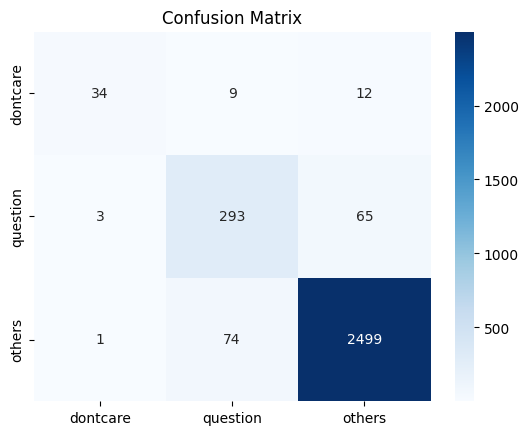

In [ ]:
predicted_labels = knn.predict(X_test_embeddings)

accuracy = accuracy_score(labels_test, predicted_labels)
print(f"Accuracy (test): {accuracy:.2f}")

f1 = f1_score(labels_test, predicted_labels, average='micro')
print(f"F1 Score (test, micro): {f1:.2f}")

f1 = f1_score(labels_test, predicted_labels, average='macro')
print(f"F1 Score (test, macro): {f1:.2f}")


cm = confusion_matrix(labels_test, predicted_labels)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=["dontcare", "question", "others"], yticklabels=["dontcare", "question", "others"])
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Usage example
embedding = scaler.transform([model.encode("I don't really care about either of them")])
pred = knn.predict(embedding)[0]

if pred == 0.:
    print(f"dontcare")
elif pred == 1.:
  print(f"question")
elif pred == 2.:
  print(f"other")

dontcare
